In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer
import os.path
# Harmonization
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel

In [2]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
    index_col="subject_id",
    target_cols=["age", "dl_qc_score", "scan_site_id"],
    label_encode_cols=["scan_site_id"]
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1865
(1865, 7200)
(1865, 3)


In [5]:
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())

2022-04-13 14:12:56.301928: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])

In [7]:
X = X[qc>0]
y = y[qc>0]
site = site[qc>0]

In [11]:
# Split the data by sites
X_0 = X[site==0]
y_0 = y[site==0]
X_3 = X[site==3]
y_3 = y[site==3]
X_4 = X[site==4]
y_4 = y[site==4]

In [12]:
# Split the data into train and test sets:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2, random_state=42)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

In [13]:
imputer = SimpleImputer(strategy="median")

In [14]:
# Impute train and test separately:
X_0_train = np.concatenate([imputer.fit_transform(X_0_train[..., ii])[:, :, None] for ii in range(X_0_train.shape[-1])], -1)
X_0_test = np.concatenate([imputer.fit_transform(X_0_test[..., ii])[:, :, None] for ii in range(X_0_test.shape[-1])], -1)
X_3_train = np.concatenate([imputer.fit_transform(X_3_train[..., ii])[:, :, None] for ii in range(X_3_train.shape[-1])], -1)
X_3_test = np.concatenate([imputer.fit_transform(X_3_test[..., ii])[:, :, None] for ii in range(X_3_test.shape[-1])], -1)
X_4_train = np.concatenate([imputer.fit_transform(X_4_train[..., ii])[:, :, None] for ii in range(X_4_train.shape[-1])], -1)
X_4_test = np.concatenate([imputer.fit_transform(X_4_test[..., ii])[:, :, None] for ii in range(X_4_test.shape[-1])], -1)

In [15]:
from sklearn.utils import shuffle
# dataset train 1: set 0 and 3
X_train_1 = np.concatenate((X_0_train, X_3_train), axis=0)
y_train_1 = np.concatenate((y_0_train, y_3_train), axis=0)
X_train_1, y_train_1 = shuffle(X_train_1, y_train_1)
# dataset train 2: set 0 and 4
X_train_2 = np.concatenate((X_0_train, X_4_train), axis=0)
y_train_2 = np.concatenate((y_0_train, y_4_train), axis=0)
X_train_2, y_train_2 = shuffle(X_train_2, y_train_2)
# dataset train 3: set 3 and 4
X_train_3 = np.concatenate((X_3_train, X_4_train), axis=0)
y_train_3 = np.concatenate((y_3_train, y_4_train), axis=0)
X_train_3, y_train_3 = shuffle(X_train_3, y_train_3)

In [16]:
n_epochs = 1000

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    mode="min",
    patience=100
)

# ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=20,
    verbose=1,
)

In [24]:
# Generate evaluation results and correlation coeffcients combined in a dataframe, and history
def double_cross_site(model_name, name_str, ckpt_filepath, lr,
                      site_1, site_2, site_3, X, y):
    # Split the data by sites
    X_1 = X[site==site_1]
    y_1 = y[site==site_1]
    X_2 = X[site==site_2]
    y_2 = y[site==site_2]
    X_3 = X[site==site_3]
    y_3 = y[site==site_3]
    # Split the data into train and test sets:
    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2)
    X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2)
    imputer = SimpleImputer(strategy="median")
    # Impute train and test separately:
    X_1_train = np.concatenate([imputer.fit_transform(X_1_train[..., ii])[:, :, None] for ii in range(X_1_train.shape[-1])], -1)
    X_2_train = np.concatenate([imputer.fit_transform(X_2_train[..., ii])[:, :, None] for ii in range(X_2_train.shape[-1])], -1)
    X_1_test = np.concatenate([imputer.fit_transform(X_1_test[..., ii])[:, :, None] for ii in range(X_1_test.shape[-1])], -1)
    X_2_test = np.concatenate([imputer.fit_transform(X_2_test[..., ii])[:, :, None] for ii in range(X_2_test.shape[-1])], -1)
    X_3_test = np.concatenate([imputer.fit_transform(X_3_test[..., ii])[:, :, None] for ii in range(X_3_test.shape[-1])], -1)
    # Merging data from two sites
    from sklearn.utils import shuffle
    # training data
    X_train = np.concatenate((X_1_train, X_2_train), axis=0)
    y_train = np.concatenate((y_1_train, y_2_train), axis=0)
    # size down
    X_train, y_train = shuffle(X_train, y_train, n_samples=y_3_test.shape[0])
    model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['mean_squared_error', 
                           tf.keras.metrics.RootMeanSquaredError(name='rmse'), 
                           'mean_absolute_error'])
    # ModelCheckpoint
    ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    )
    # CSVLogger
    log = tf.keras.callbacks.CSVLogger(filename=(str(model_name) + '.csv'), append=True)
    callbacks = [early_stopping, ckpt, reduce_lr, log]
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                        callbacks=callbacks)
    model.load_weights(ckpt_filepath)
    
    y_predicted1 = model.predict(X_1_test)
    y_predicted1 = y_predicted1.reshape(y_1_test.shape)
    y_predicted2 = model.predict(X_2_test)
    y_predicted2 = y_predicted2.reshape(y_2_test.shape)
    y_predicted3 = model.predict(X_3_test)
    y_predicted3 = y_predicted3.reshape(y_3_test.shape)
    coef1 = np.corrcoef(y_1_test, y_predicted1)[0,1] ** 2
    coef2 = np.corrcoef(y_2_test, y_predicted2)[0,1] ** 2
    coef3 = np.corrcoef(y_3_test, y_predicted3)[0,1] ** 2
    eval_1 = model.evaluate(X_1_test, y_1_test)
    eval_2 = model.evaluate(X_2_test, y_2_test)
    eval_3 = model.evaluate(X_3_test, y_3_test)
    result = {'Model': [name_str]*12,
              'Train_site': [f'{site_1}, {site_2}'] * 12,
              'Test_site': [site_1] * 4 + [site_2] * 4 + [site_3] * 4,
              'Metric': ['MSE', 'RMSE', 'MAE', 'coef'] * 3,
              'Value': [eval_1[1], eval_1[2], eval_1[3], coef1,
                        eval_2[1], eval_2[2], eval_2[3], coef2,
                        eval_3[1], eval_3[2], eval_3[3], coef3]}
    df = pd.DataFrame(result)
    return df, history

In [22]:
import pandas as pd

### Lenet

In [25]:
df_lenet_1, hisory_lenet_1 = double_cross_site(cnn_lenet, 'cnn_lenet', '/tmp/lenet.h5', 0.001,
                                                             0, 3, 4, X, y)

pooling layers: 4
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_12 (Conv1D)          (None, 100, 6)            1302      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 25, 2

1/1 [==============================] - ETA: 0s - loss: 42.7255 - mean_squared_error: 42.7255 - rmse: 6.5365 - mean_absolute_error: 4.6234
Epoch 00012: val_loss did not improve from 12.20627
1/1 [==============================] - 0s 36ms/step - loss: 42.7255 - mean_squared_error: 42.7255 - rmse: 6.5365 - mean_absolute_error: 4.6234 - val_loss: 22.9155 - val_mean_squared_error: 22.9155 - val_rmse: 4.7870 - val_mean_absolute_error: 3.9615 - lr: 0.0010
Epoch 13/1000
1/1 [==============================] - ETA: 0s - loss: 33.4484 - mean_squared_error: 33.4484 - rmse: 5.7835 - mean_absolute_error: 4.4454
Epoch 00013: val_loss did not improve from 12.20627
1/1 [==============================] - 0s 34ms/step - loss: 33.4484 - mean_squared_error: 33.4484 - rmse: 5.7835 - mean_absolute_error: 4.4454 - val_loss: 16.7852 - val_mean_squared_error: 16.7852 - val_rmse: 4.0970 - val_mean_absolute_error: 3.2655 - lr: 0.0010
Epoch 14/1000
1/1 [==============================] - ETA: 0s - loss: 37.8967 - m

Epoch 30/1000
1/1 [==============================] - ETA: 0s - loss: 29.8111 - mean_squared_error: 29.8111 - rmse: 5.4600 - mean_absolute_error: 4.5149
Epoch 00030: val_loss did not improve from 11.86552
1/1 [==============================] - 0s 39ms/step - loss: 29.8111 - mean_squared_error: 29.8111 - rmse: 5.4600 - mean_absolute_error: 4.5149 - val_loss: 12.7462 - val_mean_squared_error: 12.7462 - val_rmse: 3.5702 - val_mean_absolute_error: 2.8134 - lr: 0.0010
Epoch 31/1000
1/1 [==============================] - ETA: 0s - loss: 23.5770 - mean_squared_error: 23.5770 - rmse: 4.8556 - mean_absolute_error: 3.8456
Epoch 00031: val_loss did not improve from 11.86552
1/1 [==============================] - 0s 36ms/step - loss: 23.5770 - mean_squared_error: 23.5770 - rmse: 4.8556 - mean_absolute_error: 3.8456 - val_loss: 12.5255 - val_mean_squared_error: 12.5255 - val_rmse: 3.5391 - val_mean_absolute_error: 2.7734 - lr: 0.0010
Epoch 32/1000
1/1 [==============================] - ETA: 0s - los

1/1 [==============================] - ETA: 0s - loss: 21.1906 - mean_squared_error: 21.1906 - rmse: 4.6033 - mean_absolute_error: 3.5917
Epoch 00047: val_loss did not improve from 11.78574
1/1 [==============================] - 0s 39ms/step - loss: 21.1906 - mean_squared_error: 21.1906 - rmse: 4.6033 - mean_absolute_error: 3.5917 - val_loss: 11.8447 - val_mean_squared_error: 11.8447 - val_rmse: 3.4416 - val_mean_absolute_error: 2.6879 - lr: 0.0010
Epoch 48/1000
1/1 [==============================] - ETA: 0s - loss: 27.7439 - mean_squared_error: 27.7439 - rmse: 5.2672 - mean_absolute_error: 4.1950
Epoch 00048: val_loss did not improve from 11.78574
1/1 [==============================] - 0s 34ms/step - loss: 27.7439 - mean_squared_error: 27.7439 - rmse: 5.2672 - mean_absolute_error: 4.1950 - val_loss: 11.9096 - val_mean_squared_error: 11.9096 - val_rmse: 3.4510 - val_mean_absolute_error: 2.7032 - lr: 0.0010
Epoch 49/1000
1/1 [==============================] - ETA: 0s - loss: 23.9715 - m

1/1 [==============================] - 0s 59ms/step - loss: 14.0571 - mean_squared_error: 14.0571 - rmse: 3.7493 - mean_absolute_error: 2.8176 - val_loss: 11.5693 - val_mean_squared_error: 11.5693 - val_rmse: 3.4014 - val_mean_absolute_error: 2.6180 - lr: 0.0010
Epoch 65/1000
1/1 [==============================] - ETA: 0s - loss: 21.4153 - mean_squared_error: 21.4153 - rmse: 4.6277 - mean_absolute_error: 3.8098
Epoch 00065: val_loss improved from 11.56927 to 11.53807, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 57ms/step - loss: 21.4153 - mean_squared_error: 21.4153 - rmse: 4.6277 - mean_absolute_error: 3.8098 - val_loss: 11.5381 - val_mean_squared_error: 11.5381 - val_rmse: 3.3968 - val_mean_absolute_error: 2.6303 - lr: 0.0010
Epoch 66/1000
1/1 [==============================] - ETA: 0s - loss: 24.9654 - mean_squared_error: 24.9654 - rmse: 4.9965 - mean_absolute_error: 4.0311
Epoch 00066: val_loss improved from 11.53807 to 11.51369, saving model to /tmp/len

Epoch 82/1000
1/1 [==============================] - ETA: 0s - loss: 20.7214 - mean_squared_error: 20.7214 - rmse: 4.5521 - mean_absolute_error: 3.3693
Epoch 00082: val_loss improved from 11.34590 to 11.30970, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 82ms/step - loss: 20.7214 - mean_squared_error: 20.7214 - rmse: 4.5521 - mean_absolute_error: 3.3693 - val_loss: 11.3097 - val_mean_squared_error: 11.3097 - val_rmse: 3.3630 - val_mean_absolute_error: 2.6026 - lr: 0.0010
Epoch 83/1000
1/1 [==============================] - ETA: 0s - loss: 20.2911 - mean_squared_error: 20.2911 - rmse: 4.5046 - mean_absolute_error: 3.6632
Epoch 00083: val_loss improved from 11.30970 to 11.27579, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 63ms/step - loss: 20.2911 - mean_squared_error: 20.2911 - rmse: 4.5046 - mean_absolute_error: 3.6632 - val_loss: 11.2758 - val_mean_squared_error: 11.2758 - val_rmse: 3.3579 - val_mean_absolute_error: 2.6131 - lr: 0

Epoch 99/1000
1/1 [==============================] - ETA: 0s - loss: 19.8010 - mean_squared_error: 19.8010 - rmse: 4.4498 - mean_absolute_error: 3.4192
Epoch 00099: val_loss did not improve from 10.99027
1/1 [==============================] - 0s 45ms/step - loss: 19.8010 - mean_squared_error: 19.8010 - rmse: 4.4498 - mean_absolute_error: 3.4192 - val_loss: 11.0397 - val_mean_squared_error: 11.0397 - val_rmse: 3.3226 - val_mean_absolute_error: 2.6003 - lr: 0.0010
Epoch 100/1000
1/1 [==============================] - ETA: 0s - loss: 23.3191 - mean_squared_error: 23.3191 - rmse: 4.8290 - mean_absolute_error: 3.7629
Epoch 00100: val_loss improved from 10.99027 to 10.92019, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 63ms/step - loss: 23.3191 - mean_squared_error: 23.3191 - rmse: 4.8290 - mean_absolute_error: 3.7629 - val_loss: 10.9202 - val_mean_squared_error: 10.9202 - val_rmse: 3.3046 - val_mean_absolute_error: 2.5791 - lr: 0.0010
Epoch 101/1000
1/1 [=========

Epoch 116/1000
1/1 [==============================] - ETA: 0s - loss: 24.0399 - mean_squared_error: 24.0399 - rmse: 4.9031 - mean_absolute_error: 3.7099
Epoch 00116: val_loss did not improve from 10.29736
1/1 [==============================] - 0s 39ms/step - loss: 24.0399 - mean_squared_error: 24.0399 - rmse: 4.9031 - mean_absolute_error: 3.7099 - val_loss: 11.9526 - val_mean_squared_error: 11.9526 - val_rmse: 3.4573 - val_mean_absolute_error: 2.9377 - lr: 0.0010
Epoch 117/1000
1/1 [==============================] - ETA: 0s - loss: 17.6395 - mean_squared_error: 17.6395 - rmse: 4.1999 - mean_absolute_error: 3.4812
Epoch 00117: val_loss did not improve from 10.29736
1/1 [==============================] - 0s 47ms/step - loss: 17.6395 - mean_squared_error: 17.6395 - rmse: 4.1999 - mean_absolute_error: 3.4812 - val_loss: 11.7552 - val_mean_squared_error: 11.7552 - val_rmse: 3.4286 - val_mean_absolute_error: 2.9086 - lr: 0.0010
Epoch 118/1000
1/1 [==============================] - ETA: 0s - 

1/1 [==============================] - ETA: 0s - loss: 12.6128 - mean_squared_error: 12.6128 - rmse: 3.5515 - mean_absolute_error: 2.9465
Epoch 00133: val_loss improved from 9.81959 to 9.81156, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 60ms/step - loss: 12.6128 - mean_squared_error: 12.6128 - rmse: 3.5515 - mean_absolute_error: 2.9465 - val_loss: 9.8116 - val_mean_squared_error: 9.8116 - val_rmse: 3.1323 - val_mean_absolute_error: 2.4888 - lr: 0.0010
Epoch 134/1000
1/1 [==============================] - ETA: 0s - loss: 13.0194 - mean_squared_error: 13.0194 - rmse: 3.6082 - mean_absolute_error: 2.8638
Epoch 00134: val_loss improved from 9.81156 to 9.74505, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 61ms/step - loss: 13.0194 - mean_squared_error: 13.0194 - rmse: 3.6082 - mean_absolute_error: 2.8638 - val_loss: 9.7451 - val_mean_squared_error: 9.7451 - val_rmse: 3.1217 - val_mean_absolute_error: 2.4680 - lr: 0.0010
Epoch 135/1000


Epoch 150/1000
1/1 [==============================] - ETA: 0s - loss: 19.1803 - mean_squared_error: 19.1803 - rmse: 4.3795 - mean_absolute_error: 3.3311
Epoch 00150: val_loss did not improve from 9.21913
1/1 [==============================] - 0s 42ms/step - loss: 19.1803 - mean_squared_error: 19.1803 - rmse: 4.3795 - mean_absolute_error: 3.3311 - val_loss: 9.3519 - val_mean_squared_error: 9.3519 - val_rmse: 3.0581 - val_mean_absolute_error: 2.5544 - lr: 0.0010
Epoch 151/1000
1/1 [==============================] - ETA: 0s - loss: 17.3910 - mean_squared_error: 17.3910 - rmse: 4.1703 - mean_absolute_error: 3.2802
Epoch 00151: val_loss did not improve from 9.21913
1/1 [==============================] - 0s 39ms/step - loss: 17.3910 - mean_squared_error: 17.3910 - rmse: 4.1703 - mean_absolute_error: 3.2802 - val_loss: 9.3175 - val_mean_squared_error: 9.3175 - val_rmse: 3.0525 - val_mean_absolute_error: 2.5536 - lr: 0.0010
Epoch 152/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - ETA: 0s - loss: 10.5654 - mean_squared_error: 10.5654 - rmse: 3.2504 - mean_absolute_error: 2.5626
Epoch 00167: val_loss did not improve from 8.24290
1/1 [==============================] - 0s 38ms/step - loss: 10.5654 - mean_squared_error: 10.5654 - rmse: 3.2504 - mean_absolute_error: 2.5626 - val_loss: 8.4449 - val_mean_squared_error: 8.4449 - val_rmse: 2.9060 - val_mean_absolute_error: 2.5416 - lr: 0.0010
Epoch 168/1000
1/1 [==============================] - ETA: 0s - loss: 15.6584 - mean_squared_error: 15.6584 - rmse: 3.9571 - mean_absolute_error: 3.1828
Epoch 00168: val_loss did not improve from 8.24290
1/1 [==============================] - 0s 37ms/step - loss: 15.6584 - mean_squared_error: 15.6584 - rmse: 3.9571 - mean_absolute_error: 3.1828 - val_loss: 8.8861 - val_mean_squared_error: 8.8861 - val_rmse: 2.9810 - val_mean_absolute_error: 2.6830 - lr: 0.0010
Epoch 169/1000
1/1 [==============================] - ETA: 0s - loss: 12.3671 - mean_

Epoch 185/1000
1/1 [==============================] - ETA: 0s - loss: 21.6190 - mean_squared_error: 21.6190 - rmse: 4.6496 - mean_absolute_error: 3.4414
Epoch 00185: val_loss did not improve from 7.76442
1/1 [==============================] - 0s 35ms/step - loss: 21.6190 - mean_squared_error: 21.6190 - rmse: 4.6496 - mean_absolute_error: 3.4414 - val_loss: 11.9237 - val_mean_squared_error: 11.9237 - val_rmse: 3.4531 - val_mean_absolute_error: 3.1666 - lr: 0.0010
Epoch 186/1000
1/1 [==============================] - ETA: 0s - loss: 15.6252 - mean_squared_error: 15.6252 - rmse: 3.9529 - mean_absolute_error: 2.9705
Epoch 00186: val_loss did not improve from 7.76442
1/1 [==============================] - 0s 43ms/step - loss: 15.6252 - mean_squared_error: 15.6252 - rmse: 3.9529 - mean_absolute_error: 2.9705 - val_loss: 11.3455 - val_mean_squared_error: 11.3455 - val_rmse: 3.3683 - val_mean_absolute_error: 3.1039 - lr: 0.0010
Epoch 187/1000
1/1 [==============================] - ETA: 0s - lo

1/1 [==============================] - 0s 57ms/step - loss: 12.8859 - mean_squared_error: 12.8859 - rmse: 3.5897 - mean_absolute_error: 2.8888 - val_loss: 6.7016 - val_mean_squared_error: 6.7016 - val_rmse: 2.5887 - val_mean_absolute_error: 2.1956 - lr: 0.0010
Epoch 203/1000
1/1 [==============================] - ETA: 0s - loss: 12.0512 - mean_squared_error: 12.0512 - rmse: 3.4715 - mean_absolute_error: 2.7173
Epoch 00203: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 40ms/step - loss: 12.0512 - mean_squared_error: 12.0512 - rmse: 3.4715 - mean_absolute_error: 2.7173 - val_loss: 7.2317 - val_mean_squared_error: 7.2317 - val_rmse: 2.6892 - val_mean_absolute_error: 2.4019 - lr: 0.0010
Epoch 204/1000
1/1 [==============================] - ETA: 0s - loss: 14.5162 - mean_squared_error: 14.5162 - rmse: 3.8100 - mean_absolute_error: 2.8587
Epoch 00204: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 42ms/step - loss: 14.5162 - 

1/1 [==============================] - ETA: 0s - loss: 9.1505 - mean_squared_error: 9.1505 - rmse: 3.0250 - mean_absolute_error: 2.3391
Epoch 00220: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 42ms/step - loss: 9.1505 - mean_squared_error: 9.1505 - rmse: 3.0250 - mean_absolute_error: 2.3391 - val_loss: 6.9729 - val_mean_squared_error: 6.9729 - val_rmse: 2.6406 - val_mean_absolute_error: 2.2664 - lr: 0.0010
Epoch 221/1000
1/1 [==============================] - ETA: 0s - loss: 8.4677 - mean_squared_error: 8.4677 - rmse: 2.9099 - mean_absolute_error: 2.1848
Epoch 00221: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 44ms/step - loss: 8.4677 - mean_squared_error: 8.4677 - rmse: 2.9099 - mean_absolute_error: 2.1848 - val_loss: 7.0478 - val_mean_squared_error: 7.0478 - val_rmse: 2.6548 - val_mean_absolute_error: 2.2545 - lr: 0.0010
Epoch 222/1000
1/1 [==============================] - ETA: 0s - loss: 14.0680 - mean_squared_

Epoch 238/1000
1/1 [==============================] - ETA: 0s - loss: 12.1644 - mean_squared_error: 12.1644 - rmse: 3.4878 - mean_absolute_error: 2.7330
Epoch 00238: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 36ms/step - loss: 12.1644 - mean_squared_error: 12.1644 - rmse: 3.4878 - mean_absolute_error: 2.7330 - val_loss: 6.9995 - val_mean_squared_error: 6.9995 - val_rmse: 2.6457 - val_mean_absolute_error: 2.2810 - lr: 5.0000e-04
Epoch 239/1000
1/1 [==============================] - ETA: 0s - loss: 11.6432 - mean_squared_error: 11.6432 - rmse: 3.4122 - mean_absolute_error: 2.6532
Epoch 00239: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 38ms/step - loss: 11.6432 - mean_squared_error: 11.6432 - rmse: 3.4122 - mean_absolute_error: 2.6532 - val_loss: 6.9764 - val_mean_squared_error: 6.9764 - val_rmse: 2.6413 - val_mean_absolute_error: 2.2734 - lr: 5.0000e-04
Epoch 240/1000
1/1 [==============================] - ETA: 0s 

1/1 [==============================] - ETA: 0s - loss: 14.3221 - mean_squared_error: 14.3221 - rmse: 3.7845 - mean_absolute_error: 3.0957
Epoch 00255: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 36ms/step - loss: 14.3221 - mean_squared_error: 14.3221 - rmse: 3.7845 - mean_absolute_error: 3.0957 - val_loss: 6.9528 - val_mean_squared_error: 6.9528 - val_rmse: 2.6368 - val_mean_absolute_error: 2.2669 - lr: 2.5000e-04
Epoch 256/1000
1/1 [==============================] - ETA: 0s - loss: 15.9062 - mean_squared_error: 15.9062 - rmse: 3.9883 - mean_absolute_error: 2.9490
Epoch 00256: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 38ms/step - loss: 15.9062 - mean_squared_error: 15.9062 - rmse: 3.9883 - mean_absolute_error: 2.9490 - val_loss: 7.0052 - val_mean_squared_error: 7.0052 - val_rmse: 2.6467 - val_mean_absolute_error: 2.2736 - lr: 2.5000e-04
Epoch 257/1000
1/1 [==============================] - ETA: 0s - loss: 8.4533 

Epoch 273/1000
1/1 [==============================] - ETA: 0s - loss: 18.5693 - mean_squared_error: 18.5693 - rmse: 4.3092 - mean_absolute_error: 3.2440
Epoch 00273: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 42ms/step - loss: 18.5693 - mean_squared_error: 18.5693 - rmse: 4.3092 - mean_absolute_error: 3.2440 - val_loss: 7.1860 - val_mean_squared_error: 7.1860 - val_rmse: 2.6807 - val_mean_absolute_error: 2.2839 - lr: 1.2500e-04
Epoch 274/1000
1/1 [==============================] - ETA: 0s - loss: 8.5425 - mean_squared_error: 8.5425 - rmse: 2.9228 - mean_absolute_error: 2.3081
Epoch 00274: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 40ms/step - loss: 8.5425 - mean_squared_error: 8.5425 - rmse: 2.9228 - mean_absolute_error: 2.3081 - val_loss: 7.1888 - val_mean_squared_error: 7.1888 - val_rmse: 2.6812 - val_mean_absolute_error: 2.2870 - lr: 1.2500e-04
Epoch 275/1000
1/1 [==============================] - ETA: 0s - lo

Epoch 291/1000
1/1 [==============================] - ETA: 0s - loss: 8.9976 - mean_squared_error: 8.9976 - rmse: 2.9996 - mean_absolute_error: 2.3667
Epoch 00291: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 37ms/step - loss: 8.9976 - mean_squared_error: 8.9976 - rmse: 2.9996 - mean_absolute_error: 2.3667 - val_loss: 7.1484 - val_mean_squared_error: 7.1484 - val_rmse: 2.6737 - val_mean_absolute_error: 2.2774 - lr: 6.2500e-05
Epoch 292/1000
1/1 [==============================] - ETA: 0s - loss: 12.6078 - mean_squared_error: 12.6078 - rmse: 3.5508 - mean_absolute_error: 2.8489
Epoch 00292: val_loss did not improve from 6.70162
1/1 [==============================] - 0s 48ms/step - loss: 12.6078 - mean_squared_error: 12.6078 - rmse: 3.5508 - mean_absolute_error: 2.8489 - val_loss: 7.1294 - val_mean_squared_error: 7.1294 - val_rmse: 2.6701 - val_mean_absolute_error: 2.2757 - lr: 6.2500e-05
Epoch 293/1000
1/1 [==============================] - ETA: 0s - lo

In [26]:
df_lenet_1

Model Train_site  Test_site Metric      Value
0   cnn_lenet       0, 3          0    MSE  12.535519
1   cnn_lenet       0, 3          0   RMSE   3.540553
2   cnn_lenet       0, 3          0    MAE   2.863027
3   cnn_lenet       0, 3          0   coef   0.156662
4   cnn_lenet       0, 3          3    MSE  10.026026
5   cnn_lenet       0, 3          3   RMSE   3.166390
6   cnn_lenet       0, 3          3    MAE   2.453397
7   cnn_lenet       0, 3          3   coef   0.226605
8   cnn_lenet       0, 3          4    MSE  10.776499
9   cnn_lenet       0, 3          4   RMSE   3.282758
10  cnn_lenet       0, 3          4    MAE   2.803700
11  cnn_lenet       0, 3          4   coef   0.245066

In [29]:
df_lenet_2, hisory_lenet_2 = double_cross_site(cnn_lenet, 'cnn_lenet', '/tmp/lenet.h5', 0.001,
                                               0, 4, 3, X, y)

pooling layers: 4
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_24 (Conv1D)          (None, 100, 6)            1302      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 25, 2

Epoch 12/1000
1/1 [==============================] - ETA: 0s - loss: 32.9524 - mean_squared_error: 32.9524 - rmse: 5.7404 - mean_absolute_error: 4.6357
Epoch 00012: val_loss did not improve from 8.83344
1/1 [==============================] - 0s 55ms/step - loss: 32.9524 - mean_squared_error: 32.9524 - rmse: 5.7404 - mean_absolute_error: 4.6357 - val_loss: 17.0629 - val_mean_squared_error: 17.0629 - val_rmse: 4.1307 - val_mean_absolute_error: 3.7171 - lr: 0.0010
Epoch 13/1000
1/1 [==============================] - ETA: 0s - loss: 38.0134 - mean_squared_error: 38.0134 - rmse: 6.1655 - mean_absolute_error: 4.8031
Epoch 00013: val_loss did not improve from 8.83344
1/1 [==============================] - 0s 55ms/step - loss: 38.0134 - mean_squared_error: 38.0134 - rmse: 6.1655 - mean_absolute_error: 4.8031 - val_loss: 19.4339 - val_mean_squared_error: 19.4339 - val_rmse: 4.4084 - val_mean_absolute_error: 3.9744 - lr: 0.0010
Epoch 14/1000
1/1 [==============================] - ETA: 0s - loss:

Epoch 30/1000
1/1 [==============================] - ETA: 0s - loss: 25.0014 - mean_squared_error: 25.0014 - rmse: 5.0001 - mean_absolute_error: 3.9129
Epoch 00030: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 51ms/step - loss: 25.0014 - mean_squared_error: 25.0014 - rmse: 5.0001 - mean_absolute_error: 3.9129 - val_loss: 8.5311 - val_mean_squared_error: 8.5311 - val_rmse: 2.9208 - val_mean_absolute_error: 2.2573 - lr: 0.0010
Epoch 31/1000
1/1 [==============================] - ETA: 0s - loss: 21.8472 - mean_squared_error: 21.8472 - rmse: 4.6741 - mean_absolute_error: 3.6050
Epoch 00031: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 49ms/step - loss: 21.8472 - mean_squared_error: 21.8472 - rmse: 4.6741 - mean_absolute_error: 3.6050 - val_loss: 8.4724 - val_mean_squared_error: 8.4724 - val_rmse: 2.9107 - val_mean_absolute_error: 2.3096 - lr: 0.0010
Epoch 32/1000
1/1 [==============================] - ETA: 0s - loss: 22.

Epoch 48/1000
1/1 [==============================] - ETA: 0s - loss: 21.7947 - mean_squared_error: 21.7947 - rmse: 4.6685 - mean_absolute_error: 3.6960
Epoch 00048: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 56ms/step - loss: 21.7947 - mean_squared_error: 21.7947 - rmse: 4.6685 - mean_absolute_error: 3.6960 - val_loss: 9.6806 - val_mean_squared_error: 9.6806 - val_rmse: 3.1114 - val_mean_absolute_error: 2.2955 - lr: 5.0000e-04
Epoch 49/1000
1/1 [==============================] - ETA: 0s - loss: 26.4345 - mean_squared_error: 26.4345 - rmse: 5.1414 - mean_absolute_error: 4.0295
Epoch 00049: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 48ms/step - loss: 26.4345 - mean_squared_error: 26.4345 - rmse: 5.1414 - mean_absolute_error: 4.0295 - val_loss: 9.5679 - val_mean_squared_error: 9.5679 - val_rmse: 3.0932 - val_mean_absolute_error: 2.2839 - lr: 5.0000e-04
Epoch 50/1000
1/1 [==============================] - ETA: 0s - l

Epoch 66/1000
1/1 [==============================] - ETA: 0s - loss: 25.4997 - mean_squared_error: 25.4997 - rmse: 5.0497 - mean_absolute_error: 3.9576
Epoch 00066: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 50ms/step - loss: 25.4997 - mean_squared_error: 25.4997 - rmse: 5.0497 - mean_absolute_error: 3.9576 - val_loss: 8.7590 - val_mean_squared_error: 8.7590 - val_rmse: 2.9596 - val_mean_absolute_error: 2.2267 - lr: 2.5000e-04
Epoch 67/1000
1/1 [==============================] - ETA: 0s - loss: 21.1484 - mean_squared_error: 21.1484 - rmse: 4.5987 - mean_absolute_error: 3.6021
Epoch 00067: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 55ms/step - loss: 21.1484 - mean_squared_error: 21.1484 - rmse: 4.5987 - mean_absolute_error: 3.6021 - val_loss: 8.7727 - val_mean_squared_error: 8.7727 - val_rmse: 2.9619 - val_mean_absolute_error: 2.2254 - lr: 2.5000e-04
Epoch 68/1000
1/1 [==============================] - ETA: 0s - l

Epoch 84/1000
1/1 [==============================] - ETA: 0s - loss: 21.7465 - mean_squared_error: 21.7465 - rmse: 4.6633 - mean_absolute_error: 3.6785
Epoch 00084: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 53ms/step - loss: 21.7465 - mean_squared_error: 21.7465 - rmse: 4.6633 - mean_absolute_error: 3.6785 - val_loss: 8.7989 - val_mean_squared_error: 8.7989 - val_rmse: 2.9663 - val_mean_absolute_error: 2.2229 - lr: 1.2500e-04
Epoch 85/1000
1/1 [==============================] - ETA: 0s - loss: 18.4094 - mean_squared_error: 18.4094 - rmse: 4.2906 - mean_absolute_error: 3.3931
Epoch 00085: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 49ms/step - loss: 18.4094 - mean_squared_error: 18.4094 - rmse: 4.2906 - mean_absolute_error: 3.3931 - val_loss: 8.7760 - val_mean_squared_error: 8.7760 - val_rmse: 2.9624 - val_mean_absolute_error: 2.2249 - lr: 1.2500e-04
Epoch 86/1000
1/1 [==============================] - ETA: 0s - l

Epoch 102/1000
1/1 [==============================] - ETA: 0s - loss: 21.7749 - mean_squared_error: 21.7749 - rmse: 4.6664 - mean_absolute_error: 3.6829
Epoch 00102: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 55ms/step - loss: 21.7749 - mean_squared_error: 21.7749 - rmse: 4.6664 - mean_absolute_error: 3.6829 - val_loss: 8.7726 - val_mean_squared_error: 8.7726 - val_rmse: 2.9619 - val_mean_absolute_error: 2.2248 - lr: 6.2500e-05
Epoch 103/1000
1/1 [==============================] - ETA: 0s - loss: 21.7774 - mean_squared_error: 21.7774 - rmse: 4.6666 - mean_absolute_error: 3.7259
Epoch 00103: val_loss did not improve from 8.41860
1/1 [==============================] - 0s 60ms/step - loss: 21.7774 - mean_squared_error: 21.7774 - rmse: 4.6666 - mean_absolute_error: 3.7259 - val_loss: 8.7810 - val_mean_squared_error: 8.7810 - val_rmse: 2.9633 - val_mean_absolute_error: 2.2240 - lr: 6.2500e-05
Epoch 104/1000
1/1 [==============================] - ETA: 0s 

In [31]:
df_lenet_2

Model Train_site  Test_site Metric      Value
0   cnn_lenet       0, 4          0    MSE  11.561946
1   cnn_lenet       0, 4          0   RMSE   3.400286
2   cnn_lenet       0, 4          0    MAE   2.718210
3   cnn_lenet       0, 4          0   coef   0.066316
4   cnn_lenet       0, 4          4    MSE  13.346182
5   cnn_lenet       0, 4          4   RMSE   3.653243
6   cnn_lenet       0, 4          4    MAE   2.834193
7   cnn_lenet       0, 4          4   coef   0.024457
8   cnn_lenet       0, 4          3    MSE  10.885716
9   cnn_lenet       0, 4          3   RMSE   3.299351
10  cnn_lenet       0, 4          3    MAE   2.448843
11  cnn_lenet       0, 4          3   coef   0.179306

In [30]:
df_lenet_3, hisory_lenet_3 = double_cross_site(cnn_lenet, 'cnn_lenet', '/tmp/lenet.h5', 0.001,
                                                3, 4, 0, X, y)

pooling layers: 4
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_28 (Conv1D)          (None, 100, 6)            1302      
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 25, 2

Epoch 12/1000
1/1 [==============================] - ETA: 0s - loss: 46.7857 - mean_squared_error: 46.7857 - rmse: 6.8400 - mean_absolute_error: 5.7447
Epoch 00012: val_loss improved from 26.80943 to 16.10051, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 66ms/step - loss: 46.7857 - mean_squared_error: 46.7857 - rmse: 6.8400 - mean_absolute_error: 5.7447 - val_loss: 16.1005 - val_mean_squared_error: 16.1005 - val_rmse: 4.0125 - val_mean_absolute_error: 3.1101 - lr: 0.0010
Epoch 13/1000
1/1 [==============================] - ETA: 0s - loss: 35.8010 - mean_squared_error: 35.8010 - rmse: 5.9834 - mean_absolute_error: 4.7622
Epoch 00013: val_loss improved from 16.10051 to 8.65231, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 67ms/step - loss: 35.8010 - mean_squared_error: 35.8010 - rmse: 5.9834 - mean_absolute_error: 4.7622 - val_loss: 8.6523 - val_mean_squared_error: 8.6523 - val_rmse: 2.9415 - val_mean_absolute_error: 2.1981 - lr: 0.00

1/1 [==============================] - ETA: 0s - loss: 33.2176 - mean_squared_error: 33.2176 - rmse: 5.7635 - mean_absolute_error: 4.6966
Epoch 00029: val_loss did not improve from 7.10120
1/1 [==============================] - 0s 49ms/step - loss: 33.2176 - mean_squared_error: 33.2176 - rmse: 5.7635 - mean_absolute_error: 4.6966 - val_loss: 14.9515 - val_mean_squared_error: 14.9515 - val_rmse: 3.8667 - val_mean_absolute_error: 2.9625 - lr: 0.0010
Epoch 30/1000
1/1 [==============================] - ETA: 0s - loss: 29.1910 - mean_squared_error: 29.1910 - rmse: 5.4029 - mean_absolute_error: 4.1927
Epoch 00030: val_loss did not improve from 7.10120
1/1 [==============================] - 0s 55ms/step - loss: 29.1910 - mean_squared_error: 29.1910 - rmse: 5.4029 - mean_absolute_error: 4.1927 - val_loss: 13.1525 - val_mean_squared_error: 13.1525 - val_rmse: 3.6266 - val_mean_absolute_error: 2.7387 - lr: 0.0010
Epoch 31/1000
1/1 [==============================] - ETA: 0s - loss: 28.4939 - mea

Epoch 47/1000
1/1 [==============================] - ETA: 0s - loss: 30.2097 - mean_squared_error: 30.2097 - rmse: 5.4963 - mean_absolute_error: 3.7989
Epoch 00047: val_loss did not improve from 6.91891
1/1 [==============================] - 0s 51ms/step - loss: 30.2097 - mean_squared_error: 30.2097 - rmse: 5.4963 - mean_absolute_error: 3.7989 - val_loss: 8.4151 - val_mean_squared_error: 8.4151 - val_rmse: 2.9009 - val_mean_absolute_error: 2.1829 - lr: 0.0010
Epoch 48/1000
1/1 [==============================] - ETA: 0s - loss: 24.5141 - mean_squared_error: 24.5141 - rmse: 4.9512 - mean_absolute_error: 3.9136
Epoch 00048: val_loss did not improve from 6.91891
1/1 [==============================] - 0s 52ms/step - loss: 24.5141 - mean_squared_error: 24.5141 - rmse: 4.9512 - mean_absolute_error: 3.9136 - val_loss: 8.2928 - val_mean_squared_error: 8.2928 - val_rmse: 2.8797 - val_mean_absolute_error: 2.1738 - lr: 0.0010
Epoch 49/1000
1/1 [==============================] - ETA: 0s - loss: 26.

1/1 [==============================] - ETA: 0s - loss: 30.2967 - mean_squared_error: 30.2967 - rmse: 5.5042 - mean_absolute_error: 4.3544
Epoch 00064: val_loss did not improve from 6.82832
1/1 [==============================] - 0s 49ms/step - loss: 30.2967 - mean_squared_error: 30.2967 - rmse: 5.5042 - mean_absolute_error: 4.3544 - val_loss: 6.8903 - val_mean_squared_error: 6.8903 - val_rmse: 2.6249 - val_mean_absolute_error: 2.1089 - lr: 0.0010
Epoch 65/1000
1/1 [==============================] - ETA: 0s - loss: 21.9780 - mean_squared_error: 21.9780 - rmse: 4.6881 - mean_absolute_error: 3.7380
Epoch 00065: val_loss did not improve from 6.82832
1/1 [==============================] - 0s 53ms/step - loss: 21.9780 - mean_squared_error: 21.9780 - rmse: 4.6881 - mean_absolute_error: 3.7380 - val_loss: 6.9503 - val_mean_squared_error: 6.9503 - val_rmse: 2.6363 - val_mean_absolute_error: 2.1028 - lr: 0.0010
Epoch 66/1000
1/1 [==============================] - ETA: 0s - loss: 18.7891 - mean_sq

1/1 [==============================] - ETA: 0s - loss: 24.6945 - mean_squared_error: 24.6945 - rmse: 4.9694 - mean_absolute_error: 3.7901
Epoch 00081: val_loss did not improve from 6.74685
1/1 [==============================] - 0s 53ms/step - loss: 24.6945 - mean_squared_error: 24.6945 - rmse: 4.9694 - mean_absolute_error: 3.7901 - val_loss: 6.7507 - val_mean_squared_error: 6.7507 - val_rmse: 2.5982 - val_mean_absolute_error: 2.1587 - lr: 0.0010
Epoch 82/1000
1/1 [==============================] - ETA: 0s - loss: 20.7748 - mean_squared_error: 20.7748 - rmse: 4.5579 - mean_absolute_error: 3.4934
Epoch 00082: val_loss improved from 6.74685 to 6.73572, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 71ms/step - loss: 20.7748 - mean_squared_error: 20.7748 - rmse: 4.5579 - mean_absolute_error: 3.4934 - val_loss: 6.7357 - val_mean_squared_error: 6.7357 - val_rmse: 2.5953 - val_mean_absolute_error: 2.1534 - lr: 0.0010
Epoch 83/1000
1/1 [==============================] 

Epoch 99/1000
1/1 [==============================] - ETA: 0s - loss: 20.0117 - mean_squared_error: 20.0117 - rmse: 4.4734 - mean_absolute_error: 3.6354
Epoch 00099: val_loss did not improve from 6.68866
1/1 [==============================] - 0s 47ms/step - loss: 20.0117 - mean_squared_error: 20.0117 - rmse: 4.4734 - mean_absolute_error: 3.6354 - val_loss: 6.7664 - val_mean_squared_error: 6.7664 - val_rmse: 2.6012 - val_mean_absolute_error: 2.0586 - lr: 0.0010
Epoch 100/1000
1/1 [==============================] - ETA: 0s - loss: 21.6532 - mean_squared_error: 21.6532 - rmse: 4.6533 - mean_absolute_error: 3.6256
Epoch 00100: val_loss improved from 6.68866 to 6.66315, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 63ms/step - loss: 21.6532 - mean_squared_error: 21.6532 - rmse: 4.6533 - mean_absolute_error: 3.6256 - val_loss: 6.6631 - val_mean_squared_error: 6.6631 - val_rmse: 2.5813 - val_mean_absolute_error: 2.1090 - lr: 0.0010
Epoch 101/1000
1/1 [================

1/1 [==============================] - ETA: 0s - loss: 18.1545 - mean_squared_error: 18.1545 - rmse: 4.2608 - mean_absolute_error: 3.3310
Epoch 00116: val_loss did not improve from 6.59634
1/1 [==============================] - 0s 52ms/step - loss: 18.1545 - mean_squared_error: 18.1545 - rmse: 4.2608 - mean_absolute_error: 3.3310 - val_loss: 6.7063 - val_mean_squared_error: 6.7063 - val_rmse: 2.5897 - val_mean_absolute_error: 2.0303 - lr: 0.0010
Epoch 117/1000
1/1 [==============================] - ETA: 0s - loss: 16.7294 - mean_squared_error: 16.7294 - rmse: 4.0902 - mean_absolute_error: 3.2958
Epoch 00117: val_loss did not improve from 6.59634
1/1 [==============================] - 0s 50ms/step - loss: 16.7294 - mean_squared_error: 16.7294 - rmse: 4.0902 - mean_absolute_error: 3.2958 - val_loss: 6.6149 - val_mean_squared_error: 6.6149 - val_rmse: 2.5719 - val_mean_absolute_error: 2.0739 - lr: 0.0010
Epoch 118/1000
1/1 [==============================] - ETA: 0s - loss: 16.0537 - mean_

Epoch 134/1000
1/1 [==============================] - ETA: 0s - loss: 19.6625 - mean_squared_error: 19.6625 - rmse: 4.4342 - mean_absolute_error: 3.4495
Epoch 00134: val_loss did not improve from 6.53360
1/1 [==============================] - 0s 44ms/step - loss: 19.6625 - mean_squared_error: 19.6625 - rmse: 4.4342 - mean_absolute_error: 3.4495 - val_loss: 6.5810 - val_mean_squared_error: 6.5810 - val_rmse: 2.5653 - val_mean_absolute_error: 2.0395 - lr: 0.0010
Epoch 135/1000
1/1 [==============================] - ETA: 0s - loss: 13.1324 - mean_squared_error: 13.1324 - rmse: 3.6239 - mean_absolute_error: 2.8783
Epoch 00135: val_loss did not improve from 6.53360
1/1 [==============================] - 0s 50ms/step - loss: 13.1324 - mean_squared_error: 13.1324 - rmse: 3.6239 - mean_absolute_error: 2.8783 - val_loss: 6.5601 - val_mean_squared_error: 6.5601 - val_rmse: 2.5613 - val_mean_absolute_error: 2.1010 - lr: 0.0010
Epoch 136/1000
1/1 [==============================] - ETA: 0s - loss: 

1/1 [==============================] - ETA: 0s - loss: 19.6753 - mean_squared_error: 19.6753 - rmse: 4.4357 - mean_absolute_error: 3.4235
Epoch 00151: val_loss did not improve from 6.48413
1/1 [==============================] - 0s 43ms/step - loss: 19.6753 - mean_squared_error: 19.6753 - rmse: 4.4357 - mean_absolute_error: 3.4235 - val_loss: 6.4919 - val_mean_squared_error: 6.4919 - val_rmse: 2.5479 - val_mean_absolute_error: 2.0463 - lr: 0.0010
Epoch 152/1000
1/1 [==============================] - ETA: 0s - loss: 19.6878 - mean_squared_error: 19.6878 - rmse: 4.4371 - mean_absolute_error: 3.3325
Epoch 00152: val_loss improved from 6.48413 to 6.47731, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 64ms/step - loss: 19.6878 - mean_squared_error: 19.6878 - rmse: 4.4371 - mean_absolute_error: 3.3325 - val_loss: 6.4773 - val_mean_squared_error: 6.4773 - val_rmse: 2.5451 - val_mean_absolute_error: 2.0818 - lr: 0.0010
Epoch 153/1000
1/1 [==============================

Epoch 169/1000
1/1 [==============================] - ETA: 0s - loss: 17.9291 - mean_squared_error: 17.9291 - rmse: 4.2343 - mean_absolute_error: 3.2509
Epoch 00169: val_loss did not improve from 6.44200
1/1 [==============================] - 0s 47ms/step - loss: 17.9291 - mean_squared_error: 17.9291 - rmse: 4.2343 - mean_absolute_error: 3.2509 - val_loss: 6.4623 - val_mean_squared_error: 6.4623 - val_rmse: 2.5421 - val_mean_absolute_error: 2.0297 - lr: 0.0010
Epoch 170/1000
1/1 [==============================] - ETA: 0s - loss: 14.0913 - mean_squared_error: 14.0913 - rmse: 3.7538 - mean_absolute_error: 3.0184
Epoch 00170: val_loss improved from 6.44200 to 6.42701, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 66ms/step - loss: 14.0913 - mean_squared_error: 14.0913 - rmse: 3.7538 - mean_absolute_error: 3.0184 - val_loss: 6.4270 - val_mean_squared_error: 6.4270 - val_rmse: 2.5352 - val_mean_absolute_error: 2.0632 - lr: 0.0010
Epoch 171/1000
1/1 [===============

Epoch 187/1000
1/1 [==============================] - ETA: 0s - loss: 17.3369 - mean_squared_error: 17.3369 - rmse: 4.1638 - mean_absolute_error: 3.2080
Epoch 00187: val_loss did not improve from 6.34513
1/1 [==============================] - 0s 45ms/step - loss: 17.3369 - mean_squared_error: 17.3369 - rmse: 4.1638 - mean_absolute_error: 3.2080 - val_loss: 6.5580 - val_mean_squared_error: 6.5580 - val_rmse: 2.5609 - val_mean_absolute_error: 2.1468 - lr: 0.0010
Epoch 188/1000
1/1 [==============================] - ETA: 0s - loss: 16.2522 - mean_squared_error: 16.2522 - rmse: 4.0314 - mean_absolute_error: 3.2293
Epoch 00188: val_loss did not improve from 6.34513
1/1 [==============================] - 0s 49ms/step - loss: 16.2522 - mean_squared_error: 16.2522 - rmse: 4.0314 - mean_absolute_error: 3.2293 - val_loss: 6.3664 - val_mean_squared_error: 6.3664 - val_rmse: 2.5232 - val_mean_absolute_error: 2.0361 - lr: 0.0010
Epoch 189/1000
1/1 [==============================] - ETA: 0s - loss: 

Epoch 205/1000
1/1 [==============================] - ETA: 0s - loss: 16.1016 - mean_squared_error: 16.1016 - rmse: 4.0127 - mean_absolute_error: 3.0757
Epoch 00205: val_loss did not improve from 6.34513
1/1 [==============================] - 0s 41ms/step - loss: 16.1016 - mean_squared_error: 16.1016 - rmse: 4.0127 - mean_absolute_error: 3.0757 - val_loss: 6.5326 - val_mean_squared_error: 6.5326 - val_rmse: 2.5559 - val_mean_absolute_error: 1.9954 - lr: 5.0000e-04
Epoch 206/1000
1/1 [==============================] - ETA: 0s - loss: 16.1728 - mean_squared_error: 16.1728 - rmse: 4.0215 - mean_absolute_error: 3.1868
Epoch 00206: val_loss did not improve from 6.34513
1/1 [==============================] - 0s 49ms/step - loss: 16.1728 - mean_squared_error: 16.1728 - rmse: 4.0215 - mean_absolute_error: 3.1868 - val_loss: 6.3648 - val_mean_squared_error: 6.3648 - val_rmse: 2.5229 - val_mean_absolute_error: 2.0323 - lr: 5.0000e-04
Epoch 207/1000
1/1 [==============================] - ETA: 0s 

Epoch 223/1000
1/1 [==============================] - ETA: 0s - loss: 15.7313 - mean_squared_error: 15.7313 - rmse: 3.9663 - mean_absolute_error: 3.1600
Epoch 00223: val_loss did not improve from 6.31849
1/1 [==============================] - 0s 47ms/step - loss: 15.7313 - mean_squared_error: 15.7313 - rmse: 3.9663 - mean_absolute_error: 3.1600 - val_loss: 6.3597 - val_mean_squared_error: 6.3597 - val_rmse: 2.5219 - val_mean_absolute_error: 2.0013 - lr: 5.0000e-04
Epoch 224/1000
1/1 [==============================] - ETA: 0s - loss: 17.0683 - mean_squared_error: 17.0683 - rmse: 4.1314 - mean_absolute_error: 3.3078
Epoch 00224: val_loss did not improve from 6.31849
1/1 [==============================] - 0s 49ms/step - loss: 17.0683 - mean_squared_error: 17.0683 - rmse: 4.1314 - mean_absolute_error: 3.3078 - val_loss: 6.3392 - val_mean_squared_error: 6.3392 - val_rmse: 2.5178 - val_mean_absolute_error: 2.0765 - lr: 5.0000e-04
Epoch 225/1000
1/1 [==============================] - ETA: 0s 

1/1 [==============================] - ETA: 0s - loss: 14.8814 - mean_squared_error: 14.8814 - rmse: 3.8576 - mean_absolute_error: 3.0400
Epoch 00240: val_loss did not improve from 6.26425
1/1 [==============================] - 0s 48ms/step - loss: 14.8814 - mean_squared_error: 14.8814 - rmse: 3.8576 - mean_absolute_error: 3.0400 - val_loss: 6.2932 - val_mean_squared_error: 6.2932 - val_rmse: 2.5086 - val_mean_absolute_error: 2.0139 - lr: 5.0000e-04
Epoch 241/1000
1/1 [==============================] - ETA: 0s - loss: 17.2319 - mean_squared_error: 17.2319 - rmse: 4.1511 - mean_absolute_error: 3.2450
Epoch 00241: val_loss did not improve from 6.26425
1/1 [==============================] - 0s 48ms/step - loss: 17.2319 - mean_squared_error: 17.2319 - rmse: 4.1511 - mean_absolute_error: 3.2450 - val_loss: 6.2828 - val_mean_squared_error: 6.2828 - val_rmse: 2.5065 - val_mean_absolute_error: 2.0177 - lr: 5.0000e-04
Epoch 242/1000
1/1 [==============================] - ETA: 0s - loss: 13.1832

Epoch 258/1000
1/1 [==============================] - ETA: 0s - loss: 15.7419 - mean_squared_error: 15.7419 - rmse: 3.9676 - mean_absolute_error: 3.0052
Epoch 00258: val_loss did not improve from 6.26425
1/1 [==============================] - 0s 48ms/step - loss: 15.7419 - mean_squared_error: 15.7419 - rmse: 3.9676 - mean_absolute_error: 3.0052 - val_loss: 6.5999 - val_mean_squared_error: 6.5999 - val_rmse: 2.5690 - val_mean_absolute_error: 2.1452 - lr: 5.0000e-04
Epoch 259/1000
1/1 [==============================] - ETA: 0s - loss: 14.3954 - mean_squared_error: 14.3954 - rmse: 3.7941 - mean_absolute_error: 3.0611
Epoch 00259: val_loss did not improve from 6.26425

Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 [==============================] - 0s 52ms/step - loss: 14.3954 - mean_squared_error: 14.3954 - rmse: 3.7941 - mean_absolute_error: 3.0611 - val_loss: 6.5957 - val_mean_squared_error: 6.5957 - val_rmse: 2.5682 - val_mean_absolute_error: 2.144

1/1 [==============================] - ETA: 0s - loss: 15.5425 - mean_squared_error: 15.5425 - rmse: 3.9424 - mean_absolute_error: 3.1342
Epoch 00275: val_loss improved from 6.25631 to 6.24940, saving model to /tmp/lenet.h5
1/1 [==============================] - 0s 63ms/step - loss: 15.5425 - mean_squared_error: 15.5425 - rmse: 3.9424 - mean_absolute_error: 3.1342 - val_loss: 6.2494 - val_mean_squared_error: 6.2494 - val_rmse: 2.4999 - val_mean_absolute_error: 2.0195 - lr: 2.5000e-04
Epoch 276/1000
1/1 [==============================] - ETA: 0s - loss: 16.9117 - mean_squared_error: 16.9117 - rmse: 4.1124 - mean_absolute_error: 3.3287
Epoch 00276: val_loss did not improve from 6.24940
1/1 [==============================] - 0s 69ms/step - loss: 16.9117 - mean_squared_error: 16.9117 - rmse: 4.1124 - mean_absolute_error: 3.3287 - val_loss: 6.2785 - val_mean_squared_error: 6.2785 - val_rmse: 2.5057 - val_mean_absolute_error: 2.0034 - lr: 2.5000e-04
Epoch 277/1000
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 16.7730 - mean_squared_error: 16.7730 - rmse: 4.0955 - mean_absolute_error: 3.3760
Epoch 00292: val_loss did not improve from 6.22280
1/1 [==============================] - 0s 53ms/step - loss: 16.7730 - mean_squared_error: 16.7730 - rmse: 4.0955 - mean_absolute_error: 3.3760 - val_loss: 6.2581 - val_mean_squared_error: 6.2581 - val_rmse: 2.5016 - val_mean_absolute_error: 1.9967 - lr: 2.5000e-04
Epoch 293/1000
1/1 [==============================] - ETA: 0s - loss: 15.3285 - mean_squared_error: 15.3285 - rmse: 3.9152 - mean_absolute_error: 2.9830
Epoch 00293: val_loss did not improve from 6.22280
1/1 [==============================] - 0s 53ms/step - loss: 15.3285 - mean_squared_error: 15.3285 - rmse: 3.9152 - mean_absolute_error: 2.9830 - val_loss: 6.2906 - val_mean_squared_error: 6.2906 - val_rmse: 2.5081 - val_mean_absolute_error: 1.9895 - lr: 2.5000e-04
Epoch 294/1000
1/1 [==============================] - ETA: 0s - loss: 15.6266

Epoch 310/1000
1/1 [==============================] - ETA: 0s - loss: 18.0707 - mean_squared_error: 18.0707 - rmse: 4.2510 - mean_absolute_error: 3.2414
Epoch 00310: val_loss did not improve from 6.21696
1/1 [==============================] - 0s 50ms/step - loss: 18.0707 - mean_squared_error: 18.0707 - rmse: 4.2510 - mean_absolute_error: 3.2414 - val_loss: 6.5459 - val_mean_squared_error: 6.5459 - val_rmse: 2.5585 - val_mean_absolute_error: 2.1188 - lr: 2.5000e-04
Epoch 311/1000
1/1 [==============================] - ETA: 0s - loss: 15.8629 - mean_squared_error: 15.8629 - rmse: 3.9828 - mean_absolute_error: 3.0248
Epoch 00311: val_loss did not improve from 6.21696
1/1 [==============================] - 0s 54ms/step - loss: 15.8629 - mean_squared_error: 15.8629 - rmse: 3.9828 - mean_absolute_error: 3.0248 - val_loss: 6.4175 - val_mean_squared_error: 6.4175 - val_rmse: 2.5333 - val_mean_absolute_error: 2.0902 - lr: 2.5000e-04
Epoch 312/1000
1/1 [==============================] - ETA: 0s 

1/1 [==============================] - ETA: 0s - loss: 15.7454 - mean_squared_error: 15.7454 - rmse: 3.9680 - mean_absolute_error: 3.2496
Epoch 00327: val_loss did not improve from 6.20814
1/1 [==============================] - 0s 52ms/step - loss: 15.7454 - mean_squared_error: 15.7454 - rmse: 3.9680 - mean_absolute_error: 3.2496 - val_loss: 6.2561 - val_mean_squared_error: 6.2561 - val_rmse: 2.5012 - val_mean_absolute_error: 1.9905 - lr: 2.5000e-04
Epoch 328/1000
1/1 [==============================] - ETA: 0s - loss: 13.6351 - mean_squared_error: 13.6351 - rmse: 3.6926 - mean_absolute_error: 2.7940
Epoch 00328: val_loss did not improve from 6.20814
1/1 [==============================] - 0s 52ms/step - loss: 13.6351 - mean_squared_error: 13.6351 - rmse: 3.6926 - mean_absolute_error: 2.7940 - val_loss: 6.3519 - val_mean_squared_error: 6.3519 - val_rmse: 2.5203 - val_mean_absolute_error: 1.9754 - lr: 2.5000e-04
Epoch 329/1000
1/1 [==============================] - ETA: 0s - loss: 14.1035

Epoch 345/1000
1/1 [==============================] - ETA: 0s - loss: 17.1312 - mean_squared_error: 17.1312 - rmse: 4.1390 - mean_absolute_error: 3.1223
Epoch 00345: val_loss did not improve from 6.20814
1/1 [==============================] - 0s 53ms/step - loss: 17.1312 - mean_squared_error: 17.1312 - rmse: 4.1390 - mean_absolute_error: 3.1223 - val_loss: 6.5499 - val_mean_squared_error: 6.5499 - val_rmse: 2.5593 - val_mean_absolute_error: 2.1151 - lr: 2.5000e-04
Epoch 346/1000
1/1 [==============================] - ETA: 0s - loss: 15.6409 - mean_squared_error: 15.6409 - rmse: 3.9549 - mean_absolute_error: 3.1182
Epoch 00346: val_loss did not improve from 6.20814

Epoch 00346: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 [==============================] - 0s 52ms/step - loss: 15.6409 - mean_squared_error: 15.6409 - rmse: 3.9549 - mean_absolute_error: 3.1182 - val_loss: 6.7845 - val_mean_squared_error: 6.7845 - val_rmse: 2.6047 - val_mean_absolute_error: 2.161

1/1 [==============================] - ETA: 0s - loss: 17.2806 - mean_squared_error: 17.2806 - rmse: 4.1570 - mean_absolute_error: 3.3898
Epoch 00362: val_loss did not improve from 6.20814
1/1 [==============================] - 0s 50ms/step - loss: 17.2806 - mean_squared_error: 17.2806 - rmse: 4.1570 - mean_absolute_error: 3.3898 - val_loss: 6.4984 - val_mean_squared_error: 6.4984 - val_rmse: 2.5492 - val_mean_absolute_error: 2.1055 - lr: 1.2500e-04
Epoch 363/1000
1/1 [==============================] - ETA: 0s - loss: 14.4547 - mean_squared_error: 14.4547 - rmse: 3.8019 - mean_absolute_error: 2.9728
Epoch 00363: val_loss did not improve from 6.20814
1/1 [==============================] - 0s 49ms/step - loss: 14.4547 - mean_squared_error: 14.4547 - rmse: 3.8019 - mean_absolute_error: 2.9728 - val_loss: 6.5932 - val_mean_squared_error: 6.5932 - val_rmse: 2.5677 - val_mean_absolute_error: 2.1251 - lr: 1.2500e-04
Epoch 364/1000
1/1 [==============================] - ETA: 0s - loss: 16.6374

1/1 [==============================] - ETA: 0s - loss: 15.9579 - mean_squared_error: 15.9579 - rmse: 3.9947 - mean_absolute_error: 3.0628
Epoch 00379: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 52ms/step - loss: 15.9579 - mean_squared_error: 15.9579 - rmse: 3.9947 - mean_absolute_error: 3.0628 - val_loss: 6.2386 - val_mean_squared_error: 6.2386 - val_rmse: 2.4977 - val_mean_absolute_error: 2.0370 - lr: 6.2500e-05
Epoch 380/1000
1/1 [==============================] - ETA: 0s - loss: 17.4161 - mean_squared_error: 17.4161 - rmse: 4.1733 - mean_absolute_error: 3.2106
Epoch 00380: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 49ms/step - loss: 17.4161 - mean_squared_error: 17.4161 - rmse: 4.1733 - mean_absolute_error: 3.2106 - val_loss: 6.2364 - val_mean_squared_error: 6.2364 - val_rmse: 2.4973 - val_mean_absolute_error: 2.0361 - lr: 6.2500e-05
Epoch 381/1000
1/1 [==============================] - ETA: 0s - loss: 16.2198

Epoch 397/1000
1/1 [==============================] - ETA: 0s - loss: 14.2987 - mean_squared_error: 14.2987 - rmse: 3.7814 - mean_absolute_error: 3.0380
Epoch 00397: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 73ms/step - loss: 14.2987 - mean_squared_error: 14.2987 - rmse: 3.7814 - mean_absolute_error: 3.0380 - val_loss: 6.4327 - val_mean_squared_error: 6.4327 - val_rmse: 2.5363 - val_mean_absolute_error: 2.0869 - lr: 3.1250e-05
Epoch 398/1000
1/1 [==============================] - ETA: 0s - loss: 17.4696 - mean_squared_error: 17.4696 - rmse: 4.1797 - mean_absolute_error: 3.2487
Epoch 00398: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 47ms/step - loss: 17.4696 - mean_squared_error: 17.4696 - rmse: 4.1797 - mean_absolute_error: 3.2487 - val_loss: 6.4110 - val_mean_squared_error: 6.4110 - val_rmse: 2.5320 - val_mean_absolute_error: 2.0817 - lr: 3.1250e-05
Epoch 399/1000
1/1 [==============================] - ETA: 0s 

Epoch 415/1000
1/1 [==============================] - ETA: 0s - loss: 18.4741 - mean_squared_error: 18.4741 - rmse: 4.2982 - mean_absolute_error: 3.3510
Epoch 00415: val_loss did not improve from 6.20536

Epoch 00415: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1/1 [==============================] - 0s 44ms/step - loss: 18.4741 - mean_squared_error: 18.4741 - rmse: 4.2982 - mean_absolute_error: 3.3510 - val_loss: 6.2481 - val_mean_squared_error: 6.2481 - val_rmse: 2.4996 - val_mean_absolute_error: 2.0408 - lr: 3.1250e-05
Epoch 416/1000
1/1 [==============================] - ETA: 0s - loss: 16.7707 - mean_squared_error: 16.7707 - rmse: 4.0952 - mean_absolute_error: 3.0316
Epoch 00416: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 54ms/step - loss: 16.7707 - mean_squared_error: 16.7707 - rmse: 4.0952 - mean_absolute_error: 3.0316 - val_loss: 6.2478 - val_mean_squared_error: 6.2478 - val_rmse: 2.4996 - val_mean_absolute_error: 2.04

1/1 [==============================] - ETA: 0s - loss: 14.2407 - mean_squared_error: 14.2407 - rmse: 3.7737 - mean_absolute_error: 2.9390
Epoch 00432: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 47ms/step - loss: 14.2407 - mean_squared_error: 14.2407 - rmse: 3.7737 - mean_absolute_error: 2.9390 - val_loss: 6.2478 - val_mean_squared_error: 6.2478 - val_rmse: 2.4996 - val_mean_absolute_error: 2.0392 - lr: 1.5625e-05
Epoch 433/1000
1/1 [==============================] - ETA: 0s - loss: 14.0501 - mean_squared_error: 14.0501 - rmse: 3.7483 - mean_absolute_error: 2.9247
Epoch 00433: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 52ms/step - loss: 14.0501 - mean_squared_error: 14.0501 - rmse: 3.7483 - mean_absolute_error: 2.9247 - val_loss: 6.2477 - val_mean_squared_error: 6.2477 - val_rmse: 2.4995 - val_mean_absolute_error: 2.0390 - lr: 1.5625e-05
Epoch 434/1000
1/1 [==============================] - ETA: 0s - loss: 16.4584

Epoch 450/1000
1/1 [==============================] - ETA: 0s - loss: 16.9334 - mean_squared_error: 16.9334 - rmse: 4.1150 - mean_absolute_error: 3.0929
Epoch 00450: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 51ms/step - loss: 16.9334 - mean_squared_error: 16.9334 - rmse: 4.1150 - mean_absolute_error: 3.0929 - val_loss: 6.2931 - val_mean_squared_error: 6.2931 - val_rmse: 2.5086 - val_mean_absolute_error: 2.0532 - lr: 7.8125e-06
Epoch 451/1000
1/1 [==============================] - ETA: 0s - loss: 19.6192 - mean_squared_error: 19.6192 - rmse: 4.4294 - mean_absolute_error: 3.3598
Epoch 00451: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 50ms/step - loss: 19.6192 - mean_squared_error: 19.6192 - rmse: 4.4294 - mean_absolute_error: 3.3598 - val_loss: 6.2923 - val_mean_squared_error: 6.2923 - val_rmse: 2.5084 - val_mean_absolute_error: 2.0530 - lr: 7.8125e-06
Epoch 452/1000
1/1 [==============================] - ETA: 0s 

1/1 [==============================] - ETA: 0s - loss: 13.6556 - mean_squared_error: 13.6556 - rmse: 3.6953 - mean_absolute_error: 2.9321
Epoch 00467: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 50ms/step - loss: 13.6556 - mean_squared_error: 13.6556 - rmse: 3.6953 - mean_absolute_error: 2.9321 - val_loss: 6.2631 - val_mean_squared_error: 6.2631 - val_rmse: 2.5026 - val_mean_absolute_error: 2.0438 - lr: 3.9063e-06
Epoch 468/1000
1/1 [==============================] - ETA: 0s - loss: 15.8692 - mean_squared_error: 15.8692 - rmse: 3.9836 - mean_absolute_error: 3.1205
Epoch 00468: val_loss did not improve from 6.20536
1/1 [==============================] - 0s 55ms/step - loss: 15.8692 - mean_squared_error: 15.8692 - rmse: 3.9836 - mean_absolute_error: 3.1205 - val_loss: 6.2618 - val_mean_squared_error: 6.2618 - val_rmse: 2.5024 - val_mean_absolute_error: 2.0433 - lr: 3.9063e-06
Epoch 469/1000
1/1 [==============================] - ETA: 0s - loss: 14.4802

In [32]:
df_lenet_3

Model Train_site  Test_site Metric      Value
0   cnn_lenet       3, 4          3    MSE  12.283073
1   cnn_lenet       3, 4          3   RMSE   3.504722
2   cnn_lenet       3, 4          3    MAE   2.628765
3   cnn_lenet       3, 4          3   coef   0.185557
4   cnn_lenet       3, 4          4    MSE   9.999634
5   cnn_lenet       3, 4          4   RMSE   3.162220
6   cnn_lenet       3, 4          4    MAE   2.330163
7   cnn_lenet       3, 4          4   coef   0.048438
8   cnn_lenet       3, 4          0    MSE  11.196415
9   cnn_lenet       3, 4          0   RMSE   3.346104
10  cnn_lenet       3, 4          0    MAE   2.751702
11  cnn_lenet       3, 4          0   coef   0.206136

In [73]:
results_1 = {'cnn_lenet' : eval_lenet_1[1:]}
results_2 = {'cnn_lenet' : eval_lenet_2[1:]}
results_3 = {'cnn_lenet' : eval_lenet_3[1:]}

### mlp4

In [69]:
eval_mlp4_1, hisory_mlp4_1, epochs_mlp4_1 = model_history(mlp4, '/tmp/mlp4.h5', 0.001,
                                                          X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dropout_6 (Dropout)         (None, 7200)              0         
                                                                 
 dense_9 (Dense)             (None, 500)               3600500   
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 dropout_8 (Dropout)         (None, 500)               0   

Epoch 32/1000
7/8 [=========================>....] - ETA: 0s - loss: 10.7297 - mean_squared_error: 10.7297 - rmse: 3.2756 - mean_absolute_error: 2.6065
Epoch 00032: val_loss did not improve from 9.44810
8/8 [==============================] - 0s 28ms/step - loss: 10.4786 - mean_squared_error: 10.4786 - rmse: 3.2371 - mean_absolute_error: 2.5644 - val_loss: 20.0241 - val_mean_squared_error: 20.0241 - val_rmse: 4.4748 - val_mean_absolute_error: 3.3666 - lr: 0.0010
Epoch 33/1000
7/8 [=========================>....] - ETA: 0s - loss: 10.5925 - mean_squared_error: 10.5925 - rmse: 3.2546 - mean_absolute_error: 2.5726
Epoch 00033: val_loss did not improve from 9.44810
8/8 [==============================] - 0s 27ms/step - loss: 10.5305 - mean_squared_error: 10.5305 - rmse: 3.2451 - mean_absolute_error: 2.5481 - val_loss: 17.0055 - val_mean_squared_error: 17.0055 - val_rmse: 4.1238 - val_mean_absolute_error: 3.0542 - lr: 0.0010
Epoch 34/1000
7/8 [=========================>....] - ETA: 0s - loss:

Epoch 50/1000
6/8 [=====================>........] - ETA: 0s - loss: 10.2623 - mean_squared_error: 10.2623 - rmse: 3.2035 - mean_absolute_error: 2.4686
Epoch 00050: val_loss did not improve from 8.16318
8/8 [==============================] - 0s 27ms/step - loss: 10.0876 - mean_squared_error: 10.0876 - rmse: 3.1761 - mean_absolute_error: 2.4795 - val_loss: 15.9324 - val_mean_squared_error: 15.9324 - val_rmse: 3.9915 - val_mean_absolute_error: 3.0351 - lr: 0.0010
Epoch 51/1000
6/8 [=====================>........] - ETA: 0s - loss: 8.3114 - mean_squared_error: 8.3114 - rmse: 2.8830 - mean_absolute_error: 2.2541
Epoch 00051: val_loss did not improve from 8.16318
8/8 [==============================] - 0s 25ms/step - loss: 8.2392 - mean_squared_error: 8.2392 - rmse: 2.8704 - mean_absolute_error: 2.2540 - val_loss: 13.2500 - val_mean_squared_error: 13.2500 - val_rmse: 3.6401 - val_mean_absolute_error: 2.7107 - lr: 0.0010
Epoch 52/1000
7/8 [=========================>....] - ETA: 0s - loss: 8.5

Epoch 68/1000
7/8 [=========================>....] - ETA: 0s - loss: 9.7602 - mean_squared_error: 9.7602 - rmse: 3.1241 - mean_absolute_error: 2.4595  
Epoch 00068: val_loss did not improve from 6.80233
8/8 [==============================] - 0s 24ms/step - loss: 9.6121 - mean_squared_error: 9.6121 - rmse: 3.1003 - mean_absolute_error: 2.4498 - val_loss: 8.5834 - val_mean_squared_error: 8.5834 - val_rmse: 2.9297 - val_mean_absolute_error: 2.1932 - lr: 0.0010
Epoch 69/1000
7/8 [=========================>....] - ETA: 0s - loss: 9.5606 - mean_squared_error: 9.5606 - rmse: 3.0920 - mean_absolute_error: 2.4920
Epoch 00069: val_loss did not improve from 6.80233
8/8 [==============================] - 0s 23ms/step - loss: 9.3141 - mean_squared_error: 9.3141 - rmse: 3.0519 - mean_absolute_error: 2.4538 - val_loss: 20.0447 - val_mean_squared_error: 20.0447 - val_rmse: 4.4771 - val_mean_absolute_error: 3.5599 - lr: 0.0010
Epoch 70/1000
6/8 [=====================>........] - ETA: 0s - loss: 8.5328 

Epoch 86/1000
6/8 [=====================>........] - ETA: 0s - loss: 6.9571 - mean_squared_error: 6.9571 - rmse: 2.6376 - mean_absolute_error: 2.1081
Epoch 00086: val_loss did not improve from 6.01779
8/8 [==============================] - 0s 25ms/step - loss: 7.1033 - mean_squared_error: 7.1033 - rmse: 2.6652 - mean_absolute_error: 2.1252 - val_loss: 12.5090 - val_mean_squared_error: 12.5090 - val_rmse: 3.5368 - val_mean_absolute_error: 2.6844 - lr: 0.0010
Epoch 87/1000
7/8 [=========================>....] - ETA: 0s - loss: 6.5683 - mean_squared_error: 6.5683 - rmse: 2.5629 - mean_absolute_error: 2.0131
Epoch 00087: val_loss did not improve from 6.01779
8/8 [==============================] - 0s 24ms/step - loss: 6.4413 - mean_squared_error: 6.4413 - rmse: 2.5380 - mean_absolute_error: 1.9901 - val_loss: 16.0965 - val_mean_squared_error: 16.0965 - val_rmse: 4.0120 - val_mean_absolute_error: 3.1498 - lr: 0.0010
Epoch 88/1000
7/8 [=========================>....] - ETA: 0s - loss: 7.5958 

Epoch 104/1000
7/8 [=========================>....] - ETA: 0s - loss: 7.4014 - mean_squared_error: 7.4014 - rmse: 2.7206 - mean_absolute_error: 2.1588
Epoch 00104: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 26ms/step - loss: 7.4085 - mean_squared_error: 7.4085 - rmse: 2.7219 - mean_absolute_error: 2.1579 - val_loss: 11.9409 - val_mean_squared_error: 11.9409 - val_rmse: 3.4556 - val_mean_absolute_error: 2.5599 - lr: 0.0010
Epoch 105/1000
7/8 [=========================>....] - ETA: 0s - loss: 7.5246 - mean_squared_error: 7.5246 - rmse: 2.7431 - mean_absolute_error: 2.1734
Epoch 00105: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 26ms/step - loss: 7.5647 - mean_squared_error: 7.5647 - rmse: 2.7504 - mean_absolute_error: 2.1894 - val_loss: 11.8571 - val_mean_squared_error: 11.8571 - val_rmse: 3.4434 - val_mean_absolute_error: 2.6333 - lr: 0.0010
Epoch 106/1000
7/8 [=========================>....] - ETA: 0s - loss: 6.89

Epoch 122/1000
6/8 [=====================>........] - ETA: 0s - loss: 5.7765 - mean_squared_error: 5.7765 - rmse: 2.4034 - mean_absolute_error: 1.8822
Epoch 00122: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 26ms/step - loss: 5.6186 - mean_squared_error: 5.6186 - rmse: 2.3704 - mean_absolute_error: 1.8519 - val_loss: 10.3080 - val_mean_squared_error: 10.3080 - val_rmse: 3.2106 - val_mean_absolute_error: 2.4019 - lr: 5.0000e-04
Epoch 123/1000
7/8 [=========================>....] - ETA: 0s - loss: 6.2696 - mean_squared_error: 6.2696 - rmse: 2.5039 - mean_absolute_error: 1.9742
Epoch 00123: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 26ms/step - loss: 6.2173 - mean_squared_error: 6.2173 - rmse: 2.4935 - mean_absolute_error: 1.9674 - val_loss: 6.6022 - val_mean_squared_error: 6.6022 - val_rmse: 2.5695 - val_mean_absolute_error: 1.8464 - lr: 5.0000e-04
Epoch 124/1000
7/8 [=========================>....] - ETA: 0s - loss

Epoch 140/1000
7/8 [=========================>....] - ETA: 0s - loss: 5.5684 - mean_squared_error: 5.5684 - rmse: 2.3598 - mean_absolute_error: 1.8296
Epoch 00140: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 25ms/step - loss: 5.7339 - mean_squared_error: 5.7339 - rmse: 2.3946 - mean_absolute_error: 1.8508 - val_loss: 10.1115 - val_mean_squared_error: 10.1115 - val_rmse: 3.1799 - val_mean_absolute_error: 2.3836 - lr: 2.5000e-04
Epoch 141/1000
6/8 [=====================>........] - ETA: 0s - loss: 5.7441 - mean_squared_error: 5.7441 - rmse: 2.3967 - mean_absolute_error: 1.9185
Epoch 00141: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 28ms/step - loss: 5.7512 - mean_squared_error: 5.7512 - rmse: 2.3982 - mean_absolute_error: 1.9015 - val_loss: 10.2089 - val_mean_squared_error: 10.2089 - val_rmse: 3.1951 - val_mean_absolute_error: 2.4198 - lr: 2.5000e-04
Epoch 142/1000
8/8 [==============================] - ETA: 0s - lo

Epoch 158/1000
7/8 [=========================>....] - ETA: 0s - loss: 5.2061 - mean_squared_error: 5.2061 - rmse: 2.2817 - mean_absolute_error: 1.7929
Epoch 00158: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 23ms/step - loss: 5.1889 - mean_squared_error: 5.1889 - rmse: 2.2779 - mean_absolute_error: 1.7996 - val_loss: 11.2873 - val_mean_squared_error: 11.2873 - val_rmse: 3.3597 - val_mean_absolute_error: 2.5685 - lr: 2.5000e-04
Epoch 159/1000
6/8 [=====================>........] - ETA: 0s - loss: 5.3984 - mean_squared_error: 5.3984 - rmse: 2.3234 - mean_absolute_error: 1.8313
Epoch 00159: val_loss did not improve from 5.78164

Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
8/8 [==============================] - 0s 25ms/step - loss: 5.4518 - mean_squared_error: 5.4518 - rmse: 2.3349 - mean_absolute_error: 1.8257 - val_loss: 10.9075 - val_mean_squared_error: 10.9075 - val_rmse: 3.3026 - val_mean_absolute_error: 2.5214 - 

Epoch 176/1000
7/8 [=========================>....] - ETA: 0s - loss: 5.0127 - mean_squared_error: 5.0127 - rmse: 2.2389 - mean_absolute_error: 1.7494
Epoch 00176: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 22ms/step - loss: 5.0482 - mean_squared_error: 5.0482 - rmse: 2.2468 - mean_absolute_error: 1.7515 - val_loss: 10.3906 - val_mean_squared_error: 10.3906 - val_rmse: 3.2234 - val_mean_absolute_error: 2.4705 - lr: 1.2500e-04
Epoch 177/1000
7/8 [=========================>....] - ETA: 0s - loss: 5.2719 - mean_squared_error: 5.2719 - rmse: 2.2961 - mean_absolute_error: 1.8378
Epoch 00177: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 23ms/step - loss: 5.2752 - mean_squared_error: 5.2752 - rmse: 2.2968 - mean_absolute_error: 1.8309 - val_loss: 11.1706 - val_mean_squared_error: 11.1706 - val_rmse: 3.3423 - val_mean_absolute_error: 2.5721 - lr: 1.2500e-04
Epoch 178/1000
7/8 [=========================>....] - ETA: 0s - lo

Epoch 194/1000
6/8 [=====================>........] - ETA: 0s - loss: 4.7108 - mean_squared_error: 4.7108 - rmse: 2.1704 - mean_absolute_error: 1.6786
Epoch 00194: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 25ms/step - loss: 4.7223 - mean_squared_error: 4.7223 - rmse: 2.1731 - mean_absolute_error: 1.6795 - val_loss: 9.4042 - val_mean_squared_error: 9.4042 - val_rmse: 3.0666 - val_mean_absolute_error: 2.3112 - lr: 6.2500e-05
Epoch 195/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.9853 - mean_squared_error: 4.9853 - rmse: 2.2328 - mean_absolute_error: 1.7588
Epoch 00195: val_loss did not improve from 5.78164
8/8 [==============================] - 0s 25ms/step - loss: 4.9453 - mean_squared_error: 4.9453 - rmse: 2.2238 - mean_absolute_error: 1.7511 - val_loss: 9.4692 - val_mean_squared_error: 9.4692 - val_rmse: 3.0772 - val_mean_absolute_error: 2.3215 - lr: 6.2500e-05
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 

In [70]:
eval_mlp4_2, hisory_mlp4_2, epochs_mlp4_2 = model_history(mlp4, '/tmp/mlp4.h5', 0.001,
                                                          X_train_2, y_train_2, X_3_test, y_3_test)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 flatten_4 (Flatten)         (None, 7200)              0         
                                                                 
 dropout_10 (Dropout)        (None, 7200)              0         
                                                                 
 dense_13 (Dense)            (None, 500)               3600500   
                                                                 
 dropout_11 (Dropout)        (None, 500)               0         
                                                                 
 dense_14 (Dense)            (None, 500)               250500    
                                                                 
 dropout_12 (Dropout)        (None, 500)               0   

Epoch 15/1000
6/6 [==============================] - ETA: 0s - loss: 14.0943 - mean_squared_error: 14.0943 - rmse: 3.7542 - mean_absolute_error: 3.0871
Epoch 00015: val_loss did not improve from 10.65566
6/6 [==============================] - 0s 27ms/step - loss: 14.0943 - mean_squared_error: 14.0943 - rmse: 3.7542 - mean_absolute_error: 3.0871 - val_loss: 19.8041 - val_mean_squared_error: 19.8041 - val_rmse: 4.4502 - val_mean_absolute_error: 3.2923 - lr: 0.0010
Epoch 16/1000
4/6 [===================>..........] - ETA: 0s - loss: 13.2635 - mean_squared_error: 13.2635 - rmse: 3.6419 - mean_absolute_error: 2.7967
Epoch 00016: val_loss did not improve from 10.65566
6/6 [==============================] - 0s 24ms/step - loss: 13.5430 - mean_squared_error: 13.5430 - rmse: 3.6801 - mean_absolute_error: 2.8654 - val_loss: 10.7364 - val_mean_squared_error: 10.7364 - val_rmse: 3.2767 - val_mean_absolute_error: 2.5057 - lr: 0.0010
Epoch 17/1000
4/6 [===================>..........] - ETA: 0s - los

Epoch 50/1000
4/6 [===================>..........] - ETA: 0s - loss: 17.2697 - mean_squared_error: 17.2697 - rmse: 4.1557 - mean_absolute_error: 3.3697
Epoch 00050: val_loss did not improve from 9.64409
6/6 [==============================] - 0s 26ms/step - loss: 16.6447 - mean_squared_error: 16.6447 - rmse: 4.0798 - mean_absolute_error: 3.2740 - val_loss: 12.4237 - val_mean_squared_error: 12.4237 - val_rmse: 3.5247 - val_mean_absolute_error: 2.5439 - lr: 0.0010
Epoch 51/1000
4/6 [===================>..........] - ETA: 0s - loss: 13.3301 - mean_squared_error: 13.3301 - rmse: 3.6510 - mean_absolute_error: 2.9999
Epoch 00051: val_loss did not improve from 9.64409
6/6 [==============================] - 0s 26ms/step - loss: 12.9612 - mean_squared_error: 12.9612 - rmse: 3.6002 - mean_absolute_error: 2.9274 - val_loss: 11.1321 - val_mean_squared_error: 11.1321 - val_rmse: 3.3365 - val_mean_absolute_error: 2.4412 - lr: 0.0010
Epoch 52/1000
4/6 [===================>..........] - ETA: 0s - loss:

Epoch 68/1000
4/6 [===================>..........] - ETA: 0s - loss: 10.8882 - mean_squared_error: 10.8882 - rmse: 3.2997 - mean_absolute_error: 2.5676
Epoch 00068: val_loss did not improve from 8.79716
6/6 [==============================] - 0s 25ms/step - loss: 11.1188 - mean_squared_error: 11.1188 - rmse: 3.3345 - mean_absolute_error: 2.6469 - val_loss: 9.7537 - val_mean_squared_error: 9.7537 - val_rmse: 3.1231 - val_mean_absolute_error: 2.3321 - lr: 0.0010
Epoch 69/1000
4/6 [===================>..........] - ETA: 0s - loss: 11.3422 - mean_squared_error: 11.3422 - rmse: 3.3678 - mean_absolute_error: 2.6793
Epoch 00069: val_loss did not improve from 8.79716
6/6 [==============================] - 0s 24ms/step - loss: 10.8141 - mean_squared_error: 10.8141 - rmse: 3.2885 - mean_absolute_error: 2.6213 - val_loss: 10.9415 - val_mean_squared_error: 10.9415 - val_rmse: 3.3078 - val_mean_absolute_error: 2.3994 - lr: 0.0010
Epoch 70/1000
4/6 [===================>..........] - ETA: 0s - loss: 1

Epoch 86/1000
6/6 [==============================] - ETA: 0s - loss: 10.2337 - mean_squared_error: 10.2337 - rmse: 3.1990 - mean_absolute_error: 2.5001
Epoch 00086: val_loss did not improve from 8.32635
6/6 [==============================] - 0s 29ms/step - loss: 10.2337 - mean_squared_error: 10.2337 - rmse: 3.1990 - mean_absolute_error: 2.5001 - val_loss: 9.5278 - val_mean_squared_error: 9.5278 - val_rmse: 3.0867 - val_mean_absolute_error: 2.2692 - lr: 0.0010
Epoch 87/1000
3/6 [==============>...............] - ETA: 0s - loss: 10.9674 - mean_squared_error: 10.9674 - rmse: 3.3117 - mean_absolute_error: 2.6105
Epoch 00087: val_loss improved from 8.32635 to 8.20385, saving model to /tmp/mlp4.h5
6/6 [==============================] - 0s 32ms/step - loss: 10.1113 - mean_squared_error: 10.1113 - rmse: 3.1798 - mean_absolute_error: 2.5213 - val_loss: 8.2039 - val_mean_squared_error: 8.2039 - val_rmse: 2.8642 - val_mean_absolute_error: 2.3669 - lr: 0.0010
Epoch 88/1000
6/6 [===================

Epoch 104/1000
6/6 [==============================] - ETA: 0s - loss: 10.5129 - mean_squared_error: 10.5129 - rmse: 3.2424 - mean_absolute_error: 2.5325
Epoch 00104: val_loss did not improve from 7.88806
6/6 [==============================] - 0s 30ms/step - loss: 10.5129 - mean_squared_error: 10.5129 - rmse: 3.2424 - mean_absolute_error: 2.5325 - val_loss: 8.9697 - val_mean_squared_error: 8.9697 - val_rmse: 2.9949 - val_mean_absolute_error: 2.2493 - lr: 0.0010
Epoch 105/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.7130 - mean_squared_error: 10.7130 - rmse: 3.2731 - mean_absolute_error: 2.6199
Epoch 00105: val_loss did not improve from 7.88806
6/6 [==============================] - 0s 37ms/step - loss: 10.7672 - mean_squared_error: 10.7672 - rmse: 3.2813 - mean_absolute_error: 2.6283 - val_loss: 14.9523 - val_mean_squared_error: 14.9523 - val_rmse: 3.8668 - val_mean_absolute_error: 2.8588 - lr: 0.0010
Epoch 106/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 122/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.4999 - mean_squared_error: 10.4999 - rmse: 3.2404 - mean_absolute_error: 2.5912
Epoch 00122: val_loss did not improve from 7.86210
6/6 [==============================] - 0s 38ms/step - loss: 10.5076 - mean_squared_error: 10.5076 - rmse: 3.2415 - mean_absolute_error: 2.5947 - val_loss: 9.7950 - val_mean_squared_error: 9.7950 - val_rmse: 3.1297 - val_mean_absolute_error: 2.2749 - lr: 0.0010
Epoch 123/1000
5/6 [========================>.....] - ETA: 0s - loss: 11.5503 - mean_squared_error: 11.5503 - rmse: 3.3986 - mean_absolute_error: 2.8035
Epoch 00123: val_loss did not improve from 7.86210
6/6 [==============================] - 0s 43ms/step - loss: 11.5153 - mean_squared_error: 11.5153 - rmse: 3.3934 - mean_absolute_error: 2.8008 - val_loss: 15.1645 - val_mean_squared_error: 15.1645 - val_rmse: 3.8942 - val_mean_absolute_error: 2.9007 - lr: 0.0010
Epoch 124/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 140/1000
5/6 [========================>.....] - ETA: 0s - loss: 11.7190 - mean_squared_error: 11.7190 - rmse: 3.4233 - mean_absolute_error: 2.7262
Epoch 00140: val_loss did not improve from 7.45420
6/6 [==============================] - 0s 47ms/step - loss: 11.7221 - mean_squared_error: 11.7221 - rmse: 3.4238 - mean_absolute_error: 2.7265 - val_loss: 8.1539 - val_mean_squared_error: 8.1539 - val_rmse: 2.8555 - val_mean_absolute_error: 2.1498 - lr: 0.0010
Epoch 141/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.1387 - mean_squared_error: 9.1387 - rmse: 3.0230 - mean_absolute_error: 2.4145
Epoch 00141: val_loss did not improve from 7.45420
6/6 [==============================] - 0s 34ms/step - loss: 9.1114 - mean_squared_error: 9.1114 - rmse: 3.0185 - mean_absolute_error: 2.4121 - val_loss: 13.9762 - val_mean_squared_error: 13.9762 - val_rmse: 3.7385 - val_mean_absolute_error: 2.7907 - lr: 0.0010
Epoch 142/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.

Epoch 158/1000
5/6 [========================>.....] - ETA: 0s - loss: 8.0298 - mean_squared_error: 8.0298 - rmse: 2.8337 - mean_absolute_error: 2.2808
Epoch 00158: val_loss did not improve from 7.45420
6/6 [==============================] - 0s 39ms/step - loss: 8.1285 - mean_squared_error: 8.1285 - rmse: 2.8511 - mean_absolute_error: 2.2938 - val_loss: 8.7446 - val_mean_squared_error: 8.7446 - val_rmse: 2.9571 - val_mean_absolute_error: 2.1683 - lr: 5.0000e-04
Epoch 159/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.1088 - mean_squared_error: 9.1088 - rmse: 3.0181 - mean_absolute_error: 2.4981
Epoch 00159: val_loss did not improve from 7.45420
6/6 [==============================] - 0s 39ms/step - loss: 9.0791 - mean_squared_error: 9.0791 - rmse: 3.0132 - mean_absolute_error: 2.4937 - val_loss: 9.9294 - val_mean_squared_error: 9.9294 - val_rmse: 3.1511 - val_mean_absolute_error: 2.3032 - lr: 5.0000e-04
Epoch 160/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 176/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.7038 - mean_squared_error: 7.7038 - rmse: 2.7756 - mean_absolute_error: 2.2281
Epoch 00176: val_loss did not improve from 7.14588
6/6 [==============================] - 0s 36ms/step - loss: 7.7058 - mean_squared_error: 7.7058 - rmse: 2.7759 - mean_absolute_error: 2.2312 - val_loss: 12.4635 - val_mean_squared_error: 12.4635 - val_rmse: 3.5304 - val_mean_absolute_error: 2.6985 - lr: 5.0000e-04
Epoch 177/1000
6/6 [==============================] - ETA: 0s - loss: 8.5463 - mean_squared_error: 8.5463 - rmse: 2.9234 - mean_absolute_error: 2.2579
Epoch 00177: val_loss improved from 7.14588 to 6.65848, saving model to /tmp/mlp4.h5
6/6 [==============================] - 0s 43ms/step - loss: 8.5463 - mean_squared_error: 8.5463 - rmse: 2.9234 - mean_absolute_error: 2.2579 - val_loss: 6.6585 - val_mean_squared_error: 6.6585 - val_rmse: 2.5804 - val_mean_absolute_error: 2.0051 - lr: 5.0000e-04
Epoch 178/1000
6/6 [==============

Epoch 194/1000
4/6 [===================>..........] - ETA: 0s - loss: 8.0779 - mean_squared_error: 8.0779 - rmse: 2.8422 - mean_absolute_error: 2.3409
Epoch 00194: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 31ms/step - loss: 7.9735 - mean_squared_error: 7.9735 - rmse: 2.8237 - mean_absolute_error: 2.3159 - val_loss: 13.2209 - val_mean_squared_error: 13.2209 - val_rmse: 3.6361 - val_mean_absolute_error: 2.7429 - lr: 5.0000e-04
Epoch 195/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.9209 - mean_squared_error: 7.9209 - rmse: 2.8144 - mean_absolute_error: 2.1610
Epoch 00195: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 37ms/step - loss: 7.8964 - mean_squared_error: 7.8964 - rmse: 2.8100 - mean_absolute_error: 2.1573 - val_loss: 9.4129 - val_mean_squared_error: 9.4129 - val_rmse: 3.0680 - val_mean_absolute_error: 2.2344 - lr: 5.0000e-04
Epoch 196/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 212/1000
4/6 [===================>..........] - ETA: 0s - loss: 7.8740 - mean_squared_error: 7.8740 - rmse: 2.8061 - mean_absolute_error: 2.2385
Epoch 00212: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 27ms/step - loss: 8.0829 - mean_squared_error: 8.0829 - rmse: 2.8430 - mean_absolute_error: 2.2773 - val_loss: 8.1844 - val_mean_squared_error: 8.1844 - val_rmse: 2.8608 - val_mean_absolute_error: 2.1103 - lr: 2.5000e-04
Epoch 213/1000
6/6 [==============================] - ETA: 0s - loss: 7.1165 - mean_squared_error: 7.1165 - rmse: 2.6677 - mean_absolute_error: 2.1184
Epoch 00213: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 29ms/step - loss: 7.1165 - mean_squared_error: 7.1165 - rmse: 2.6677 - mean_absolute_error: 2.1184 - val_loss: 11.7265 - val_mean_squared_error: 11.7265 - val_rmse: 3.4244 - val_mean_absolute_error: 2.6126 - lr: 2.5000e-04
Epoch 214/1000
4/6 [===================>..........] - ETA: 0s - loss

Epoch 230/1000
4/6 [===================>..........] - ETA: 0s - loss: 6.8908 - mean_squared_error: 6.8908 - rmse: 2.6250 - mean_absolute_error: 2.1259
Epoch 00230: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 26ms/step - loss: 6.9453 - mean_squared_error: 6.9453 - rmse: 2.6354 - mean_absolute_error: 2.1194 - val_loss: 10.5265 - val_mean_squared_error: 10.5265 - val_rmse: 3.2445 - val_mean_absolute_error: 2.4454 - lr: 1.2500e-04
Epoch 231/1000
4/6 [===================>..........] - ETA: 0s - loss: 7.3250 - mean_squared_error: 7.3250 - rmse: 2.7065 - mean_absolute_error: 2.1465
Epoch 00231: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 26ms/step - loss: 7.1678 - mean_squared_error: 7.1678 - rmse: 2.6773 - mean_absolute_error: 2.1210 - val_loss: 11.0155 - val_mean_squared_error: 11.0155 - val_rmse: 3.3190 - val_mean_absolute_error: 2.5134 - lr: 1.2500e-04
Epoch 232/1000
4/6 [===================>..........] - ETA: 0s - lo

Epoch 248/1000
4/6 [===================>..........] - ETA: 0s - loss: 6.5926 - mean_squared_error: 6.5926 - rmse: 2.5676 - mean_absolute_error: 2.0302
Epoch 00248: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 27ms/step - loss: 6.4858 - mean_squared_error: 6.4858 - rmse: 2.5467 - mean_absolute_error: 2.0129 - val_loss: 10.8862 - val_mean_squared_error: 10.8862 - val_rmse: 3.2994 - val_mean_absolute_error: 2.5125 - lr: 6.2500e-05
Epoch 249/1000
4/6 [===================>..........] - ETA: 0s - loss: 6.5806 - mean_squared_error: 6.5806 - rmse: 2.5653 - mean_absolute_error: 2.0375
Epoch 00249: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 24ms/step - loss: 6.6971 - mean_squared_error: 6.6971 - rmse: 2.5879 - mean_absolute_error: 2.0747 - val_loss: 9.0370 - val_mean_squared_error: 9.0370 - val_rmse: 3.0062 - val_mean_absolute_error: 2.2368 - lr: 6.2500e-05
Epoch 250/1000
4/6 [===================>..........] - ETA: 0s - loss

Epoch 266/1000
4/6 [===================>..........] - ETA: 0s - loss: 6.8734 - mean_squared_error: 6.8734 - rmse: 2.6217 - mean_absolute_error: 2.0861
Epoch 00266: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 25ms/step - loss: 6.7313 - mean_squared_error: 6.7313 - rmse: 2.5945 - mean_absolute_error: 2.0706 - val_loss: 10.0615 - val_mean_squared_error: 10.0615 - val_rmse: 3.1720 - val_mean_absolute_error: 2.4018 - lr: 3.1250e-05
Epoch 267/1000
4/6 [===================>..........] - ETA: 0s - loss: 6.6172 - mean_squared_error: 6.6172 - rmse: 2.5724 - mean_absolute_error: 2.0162
Epoch 00267: val_loss did not improve from 6.51967
6/6 [==============================] - 0s 28ms/step - loss: 6.7693 - mean_squared_error: 6.7693 - rmse: 2.6018 - mean_absolute_error: 2.0346 - val_loss: 10.3546 - val_mean_squared_error: 10.3546 - val_rmse: 3.2178 - val_mean_absolute_error: 2.4473 - lr: 3.1250e-05
Epoch 268/1000
5/6 [========================>.....] - ETA: 0s - lo

In [71]:
eval_mlp4_3, hisory_mlp4_3, epochs_mlp4_3 = model_history(mlp4, '/tmp/mlp4.h5', 0.001,
                                                          X_train_3, y_train_3, X_0_test, y_0_test)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 flatten_5 (Flatten)         (None, 7200)              0         
                                                                 
 dropout_14 (Dropout)        (None, 7200)              0         
                                                                 
 dense_17 (Dense)            (None, 500)               3600500   
                                                                 
 dropout_15 (Dropout)        (None, 500)               0         
                                                                 
 dense_18 (Dense)            (None, 500)               250500    
                                                                 
 dropout_16 (Dropout)        (None, 500)               0   

Epoch 15/1000
4/5 [=======================>......] - ETA: 0s - loss: 13.1922 - mean_squared_error: 13.1922 - rmse: 3.6321 - mean_absolute_error: 2.8326
Epoch 00015: val_loss did not improve from 10.82556
5/5 [==============================] - 0s 28ms/step - loss: 13.2587 - mean_squared_error: 13.2587 - rmse: 3.6412 - mean_absolute_error: 2.8658 - val_loss: 16.3173 - val_mean_squared_error: 16.3173 - val_rmse: 4.0395 - val_mean_absolute_error: 2.9314 - lr: 0.0010
Epoch 16/1000
3/5 [=================>............] - ETA: 0s - loss: 11.3582 - mean_squared_error: 11.3582 - rmse: 3.3702 - mean_absolute_error: 2.6018
Epoch 00016: val_loss did not improve from 10.82556
5/5 [==============================] - 0s 34ms/step - loss: 11.8756 - mean_squared_error: 11.8756 - rmse: 3.4461 - mean_absolute_error: 2.7195 - val_loss: 12.3126 - val_mean_squared_error: 12.3126 - val_rmse: 3.5089 - val_mean_absolute_error: 2.5888 - lr: 0.0010
Epoch 17/1000
4/5 [=======================>......] - ETA: 0s - los

Epoch 33/1000
4/5 [=======================>......] - ETA: 0s - loss: 10.2638 - mean_squared_error: 10.2638 - rmse: 3.2037 - mean_absolute_error: 2.6250
Epoch 00033: val_loss did not improve from 9.98727
5/5 [==============================] - 0s 32ms/step - loss: 11.5266 - mean_squared_error: 11.5266 - rmse: 3.3951 - mean_absolute_error: 2.7046 - val_loss: 13.2408 - val_mean_squared_error: 13.2408 - val_rmse: 3.6388 - val_mean_absolute_error: 2.6453 - lr: 0.0010
Epoch 34/1000
3/5 [=================>............] - ETA: 0s - loss: 9.8108 - mean_squared_error: 9.8108 - rmse: 3.1322 - mean_absolute_error: 2.4938  
Epoch 00034: val_loss did not improve from 9.98727
5/5 [==============================] - 0s 34ms/step - loss: 11.3251 - mean_squared_error: 11.3251 - rmse: 3.3653 - mean_absolute_error: 2.6687 - val_loss: 13.0982 - val_mean_squared_error: 13.0982 - val_rmse: 3.6191 - val_mean_absolute_error: 2.6300 - lr: 0.0010
Epoch 35/1000
5/5 [==============================] - ETA: 0s - loss:

Epoch 51/1000
3/5 [=================>............] - ETA: 0s - loss: 9.6208 - mean_squared_error: 9.6208 - rmse: 3.1017 - mean_absolute_error: 2.5086
Epoch 00051: val_loss did not improve from 9.98727
5/5 [==============================] - 0s 31ms/step - loss: 9.9304 - mean_squared_error: 9.9304 - rmse: 3.1512 - mean_absolute_error: 2.5282 - val_loss: 11.2293 - val_mean_squared_error: 11.2293 - val_rmse: 3.3510 - val_mean_absolute_error: 2.4499 - lr: 5.0000e-04
Epoch 52/1000
4/5 [=======================>......] - ETA: 0s - loss: 9.8544 - mean_squared_error: 9.8544 - rmse: 3.1392 - mean_absolute_error: 2.5882  
Epoch 00052: val_loss did not improve from 9.98727
5/5 [==============================] - 0s 29ms/step - loss: 9.4500 - mean_squared_error: 9.4500 - rmse: 3.0741 - mean_absolute_error: 2.4957 - val_loss: 16.0735 - val_mean_squared_error: 16.0735 - val_rmse: 4.0092 - val_mean_absolute_error: 2.9977 - lr: 5.0000e-04
Epoch 53/1000
4/5 [=======================>......] - ETA: 0s - los

Epoch 86/1000
4/5 [=======================>......] - ETA: 0s - loss: 8.1655 - mean_squared_error: 8.1655 - rmse: 2.8575 - mean_absolute_error: 2.2599
Epoch 00086: val_loss did not improve from 6.99798
5/5 [==============================] - 0s 29ms/step - loss: 8.1646 - mean_squared_error: 8.1646 - rmse: 2.8574 - mean_absolute_error: 2.2262 - val_loss: 11.7808 - val_mean_squared_error: 11.7808 - val_rmse: 3.4323 - val_mean_absolute_error: 2.5475 - lr: 5.0000e-04
Epoch 87/1000
4/5 [=======================>......] - ETA: 0s - loss: 8.0567 - mean_squared_error: 8.0567 - rmse: 2.8384 - mean_absolute_error: 2.2677
Epoch 00087: val_loss did not improve from 6.99798
5/5 [==============================] - 0s 31ms/step - loss: 7.8204 - mean_squared_error: 7.8204 - rmse: 2.7965 - mean_absolute_error: 2.2149 - val_loss: 12.9279 - val_mean_squared_error: 12.9279 - val_rmse: 3.5955 - val_mean_absolute_error: 2.6904 - lr: 5.0000e-04
Epoch 88/1000
3/5 [=================>............] - ETA: 0s - loss:

Epoch 104/1000
4/5 [=======================>......] - ETA: 0s - loss: 6.9438 - mean_squared_error: 6.9438 - rmse: 2.6351 - mean_absolute_error: 2.0468
Epoch 00104: val_loss did not improve from 6.56523
5/5 [==============================] - 0s 30ms/step - loss: 6.7125 - mean_squared_error: 6.7125 - rmse: 2.5908 - mean_absolute_error: 2.0021 - val_loss: 9.6818 - val_mean_squared_error: 9.6818 - val_rmse: 3.1116 - val_mean_absolute_error: 2.3264 - lr: 5.0000e-04
Epoch 105/1000
4/5 [=======================>......] - ETA: 0s - loss: 6.6244 - mean_squared_error: 6.6244 - rmse: 2.5738 - mean_absolute_error: 2.0553
Epoch 00105: val_loss did not improve from 6.56523
5/5 [==============================] - 0s 29ms/step - loss: 6.7250 - mean_squared_error: 6.7250 - rmse: 2.5933 - mean_absolute_error: 2.0439 - val_loss: 7.9791 - val_mean_squared_error: 7.9791 - val_rmse: 2.8247 - val_mean_absolute_error: 2.0479 - lr: 5.0000e-04
Epoch 106/1000
4/5 [=======================>......] - ETA: 0s - loss: 

Epoch 122/1000
4/5 [=======================>......] - ETA: 0s - loss: 6.2282 - mean_squared_error: 6.2282 - rmse: 2.4956 - mean_absolute_error: 1.9407
Epoch 00122: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 28ms/step - loss: 6.3675 - mean_squared_error: 6.3675 - rmse: 2.5234 - mean_absolute_error: 1.9785 - val_loss: 10.6239 - val_mean_squared_error: 10.6239 - val_rmse: 3.2594 - val_mean_absolute_error: 2.4991 - lr: 5.0000e-04
Epoch 123/1000
4/5 [=======================>......] - ETA: 0s - loss: 6.2966 - mean_squared_error: 6.2966 - rmse: 2.5093 - mean_absolute_error: 1.9524
Epoch 00123: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 30ms/step - loss: 6.2601 - mean_squared_error: 6.2601 - rmse: 2.5020 - mean_absolute_error: 1.9510 - val_loss: 11.6965 - val_mean_squared_error: 11.6965 - val_rmse: 3.4200 - val_mean_absolute_error: 2.6602 - lr: 5.0000e-04
Epoch 124/1000
4/5 [=======================>......] - ETA: 0s - lo

Epoch 140/1000
4/5 [=======================>......] - ETA: 0s - loss: 5.8584 - mean_squared_error: 5.8584 - rmse: 2.4204 - mean_absolute_error: 1.9152
Epoch 00140: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 28ms/step - loss: 5.8146 - mean_squared_error: 5.8146 - rmse: 2.4113 - mean_absolute_error: 1.8631 - val_loss: 10.3557 - val_mean_squared_error: 10.3557 - val_rmse: 3.2180 - val_mean_absolute_error: 2.4946 - lr: 2.5000e-04
Epoch 141/1000
3/5 [=================>............] - ETA: 0s - loss: 5.5899 - mean_squared_error: 5.5899 - rmse: 2.3643 - mean_absolute_error: 1.8068
Epoch 00141: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 32ms/step - loss: 5.6358 - mean_squared_error: 5.6358 - rmse: 2.3740 - mean_absolute_error: 1.8396 - val_loss: 6.7881 - val_mean_squared_error: 6.7881 - val_rmse: 2.6054 - val_mean_absolute_error: 1.8807 - lr: 2.5000e-04
Epoch 142/1000
4/5 [=======================>......] - ETA: 0s - loss

Epoch 158/1000
4/5 [=======================>......] - ETA: 0s - loss: 5.3256 - mean_squared_error: 5.3256 - rmse: 2.3077 - mean_absolute_error: 1.7883
Epoch 00158: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 28ms/step - loss: 5.3471 - mean_squared_error: 5.3471 - rmse: 2.3124 - mean_absolute_error: 1.7830 - val_loss: 9.5886 - val_mean_squared_error: 9.5886 - val_rmse: 3.0966 - val_mean_absolute_error: 2.3755 - lr: 1.2500e-04
Epoch 159/1000
4/5 [=======================>......] - ETA: 0s - loss: 5.0753 - mean_squared_error: 5.0753 - rmse: 2.2529 - mean_absolute_error: 1.7269
Epoch 00159: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 29ms/step - loss: 5.5543 - mean_squared_error: 5.5543 - rmse: 2.3568 - mean_absolute_error: 1.7995 - val_loss: 8.0776 - val_mean_squared_error: 8.0776 - val_rmse: 2.8421 - val_mean_absolute_error: 2.1208 - lr: 1.2500e-04
Epoch 160/1000
4/5 [=======================>......] - ETA: 0s - loss: 

Epoch 176/1000
4/5 [=======================>......] - ETA: 0s - loss: 4.7759 - mean_squared_error: 4.7759 - rmse: 2.1854 - mean_absolute_error: 1.7701
Epoch 00176: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 28ms/step - loss: 5.4228 - mean_squared_error: 5.4228 - rmse: 2.3287 - mean_absolute_error: 1.8188 - val_loss: 10.5285 - val_mean_squared_error: 10.5285 - val_rmse: 3.2448 - val_mean_absolute_error: 2.5463 - lr: 6.2500e-05
Epoch 177/1000
4/5 [=======================>......] - ETA: 0s - loss: 5.2524 - mean_squared_error: 5.2524 - rmse: 2.2918 - mean_absolute_error: 1.7810
Epoch 00177: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 28ms/step - loss: 5.1764 - mean_squared_error: 5.1764 - rmse: 2.2752 - mean_absolute_error: 1.7633 - val_loss: 7.6621 - val_mean_squared_error: 7.6621 - val_rmse: 2.7681 - val_mean_absolute_error: 2.0534 - lr: 6.2500e-05
Epoch 178/1000
4/5 [=======================>......] - ETA: 0s - loss

Epoch 194/1000
4/5 [=======================>......] - ETA: 0s - loss: 5.1295 - mean_squared_error: 5.1295 - rmse: 2.2648 - mean_absolute_error: 1.7934
Epoch 00194: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 29ms/step - loss: 5.4615 - mean_squared_error: 5.4615 - rmse: 2.3370 - mean_absolute_error: 1.8324 - val_loss: 8.5805 - val_mean_squared_error: 8.5805 - val_rmse: 2.9292 - val_mean_absolute_error: 2.2268 - lr: 3.1250e-05
Epoch 195/1000
4/5 [=======================>......] - ETA: 0s - loss: 4.8382 - mean_squared_error: 4.8382 - rmse: 2.1996 - mean_absolute_error: 1.7096
Epoch 00195: val_loss did not improve from 6.09392
5/5 [==============================] - 0s 28ms/step - loss: 5.0549 - mean_squared_error: 5.0549 - rmse: 2.2483 - mean_absolute_error: 1.7618 - val_loss: 8.4570 - val_mean_squared_error: 8.4570 - val_rmse: 2.9081 - val_mean_absolute_error: 2.2062 - lr: 3.1250e-05
Epoch 196/1000
4/5 [=======================>......] - ETA: 0s - loss: 

In [74]:
results_1.update({'mlp4' : eval_mlp4_1[1:]})
results_2.update({'mlp4' : eval_mlp4_2[1:]})
results_3.update({'mlp4' : eval_mlp4_3[1:]})

### cnn_vgg

In [75]:
eval_vgg_1, hisory_vgg_1, epochs_vgg_1 = model_history(cnn_vgg, '/tmp/vgg.h5', 0.001,
                                                       X_train_1, y_train_1, X_4_test, y_4_test)

pooling layers: 4
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_12 (Conv1D)          (None, 100, 64)           13888     
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 64)           12352     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 50, 128)           24704     
                                                                 
 conv1d_15 (Conv1D)          (None, 50, 128)           49280     
                                         

Epoch 11/1000
8/8 [==============================] - ETA: 0s - loss: 10.5688 - mean_squared_error: 10.5688 - rmse: 3.2510 - mean_absolute_error: 2.5750
Epoch 00011: val_loss did not improve from 10.41745
8/8 [==============================] - 4s 499ms/step - loss: 10.5688 - mean_squared_error: 10.5688 - rmse: 3.2510 - mean_absolute_error: 2.5750 - val_loss: 11.5460 - val_mean_squared_error: 11.5460 - val_rmse: 3.3979 - val_mean_absolute_error: 2.5772 - lr: 0.0010
Epoch 12/1000
8/8 [==============================] - ETA: 0s - loss: 9.9666 - mean_squared_error: 9.9666 - rmse: 3.1570 - mean_absolute_error: 2.4740  
Epoch 00012: val_loss improved from 10.41745 to 9.60628, saving model to /tmp/vgg.h5
8/8 [==============================] - 4s 526ms/step - loss: 9.9666 - mean_squared_error: 9.9666 - rmse: 3.1570 - mean_absolute_error: 2.4740 - val_loss: 9.6063 - val_mean_squared_error: 9.6063 - val_rmse: 3.0994 - val_mean_absolute_error: 2.4968 - lr: 0.0010
Epoch 13/1000
8/8 [================

Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 2.2948 - mean_squared_error: 2.2948 - rmse: 1.5149 - mean_absolute_error: 1.1571
Epoch 00046: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 513ms/step - loss: 2.2948 - mean_squared_error: 2.2948 - rmse: 1.5149 - mean_absolute_error: 1.1571 - val_loss: 5.4142 - val_mean_squared_error: 5.4142 - val_rmse: 2.3269 - val_mean_absolute_error: 1.8876 - lr: 0.0010
Epoch 47/1000
8/8 [==============================] - ETA: 0s - loss: 2.1011 - mean_squared_error: 2.1011 - rmse: 1.4495 - mean_absolute_error: 1.1165
Epoch 00047: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 506ms/step - loss: 2.1011 - mean_squared_error: 2.1011 - rmse: 1.4495 - mean_absolute_error: 1.1165 - val_loss: 6.3919 - val_mean_squared_error: 6.3919 - val_rmse: 2.5282 - val_mean_absolute_error: 2.1084 - lr: 0.0010
Epoch 48/1000
8/8 [==============================] - ETA: 0s - loss: 2.1883 - 

Epoch 64/1000
8/8 [==============================] - ETA: 0s - loss: 1.1565 - mean_squared_error: 1.1565 - rmse: 1.0754 - mean_absolute_error: 0.8245
Epoch 00064: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 500ms/step - loss: 1.1565 - mean_squared_error: 1.1565 - rmse: 1.0754 - mean_absolute_error: 0.8245 - val_loss: 5.9406 - val_mean_squared_error: 5.9406 - val_rmse: 2.4373 - val_mean_absolute_error: 1.9846 - lr: 5.0000e-04
Epoch 65/1000
8/8 [==============================] - ETA: 0s - loss: 1.0915 - mean_squared_error: 1.0915 - rmse: 1.0447 - mean_absolute_error: 0.7955
Epoch 00065: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 536ms/step - loss: 1.0915 - mean_squared_error: 1.0915 - rmse: 1.0447 - mean_absolute_error: 0.7955 - val_loss: 5.5734 - val_mean_squared_error: 5.5734 - val_rmse: 2.3608 - val_mean_absolute_error: 1.9584 - lr: 5.0000e-04
Epoch 66/1000
8/8 [==============================] - ETA: 0s - loss: 0

Epoch 82/1000
8/8 [==============================] - ETA: 0s - loss: 0.7008 - mean_squared_error: 0.7008 - rmse: 0.8371 - mean_absolute_error: 0.6550
Epoch 00082: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 487ms/step - loss: 0.7008 - mean_squared_error: 0.7008 - rmse: 0.8371 - mean_absolute_error: 0.6550 - val_loss: 5.8435 - val_mean_squared_error: 5.8435 - val_rmse: 2.4173 - val_mean_absolute_error: 1.9962 - lr: 2.5000e-04
Epoch 83/1000
8/8 [==============================] - ETA: 0s - loss: 0.6879 - mean_squared_error: 0.6879 - rmse: 0.8294 - mean_absolute_error: 0.6400
Epoch 00083: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 468ms/step - loss: 0.6879 - mean_squared_error: 0.6879 - rmse: 0.8294 - mean_absolute_error: 0.6400 - val_loss: 5.7043 - val_mean_squared_error: 5.7043 - val_rmse: 2.3884 - val_mean_absolute_error: 1.9763 - lr: 2.5000e-04
Epoch 84/1000
8/8 [==============================] - ETA: 0s - loss: 0

Epoch 100/1000
8/8 [==============================] - ETA: 0s - loss: 0.5745 - mean_squared_error: 0.5745 - rmse: 0.7580 - mean_absolute_error: 0.5898
Epoch 00100: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 458ms/step - loss: 0.5745 - mean_squared_error: 0.5745 - rmse: 0.7580 - mean_absolute_error: 0.5898 - val_loss: 5.8029 - val_mean_squared_error: 5.8029 - val_rmse: 2.4089 - val_mean_absolute_error: 1.9787 - lr: 2.5000e-04
Epoch 101/1000
8/8 [==============================] - ETA: 0s - loss: 0.5780 - mean_squared_error: 0.5780 - rmse: 0.7603 - mean_absolute_error: 0.5897
Epoch 00101: val_loss did not improve from 5.30090

Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
8/8 [==============================] - 4s 458ms/step - loss: 0.5780 - mean_squared_error: 0.5780 - rmse: 0.7603 - mean_absolute_error: 0.5897 - val_loss: 5.9482 - val_mean_squared_error: 5.9482 - val_rmse: 2.4389 - val_mean_absolute_error: 2.0092 - lr

Epoch 118/1000
8/8 [==============================] - ETA: 0s - loss: 0.4899 - mean_squared_error: 0.4899 - rmse: 0.6999 - mean_absolute_error: 0.5357
Epoch 00118: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 512ms/step - loss: 0.4899 - mean_squared_error: 0.4899 - rmse: 0.6999 - mean_absolute_error: 0.5357 - val_loss: 6.0304 - val_mean_squared_error: 6.0304 - val_rmse: 2.4557 - val_mean_absolute_error: 1.9995 - lr: 1.2500e-04
Epoch 119/1000
8/8 [==============================] - ETA: 0s - loss: 0.4727 - mean_squared_error: 0.4727 - rmse: 0.6875 - mean_absolute_error: 0.5332
Epoch 00119: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 531ms/step - loss: 0.4727 - mean_squared_error: 0.4727 - rmse: 0.6875 - mean_absolute_error: 0.5332 - val_loss: 5.8460 - val_mean_squared_error: 5.8460 - val_rmse: 2.4179 - val_mean_absolute_error: 1.9787 - lr: 1.2500e-04
Epoch 120/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 136/1000
8/8 [==============================] - ETA: 0s - loss: 0.4438 - mean_squared_error: 0.4438 - rmse: 0.6662 - mean_absolute_error: 0.5211
Epoch 00136: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 530ms/step - loss: 0.4438 - mean_squared_error: 0.4438 - rmse: 0.6662 - mean_absolute_error: 0.5211 - val_loss: 6.0063 - val_mean_squared_error: 6.0063 - val_rmse: 2.4508 - val_mean_absolute_error: 2.0034 - lr: 6.2500e-05
Epoch 137/1000
8/8 [==============================] - ETA: 0s - loss: 0.4280 - mean_squared_error: 0.4280 - rmse: 0.6543 - mean_absolute_error: 0.5112
Epoch 00137: val_loss did not improve from 5.30090
8/8 [==============================] - 4s 521ms/step - loss: 0.4280 - mean_squared_error: 0.4280 - rmse: 0.6543 - mean_absolute_error: 0.5112 - val_loss: 5.9810 - val_mean_squared_error: 5.9810 - val_rmse: 2.4456 - val_mean_absolute_error: 2.0083 - lr: 6.2500e-05
Epoch 138/1000
8/8 [==============================] - ETA: 0s - loss

In [76]:
eval_vgg_2, hisory_vgg_2, epochs_vgg_2 = model_history(cnn_vgg, '/tmp/vgg.h5', 0.001,
                                                       X_train_2, y_train_2, X_3_test, y_3_test)

pooling layers: 4
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_22 (Conv1D)          (None, 100, 64)           13888     
                                                                 
 conv1d_23 (Conv1D)          (None, 100, 64)           12352     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 50, 128)           24704     
                                                                 
 conv1d_25 (Conv1D)          (None, 50, 128)           49280     
                                         

Epoch 11/1000
6/6 [==============================] - ETA: 0s - loss: 13.2169 - mean_squared_error: 13.2169 - rmse: 3.6355 - mean_absolute_error: 2.9316
Epoch 00011: val_loss improved from 10.63448 to 10.17675, saving model to /tmp/vgg.h5
6/6 [==============================] - 3s 443ms/step - loss: 13.2169 - mean_squared_error: 13.2169 - rmse: 3.6355 - mean_absolute_error: 2.9316 - val_loss: 10.1767 - val_mean_squared_error: 10.1767 - val_rmse: 3.1901 - val_mean_absolute_error: 2.4967 - lr: 0.0010
Epoch 12/1000
6/6 [==============================] - ETA: 0s - loss: 12.0496 - mean_squared_error: 12.0496 - rmse: 3.4713 - mean_absolute_error: 2.8786
Epoch 00012: val_loss did not improve from 10.17675
6/6 [==============================] - 3s 409ms/step - loss: 12.0496 - mean_squared_error: 12.0496 - rmse: 3.4713 - mean_absolute_error: 2.8786 - val_loss: 13.7055 - val_mean_squared_error: 13.7055 - val_rmse: 3.7021 - val_mean_absolute_error: 2.6565 - lr: 0.0010
Epoch 13/1000
6/6 [===========

Epoch 29/1000
6/6 [==============================] - ETA: 0s - loss: 14.1107 - mean_squared_error: 14.1107 - rmse: 3.7564 - mean_absolute_error: 3.0787
Epoch 00029: val_loss did not improve from 9.62923
6/6 [==============================] - 3s 447ms/step - loss: 14.1107 - mean_squared_error: 14.1107 - rmse: 3.7564 - mean_absolute_error: 3.0787 - val_loss: 14.9499 - val_mean_squared_error: 14.9499 - val_rmse: 3.8665 - val_mean_absolute_error: 2.7672 - lr: 0.0010
Epoch 30/1000
6/6 [==============================] - ETA: 0s - loss: 14.2906 - mean_squared_error: 14.2906 - rmse: 3.7803 - mean_absolute_error: 2.9159
Epoch 00030: val_loss did not improve from 9.62923
6/6 [==============================] - 3s 440ms/step - loss: 14.2906 - mean_squared_error: 14.2906 - rmse: 3.7803 - mean_absolute_error: 2.9159 - val_loss: 11.8115 - val_mean_squared_error: 11.8115 - val_rmse: 3.4368 - val_mean_absolute_error: 3.0123 - lr: 0.0010
Epoch 31/1000
6/6 [==============================] - ETA: 0s - los

Epoch 64/1000
6/6 [==============================] - ETA: 0s - loss: 27.7554 - mean_squared_error: 27.7554 - rmse: 5.2683 - mean_absolute_error: 4.2810
Epoch 00064: val_loss did not improve from 6.20721
6/6 [==============================] - 3s 413ms/step - loss: 27.7554 - mean_squared_error: 27.7554 - rmse: 5.2683 - mean_absolute_error: 4.2810 - val_loss: 10.0721 - val_mean_squared_error: 10.0721 - val_rmse: 3.1737 - val_mean_absolute_error: 2.6399 - lr: 0.0010
Epoch 65/1000
6/6 [==============================] - ETA: 0s - loss: 14.4680 - mean_squared_error: 14.4680 - rmse: 3.8037 - mean_absolute_error: 3.0573
Epoch 00065: val_loss did not improve from 6.20721
6/6 [==============================] - 3s 434ms/step - loss: 14.4680 - mean_squared_error: 14.4680 - rmse: 3.8037 - mean_absolute_error: 3.0573 - val_loss: 9.5468 - val_mean_squared_error: 9.5468 - val_rmse: 3.0898 - val_mean_absolute_error: 2.4064 - lr: 0.0010
Epoch 66/1000
6/6 [==============================] - ETA: 0s - loss:

Epoch 82/1000
6/6 [==============================] - ETA: 0s - loss: 7.5575 - mean_squared_error: 7.5575 - rmse: 2.7491 - mean_absolute_error: 2.2009
Epoch 00082: val_loss did not improve from 6.20721
6/6 [==============================] - 3s 445ms/step - loss: 7.5575 - mean_squared_error: 7.5575 - rmse: 2.7491 - mean_absolute_error: 2.2009 - val_loss: 6.7982 - val_mean_squared_error: 6.7982 - val_rmse: 2.6073 - val_mean_absolute_error: 1.9360 - lr: 5.0000e-04
Epoch 83/1000
6/6 [==============================] - ETA: 0s - loss: 7.7670 - mean_squared_error: 7.7670 - rmse: 2.7869 - mean_absolute_error: 2.1364
Epoch 00083: val_loss did not improve from 6.20721
6/6 [==============================] - 3s 429ms/step - loss: 7.7670 - mean_squared_error: 7.7670 - rmse: 2.7869 - mean_absolute_error: 2.1364 - val_loss: 6.6155 - val_mean_squared_error: 6.6155 - val_rmse: 2.5721 - val_mean_absolute_error: 2.0578 - lr: 5.0000e-04
Epoch 84/1000
6/6 [==============================] - ETA: 0s - loss: 7

Epoch 100/1000
6/6 [==============================] - ETA: 0s - loss: 6.0185 - mean_squared_error: 6.0185 - rmse: 2.4533 - mean_absolute_error: 1.8667
Epoch 00100: val_loss improved from 5.72116 to 5.70554, saving model to /tmp/vgg.h5
6/6 [==============================] - 3s 480ms/step - loss: 6.0185 - mean_squared_error: 6.0185 - rmse: 2.4533 - mean_absolute_error: 1.8667 - val_loss: 5.7055 - val_mean_squared_error: 5.7055 - val_rmse: 2.3886 - val_mean_absolute_error: 1.8964 - lr: 5.0000e-04
Epoch 101/1000
6/6 [==============================] - ETA: 0s - loss: 5.3607 - mean_squared_error: 5.3607 - rmse: 2.3153 - mean_absolute_error: 1.8197
Epoch 00101: val_loss did not improve from 5.70554
6/6 [==============================] - 3s 439ms/step - loss: 5.3607 - mean_squared_error: 5.3607 - rmse: 2.3153 - mean_absolute_error: 1.8197 - val_loss: 5.7386 - val_mean_squared_error: 5.7386 - val_rmse: 2.3955 - val_mean_absolute_error: 1.8685 - lr: 5.0000e-04
Epoch 102/1000
6/6 [===============

Epoch 118/1000
6/6 [==============================] - ETA: 0s - loss: 5.7194 - mean_squared_error: 5.7194 - rmse: 2.3915 - mean_absolute_error: 1.9063
Epoch 00118: val_loss did not improve from 5.70554
6/6 [==============================] - 3s 459ms/step - loss: 5.7194 - mean_squared_error: 5.7194 - rmse: 2.3915 - mean_absolute_error: 1.9063 - val_loss: 7.0961 - val_mean_squared_error: 7.0961 - val_rmse: 2.6638 - val_mean_absolute_error: 1.9819 - lr: 5.0000e-04
Epoch 119/1000
6/6 [==============================] - ETA: 0s - loss: 7.1042 - mean_squared_error: 7.1042 - rmse: 2.6654 - mean_absolute_error: 2.0581
Epoch 00119: val_loss did not improve from 5.70554
6/6 [==============================] - 3s 453ms/step - loss: 7.1042 - mean_squared_error: 7.1042 - rmse: 2.6654 - mean_absolute_error: 2.0581 - val_loss: 6.9099 - val_mean_squared_error: 6.9099 - val_rmse: 2.6287 - val_mean_absolute_error: 2.1748 - lr: 5.0000e-04
Epoch 120/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 153/1000
6/6 [==============================] - ETA: 0s - loss: 4.4424 - mean_squared_error: 4.4424 - rmse: 2.1077 - mean_absolute_error: 1.6377
Epoch 00153: val_loss did not improve from 4.86930
6/6 [==============================] - 3s 416ms/step - loss: 4.4424 - mean_squared_error: 4.4424 - rmse: 2.1077 - mean_absolute_error: 1.6377 - val_loss: 6.9582 - val_mean_squared_error: 6.9582 - val_rmse: 2.6378 - val_mean_absolute_error: 2.1704 - lr: 5.0000e-04
Epoch 154/1000
6/6 [==============================] - ETA: 0s - loss: 5.9052 - mean_squared_error: 5.9052 - rmse: 2.4301 - mean_absolute_error: 1.9177
Epoch 00154: val_loss did not improve from 4.86930
6/6 [==============================] - 3s 414ms/step - loss: 5.9052 - mean_squared_error: 5.9052 - rmse: 2.4301 - mean_absolute_error: 1.9177 - val_loss: 5.7747 - val_mean_squared_error: 5.7747 - val_rmse: 2.4031 - val_mean_absolute_error: 1.8560 - lr: 5.0000e-04
Epoch 155/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 171/1000
6/6 [==============================] - ETA: 0s - loss: 6.5085 - mean_squared_error: 6.5085 - rmse: 2.5512 - mean_absolute_error: 1.9958
Epoch 00171: val_loss did not improve from 4.56860
6/6 [==============================] - 3s 407ms/step - loss: 6.5085 - mean_squared_error: 6.5085 - rmse: 2.5512 - mean_absolute_error: 1.9958 - val_loss: 4.8624 - val_mean_squared_error: 4.8624 - val_rmse: 2.2051 - val_mean_absolute_error: 1.7556 - lr: 5.0000e-04
Epoch 172/1000
6/6 [==============================] - ETA: 0s - loss: 4.1963 - mean_squared_error: 4.1963 - rmse: 2.0485 - mean_absolute_error: 1.6007
Epoch 00172: val_loss did not improve from 4.56860
6/6 [==============================] - 2s 405ms/step - loss: 4.1963 - mean_squared_error: 4.1963 - rmse: 2.0485 - mean_absolute_error: 1.6007 - val_loss: 4.7321 - val_mean_squared_error: 4.7321 - val_rmse: 2.1753 - val_mean_absolute_error: 1.7151 - lr: 5.0000e-04
Epoch 173/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 189/1000
6/6 [==============================] - ETA: 0s - loss: 3.4467 - mean_squared_error: 3.4467 - rmse: 1.8565 - mean_absolute_error: 1.4211
Epoch 00189: val_loss did not improve from 4.32343
6/6 [==============================] - 3s 410ms/step - loss: 3.4467 - mean_squared_error: 3.4467 - rmse: 1.8565 - mean_absolute_error: 1.4211 - val_loss: 4.7704 - val_mean_squared_error: 4.7704 - val_rmse: 2.1841 - val_mean_absolute_error: 1.7682 - lr: 5.0000e-04
Epoch 190/1000
6/6 [==============================] - ETA: 0s - loss: 2.9973 - mean_squared_error: 2.9973 - rmse: 1.7313 - mean_absolute_error: 1.3468
Epoch 00190: val_loss did not improve from 4.32343
6/6 [==============================] - 3s 415ms/step - loss: 2.9973 - mean_squared_error: 2.9973 - rmse: 1.7313 - mean_absolute_error: 1.3468 - val_loss: 4.5222 - val_mean_squared_error: 4.5222 - val_rmse: 2.1266 - val_mean_absolute_error: 1.6720 - lr: 5.0000e-04
Epoch 191/1000
6/6 [==============================] - ETA: 0s - loss

6/6 [==============================] - 3s 440ms/step - loss: 2.4673 - mean_squared_error: 2.4673 - rmse: 1.5708 - mean_absolute_error: 1.1933 - val_loss: 4.3037 - val_mean_squared_error: 4.3037 - val_rmse: 2.0745 - val_mean_absolute_error: 1.6209 - lr: 2.5000e-04
Epoch 207/1000
6/6 [==============================] - ETA: 0s - loss: 2.6374 - mean_squared_error: 2.6374 - rmse: 1.6240 - mean_absolute_error: 1.2545
Epoch 00207: val_loss improved from 4.30368 to 4.07935, saving model to /tmp/vgg.h5
6/6 [==============================] - 3s 456ms/step - loss: 2.6374 - mean_squared_error: 2.6374 - rmse: 1.6240 - mean_absolute_error: 1.2545 - val_loss: 4.0793 - val_mean_squared_error: 4.0793 - val_rmse: 2.0197 - val_mean_absolute_error: 1.5772 - lr: 2.5000e-04
Epoch 208/1000
6/6 [==============================] - ETA: 0s - loss: 2.8465 - mean_squared_error: 2.8465 - rmse: 1.6872 - mean_absolute_error: 1.2531
Epoch 00208: val_loss did not improve from 4.07935
6/6 [==============================

Epoch 224/1000
6/6 [==============================] - ETA: 0s - loss: 3.4484 - mean_squared_error: 3.4484 - rmse: 1.8570 - mean_absolute_error: 1.4801
Epoch 00224: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 441ms/step - loss: 3.4484 - mean_squared_error: 3.4484 - rmse: 1.8570 - mean_absolute_error: 1.4801 - val_loss: 4.7213 - val_mean_squared_error: 4.7213 - val_rmse: 2.1729 - val_mean_absolute_error: 1.6722 - lr: 2.5000e-04
Epoch 225/1000
6/6 [==============================] - ETA: 0s - loss: 2.9220 - mean_squared_error: 2.9220 - rmse: 1.7094 - mean_absolute_error: 1.3477
Epoch 00225: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 414ms/step - loss: 2.9220 - mean_squared_error: 2.9220 - rmse: 1.7094 - mean_absolute_error: 1.3477 - val_loss: 4.1809 - val_mean_squared_error: 4.1809 - val_rmse: 2.0447 - val_mean_absolute_error: 1.5836 - lr: 2.5000e-04
Epoch 226/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 242/1000
6/6 [==============================] - ETA: 0s - loss: 1.8823 - mean_squared_error: 1.8823 - rmse: 1.3720 - mean_absolute_error: 1.0281
Epoch 00242: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 413ms/step - loss: 1.8823 - mean_squared_error: 1.8823 - rmse: 1.3720 - mean_absolute_error: 1.0281 - val_loss: 4.4608 - val_mean_squared_error: 4.4608 - val_rmse: 2.1121 - val_mean_absolute_error: 1.6577 - lr: 1.2500e-04
Epoch 243/1000
6/6 [==============================] - ETA: 0s - loss: 1.7179 - mean_squared_error: 1.7179 - rmse: 1.3107 - mean_absolute_error: 1.0139
Epoch 00243: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 418ms/step - loss: 1.7179 - mean_squared_error: 1.7179 - rmse: 1.3107 - mean_absolute_error: 1.0139 - val_loss: 4.3916 - val_mean_squared_error: 4.3916 - val_rmse: 2.0956 - val_mean_absolute_error: 1.6224 - lr: 1.2500e-04
Epoch 244/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 260/1000
6/6 [==============================] - ETA: 0s - loss: 1.6144 - mean_squared_error: 1.6144 - rmse: 1.2706 - mean_absolute_error: 0.9514
Epoch 00260: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 411ms/step - loss: 1.6144 - mean_squared_error: 1.6144 - rmse: 1.2706 - mean_absolute_error: 0.9514 - val_loss: 4.5153 - val_mean_squared_error: 4.5153 - val_rmse: 2.1249 - val_mean_absolute_error: 1.6352 - lr: 6.2500e-05
Epoch 261/1000
6/6 [==============================] - ETA: 0s - loss: 1.6314 - mean_squared_error: 1.6314 - rmse: 1.2772 - mean_absolute_error: 0.9523
Epoch 00261: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 412ms/step - loss: 1.6314 - mean_squared_error: 1.6314 - rmse: 1.2772 - mean_absolute_error: 0.9523 - val_loss: 4.5190 - val_mean_squared_error: 4.5190 - val_rmse: 2.1258 - val_mean_absolute_error: 1.6468 - lr: 6.2500e-05
Epoch 262/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 278/1000
6/6 [==============================] - ETA: 0s - loss: 1.7008 - mean_squared_error: 1.7008 - rmse: 1.3041 - mean_absolute_error: 0.9886
Epoch 00278: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 484ms/step - loss: 1.7008 - mean_squared_error: 1.7008 - rmse: 1.3041 - mean_absolute_error: 0.9886 - val_loss: 4.4300 - val_mean_squared_error: 4.4300 - val_rmse: 2.1048 - val_mean_absolute_error: 1.6086 - lr: 3.1250e-05
Epoch 279/1000
6/6 [==============================] - ETA: 0s - loss: 1.4254 - mean_squared_error: 1.4254 - rmse: 1.1939 - mean_absolute_error: 0.9024
Epoch 00279: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 434ms/step - loss: 1.4254 - mean_squared_error: 1.4254 - rmse: 1.1939 - mean_absolute_error: 0.9024 - val_loss: 4.4975 - val_mean_squared_error: 4.4975 - val_rmse: 2.1207 - val_mean_absolute_error: 1.6586 - lr: 3.1250e-05
Epoch 280/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 296/1000
6/6 [==============================] - ETA: 0s - loss: 1.2747 - mean_squared_error: 1.2747 - rmse: 1.1290 - mean_absolute_error: 0.8743
Epoch 00296: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 417ms/step - loss: 1.2747 - mean_squared_error: 1.2747 - rmse: 1.1290 - mean_absolute_error: 0.8743 - val_loss: 4.5640 - val_mean_squared_error: 4.5640 - val_rmse: 2.1363 - val_mean_absolute_error: 1.6605 - lr: 1.5625e-05
Epoch 297/1000
6/6 [==============================] - ETA: 0s - loss: 1.3239 - mean_squared_error: 1.3239 - rmse: 1.1506 - mean_absolute_error: 0.8767
Epoch 00297: val_loss did not improve from 4.07935
6/6 [==============================] - 3s 415ms/step - loss: 1.3239 - mean_squared_error: 1.3239 - rmse: 1.1506 - mean_absolute_error: 0.8767 - val_loss: 4.5783 - val_mean_squared_error: 4.5783 - val_rmse: 2.1397 - val_mean_absolute_error: 1.6634 - lr: 1.5625e-05
Epoch 298/1000
6/6 [==============================] - ETA: 0s - loss

In [77]:
eval_vgg_3, hisory_vgg_3, epochs_vgg_3 = model_history(cnn_vgg, '/tmp/vgg.h5', 0.001,
                                                       X_train_3, y_train_3, X_0_test, y_0_test)

pooling layers: 4
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_32 (Conv1D)          (None, 100, 64)           13888     
                                                                 
 conv1d_33 (Conv1D)          (None, 100, 64)           12352     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 50, 128)           24704     
                                                                 
 conv1d_35 (Conv1D)          (None, 50, 128)           49280     
                                         

Epoch 11/1000
5/5 [==============================] - ETA: 0s - loss: 10.4756 - mean_squared_error: 10.4756 - rmse: 3.2366 - mean_absolute_error: 2.6062
Epoch 00011: val_loss improved from 10.99528 to 10.51671, saving model to /tmp/vgg.h5
5/5 [==============================] - 3s 529ms/step - loss: 10.4756 - mean_squared_error: 10.4756 - rmse: 3.2366 - mean_absolute_error: 2.6062 - val_loss: 10.5167 - val_mean_squared_error: 10.5167 - val_rmse: 3.2429 - val_mean_absolute_error: 2.5999 - lr: 0.0010
Epoch 12/1000
5/5 [==============================] - ETA: 0s - loss: 10.2747 - mean_squared_error: 10.2747 - rmse: 3.2054 - mean_absolute_error: 2.5795
Epoch 00012: val_loss improved from 10.51671 to 10.27820, saving model to /tmp/vgg.h5
5/5 [==============================] - 3s 514ms/step - loss: 10.2747 - mean_squared_error: 10.2747 - rmse: 3.2054 - mean_absolute_error: 2.5795 - val_loss: 10.2782 - val_mean_squared_error: 10.2782 - val_rmse: 3.2060 - val_mean_absolute_error: 2.4635 - lr: 0.0

5/5 [==============================] - ETA: 0s - loss: 2.9167 - mean_squared_error: 2.9167 - rmse: 1.7078 - mean_absolute_error: 1.3010
Epoch 00045: val_loss did not improve from 5.94014
5/5 [==============================] - 2s 481ms/step - loss: 2.9167 - mean_squared_error: 2.9167 - rmse: 1.7078 - mean_absolute_error: 1.3010 - val_loss: 6.1252 - val_mean_squared_error: 6.1252 - val_rmse: 2.4749 - val_mean_absolute_error: 1.7275 - lr: 0.0010
Epoch 46/1000
5/5 [==============================] - ETA: 0s - loss: 3.0313 - mean_squared_error: 3.0313 - rmse: 1.7411 - mean_absolute_error: 1.3228
Epoch 00046: val_loss did not improve from 5.94014
5/5 [==============================] - 2s 485ms/step - loss: 3.0313 - mean_squared_error: 3.0313 - rmse: 1.7411 - mean_absolute_error: 1.3228 - val_loss: 6.4207 - val_mean_squared_error: 6.4207 - val_rmse: 2.5339 - val_mean_absolute_error: 1.7202 - lr: 0.0010
Epoch 47/1000
5/5 [==============================] - ETA: 0s - loss: 3.5097 - mean_squared_e

Epoch 63/1000
5/5 [==============================] - ETA: 0s - loss: 2.0114 - mean_squared_error: 2.0114 - rmse: 1.4182 - mean_absolute_error: 1.0667
Epoch 00063: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 478ms/step - loss: 2.0114 - mean_squared_error: 2.0114 - rmse: 1.4182 - mean_absolute_error: 1.0667 - val_loss: 6.1730 - val_mean_squared_error: 6.1730 - val_rmse: 2.4845 - val_mean_absolute_error: 1.7581 - lr: 0.0010
Epoch 64/1000
5/5 [==============================] - ETA: 0s - loss: 2.2266 - mean_squared_error: 2.2266 - rmse: 1.4922 - mean_absolute_error: 1.1193
Epoch 00064: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 481ms/step - loss: 2.2266 - mean_squared_error: 2.2266 - rmse: 1.4922 - mean_absolute_error: 1.1193 - val_loss: 8.8701 - val_mean_squared_error: 8.8701 - val_rmse: 2.9783 - val_mean_absolute_error: 2.2328 - lr: 0.0010
Epoch 65/1000
5/5 [==============================] - ETA: 0s - loss: 2.6667 - 

Epoch 81/1000
5/5 [==============================] - ETA: 0s - loss: 0.7946 - mean_squared_error: 0.7946 - rmse: 0.8914 - mean_absolute_error: 0.7003
Epoch 00081: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 494ms/step - loss: 0.7946 - mean_squared_error: 0.7946 - rmse: 0.8914 - mean_absolute_error: 0.7003 - val_loss: 5.5469 - val_mean_squared_error: 5.5469 - val_rmse: 2.3552 - val_mean_absolute_error: 1.6390 - lr: 5.0000e-04
Epoch 82/1000
5/5 [==============================] - ETA: 0s - loss: 0.8592 - mean_squared_error: 0.8592 - rmse: 0.9269 - mean_absolute_error: 0.6953
Epoch 00082: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 481ms/step - loss: 0.8592 - mean_squared_error: 0.8592 - rmse: 0.9269 - mean_absolute_error: 0.6953 - val_loss: 5.4039 - val_mean_squared_error: 5.4039 - val_rmse: 2.3246 - val_mean_absolute_error: 1.6439 - lr: 5.0000e-04
Epoch 83/1000
5/5 [==============================] - ETA: 0s - loss: 0

Epoch 99/1000
5/5 [==============================] - ETA: 0s - loss: 0.6654 - mean_squared_error: 0.6654 - rmse: 0.8157 - mean_absolute_error: 0.6240
Epoch 00099: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 478ms/step - loss: 0.6654 - mean_squared_error: 0.6654 - rmse: 0.8157 - mean_absolute_error: 0.6240 - val_loss: 5.6154 - val_mean_squared_error: 5.6154 - val_rmse: 2.3697 - val_mean_absolute_error: 1.6429 - lr: 2.5000e-04
Epoch 100/1000
5/5 [==============================] - ETA: 0s - loss: 0.6600 - mean_squared_error: 0.6600 - rmse: 0.8124 - mean_absolute_error: 0.6299
Epoch 00100: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 479ms/step - loss: 0.6600 - mean_squared_error: 0.6600 - rmse: 0.8124 - mean_absolute_error: 0.6299 - val_loss: 5.7519 - val_mean_squared_error: 5.7519 - val_rmse: 2.3983 - val_mean_absolute_error: 1.6595 - lr: 2.5000e-04
Epoch 101/1000
5/5 [==============================] - ETA: 0s - loss:

Epoch 117/1000
5/5 [==============================] - ETA: 0s - loss: 0.5227 - mean_squared_error: 0.5227 - rmse: 0.7230 - mean_absolute_error: 0.5584
Epoch 00117: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 480ms/step - loss: 0.5227 - mean_squared_error: 0.5227 - rmse: 0.7230 - mean_absolute_error: 0.5584 - val_loss: 5.7380 - val_mean_squared_error: 5.7380 - val_rmse: 2.3954 - val_mean_absolute_error: 1.6781 - lr: 1.2500e-04
Epoch 118/1000
5/5 [==============================] - ETA: 0s - loss: 0.5724 - mean_squared_error: 0.5724 - rmse: 0.7566 - mean_absolute_error: 0.5787
Epoch 00118: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 475ms/step - loss: 0.5724 - mean_squared_error: 0.5724 - rmse: 0.7566 - mean_absolute_error: 0.5787 - val_loss: 5.6410 - val_mean_squared_error: 5.6410 - val_rmse: 2.3751 - val_mean_absolute_error: 1.6557 - lr: 1.2500e-04
Epoch 119/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 135/1000
5/5 [==============================] - ETA: 0s - loss: 0.5186 - mean_squared_error: 0.5186 - rmse: 0.7202 - mean_absolute_error: 0.5537
Epoch 00135: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 488ms/step - loss: 0.5186 - mean_squared_error: 0.5186 - rmse: 0.7202 - mean_absolute_error: 0.5537 - val_loss: 5.6019 - val_mean_squared_error: 5.6019 - val_rmse: 2.3668 - val_mean_absolute_error: 1.6548 - lr: 6.2500e-05
Epoch 136/1000
5/5 [==============================] - ETA: 0s - loss: 0.4808 - mean_squared_error: 0.4808 - rmse: 0.6934 - mean_absolute_error: 0.5263
Epoch 00136: val_loss did not improve from 5.38272
5/5 [==============================] - 2s 480ms/step - loss: 0.4808 - mean_squared_error: 0.4808 - rmse: 0.6934 - mean_absolute_error: 0.5263 - val_loss: 5.6647 - val_mean_squared_error: 5.6647 - val_rmse: 2.3801 - val_mean_absolute_error: 1.6640 - lr: 6.2500e-05
Epoch 137/1000
5/5 [==============================] - ETA: 0s - loss

In [83]:
results_1.update({'cnn_vgg' : eval_vgg_1[1:]})
results_2.update({'cnn_vgg' : eval_vgg_2[1:]})
results_3.update({'cnn_vgg' : eval_vgg_3[1:]})

### lstm1v0

In [78]:
eval_lstm1v0_1, history_lstm1v0_1, epochs_lstm1v0_1 = model_history(lstm1v0, '/tmp/lstm1v0.h5', 0.01,
                                                                    X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm (LSTM)                 (None, 100)               69200     
                                                                 
 dense_30 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 33.4803 - mean_squared_error: 33.4803 - rmse: 5.7862 - mean_absolute_error: 4.5134
Epoch 00001: val_loss improved from inf to 14.71869, saving model to /tmp/lstm1v0.h5
8/8 [==============================] - 3s 163ms/step - loss: 33.4803 - mean_squared

Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 12.0266 - mean_squared_error: 12.0266 - rmse: 3.4679 - mean_absolute_error: 2.8111
Epoch 00016: val_loss improved from 12.99757 to 12.94810, saving model to /tmp/lstm1v0.h5
8/8 [==============================] - 1s 106ms/step - loss: 12.0266 - mean_squared_error: 12.0266 - rmse: 3.4679 - mean_absolute_error: 2.8111 - val_loss: 12.9481 - val_mean_squared_error: 12.9481 - val_rmse: 3.5983 - val_mean_absolute_error: 2.9669 - lr: 0.0100
Epoch 17/1000
8/8 [==============================] - ETA: 0s - loss: 11.9204 - mean_squared_error: 11.9204 - rmse: 3.4526 - mean_absolute_error: 2.7418
Epoch 00017: val_loss improved from 12.94810 to 12.89620, saving model to /tmp/lstm1v0.h5
8/8 [==============================] - 1s 105ms/step - loss: 11.9204 - mean_squared_error: 11.9204 - rmse: 3.4526 - mean_absolute_error: 2.7418 - val_loss: 12.8962 - val_mean_squared_error: 12.8962 - val_rmse: 3.5911 - val_mean_absolute_error: 2.9666 -

Epoch 33/1000
8/8 [==============================] - ETA: 0s - loss: 11.4311 - mean_squared_error: 11.4311 - rmse: 3.3810 - mean_absolute_error: 2.7479
Epoch 00033: val_loss did not improve from 12.23555
8/8 [==============================] - 1s 105ms/step - loss: 11.4311 - mean_squared_error: 11.4311 - rmse: 3.3810 - mean_absolute_error: 2.7479 - val_loss: 12.8380 - val_mean_squared_error: 12.8380 - val_rmse: 3.5830 - val_mean_absolute_error: 2.8006 - lr: 0.0100
Epoch 34/1000
8/8 [==============================] - ETA: 0s - loss: 11.6689 - mean_squared_error: 11.6689 - rmse: 3.4160 - mean_absolute_error: 2.7497
Epoch 00034: val_loss did not improve from 12.23555
8/8 [==============================] - 1s 105ms/step - loss: 11.6689 - mean_squared_error: 11.6689 - rmse: 3.4160 - mean_absolute_error: 2.7497 - val_loss: 12.2394 - val_mean_squared_error: 12.2394 - val_rmse: 3.4985 - val_mean_absolute_error: 2.8182 - lr: 0.0100
Epoch 35/1000
8/8 [==============================] - ETA: 0s - l

Epoch 50/1000
8/8 [==============================] - ETA: 0s - loss: 9.6280 - mean_squared_error: 9.6280 - rmse: 3.1029 - mean_absolute_error: 2.5069
Epoch 00050: val_loss improved from 10.25500 to 9.28841, saving model to /tmp/lstm1v0.h5
8/8 [==============================] - 1s 105ms/step - loss: 9.6280 - mean_squared_error: 9.6280 - rmse: 3.1029 - mean_absolute_error: 2.5069 - val_loss: 9.2884 - val_mean_squared_error: 9.2884 - val_rmse: 3.0477 - val_mean_absolute_error: 2.4088 - lr: 0.0100
Epoch 51/1000
8/8 [==============================] - ETA: 0s - loss: 10.4363 - mean_squared_error: 10.4363 - rmse: 3.2305 - mean_absolute_error: 2.5381
Epoch 00051: val_loss did not improve from 9.28841
8/8 [==============================] - 1s 104ms/step - loss: 10.4363 - mean_squared_error: 10.4363 - rmse: 3.2305 - mean_absolute_error: 2.5381 - val_loss: 9.5858 - val_mean_squared_error: 9.5858 - val_rmse: 3.0961 - val_mean_absolute_error: 2.4188 - lr: 0.0100
Epoch 52/1000
8/8 [=================

Epoch 85/1000
8/8 [==============================] - ETA: 0s - loss: 8.1033 - mean_squared_error: 8.1033 - rmse: 2.8466 - mean_absolute_error: 2.2620
Epoch 00085: val_loss did not improve from 7.94785

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
8/8 [==============================] - 1s 105ms/step - loss: 8.1033 - mean_squared_error: 8.1033 - rmse: 2.8466 - mean_absolute_error: 2.2620 - val_loss: 8.1619 - val_mean_squared_error: 8.1619 - val_rmse: 2.8569 - val_mean_absolute_error: 2.2176 - lr: 0.0100
Epoch 86/1000
8/8 [==============================] - ETA: 0s - loss: 8.1006 - mean_squared_error: 8.1006 - rmse: 2.8462 - mean_absolute_error: 2.2394
Epoch 00086: val_loss improved from 7.94785 to 7.73579, saving model to /tmp/lstm1v0.h5
8/8 [==============================] - 1s 105ms/step - loss: 8.1006 - mean_squared_error: 8.1006 - rmse: 2.8462 - mean_absolute_error: 2.2394 - val_loss: 7.7358 - val_mean_squared_error: 7.7358 - val_rmse: 2.7813 - val_me

Epoch 120/1000
8/8 [==============================] - ETA: 0s - loss: 5.9412 - mean_squared_error: 5.9412 - rmse: 2.4375 - mean_absolute_error: 1.9303
Epoch 00120: val_loss did not improve from 6.33035
8/8 [==============================] - 1s 105ms/step - loss: 5.9412 - mean_squared_error: 5.9412 - rmse: 2.4375 - mean_absolute_error: 1.9303 - val_loss: 6.5973 - val_mean_squared_error: 6.5973 - val_rmse: 2.5685 - val_mean_absolute_error: 1.9656 - lr: 0.0050
Epoch 121/1000
8/8 [==============================] - ETA: 0s - loss: 6.0783 - mean_squared_error: 6.0783 - rmse: 2.4654 - mean_absolute_error: 1.9592
Epoch 00121: val_loss did not improve from 6.33035
8/8 [==============================] - 1s 104ms/step - loss: 6.0783 - mean_squared_error: 6.0783 - rmse: 2.4654 - mean_absolute_error: 1.9592 - val_loss: 6.4733 - val_mean_squared_error: 6.4733 - val_rmse: 2.5443 - val_mean_absolute_error: 1.9699 - lr: 0.0050
Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 5.8229

Epoch 138/1000
8/8 [==============================] - ETA: 0s - loss: 5.7700 - mean_squared_error: 5.7700 - rmse: 2.4021 - mean_absolute_error: 1.9131
Epoch 00138: val_loss did not improve from 6.17098
8/8 [==============================] - 1s 107ms/step - loss: 5.7700 - mean_squared_error: 5.7700 - rmse: 2.4021 - mean_absolute_error: 1.9131 - val_loss: 7.1627 - val_mean_squared_error: 7.1627 - val_rmse: 2.6763 - val_mean_absolute_error: 2.0366 - lr: 0.0050
Epoch 139/1000
8/8 [==============================] - ETA: 0s - loss: 5.6053 - mean_squared_error: 5.6053 - rmse: 2.3676 - mean_absolute_error: 1.8880
Epoch 00139: val_loss did not improve from 6.17098
8/8 [==============================] - 1s 108ms/step - loss: 5.6053 - mean_squared_error: 5.6053 - rmse: 2.3676 - mean_absolute_error: 1.8880 - val_loss: 6.1819 - val_mean_squared_error: 6.1819 - val_rmse: 2.4863 - val_mean_absolute_error: 1.9158 - lr: 0.0050
Epoch 140/1000
8/8 [==============================] - ETA: 0s - loss: 5.3868

Epoch 156/1000
8/8 [==============================] - ETA: 0s - loss: 5.2025 - mean_squared_error: 5.2025 - rmse: 2.2809 - mean_absolute_error: 1.8133
Epoch 00156: val_loss improved from 6.08241 to 6.03271, saving model to /tmp/lstm1v0.h5
8/8 [==============================] - 1s 105ms/step - loss: 5.2025 - mean_squared_error: 5.2025 - rmse: 2.2809 - mean_absolute_error: 1.8133 - val_loss: 6.0327 - val_mean_squared_error: 6.0327 - val_rmse: 2.4562 - val_mean_absolute_error: 1.8709 - lr: 0.0050
Epoch 157/1000
8/8 [==============================] - ETA: 0s - loss: 5.1133 - mean_squared_error: 5.1133 - rmse: 2.2613 - mean_absolute_error: 1.8114
Epoch 00157: val_loss did not improve from 6.03271
8/8 [==============================] - 1s 117ms/step - loss: 5.1133 - mean_squared_error: 5.1133 - rmse: 2.2613 - mean_absolute_error: 1.8114 - val_loss: 6.0648 - val_mean_squared_error: 6.0648 - val_rmse: 2.4627 - val_mean_absolute_error: 1.9015 - lr: 0.0050
Epoch 158/1000
8/8 [===================

Epoch 174/1000
8/8 [==============================] - ETA: 0s - loss: 5.0699 - mean_squared_error: 5.0699 - rmse: 2.2516 - mean_absolute_error: 1.8159
Epoch 00174: val_loss did not improve from 5.98012
8/8 [==============================] - 1s 117ms/step - loss: 5.0699 - mean_squared_error: 5.0699 - rmse: 2.2516 - mean_absolute_error: 1.8159 - val_loss: 6.0814 - val_mean_squared_error: 6.0814 - val_rmse: 2.4660 - val_mean_absolute_error: 1.8773 - lr: 0.0050
Epoch 175/1000
8/8 [==============================] - ETA: 0s - loss: 4.8063 - mean_squared_error: 4.8063 - rmse: 2.1923 - mean_absolute_error: 1.7363
Epoch 00175: val_loss did not improve from 5.98012
8/8 [==============================] - 1s 108ms/step - loss: 4.8063 - mean_squared_error: 4.8063 - rmse: 2.1923 - mean_absolute_error: 1.7363 - val_loss: 6.3184 - val_mean_squared_error: 6.3184 - val_rmse: 2.5136 - val_mean_absolute_error: 1.9097 - lr: 0.0050
Epoch 176/1000
8/8 [==============================] - ETA: 0s - loss: 4.9075

Epoch 192/1000
8/8 [==============================] - ETA: 0s - loss: 4.8002 - mean_squared_error: 4.8002 - rmse: 2.1909 - mean_absolute_error: 1.7164
Epoch 00192: val_loss did not improve from 5.90169
8/8 [==============================] - 1s 106ms/step - loss: 4.8002 - mean_squared_error: 4.8002 - rmse: 2.1909 - mean_absolute_error: 1.7164 - val_loss: 5.9379 - val_mean_squared_error: 5.9379 - val_rmse: 2.4368 - val_mean_absolute_error: 1.8733 - lr: 0.0050
Epoch 193/1000
8/8 [==============================] - ETA: 0s - loss: 4.5219 - mean_squared_error: 4.5219 - rmse: 2.1265 - mean_absolute_error: 1.6916
Epoch 00193: val_loss did not improve from 5.90169
8/8 [==============================] - 1s 105ms/step - loss: 4.5219 - mean_squared_error: 4.5219 - rmse: 2.1265 - mean_absolute_error: 1.6916 - val_loss: 6.0300 - val_mean_squared_error: 6.0300 - val_rmse: 2.4556 - val_mean_absolute_error: 1.8628 - lr: 0.0050
Epoch 194/1000
8/8 [==============================] - ETA: 0s - loss: 4.7818

Epoch 210/1000
8/8 [==============================] - ETA: 0s - loss: 4.5712 - mean_squared_error: 4.5712 - rmse: 2.1380 - mean_absolute_error: 1.6694
Epoch 00210: val_loss did not improve from 5.74684
8/8 [==============================] - 1s 108ms/step - loss: 4.5712 - mean_squared_error: 4.5712 - rmse: 2.1380 - mean_absolute_error: 1.6694 - val_loss: 5.8724 - val_mean_squared_error: 5.8724 - val_rmse: 2.4233 - val_mean_absolute_error: 1.9010 - lr: 0.0050
Epoch 211/1000
8/8 [==============================] - ETA: 0s - loss: 4.3940 - mean_squared_error: 4.3940 - rmse: 2.0962 - mean_absolute_error: 1.6630
Epoch 00211: val_loss did not improve from 5.74684
8/8 [==============================] - 1s 105ms/step - loss: 4.3940 - mean_squared_error: 4.3940 - rmse: 2.0962 - mean_absolute_error: 1.6630 - val_loss: 5.7718 - val_mean_squared_error: 5.7718 - val_rmse: 2.4025 - val_mean_absolute_error: 1.8483 - lr: 0.0050
Epoch 212/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.2536

Epoch 228/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.3356 - mean_squared_error: 4.3356 - rmse: 2.0822 - mean_absolute_error: 1.6399
Epoch 00228: val_loss did not improve from 5.61548
8/8 [==============================] - 1s 105ms/step - loss: 4.4020 - mean_squared_error: 4.4020 - rmse: 2.0981 - mean_absolute_error: 1.6453 - val_loss: 5.6634 - val_mean_squared_error: 5.6634 - val_rmse: 2.3798 - val_mean_absolute_error: 1.8296 - lr: 0.0050
Epoch 229/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.4063 - mean_squared_error: 4.4063 - rmse: 2.0991 - mean_absolute_error: 1.6455
Epoch 00229: val_loss did not improve from 5.61548
8/8 [==============================] - 1s 103ms/step - loss: 4.4009 - mean_squared_error: 4.4009 - rmse: 2.0978 - mean_absolute_error: 1.6517 - val_loss: 6.1948 - val_mean_squared_error: 6.1948 - val_rmse: 2.4889 - val_mean_absolute_error: 1.9592 - lr: 0.0050
Epoch 230/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.4481

Epoch 246/1000
8/8 [==============================] - ETA: 0s - loss: 4.0207 - mean_squared_error: 4.0207 - rmse: 2.0052 - mean_absolute_error: 1.5844
Epoch 00246: val_loss did not improve from 5.48434
8/8 [==============================] - 1s 105ms/step - loss: 4.0207 - mean_squared_error: 4.0207 - rmse: 2.0052 - mean_absolute_error: 1.5844 - val_loss: 5.4922 - val_mean_squared_error: 5.4922 - val_rmse: 2.3435 - val_mean_absolute_error: 1.8056 - lr: 0.0050
Epoch 247/1000
7/8 [=========================>....] - ETA: 0s - loss: 3.8740 - mean_squared_error: 3.8740 - rmse: 1.9682 - mean_absolute_error: 1.5454
Epoch 00247: val_loss did not improve from 5.48434
8/8 [==============================] - 1s 106ms/step - loss: 3.9441 - mean_squared_error: 3.9441 - rmse: 1.9860 - mean_absolute_error: 1.5640 - val_loss: 5.4884 - val_mean_squared_error: 5.4884 - val_rmse: 2.3427 - val_mean_absolute_error: 1.8253 - lr: 0.0050
Epoch 248/1000
8/8 [==============================] - ETA: 0s - loss: 4.0167

Epoch 264/1000
7/8 [=========================>....] - ETA: 0s - loss: 3.9707 - mean_squared_error: 3.9707 - rmse: 1.9927 - mean_absolute_error: 1.5634
Epoch 00264: val_loss did not improve from 5.39057
8/8 [==============================] - 1s 106ms/step - loss: 4.0068 - mean_squared_error: 4.0068 - rmse: 2.0017 - mean_absolute_error: 1.5724 - val_loss: 5.5532 - val_mean_squared_error: 5.5532 - val_rmse: 2.3565 - val_mean_absolute_error: 1.8310 - lr: 0.0050
Epoch 265/1000
7/8 [=========================>....] - ETA: 0s - loss: 3.9648 - mean_squared_error: 3.9648 - rmse: 1.9912 - mean_absolute_error: 1.5531
Epoch 00265: val_loss did not improve from 5.39057
8/8 [==============================] - 1s 107ms/step - loss: 3.9557 - mean_squared_error: 3.9557 - rmse: 1.9889 - mean_absolute_error: 1.5522 - val_loss: 5.4003 - val_mean_squared_error: 5.4003 - val_rmse: 2.3239 - val_mean_absolute_error: 1.8032 - lr: 0.0050
Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss: 3.8756

Epoch 282/1000
8/8 [==============================] - ETA: 0s - loss: 4.1029 - mean_squared_error: 4.1029 - rmse: 2.0256 - mean_absolute_error: 1.6189
Epoch 00282: val_loss did not improve from 5.30569
8/8 [==============================] - 1s 106ms/step - loss: 4.1029 - mean_squared_error: 4.1029 - rmse: 2.0256 - mean_absolute_error: 1.6189 - val_loss: 6.8624 - val_mean_squared_error: 6.8624 - val_rmse: 2.6196 - val_mean_absolute_error: 2.1067 - lr: 0.0050
Epoch 283/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.2601 - mean_squared_error: 4.2601 - rmse: 2.0640 - mean_absolute_error: 1.6184
Epoch 00283: val_loss did not improve from 5.30569
8/8 [==============================] - 1s 105ms/step - loss: 4.2686 - mean_squared_error: 4.2686 - rmse: 2.0661 - mean_absolute_error: 1.6251 - val_loss: 5.5030 - val_mean_squared_error: 5.5030 - val_rmse: 2.3459 - val_mean_absolute_error: 1.8057 - lr: 0.0050
Epoch 284/1000
8/8 [==============================] - ETA: 0s - loss: 4.2657

Epoch 300/1000
8/8 [==============================] - ETA: 0s - loss: 4.0461 - mean_squared_error: 4.0461 - rmse: 2.0115 - mean_absolute_error: 1.5896
Epoch 00300: val_loss did not improve from 5.29133
8/8 [==============================] - 1s 109ms/step - loss: 4.0461 - mean_squared_error: 4.0461 - rmse: 2.0115 - mean_absolute_error: 1.5896 - val_loss: 5.9044 - val_mean_squared_error: 5.9044 - val_rmse: 2.4299 - val_mean_absolute_error: 1.9395 - lr: 0.0050
Epoch 301/1000
7/8 [=========================>....] - ETA: 0s - loss: 3.9166 - mean_squared_error: 3.9166 - rmse: 1.9790 - mean_absolute_error: 1.5598
Epoch 00301: val_loss improved from 5.29133 to 5.17248, saving model to /tmp/lstm1v0.h5
8/8 [==============================] - 1s 106ms/step - loss: 4.0356 - mean_squared_error: 4.0356 - rmse: 2.0089 - mean_absolute_error: 1.5924 - val_loss: 5.1725 - val_mean_squared_error: 5.1725 - val_rmse: 2.2743 - val_mean_absolute_error: 1.7718 - lr: 0.0050
Epoch 302/1000
8/8 [===================

Epoch 318/1000
7/8 [=========================>....] - ETA: 0s - loss: 3.3521 - mean_squared_error: 3.3521 - rmse: 1.8309 - mean_absolute_error: 1.4328
Epoch 00318: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 105ms/step - loss: 3.3436 - mean_squared_error: 3.3436 - rmse: 1.8285 - mean_absolute_error: 1.4276 - val_loss: 5.4077 - val_mean_squared_error: 5.4077 - val_rmse: 2.3254 - val_mean_absolute_error: 1.8021 - lr: 0.0050
Epoch 319/1000
8/8 [==============================] - ETA: 0s - loss: 3.3912 - mean_squared_error: 3.3912 - rmse: 1.8415 - mean_absolute_error: 1.4325
Epoch 00319: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 107ms/step - loss: 3.3912 - mean_squared_error: 3.3912 - rmse: 1.8415 - mean_absolute_error: 1.4325 - val_loss: 5.3812 - val_mean_squared_error: 5.3812 - val_rmse: 2.3197 - val_mean_absolute_error: 1.7854 - lr: 0.0050
Epoch 320/1000
8/8 [==============================] - ETA: 0s - loss: 3.2964

Epoch 336/1000
8/8 [==============================] - ETA: 0s - loss: 3.1254 - mean_squared_error: 3.1254 - rmse: 1.7679 - mean_absolute_error: 1.3825
Epoch 00336: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 109ms/step - loss: 3.1254 - mean_squared_error: 3.1254 - rmse: 1.7679 - mean_absolute_error: 1.3825 - val_loss: 5.4179 - val_mean_squared_error: 5.4179 - val_rmse: 2.3276 - val_mean_absolute_error: 1.7896 - lr: 0.0025
Epoch 337/1000
7/8 [=========================>....] - ETA: 0s - loss: 3.2513 - mean_squared_error: 3.2513 - rmse: 1.8031 - mean_absolute_error: 1.3960
Epoch 00337: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 104ms/step - loss: 3.2091 - mean_squared_error: 3.2091 - rmse: 1.7914 - mean_absolute_error: 1.3809 - val_loss: 5.4409 - val_mean_squared_error: 5.4409 - val_rmse: 2.3326 - val_mean_absolute_error: 1.8082 - lr: 0.0025
Epoch 338/1000
7/8 [=========================>....] - ETA: 0s - loss: 3.0901

Epoch 354/1000
8/8 [==============================] - ETA: 0s - loss: 2.9871 - mean_squared_error: 2.9871 - rmse: 1.7283 - mean_absolute_error: 1.3393
Epoch 00354: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 105ms/step - loss: 2.9871 - mean_squared_error: 2.9871 - rmse: 1.7283 - mean_absolute_error: 1.3393 - val_loss: 5.4574 - val_mean_squared_error: 5.4574 - val_rmse: 2.3361 - val_mean_absolute_error: 1.8044 - lr: 0.0012
Epoch 355/1000
7/8 [=========================>....] - ETA: 0s - loss: 2.9632 - mean_squared_error: 2.9632 - rmse: 1.7214 - mean_absolute_error: 1.3365
Epoch 00355: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 106ms/step - loss: 3.0040 - mean_squared_error: 3.0040 - rmse: 1.7332 - mean_absolute_error: 1.3512 - val_loss: 5.4173 - val_mean_squared_error: 5.4173 - val_rmse: 2.3275 - val_mean_absolute_error: 1.8015 - lr: 0.0012
Epoch 356/1000
8/8 [==============================] - ETA: 0s - loss: 3.0308

Epoch 372/1000
8/8 [==============================] - ETA: 0s - loss: 2.9548 - mean_squared_error: 2.9548 - rmse: 1.7190 - mean_absolute_error: 1.3323
Epoch 00372: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 107ms/step - loss: 2.9548 - mean_squared_error: 2.9548 - rmse: 1.7190 - mean_absolute_error: 1.3323 - val_loss: 5.4547 - val_mean_squared_error: 5.4547 - val_rmse: 2.3355 - val_mean_absolute_error: 1.8031 - lr: 6.2500e-04
Epoch 373/1000
7/8 [=========================>....] - ETA: 0s - loss: 2.9650 - mean_squared_error: 2.9650 - rmse: 1.7219 - mean_absolute_error: 1.3409
Epoch 00373: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 103ms/step - loss: 2.9034 - mean_squared_error: 2.9034 - rmse: 1.7039 - mean_absolute_error: 1.3247 - val_loss: 5.4227 - val_mean_squared_error: 5.4227 - val_rmse: 2.3287 - val_mean_absolute_error: 1.7969 - lr: 6.2500e-04
Epoch 374/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 390/1000
8/8 [==============================] - ETA: 0s - loss: 2.8627 - mean_squared_error: 2.8627 - rmse: 1.6919 - mean_absolute_error: 1.3093
Epoch 00390: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 105ms/step - loss: 2.8627 - mean_squared_error: 2.8627 - rmse: 1.6919 - mean_absolute_error: 1.3093 - val_loss: 5.4615 - val_mean_squared_error: 5.4615 - val_rmse: 2.3370 - val_mean_absolute_error: 1.8061 - lr: 3.1250e-04
Epoch 391/1000
8/8 [==============================] - ETA: 0s - loss: 2.8623 - mean_squared_error: 2.8623 - rmse: 1.6918 - mean_absolute_error: 1.3070
Epoch 00391: val_loss did not improve from 5.17248
8/8 [==============================] - 1s 107ms/step - loss: 2.8623 - mean_squared_error: 2.8623 - rmse: 1.6918 - mean_absolute_error: 1.3070 - val_loss: 5.4527 - val_mean_squared_error: 5.4527 - val_rmse: 2.3351 - val_mean_absolute_error: 1.8056 - lr: 3.1250e-04
Epoch 392/1000
7/8 [=========================>....] - ETA: 0s - loss

In [79]:
eval_lstm1v0_2, history_lstm1v0_2, epochs_lstm1v0_2 = model_history(lstm1v0, '/tmp/lstm1v0.h5', 0.01,
                                                                    X_train_2, y_train_2, X_3_test, y_3_test)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               69200     
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/6 [========================>.....] - ETA: 0s - loss: 46.4936 - mean_squared_error: 46.4936 - rmse: 6.8186 - mean_absolute_error: 5.3136 
Epoch 00001: val_loss improved from inf to 17.06726, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 2s 176ms/step - loss: 46.2586 - mean_squar

Epoch 17/1000
5/6 [========================>.....] - ETA: 0s - loss: 13.0249 - mean_squared_error: 13.0249 - rmse: 3.6090 - mean_absolute_error: 3.0329
Epoch 00017: val_loss did not improve from 12.04071
6/6 [==============================] - 1s 99ms/step - loss: 13.0513 - mean_squared_error: 13.0513 - rmse: 3.6127 - mean_absolute_error: 3.0388 - val_loss: 12.1610 - val_mean_squared_error: 12.1610 - val_rmse: 3.4873 - val_mean_absolute_error: 2.8594 - lr: 0.0100
Epoch 18/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.9030 - mean_squared_error: 12.9030 - rmse: 3.5921 - mean_absolute_error: 2.9272
Epoch 00018: val_loss did not improve from 12.04071
6/6 [==============================] - 1s 96ms/step - loss: 12.8685 - mean_squared_error: 12.8685 - rmse: 3.5873 - mean_absolute_error: 2.9227 - val_loss: 12.0471 - val_mean_squared_error: 12.0471 - val_rmse: 3.4709 - val_mean_absolute_error: 2.7444 - lr: 0.0100
Epoch 19/1000
5/6 [========================>.....] - ETA: 0s - los

Epoch 35/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.9799 - mean_squared_error: 12.9799 - rmse: 3.6028 - mean_absolute_error: 2.9034
Epoch 00035: val_loss improved from 12.00938 to 11.99225, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 98ms/step - loss: 12.9382 - mean_squared_error: 12.9382 - rmse: 3.5970 - mean_absolute_error: 2.8979 - val_loss: 11.9922 - val_mean_squared_error: 11.9922 - val_rmse: 3.4630 - val_mean_absolute_error: 2.7575 - lr: 0.0100
Epoch 36/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.9553 - mean_squared_error: 12.9553 - rmse: 3.5994 - mean_absolute_error: 2.9676
Epoch 00036: val_loss did not improve from 11.99225
6/6 [==============================] - 1s 97ms/step - loss: 12.9695 - mean_squared_error: 12.9695 - rmse: 3.6013 - mean_absolute_error: 2.9718 - val_loss: 12.3528 - val_mean_squared_error: 12.3528 - val_rmse: 3.5146 - val_mean_absolute_error: 2.9334 - lr: 0.0100
Epoch 37/1000
5/6 [=========

Epoch 69/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.0839 - mean_squared_error: 12.0839 - rmse: 3.4762 - mean_absolute_error: 2.8834
Epoch 00069: val_loss did not improve from 11.26553
6/6 [==============================] - 1s 98ms/step - loss: 12.0684 - mean_squared_error: 12.0684 - rmse: 3.4740 - mean_absolute_error: 2.8828 - val_loss: 11.6218 - val_mean_squared_error: 11.6218 - val_rmse: 3.4091 - val_mean_absolute_error: 2.6202 - lr: 0.0100
Epoch 70/1000
5/6 [========================>.....] - ETA: 0s - loss: 13.5875 - mean_squared_error: 13.5875 - rmse: 3.6861 - mean_absolute_error: 2.8308
Epoch 00070: val_loss did not improve from 11.26553
6/6 [==============================] - 1s 97ms/step - loss: 13.5635 - mean_squared_error: 13.5635 - rmse: 3.6829 - mean_absolute_error: 2.8271 - val_loss: 11.3328 - val_mean_squared_error: 11.3328 - val_rmse: 3.3664 - val_mean_absolute_error: 2.6718 - lr: 0.0100
Epoch 71/1000
5/6 [========================>.....] - ETA: 0s - los

Epoch 87/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.5163 - mean_squared_error: 12.5163 - rmse: 3.5378 - mean_absolute_error: 2.7787
Epoch 00087: val_loss improved from 11.15425 to 11.06866, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 97ms/step - loss: 12.4751 - mean_squared_error: 12.4751 - rmse: 3.5320 - mean_absolute_error: 2.7760 - val_loss: 11.0687 - val_mean_squared_error: 11.0687 - val_rmse: 3.3270 - val_mean_absolute_error: 2.6807 - lr: 0.0100
Epoch 88/1000
5/6 [========================>.....] - ETA: 0s - loss: 11.8123 - mean_squared_error: 11.8123 - rmse: 3.4369 - mean_absolute_error: 2.8519
Epoch 00088: val_loss did not improve from 11.06866
6/6 [==============================] - 1s 101ms/step - loss: 11.8068 - mean_squared_error: 11.8068 - rmse: 3.4361 - mean_absolute_error: 2.8518 - val_loss: 11.0737 - val_mean_squared_error: 11.0737 - val_rmse: 3.3277 - val_mean_absolute_error: 2.7135 - lr: 0.0100
Epoch 89/1000
5/6 [========

Epoch 104/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.9674 - mean_squared_error: 10.9674 - rmse: 3.3117 - mean_absolute_error: 2.6566
Epoch 00104: val_loss did not improve from 9.80439
6/6 [==============================] - 1s 97ms/step - loss: 10.9293 - mean_squared_error: 10.9293 - rmse: 3.3060 - mean_absolute_error: 2.6515 - val_loss: 11.5546 - val_mean_squared_error: 11.5546 - val_rmse: 3.3992 - val_mean_absolute_error: 2.9113 - lr: 0.0100
Epoch 105/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.9321 - mean_squared_error: 10.9321 - rmse: 3.3064 - mean_absolute_error: 2.7403
Epoch 00105: val_loss did not improve from 9.80439
6/6 [==============================] - 1s 102ms/step - loss: 10.8705 - mean_squared_error: 10.8705 - rmse: 3.2970 - mean_absolute_error: 2.7281 - val_loss: 10.5156 - val_mean_squared_error: 10.5156 - val_rmse: 3.2428 - val_mean_absolute_error: 2.5522 - lr: 0.0100
Epoch 106/1000
5/6 [========================>.....] - ETA: 0s - l

Epoch 139/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.0104 - mean_squared_error: 10.0104 - rmse: 3.1639 - mean_absolute_error: 2.5732
Epoch 00139: val_loss did not improve from 8.97465
6/6 [==============================] - 1s 101ms/step - loss: 9.9846 - mean_squared_error: 9.9846 - rmse: 3.1598 - mean_absolute_error: 2.5714 - val_loss: 9.2566 - val_mean_squared_error: 9.2566 - val_rmse: 3.0425 - val_mean_absolute_error: 2.4417 - lr: 0.0100
Epoch 140/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.5473 - mean_squared_error: 9.5473 - rmse: 3.0899 - mean_absolute_error: 2.4758
Epoch 00140: val_loss did not improve from 8.97465
6/6 [==============================] - 1s 97ms/step - loss: 9.5368 - mean_squared_error: 9.5368 - rmse: 3.0882 - mean_absolute_error: 2.4746 - val_loss: 9.4421 - val_mean_squared_error: 9.4421 - val_rmse: 3.0728 - val_mean_absolute_error: 2.5700 - lr: 0.0100
Epoch 141/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.485

Epoch 174/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.7889 - mean_squared_error: 7.7889 - rmse: 2.7909 - mean_absolute_error: 2.2107
Epoch 00174: val_loss improved from 7.66635 to 7.59648, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 101ms/step - loss: 7.7906 - mean_squared_error: 7.7906 - rmse: 2.7912 - mean_absolute_error: 2.2142 - val_loss: 7.5965 - val_mean_squared_error: 7.5965 - val_rmse: 2.7562 - val_mean_absolute_error: 2.1999 - lr: 0.0050
Epoch 175/1000
5/6 [========================>.....] - ETA: 0s - loss: 8.1798 - mean_squared_error: 8.1798 - rmse: 2.8600 - mean_absolute_error: 2.2286
Epoch 00175: val_loss improved from 7.59648 to 7.46632, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 98ms/step - loss: 8.1810 - mean_squared_error: 8.1810 - rmse: 2.8602 - mean_absolute_error: 2.2275 - val_loss: 7.4663 - val_mean_squared_error: 7.4663 - val_rmse: 2.7325 - val_mean_absolute_error: 2.1705 - lr: 0.0050
Epo

Epoch 192/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.3066 - mean_squared_error: 9.3066 - rmse: 3.0507 - mean_absolute_error: 2.3924
Epoch 00192: val_loss did not improve from 7.46632
6/6 [==============================] - 1s 98ms/step - loss: 9.3570 - mean_squared_error: 9.3570 - rmse: 3.0589 - mean_absolute_error: 2.4032 - val_loss: 9.2960 - val_mean_squared_error: 9.2960 - val_rmse: 3.0489 - val_mean_absolute_error: 2.3517 - lr: 0.0050
Epoch 193/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.1920 - mean_squared_error: 9.1920 - rmse: 3.0318 - mean_absolute_error: 2.3939
Epoch 00193: val_loss did not improve from 7.46632
6/6 [==============================] - 1s 98ms/step - loss: 9.1596 - mean_squared_error: 9.1596 - rmse: 3.0265 - mean_absolute_error: 2.3885 - val_loss: 9.6775 - val_mean_squared_error: 9.6775 - val_rmse: 3.1109 - val_mean_absolute_error: 2.6472 - lr: 0.0050
Epoch 194/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.3921 -

Epoch 210/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.8147 - mean_squared_error: 7.8147 - rmse: 2.7955 - mean_absolute_error: 2.1764
Epoch 00210: val_loss did not improve from 7.40118
6/6 [==============================] - 1s 98ms/step - loss: 7.8034 - mean_squared_error: 7.8034 - rmse: 2.7935 - mean_absolute_error: 2.1752 - val_loss: 7.4359 - val_mean_squared_error: 7.4359 - val_rmse: 2.7269 - val_mean_absolute_error: 2.1644 - lr: 0.0025
Epoch 211/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.8137 - mean_squared_error: 7.8137 - rmse: 2.7953 - mean_absolute_error: 2.2320
Epoch 00211: val_loss did not improve from 7.40118
6/6 [==============================] - 1s 99ms/step - loss: 7.8067 - mean_squared_error: 7.8067 - rmse: 2.7941 - mean_absolute_error: 2.2327 - val_loss: 7.8388 - val_mean_squared_error: 7.8388 - val_rmse: 2.7998 - val_mean_absolute_error: 2.2720 - lr: 0.0025
Epoch 212/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.8229 -

Epoch 228/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.4705 - mean_squared_error: 7.4705 - rmse: 2.7332 - mean_absolute_error: 2.1576
Epoch 00228: val_loss improved from 7.28464 to 7.27504, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 98ms/step - loss: 7.4536 - mean_squared_error: 7.4536 - rmse: 2.7301 - mean_absolute_error: 2.1568 - val_loss: 7.2750 - val_mean_squared_error: 7.2750 - val_rmse: 2.6972 - val_mean_absolute_error: 2.1298 - lr: 0.0025
Epoch 229/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.5004 - mean_squared_error: 7.5004 - rmse: 2.7387 - mean_absolute_error: 2.1583
Epoch 00229: val_loss did not improve from 7.27504
6/6 [==============================] - 1s 96ms/step - loss: 7.4943 - mean_squared_error: 7.4943 - rmse: 2.7376 - mean_absolute_error: 2.1568 - val_loss: 7.3491 - val_mean_squared_error: 7.3491 - val_rmse: 2.7109 - val_mean_absolute_error: 2.1781 - lr: 0.0025
Epoch 230/1000
5/6 [=====================

Epoch 246/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.0349 - mean_squared_error: 9.0349 - rmse: 3.0058 - mean_absolute_error: 2.3995
Epoch 00246: val_loss improved from 7.14308 to 7.13481, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 98ms/step - loss: 9.0195 - mean_squared_error: 9.0195 - rmse: 3.0033 - mean_absolute_error: 2.3984 - val_loss: 7.1348 - val_mean_squared_error: 7.1348 - val_rmse: 2.6711 - val_mean_absolute_error: 2.1041 - lr: 0.0025
Epoch 247/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.8049 - mean_squared_error: 7.8049 - rmse: 2.7937 - mean_absolute_error: 2.1688
Epoch 00247: val_loss did not improve from 7.13481
6/6 [==============================] - 1s 97ms/step - loss: 7.7599 - mean_squared_error: 7.7599 - rmse: 2.7857 - mean_absolute_error: 2.1597 - val_loss: 8.1260 - val_mean_squared_error: 8.1260 - val_rmse: 2.8506 - val_mean_absolute_error: 2.1946 - lr: 0.0025
Epoch 248/1000
5/6 [=====================

Epoch 264/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.2666 - mean_squared_error: 7.2666 - rmse: 2.6957 - mean_absolute_error: 2.1126
Epoch 00264: val_loss did not improve from 7.01464
6/6 [==============================] - 1s 98ms/step - loss: 7.2339 - mean_squared_error: 7.2339 - rmse: 2.6896 - mean_absolute_error: 2.1075 - val_loss: 7.0252 - val_mean_squared_error: 7.0252 - val_rmse: 2.6505 - val_mean_absolute_error: 2.0914 - lr: 0.0025
Epoch 265/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.2167 - mean_squared_error: 7.2167 - rmse: 2.6864 - mean_absolute_error: 2.1232
Epoch 00265: val_loss did not improve from 7.01464
6/6 [==============================] - 1s 98ms/step - loss: 7.2138 - mean_squared_error: 7.2138 - rmse: 2.6859 - mean_absolute_error: 2.1240 - val_loss: 7.0321 - val_mean_squared_error: 7.0321 - val_rmse: 2.6518 - val_mean_absolute_error: 2.1003 - lr: 0.0025
Epoch 266/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.3022 -

Epoch 282/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.8853 - mean_squared_error: 7.8853 - rmse: 2.8081 - mean_absolute_error: 2.2608
Epoch 00282: val_loss improved from 6.93985 to 6.92125, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 99ms/step - loss: 7.8819 - mean_squared_error: 7.8819 - rmse: 2.8075 - mean_absolute_error: 2.2595 - val_loss: 6.9213 - val_mean_squared_error: 6.9213 - val_rmse: 2.6308 - val_mean_absolute_error: 2.0436 - lr: 0.0025
Epoch 283/1000
5/6 [========================>.....] - ETA: 0s - loss: 8.3083 - mean_squared_error: 8.3083 - rmse: 2.8824 - mean_absolute_error: 2.2042
Epoch 00283: val_loss did not improve from 6.92125
6/6 [==============================] - 1s 97ms/step - loss: 8.2942 - mean_squared_error: 8.2942 - rmse: 2.8800 - mean_absolute_error: 2.2049 - val_loss: 7.3607 - val_mean_squared_error: 7.3607 - val_rmse: 2.7131 - val_mean_absolute_error: 2.0992 - lr: 0.0025
Epoch 284/1000
5/6 [=====================

Epoch 300/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.4681 - mean_squared_error: 7.4681 - rmse: 2.7328 - mean_absolute_error: 2.1185
Epoch 00300: val_loss did not improve from 6.84124
6/6 [==============================] - 1s 100ms/step - loss: 7.4292 - mean_squared_error: 7.4292 - rmse: 2.7257 - mean_absolute_error: 2.1113 - val_loss: 6.9434 - val_mean_squared_error: 6.9434 - val_rmse: 2.6350 - val_mean_absolute_error: 2.0722 - lr: 0.0025
Epoch 301/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.3267 - mean_squared_error: 7.3267 - rmse: 2.7068 - mean_absolute_error: 2.1491
Epoch 00301: val_loss did not improve from 6.84124
6/6 [==============================] - 1s 100ms/step - loss: 7.2894 - mean_squared_error: 7.2894 - rmse: 2.6999 - mean_absolute_error: 2.1419 - val_loss: 6.8646 - val_mean_squared_error: 6.8646 - val_rmse: 2.6200 - val_mean_absolute_error: 2.0553 - lr: 0.0025
Epoch 302/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0445

Epoch 318/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0410 - mean_squared_error: 7.0410 - rmse: 2.6535 - mean_absolute_error: 2.0952
Epoch 00318: val_loss improved from 6.82632 to 6.77378, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 99ms/step - loss: 7.0284 - mean_squared_error: 7.0284 - rmse: 2.6511 - mean_absolute_error: 2.0947 - val_loss: 6.7738 - val_mean_squared_error: 6.7738 - val_rmse: 2.6026 - val_mean_absolute_error: 2.0268 - lr: 0.0025
Epoch 319/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.1127 - mean_squared_error: 7.1127 - rmse: 2.6670 - mean_absolute_error: 2.0965
Epoch 00319: val_loss did not improve from 6.77378
6/6 [==============================] - 1s 98ms/step - loss: 7.0965 - mean_squared_error: 7.0965 - rmse: 2.6639 - mean_absolute_error: 2.0960 - val_loss: 6.8129 - val_mean_squared_error: 6.8129 - val_rmse: 2.6101 - val_mean_absolute_error: 2.0713 - lr: 0.0025
Epoch 320/1000
5/6 [=====================

Epoch 336/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0920 - mean_squared_error: 7.0920 - rmse: 2.6631 - mean_absolute_error: 2.1186
Epoch 00336: val_loss did not improve from 6.68771
6/6 [==============================] - 1s 96ms/step - loss: 7.0859 - mean_squared_error: 7.0859 - rmse: 2.6619 - mean_absolute_error: 2.1197 - val_loss: 7.1707 - val_mean_squared_error: 7.1707 - val_rmse: 2.6778 - val_mean_absolute_error: 2.1716 - lr: 0.0025
Epoch 337/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.1001 - mean_squared_error: 7.1001 - rmse: 2.6646 - mean_absolute_error: 2.1196
Epoch 00337: val_loss did not improve from 6.68771
6/6 [==============================] - 1s 97ms/step - loss: 7.0886 - mean_squared_error: 7.0886 - rmse: 2.6624 - mean_absolute_error: 2.1190 - val_loss: 6.9123 - val_mean_squared_error: 6.9123 - val_rmse: 2.6291 - val_mean_absolute_error: 2.0435 - lr: 0.0025
Epoch 338/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.6006 -

Epoch 354/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.9943 - mean_squared_error: 7.9943 - rmse: 2.8274 - mean_absolute_error: 2.1756
Epoch 00354: val_loss did not improve from 6.64081
6/6 [==============================] - 1s 98ms/step - loss: 8.0034 - mean_squared_error: 8.0034 - rmse: 2.8290 - mean_absolute_error: 2.1746 - val_loss: 6.7865 - val_mean_squared_error: 6.7865 - val_rmse: 2.6051 - val_mean_absolute_error: 2.0530 - lr: 0.0025
Epoch 355/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.1524 - mean_squared_error: 7.1524 - rmse: 2.6744 - mean_absolute_error: 2.1571
Epoch 00355: val_loss did not improve from 6.64081
6/6 [==============================] - 1s 101ms/step - loss: 7.1158 - mean_squared_error: 7.1158 - rmse: 2.6676 - mean_absolute_error: 2.1490 - val_loss: 7.4811 - val_mean_squared_error: 7.4811 - val_rmse: 2.7352 - val_mean_absolute_error: 2.2424 - lr: 0.0025
Epoch 356/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0105 

Epoch 372/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7678 - mean_squared_error: 6.7678 - rmse: 2.6015 - mean_absolute_error: 2.0609
Epoch 00372: val_loss improved from 6.55802 to 6.53948, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 107ms/step - loss: 6.7489 - mean_squared_error: 6.7489 - rmse: 2.5979 - mean_absolute_error: 2.0581 - val_loss: 6.5395 - val_mean_squared_error: 6.5395 - val_rmse: 2.5572 - val_mean_absolute_error: 1.9789 - lr: 0.0025
Epoch 373/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.8106 - mean_squared_error: 6.8106 - rmse: 2.6097 - mean_absolute_error: 2.0588
Epoch 00373: val_loss did not improve from 6.53948
6/6 [==============================] - 1s 102ms/step - loss: 6.9032 - mean_squared_error: 6.9032 - rmse: 2.6274 - mean_absolute_error: 2.0698 - val_loss: 7.4902 - val_mean_squared_error: 7.4902 - val_rmse: 2.7368 - val_mean_absolute_error: 2.2916 - lr: 0.0025
Epoch 374/1000
5/6 [===================

Epoch 390/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7439 - mean_squared_error: 6.7439 - rmse: 2.5969 - mean_absolute_error: 2.0566
Epoch 00390: val_loss did not improve from 6.46584
6/6 [==============================] - 1s 101ms/step - loss: 6.7423 - mean_squared_error: 6.7423 - rmse: 2.5966 - mean_absolute_error: 2.0589 - val_loss: 6.4987 - val_mean_squared_error: 6.4987 - val_rmse: 2.5492 - val_mean_absolute_error: 2.0152 - lr: 0.0025
Epoch 391/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.9209 - mean_squared_error: 6.9209 - rmse: 2.6308 - mean_absolute_error: 2.1003
Epoch 00391: val_loss improved from 6.46584 to 6.41879, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 99ms/step - loss: 6.9052 - mean_squared_error: 6.9052 - rmse: 2.6278 - mean_absolute_error: 2.0953 - val_loss: 6.4188 - val_mean_squared_error: 6.4188 - val_rmse: 2.5335 - val_mean_absolute_error: 1.9904 - lr: 0.0025
Epoch 392/1000
5/6 [====================

Epoch 408/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0582 - mean_squared_error: 7.0582 - rmse: 2.6567 - mean_absolute_error: 2.1338
Epoch 00408: val_loss did not improve from 6.41865
6/6 [==============================] - 1s 98ms/step - loss: 7.0872 - mean_squared_error: 7.0872 - rmse: 2.6622 - mean_absolute_error: 2.1401 - val_loss: 7.9663 - val_mean_squared_error: 7.9663 - val_rmse: 2.8225 - val_mean_absolute_error: 2.3161 - lr: 0.0025
Epoch 409/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.1038 - mean_squared_error: 7.1038 - rmse: 2.6653 - mean_absolute_error: 2.1505
Epoch 00409: val_loss did not improve from 6.41865
6/6 [==============================] - 1s 98ms/step - loss: 7.2866 - mean_squared_error: 7.2866 - rmse: 2.6994 - mean_absolute_error: 2.1610 - val_loss: 6.7764 - val_mean_squared_error: 6.7764 - val_rmse: 2.6032 - val_mean_absolute_error: 2.0151 - lr: 0.0025
Epoch 410/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0127 -

Epoch 426/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7784 - mean_squared_error: 6.7784 - rmse: 2.6035 - mean_absolute_error: 2.0490
Epoch 00426: val_loss did not improve from 6.41610
6/6 [==============================] - 1s 100ms/step - loss: 6.7540 - mean_squared_error: 6.7540 - rmse: 2.5989 - mean_absolute_error: 2.0464 - val_loss: 6.5381 - val_mean_squared_error: 6.5381 - val_rmse: 2.5570 - val_mean_absolute_error: 2.0006 - lr: 0.0025
Epoch 427/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7263 - mean_squared_error: 6.7263 - rmse: 2.5935 - mean_absolute_error: 2.0347
Epoch 00427: val_loss did not improve from 6.41610
6/6 [==============================] - 1s 98ms/step - loss: 6.7125 - mean_squared_error: 6.7125 - rmse: 2.5909 - mean_absolute_error: 2.0323 - val_loss: 6.4234 - val_mean_squared_error: 6.4234 - val_rmse: 2.5344 - val_mean_absolute_error: 1.9915 - lr: 0.0025
Epoch 428/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.5862 

Epoch 444/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7636 - mean_squared_error: 6.7636 - rmse: 2.6007 - mean_absolute_error: 2.0932
Epoch 00444: val_loss did not improve from 6.36883
6/6 [==============================] - 1s 97ms/step - loss: 6.7875 - mean_squared_error: 6.7875 - rmse: 2.6053 - mean_absolute_error: 2.0931 - val_loss: 6.3755 - val_mean_squared_error: 6.3755 - val_rmse: 2.5250 - val_mean_absolute_error: 1.9288 - lr: 0.0025
Epoch 445/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7482 - mean_squared_error: 6.7482 - rmse: 2.5977 - mean_absolute_error: 2.0448
Epoch 00445: val_loss did not improve from 6.36883
6/6 [==============================] - 1s 97ms/step - loss: 6.7399 - mean_squared_error: 6.7399 - rmse: 2.5961 - mean_absolute_error: 2.0440 - val_loss: 6.4755 - val_mean_squared_error: 6.4755 - val_rmse: 2.5447 - val_mean_absolute_error: 1.9647 - lr: 0.0025
Epoch 446/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.6719 -

Epoch 462/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.9386 - mean_squared_error: 6.9386 - rmse: 2.6341 - mean_absolute_error: 2.1084
Epoch 00462: val_loss did not improve from 6.36883
6/6 [==============================] - 1s 97ms/step - loss: 6.9055 - mean_squared_error: 6.9055 - rmse: 2.6278 - mean_absolute_error: 2.1019 - val_loss: 6.4799 - val_mean_squared_error: 6.4799 - val_rmse: 2.5456 - val_mean_absolute_error: 1.9542 - lr: 0.0012
Epoch 463/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.1763 - mean_squared_error: 7.1763 - rmse: 2.6789 - mean_absolute_error: 2.0536
Epoch 00463: val_loss did not improve from 6.36883
6/6 [==============================] - 1s 98ms/step - loss: 7.1433 - mean_squared_error: 7.1433 - rmse: 2.6727 - mean_absolute_error: 2.0479 - val_loss: 6.6930 - val_mean_squared_error: 6.6930 - val_rmse: 2.5871 - val_mean_absolute_error: 1.9699 - lr: 0.0012
Epoch 464/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.8344 -

Epoch 480/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.4722 - mean_squared_error: 6.4722 - rmse: 2.5440 - mean_absolute_error: 2.0319
Epoch 00480: val_loss did not improve from 6.27157
6/6 [==============================] - 1s 98ms/step - loss: 6.4889 - mean_squared_error: 6.4889 - rmse: 2.5473 - mean_absolute_error: 2.0341 - val_loss: 6.2797 - val_mean_squared_error: 6.2797 - val_rmse: 2.5059 - val_mean_absolute_error: 1.9602 - lr: 0.0012
Epoch 481/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.6981 - mean_squared_error: 6.6981 - rmse: 2.5881 - mean_absolute_error: 2.0190
Epoch 00481: val_loss did not improve from 6.27157
6/6 [==============================] - 1s 98ms/step - loss: 6.7357 - mean_squared_error: 6.7357 - rmse: 2.5953 - mean_absolute_error: 2.0255 - val_loss: 6.3556 - val_mean_squared_error: 6.3556 - val_rmse: 2.5210 - val_mean_absolute_error: 1.9621 - lr: 0.0012
Epoch 482/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.5111 -

Epoch 498/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.4095 - mean_squared_error: 6.4095 - rmse: 2.5317 - mean_absolute_error: 2.0151
Epoch 00498: val_loss did not improve from 6.19321
6/6 [==============================] - 1s 99ms/step - loss: 6.3944 - mean_squared_error: 6.3944 - rmse: 2.5287 - mean_absolute_error: 2.0111 - val_loss: 6.1951 - val_mean_squared_error: 6.1951 - val_rmse: 2.4890 - val_mean_absolute_error: 1.9515 - lr: 0.0012
Epoch 499/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.3831 - mean_squared_error: 6.3831 - rmse: 2.5265 - mean_absolute_error: 2.0024
Epoch 00499: val_loss did not improve from 6.19321
6/6 [==============================] - 1s 97ms/step - loss: 6.3650 - mean_squared_error: 6.3650 - rmse: 2.5229 - mean_absolute_error: 1.9985 - val_loss: 6.2515 - val_mean_squared_error: 6.2515 - val_rmse: 2.5003 - val_mean_absolute_error: 1.9820 - lr: 0.0012
Epoch 500/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.4812 -

Epoch 516/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.5562 - mean_squared_error: 6.5562 - rmse: 2.5605 - mean_absolute_error: 2.0366
Epoch 00516: val_loss improved from 6.13042 to 6.10814, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 101ms/step - loss: 6.5664 - mean_squared_error: 6.5664 - rmse: 2.5625 - mean_absolute_error: 2.0405 - val_loss: 6.1081 - val_mean_squared_error: 6.1081 - val_rmse: 2.4715 - val_mean_absolute_error: 1.9099 - lr: 0.0012
Epoch 517/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.8505 - mean_squared_error: 6.8505 - rmse: 2.6174 - mean_absolute_error: 2.0065
Epoch 00517: val_loss did not improve from 6.10814
6/6 [==============================] - 1s 100ms/step - loss: 6.8137 - mean_squared_error: 6.8137 - rmse: 2.6103 - mean_absolute_error: 1.9997 - val_loss: 6.9413 - val_mean_squared_error: 6.9413 - val_rmse: 2.6346 - val_mean_absolute_error: 1.9609 - lr: 0.0012
Epoch 518/1000
5/6 [===================

Epoch 534/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.5045 - mean_squared_error: 6.5045 - rmse: 2.5504 - mean_absolute_error: 1.9712
Epoch 00534: val_loss did not improve from 6.05338
6/6 [==============================] - 1s 99ms/step - loss: 6.5045 - mean_squared_error: 6.5045 - rmse: 2.5504 - mean_absolute_error: 1.9719 - val_loss: 6.0601 - val_mean_squared_error: 6.0601 - val_rmse: 2.4617 - val_mean_absolute_error: 1.8787 - lr: 0.0012
Epoch 535/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2877 - mean_squared_error: 6.2877 - rmse: 2.5075 - mean_absolute_error: 1.9532
Epoch 00535: val_loss improved from 6.05338 to 6.01399, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 99ms/step - loss: 6.3188 - mean_squared_error: 6.3188 - rmse: 2.5137 - mean_absolute_error: 1.9595 - val_loss: 6.0140 - val_mean_squared_error: 6.0140 - val_rmse: 2.4523 - val_mean_absolute_error: 1.9173 - lr: 0.0012
Epoch 536/1000
5/6 [=====================

6/6 [==============================] - 1s 102ms/step - loss: 6.2614 - mean_squared_error: 6.2614 - rmse: 2.5023 - mean_absolute_error: 2.0006 - val_loss: 5.9406 - val_mean_squared_error: 5.9406 - val_rmse: 2.4373 - val_mean_absolute_error: 1.9179 - lr: 0.0012
Epoch 552/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1395 - mean_squared_error: 6.1395 - rmse: 2.4778 - mean_absolute_error: 1.9633
Epoch 00552: val_loss improved from 5.94057 to 5.90040, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 101ms/step - loss: 6.1165 - mean_squared_error: 6.1165 - rmse: 2.4732 - mean_absolute_error: 1.9601 - val_loss: 5.9004 - val_mean_squared_error: 5.9004 - val_rmse: 2.4291 - val_mean_absolute_error: 1.8781 - lr: 0.0012
Epoch 553/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1430 - mean_squared_error: 6.1430 - rmse: 2.4785 - mean_absolute_error: 1.9461
Epoch 00553: val_loss did not improve from 5.90040
6/6 [==============================] - 

Epoch 569/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1139 - mean_squared_error: 6.1139 - rmse: 2.4726 - mean_absolute_error: 1.9425
Epoch 00569: val_loss did not improve from 5.81819
6/6 [==============================] - 1s 98ms/step - loss: 6.1165 - mean_squared_error: 6.1165 - rmse: 2.4732 - mean_absolute_error: 1.9430 - val_loss: 5.8387 - val_mean_squared_error: 5.8387 - val_rmse: 2.4163 - val_mean_absolute_error: 1.8699 - lr: 0.0012
Epoch 570/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2276 - mean_squared_error: 6.2276 - rmse: 2.4955 - mean_absolute_error: 1.9896
Epoch 00570: val_loss did not improve from 5.81819
6/6 [==============================] - 1s 100ms/step - loss: 6.2048 - mean_squared_error: 6.2048 - rmse: 2.4909 - mean_absolute_error: 1.9857 - val_loss: 5.9255 - val_mean_squared_error: 5.9255 - val_rmse: 2.4342 - val_mean_absolute_error: 1.9120 - lr: 0.0012
Epoch 571/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1242 

Epoch 587/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1726 - mean_squared_error: 6.1726 - rmse: 2.4845 - mean_absolute_error: 1.9370
Epoch 00587: val_loss did not improve from 5.75954
6/6 [==============================] - 1s 98ms/step - loss: 6.1526 - mean_squared_error: 6.1526 - rmse: 2.4804 - mean_absolute_error: 1.9350 - val_loss: 5.8031 - val_mean_squared_error: 5.8031 - val_rmse: 2.4090 - val_mean_absolute_error: 1.8989 - lr: 0.0012
Epoch 588/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1528 - mean_squared_error: 6.1528 - rmse: 2.4805 - mean_absolute_error: 1.9924
Epoch 00588: val_loss did not improve from 5.75954
6/6 [==============================] - 1s 98ms/step - loss: 6.1495 - mean_squared_error: 6.1495 - rmse: 2.4798 - mean_absolute_error: 1.9932 - val_loss: 5.8423 - val_mean_squared_error: 5.8423 - val_rmse: 2.4171 - val_mean_absolute_error: 1.9118 - lr: 0.0012
Epoch 589/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2166 -

Epoch 605/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9256 - mean_squared_error: 5.9256 - rmse: 2.4343 - mean_absolute_error: 1.9430
Epoch 00605: val_loss improved from 5.69679 to 5.65959, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 103ms/step - loss: 5.9346 - mean_squared_error: 5.9346 - rmse: 2.4361 - mean_absolute_error: 1.9470 - val_loss: 5.6596 - val_mean_squared_error: 5.6596 - val_rmse: 2.3790 - val_mean_absolute_error: 1.8709 - lr: 0.0012
Epoch 606/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1807 - mean_squared_error: 6.1807 - rmse: 2.4861 - mean_absolute_error: 1.9910
Epoch 00606: val_loss did not improve from 5.65959
6/6 [==============================] - 1s 98ms/step - loss: 6.1674 - mean_squared_error: 6.1674 - rmse: 2.4834 - mean_absolute_error: 1.9900 - val_loss: 5.8686 - val_mean_squared_error: 5.8686 - val_rmse: 2.4225 - val_mean_absolute_error: 1.9249 - lr: 0.0012
Epoch 607/1000
5/6 [====================

Epoch 623/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.8891 - mean_squared_error: 5.8891 - rmse: 2.4267 - mean_absolute_error: 1.9048
Epoch 00623: val_loss did not improve from 5.50668
6/6 [==============================] - 1s 133ms/step - loss: 5.8773 - mean_squared_error: 5.8773 - rmse: 2.4243 - mean_absolute_error: 1.9045 - val_loss: 5.5226 - val_mean_squared_error: 5.5226 - val_rmse: 2.3500 - val_mean_absolute_error: 1.7881 - lr: 0.0012
Epoch 624/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9801 - mean_squared_error: 5.9801 - rmse: 2.4454 - mean_absolute_error: 1.9147
Epoch 00624: val_loss did not improve from 5.50668
6/6 [==============================] - 1s 130ms/step - loss: 5.9684 - mean_squared_error: 5.9684 - rmse: 2.4430 - mean_absolute_error: 1.9142 - val_loss: 5.5648 - val_mean_squared_error: 5.5648 - val_rmse: 2.3590 - val_mean_absolute_error: 1.8738 - lr: 0.0012
Epoch 625/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.0958

Epoch 641/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9332 - mean_squared_error: 5.9332 - rmse: 2.4358 - mean_absolute_error: 1.9666
Epoch 00641: val_loss did not improve from 5.46279
6/6 [==============================] - 1s 98ms/step - loss: 5.9093 - mean_squared_error: 5.9093 - rmse: 2.4309 - mean_absolute_error: 1.9630 - val_loss: 5.7203 - val_mean_squared_error: 5.7203 - val_rmse: 2.3917 - val_mean_absolute_error: 1.9267 - lr: 0.0012
Epoch 642/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9810 - mean_squared_error: 5.9810 - rmse: 2.4456 - mean_absolute_error: 1.9471
Epoch 00642: val_loss did not improve from 5.46279
6/6 [==============================] - 1s 97ms/step - loss: 5.9564 - mean_squared_error: 5.9564 - rmse: 2.4406 - mean_absolute_error: 1.9424 - val_loss: 5.5794 - val_mean_squared_error: 5.5794 - val_rmse: 2.3621 - val_mean_absolute_error: 1.8227 - lr: 0.0012
Epoch 643/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.8586 -

Epoch 659/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.8868 - mean_squared_error: 5.8868 - rmse: 2.4263 - mean_absolute_error: 1.9578
Epoch 00659: val_loss did not improve from 5.41320
6/6 [==============================] - 1s 97ms/step - loss: 5.8609 - mean_squared_error: 5.8609 - rmse: 2.4209 - mean_absolute_error: 1.9520 - val_loss: 5.5831 - val_mean_squared_error: 5.5831 - val_rmse: 2.3629 - val_mean_absolute_error: 1.8814 - lr: 6.2500e-04
Epoch 660/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.7753 - mean_squared_error: 5.7753 - rmse: 2.4032 - mean_absolute_error: 1.9280
Epoch 00660: val_loss improved from 5.41320 to 5.40369, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 98ms/step - loss: 5.7807 - mean_squared_error: 5.7807 - rmse: 2.4043 - mean_absolute_error: 1.9279 - val_loss: 5.4037 - val_mean_squared_error: 5.4037 - val_rmse: 2.3246 - val_mean_absolute_error: 1.8164 - lr: 6.2500e-04
Epoch 661/1000
5/6 [=============

Epoch 694/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.7381 - mean_squared_error: 5.7381 - rmse: 2.3954 - mean_absolute_error: 1.8854
Epoch 00694: val_loss did not improve from 5.31878
6/6 [==============================] - 1s 98ms/step - loss: 5.7874 - mean_squared_error: 5.7874 - rmse: 2.4057 - mean_absolute_error: 1.8920 - val_loss: 5.3750 - val_mean_squared_error: 5.3750 - val_rmse: 2.3184 - val_mean_absolute_error: 1.7680 - lr: 6.2500e-04
Epoch 695/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6427 - mean_squared_error: 5.6427 - rmse: 2.3754 - mean_absolute_error: 1.8716
Epoch 00695: val_loss did not improve from 5.31878
6/6 [==============================] - 1s 97ms/step - loss: 5.6162 - mean_squared_error: 5.6162 - rmse: 2.3699 - mean_absolute_error: 1.8651 - val_loss: 5.4272 - val_mean_squared_error: 5.4272 - val_rmse: 2.3296 - val_mean_absolute_error: 1.8382 - lr: 6.2500e-04
Epoch 696/1000
5/6 [========================>.....] - ETA: 0s - loss: 

5/6 [========================>.....] - ETA: 0s - loss: 5.4380 - mean_squared_error: 5.4380 - rmse: 2.3320 - mean_absolute_error: 1.8543
Epoch 00728: val_loss did not improve from 5.15541
6/6 [==============================] - 1s 98ms/step - loss: 5.4137 - mean_squared_error: 5.4137 - rmse: 2.3267 - mean_absolute_error: 1.8501 - val_loss: 5.2252 - val_mean_squared_error: 5.2252 - val_rmse: 2.2859 - val_mean_absolute_error: 1.7277 - lr: 6.2500e-04
Epoch 729/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6211 - mean_squared_error: 5.6211 - rmse: 2.3709 - mean_absolute_error: 1.8464
Epoch 00729: val_loss did not improve from 5.15541
6/6 [==============================] - 1s 98ms/step - loss: 5.5980 - mean_squared_error: 5.5980 - rmse: 2.3660 - mean_absolute_error: 1.8418 - val_loss: 5.2349 - val_mean_squared_error: 5.2349 - val_rmse: 2.2880 - val_mean_absolute_error: 1.8192 - lr: 6.2500e-04
Epoch 730/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6732 - mean_s

Epoch 746/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5011 - mean_squared_error: 5.5011 - rmse: 2.3454 - mean_absolute_error: 1.8610
Epoch 00746: val_loss did not improve from 5.15284
6/6 [==============================] - 1s 97ms/step - loss: 5.4836 - mean_squared_error: 5.4836 - rmse: 2.3417 - mean_absolute_error: 1.8584 - val_loss: 5.4159 - val_mean_squared_error: 5.4159 - val_rmse: 2.3272 - val_mean_absolute_error: 1.7417 - lr: 6.2500e-04
Epoch 747/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.8102 - mean_squared_error: 5.8102 - rmse: 2.4104 - mean_absolute_error: 1.8609
Epoch 00747: val_loss did not improve from 5.15284
6/6 [==============================] - 1s 98ms/step - loss: 5.8168 - mean_squared_error: 5.8168 - rmse: 2.4118 - mean_absolute_error: 1.8652 - val_loss: 5.2117 - val_mean_squared_error: 5.2117 - val_rmse: 2.2829 - val_mean_absolute_error: 1.8200 - lr: 6.2500e-04
Epoch 748/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 764/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6304 - mean_squared_error: 5.6304 - rmse: 2.3728 - mean_absolute_error: 1.9225
Epoch 00764: val_loss did not improve from 5.13875
6/6 [==============================] - 1s 98ms/step - loss: 5.6388 - mean_squared_error: 5.6388 - rmse: 2.3746 - mean_absolute_error: 1.9265 - val_loss: 5.4228 - val_mean_squared_error: 5.4228 - val_rmse: 2.3287 - val_mean_absolute_error: 1.8786 - lr: 6.2500e-04
Epoch 765/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4184 - mean_squared_error: 5.4184 - rmse: 2.3278 - mean_absolute_error: 1.8786
Epoch 00765: val_loss did not improve from 5.13875
6/6 [==============================] - 1s 96ms/step - loss: 5.4226 - mean_squared_error: 5.4226 - rmse: 2.3286 - mean_absolute_error: 1.8805 - val_loss: 5.2036 - val_mean_squared_error: 5.2036 - val_rmse: 2.2811 - val_mean_absolute_error: 1.7328 - lr: 6.2500e-04
Epoch 766/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 782/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6443 - mean_squared_error: 5.6443 - rmse: 2.3758 - mean_absolute_error: 1.9346
Epoch 00782: val_loss did not improve from 5.13875
6/6 [==============================] - 1s 98ms/step - loss: 5.6337 - mean_squared_error: 5.6337 - rmse: 2.3735 - mean_absolute_error: 1.9327 - val_loss: 5.3610 - val_mean_squared_error: 5.3610 - val_rmse: 2.3154 - val_mean_absolute_error: 1.8611 - lr: 3.1250e-04
Epoch 783/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4433 - mean_squared_error: 5.4433 - rmse: 2.3331 - mean_absolute_error: 1.8781
Epoch 00783: val_loss did not improve from 5.13875
6/6 [==============================] - 1s 97ms/step - loss: 5.4398 - mean_squared_error: 5.4398 - rmse: 2.3323 - mean_absolute_error: 1.8783 - val_loss: 5.1442 - val_mean_squared_error: 5.1442 - val_rmse: 2.2681 - val_mean_absolute_error: 1.7721 - lr: 3.1250e-04
Epoch 784/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 817/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5885 - mean_squared_error: 5.5885 - rmse: 2.3640 - mean_absolute_error: 1.9380
Epoch 00817: val_loss did not improve from 5.07221
6/6 [==============================] - 1s 97ms/step - loss: 5.5780 - mean_squared_error: 5.5780 - rmse: 2.3618 - mean_absolute_error: 1.9363 - val_loss: 5.6459 - val_mean_squared_error: 5.6459 - val_rmse: 2.3761 - val_mean_absolute_error: 1.9479 - lr: 3.1250e-04
Epoch 818/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5338 - mean_squared_error: 5.5338 - rmse: 2.3524 - mean_absolute_error: 1.9051
Epoch 00818: val_loss improved from 5.07221 to 5.04719, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 99ms/step - loss: 5.5108 - mean_squared_error: 5.5108 - rmse: 2.3475 - mean_absolute_error: 1.9010 - val_loss: 5.0472 - val_mean_squared_error: 5.0472 - val_rmse: 2.2466 - val_mean_absolute_error: 1.7402 - lr: 3.1250e-04
Epoch 819/1000
5/6 [=============

Epoch 835/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3477 - mean_squared_error: 5.3477 - rmse: 2.3125 - mean_absolute_error: 1.8812
Epoch 00835: val_loss did not improve from 5.03617
6/6 [==============================] - 1s 97ms/step - loss: 5.3386 - mean_squared_error: 5.3386 - rmse: 2.3105 - mean_absolute_error: 1.8794 - val_loss: 5.0400 - val_mean_squared_error: 5.0400 - val_rmse: 2.2450 - val_mean_absolute_error: 1.7792 - lr: 3.1250e-04
Epoch 836/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.2452 - mean_squared_error: 5.2452 - rmse: 2.2902 - mean_absolute_error: 1.8186
Epoch 00836: val_loss did not improve from 5.03617
6/6 [==============================] - 1s 97ms/step - loss: 5.2503 - mean_squared_error: 5.2503 - rmse: 2.2914 - mean_absolute_error: 1.8199 - val_loss: 5.0708 - val_mean_squared_error: 5.0708 - val_rmse: 2.2519 - val_mean_absolute_error: 1.7173 - lr: 3.1250e-04
Epoch 837/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 853/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.2666 - mean_squared_error: 5.2666 - rmse: 2.2949 - mean_absolute_error: 1.8296
Epoch 00853: val_loss improved from 5.00281 to 4.98665, saving model to /tmp/lstm1v0.h5
6/6 [==============================] - 1s 101ms/step - loss: 5.2497 - mean_squared_error: 5.2497 - rmse: 2.2912 - mean_absolute_error: 1.8254 - val_loss: 4.9867 - val_mean_squared_error: 4.9867 - val_rmse: 2.2331 - val_mean_absolute_error: 1.7404 - lr: 3.1250e-04
Epoch 854/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.2143 - mean_squared_error: 5.2143 - rmse: 2.2835 - mean_absolute_error: 1.8119
Epoch 00854: val_loss did not improve from 4.98665
6/6 [==============================] - 1s 98ms/step - loss: 5.2077 - mean_squared_error: 5.2077 - rmse: 2.2820 - mean_absolute_error: 1.8130 - val_loss: 5.0041 - val_mean_squared_error: 5.0041 - val_rmse: 2.2370 - val_mean_absolute_error: 1.7650 - lr: 3.1250e-04
Epoch 855/1000
5/6 [============

Epoch 871/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1695 - mean_squared_error: 5.1695 - rmse: 2.2736 - mean_absolute_error: 1.8169
Epoch 00871: val_loss did not improve from 4.98665
6/6 [==============================] - 1s 101ms/step - loss: 5.1917 - mean_squared_error: 5.1917 - rmse: 2.2785 - mean_absolute_error: 1.8222 - val_loss: 5.0793 - val_mean_squared_error: 5.0793 - val_rmse: 2.2537 - val_mean_absolute_error: 1.8036 - lr: 3.1250e-04
Epoch 872/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1735 - mean_squared_error: 5.1735 - rmse: 2.2745 - mean_absolute_error: 1.8319
Epoch 00872: val_loss did not improve from 4.98665
6/6 [==============================] - 1s 99ms/step - loss: 5.2350 - mean_squared_error: 5.2350 - rmse: 2.2880 - mean_absolute_error: 1.8402 - val_loss: 5.0611 - val_mean_squared_error: 5.0611 - val_rmse: 2.2497 - val_mean_absolute_error: 1.7954 - lr: 3.1250e-04
Epoch 873/1000
5/6 [========================>.....] - ETA: 0s - loss:

Epoch 906/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.2393 - mean_squared_error: 5.2393 - rmse: 2.2890 - mean_absolute_error: 1.8184
Epoch 00906: val_loss did not improve from 4.96316
6/6 [==============================] - 1s 98ms/step - loss: 5.2146 - mean_squared_error: 5.2146 - rmse: 2.2835 - mean_absolute_error: 1.8126 - val_loss: 4.9949 - val_mean_squared_error: 4.9949 - val_rmse: 2.2349 - val_mean_absolute_error: 1.7552 - lr: 1.5625e-04
Epoch 907/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1774 - mean_squared_error: 5.1774 - rmse: 2.2754 - mean_absolute_error: 1.8137
Epoch 00907: val_loss did not improve from 4.96316
6/6 [==============================] - 1s 98ms/step - loss: 5.1941 - mean_squared_error: 5.1941 - rmse: 2.2791 - mean_absolute_error: 1.8177 - val_loss: 5.0138 - val_mean_squared_error: 5.0138 - val_rmse: 2.2392 - val_mean_absolute_error: 1.7830 - lr: 1.5625e-04
Epoch 908/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 924/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1481 - mean_squared_error: 5.1481 - rmse: 2.2689 - mean_absolute_error: 1.8102
Epoch 00924: val_loss did not improve from 4.95963
6/6 [==============================] - 1s 101ms/step - loss: 5.1646 - mean_squared_error: 5.1646 - rmse: 2.2726 - mean_absolute_error: 1.8117 - val_loss: 4.9644 - val_mean_squared_error: 4.9644 - val_rmse: 2.2281 - val_mean_absolute_error: 1.7573 - lr: 7.8125e-05
Epoch 925/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1464 - mean_squared_error: 5.1464 - rmse: 2.2686 - mean_absolute_error: 1.8121
Epoch 00925: val_loss did not improve from 4.95963
6/6 [==============================] - 1s 99ms/step - loss: 5.1608 - mean_squared_error: 5.1608 - rmse: 2.2717 - mean_absolute_error: 1.8141 - val_loss: 4.9842 - val_mean_squared_error: 4.9842 - val_rmse: 2.2325 - val_mean_absolute_error: 1.7732 - lr: 7.8125e-05
Epoch 926/1000
5/6 [========================>.....] - ETA: 0s - loss:

Epoch 942/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1471 - mean_squared_error: 5.1471 - rmse: 2.2687 - mean_absolute_error: 1.8152
Epoch 00942: val_loss did not improve from 4.94617
6/6 [==============================] - 1s 100ms/step - loss: 5.1461 - mean_squared_error: 5.1461 - rmse: 2.2685 - mean_absolute_error: 1.8155 - val_loss: 4.9685 - val_mean_squared_error: 4.9685 - val_rmse: 2.2290 - val_mean_absolute_error: 1.7685 - lr: 7.8125e-05
Epoch 943/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1561 - mean_squared_error: 5.1561 - rmse: 2.2707 - mean_absolute_error: 1.8155
Epoch 00943: val_loss did not improve from 4.94617
6/6 [==============================] - 1s 99ms/step - loss: 5.1416 - mean_squared_error: 5.1416 - rmse: 2.2675 - mean_absolute_error: 1.8138 - val_loss: 4.9561 - val_mean_squared_error: 4.9561 - val_rmse: 2.2262 - val_mean_absolute_error: 1.7618 - lr: 7.8125e-05
Epoch 944/1000
5/6 [========================>.....] - ETA: 0s - loss:

Epoch 960/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1086 - mean_squared_error: 5.1086 - rmse: 2.2602 - mean_absolute_error: 1.8389
Epoch 00960: val_loss did not improve from 4.93904
6/6 [==============================] - 1s 99ms/step - loss: 5.2285 - mean_squared_error: 5.2285 - rmse: 2.2866 - mean_absolute_error: 1.8479 - val_loss: 5.0688 - val_mean_squared_error: 5.0688 - val_rmse: 2.2514 - val_mean_absolute_error: 1.8102 - lr: 7.8125e-05
Epoch 961/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.2538 - mean_squared_error: 5.2538 - rmse: 2.2921 - mean_absolute_error: 1.8541
Epoch 00961: val_loss did not improve from 4.93904
6/6 [==============================] - 1s 98ms/step - loss: 5.2465 - mean_squared_error: 5.2465 - rmse: 2.2905 - mean_absolute_error: 1.8539 - val_loss: 5.1128 - val_mean_squared_error: 5.1128 - val_rmse: 2.2612 - val_mean_absolute_error: 1.8242 - lr: 7.8125e-05
Epoch 962/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 995/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1671 - mean_squared_error: 5.1671 - rmse: 2.2731 - mean_absolute_error: 1.8310
Epoch 00995: val_loss did not improve from 4.91731
6/6 [==============================] - 1s 97ms/step - loss: 5.1627 - mean_squared_error: 5.1627 - rmse: 2.2722 - mean_absolute_error: 1.8314 - val_loss: 4.9809 - val_mean_squared_error: 4.9809 - val_rmse: 2.2318 - val_mean_absolute_error: 1.7832 - lr: 7.8125e-05
Epoch 996/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.1217 - mean_squared_error: 5.1217 - rmse: 2.2631 - mean_absolute_error: 1.8130
Epoch 00996: val_loss did not improve from 4.91731
6/6 [==============================] - 1s 98ms/step - loss: 5.1309 - mean_squared_error: 5.1309 - rmse: 2.2652 - mean_absolute_error: 1.8158 - val_loss: 4.9208 - val_mean_squared_error: 4.9208 - val_rmse: 2.2183 - val_mean_absolute_error: 1.7515 - lr: 7.8125e-05
Epoch 997/1000
5/6 [========================>.....] - ETA: 0s - loss: 

In [80]:
eval_lstm1v0_3, history_lstm1v0_3, epochs_lstm1v0_3 = model_history(lstm1v0, '/tmp/lstm1v0.h5', 0.01,
                                                                    X_train_3, y_train_3, X_0_test, y_0_test)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               69200     
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 50.3699 - mean_squared_error: 50.3699 - rmse: 7.0972 - mean_absolute_error: 5.6530 
Epoch 00001: val_loss improved from inf to 16.07048, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 2s 216ms/step - loss: 50.3699 - mean_squar

Epoch 16/1000
5/5 [==============================] - ETA: 0s - loss: 12.1990 - mean_squared_error: 12.1990 - rmse: 3.4927 - mean_absolute_error: 2.8403
Epoch 00016: val_loss improved from 12.04885 to 11.81504, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 127ms/step - loss: 12.1990 - mean_squared_error: 12.1990 - rmse: 3.4927 - mean_absolute_error: 2.8403 - val_loss: 11.8150 - val_mean_squared_error: 11.8150 - val_rmse: 3.4373 - val_mean_absolute_error: 2.7695 - lr: 0.0100
Epoch 17/1000
5/5 [==============================] - ETA: 0s - loss: 12.1102 - mean_squared_error: 12.1102 - rmse: 3.4800 - mean_absolute_error: 2.8194
Epoch 00017: val_loss improved from 11.81504 to 11.62213, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 117ms/step - loss: 12.1102 - mean_squared_error: 12.1102 - rmse: 3.4800 - mean_absolute_error: 2.8194 - val_loss: 11.6221 - val_mean_squared_error: 11.6221 - val_rmse: 3.4091 - val_mean_absolute_error: 2.7777 -

Epoch 33/1000
5/5 [==============================] - ETA: 0s - loss: 11.0816 - mean_squared_error: 11.0816 - rmse: 3.3289 - mean_absolute_error: 2.6530
Epoch 00033: val_loss improved from 9.91570 to 9.88089, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 123ms/step - loss: 11.0816 - mean_squared_error: 11.0816 - rmse: 3.3289 - mean_absolute_error: 2.6530 - val_loss: 9.8809 - val_mean_squared_error: 9.8809 - val_rmse: 3.1434 - val_mean_absolute_error: 2.5230 - lr: 0.0100
Epoch 34/1000
5/5 [==============================] - ETA: 0s - loss: 10.5507 - mean_squared_error: 10.5507 - rmse: 3.2482 - mean_absolute_error: 2.6851
Epoch 00034: val_loss improved from 9.88089 to 9.55459, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 121ms/step - loss: 10.5507 - mean_squared_error: 10.5507 - rmse: 3.2482 - mean_absolute_error: 2.6851 - val_loss: 9.5546 - val_mean_squared_error: 9.5546 - val_rmse: 3.0911 - val_mean_absolute_error: 2.5019 - lr: 0.0

Epoch 50/1000
5/5 [==============================] - ETA: 0s - loss: 7.3653 - mean_squared_error: 7.3653 - rmse: 2.7139 - mean_absolute_error: 2.1448
Epoch 00050: val_loss did not improve from 6.86800
5/5 [==============================] - 1s 122ms/step - loss: 7.3653 - mean_squared_error: 7.3653 - rmse: 2.7139 - mean_absolute_error: 2.1448 - val_loss: 7.7108 - val_mean_squared_error: 7.7108 - val_rmse: 2.7768 - val_mean_absolute_error: 2.0765 - lr: 0.0100
Epoch 51/1000
5/5 [==============================] - ETA: 0s - loss: 8.1649 - mean_squared_error: 8.1649 - rmse: 2.8574 - mean_absolute_error: 2.2595
Epoch 00051: val_loss did not improve from 6.86800
5/5 [==============================] - 1s 117ms/step - loss: 8.1649 - mean_squared_error: 8.1649 - rmse: 2.8574 - mean_absolute_error: 2.2595 - val_loss: 7.9057 - val_mean_squared_error: 7.9057 - val_rmse: 2.8117 - val_mean_absolute_error: 2.1126 - lr: 0.0100
Epoch 52/1000
5/5 [==============================] - ETA: 0s - loss: 7.3075 - 

Epoch 68/1000
5/5 [==============================] - ETA: 0s - loss: 6.2112 - mean_squared_error: 6.2112 - rmse: 2.4922 - mean_absolute_error: 1.9491
Epoch 00068: val_loss improved from 6.32077 to 6.19283, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 124ms/step - loss: 6.2112 - mean_squared_error: 6.2112 - rmse: 2.4922 - mean_absolute_error: 1.9491 - val_loss: 6.1928 - val_mean_squared_error: 6.1928 - val_rmse: 2.4885 - val_mean_absolute_error: 1.9840 - lr: 0.0100
Epoch 69/1000
5/5 [==============================] - ETA: 0s - loss: 5.8768 - mean_squared_error: 5.8768 - rmse: 2.4242 - mean_absolute_error: 1.8894
Epoch 00069: val_loss improved from 6.19283 to 6.09923, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 118ms/step - loss: 5.8768 - mean_squared_error: 5.8768 - rmse: 2.4242 - mean_absolute_error: 1.8894 - val_loss: 6.0992 - val_mean_squared_error: 6.0992 - val_rmse: 2.4697 - val_mean_absolute_error: 1.9240 - lr: 0.0100
Epoc

Epoch 86/1000
5/5 [==============================] - ETA: 0s - loss: 6.7519 - mean_squared_error: 6.7519 - rmse: 2.5984 - mean_absolute_error: 2.0505
Epoch 00086: val_loss did not improve from 5.97802
5/5 [==============================] - 1s 115ms/step - loss: 6.7519 - mean_squared_error: 6.7519 - rmse: 2.5984 - mean_absolute_error: 2.0505 - val_loss: 6.0400 - val_mean_squared_error: 6.0400 - val_rmse: 2.4576 - val_mean_absolute_error: 2.0139 - lr: 0.0100
Epoch 87/1000
5/5 [==============================] - ETA: 0s - loss: 6.7830 - mean_squared_error: 6.7830 - rmse: 2.6044 - mean_absolute_error: 2.0165
Epoch 00087: val_loss did not improve from 5.97802
5/5 [==============================] - 1s 119ms/step - loss: 6.7830 - mean_squared_error: 6.7830 - rmse: 2.6044 - mean_absolute_error: 2.0165 - val_loss: 7.7278 - val_mean_squared_error: 7.7278 - val_rmse: 2.7799 - val_mean_absolute_error: 2.2999 - lr: 0.0100
Epoch 88/1000
5/5 [==============================] - ETA: 0s - loss: 6.5792 - 

Epoch 104/1000
5/5 [==============================] - ETA: 0s - loss: 5.3495 - mean_squared_error: 5.3495 - rmse: 2.3129 - mean_absolute_error: 1.7928
Epoch 00104: val_loss did not improve from 5.92048
5/5 [==============================] - 1s 120ms/step - loss: 5.3495 - mean_squared_error: 5.3495 - rmse: 2.3129 - mean_absolute_error: 1.7928 - val_loss: 5.9557 - val_mean_squared_error: 5.9557 - val_rmse: 2.4404 - val_mean_absolute_error: 1.9214 - lr: 0.0050
Epoch 105/1000
5/5 [==============================] - ETA: 0s - loss: 5.3659 - mean_squared_error: 5.3659 - rmse: 2.3164 - mean_absolute_error: 1.7955
Epoch 00105: val_loss improved from 5.92048 to 5.89157, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 121ms/step - loss: 5.3659 - mean_squared_error: 5.3659 - rmse: 2.3164 - mean_absolute_error: 1.7955 - val_loss: 5.8916 - val_mean_squared_error: 5.8916 - val_rmse: 2.4273 - val_mean_absolute_error: 1.9091 - lr: 0.0050
Epoch 106/1000
5/5 [===================

Epoch 122/1000
5/5 [==============================] - ETA: 0s - loss: 5.2595 - mean_squared_error: 5.2595 - rmse: 2.2934 - mean_absolute_error: 1.7767
Epoch 00122: val_loss did not improve from 5.80240
5/5 [==============================] - 1s 121ms/step - loss: 5.2595 - mean_squared_error: 5.2595 - rmse: 2.2934 - mean_absolute_error: 1.7767 - val_loss: 5.9704 - val_mean_squared_error: 5.9704 - val_rmse: 2.4434 - val_mean_absolute_error: 1.9448 - lr: 0.0050
Epoch 123/1000
5/5 [==============================] - ETA: 0s - loss: 5.2614 - mean_squared_error: 5.2614 - rmse: 2.2938 - mean_absolute_error: 1.7903
Epoch 00123: val_loss improved from 5.80240 to 5.70635, saving model to /tmp/lstm1v0.h5
5/5 [==============================] - 1s 120ms/step - loss: 5.2614 - mean_squared_error: 5.2614 - rmse: 2.2938 - mean_absolute_error: 1.7903 - val_loss: 5.7064 - val_mean_squared_error: 5.7064 - val_rmse: 2.3888 - val_mean_absolute_error: 1.8824 - lr: 0.0050
Epoch 124/1000
5/5 [===================

Epoch 140/1000
5/5 [==============================] - ETA: 0s - loss: 5.2420 - mean_squared_error: 5.2420 - rmse: 2.2896 - mean_absolute_error: 1.7864
Epoch 00140: val_loss did not improve from 5.58714
5/5 [==============================] - 1s 118ms/step - loss: 5.2420 - mean_squared_error: 5.2420 - rmse: 2.2896 - mean_absolute_error: 1.7864 - val_loss: 5.6908 - val_mean_squared_error: 5.6908 - val_rmse: 2.3855 - val_mean_absolute_error: 1.8892 - lr: 0.0050
Epoch 141/1000
5/5 [==============================] - ETA: 0s - loss: 5.1874 - mean_squared_error: 5.1874 - rmse: 2.2776 - mean_absolute_error: 1.7439
Epoch 00141: val_loss did not improve from 5.58714
5/5 [==============================] - 1s 117ms/step - loss: 5.1874 - mean_squared_error: 5.1874 - rmse: 2.2776 - mean_absolute_error: 1.7439 - val_loss: 5.8906 - val_mean_squared_error: 5.8906 - val_rmse: 2.4271 - val_mean_absolute_error: 1.9464 - lr: 0.0050
Epoch 142/1000
5/5 [==============================] - ETA: 0s - loss: 5.1597

Epoch 158/1000
5/5 [==============================] - ETA: 0s - loss: 5.0033 - mean_squared_error: 5.0033 - rmse: 2.2368 - mean_absolute_error: 1.7257
Epoch 00158: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 120ms/step - loss: 5.0033 - mean_squared_error: 5.0033 - rmse: 2.2368 - mean_absolute_error: 1.7257 - val_loss: 5.6370 - val_mean_squared_error: 5.6370 - val_rmse: 2.3742 - val_mean_absolute_error: 1.8978 - lr: 0.0050
Epoch 159/1000
5/5 [==============================] - ETA: 0s - loss: 4.9720 - mean_squared_error: 4.9720 - rmse: 2.2298 - mean_absolute_error: 1.7387
Epoch 00159: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 118ms/step - loss: 4.9720 - mean_squared_error: 4.9720 - rmse: 2.2298 - mean_absolute_error: 1.7387 - val_loss: 5.6443 - val_mean_squared_error: 5.6443 - val_rmse: 2.3758 - val_mean_absolute_error: 1.8705 - lr: 0.0050
Epoch 160/1000
5/5 [==============================] - ETA: 0s - loss: 4.9229

Epoch 176/1000
5/5 [==============================] - ETA: 0s - loss: 4.9489 - mean_squared_error: 4.9489 - rmse: 2.2246 - mean_absolute_error: 1.7263
Epoch 00176: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 122ms/step - loss: 4.9489 - mean_squared_error: 4.9489 - rmse: 2.2246 - mean_absolute_error: 1.7263 - val_loss: 5.8671 - val_mean_squared_error: 5.8671 - val_rmse: 2.4222 - val_mean_absolute_error: 1.9142 - lr: 0.0025
Epoch 177/1000
5/5 [==============================] - ETA: 0s - loss: 4.8812 - mean_squared_error: 4.8812 - rmse: 2.2093 - mean_absolute_error: 1.7232
Epoch 00177: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 126ms/step - loss: 4.8812 - mean_squared_error: 4.8812 - rmse: 2.2093 - mean_absolute_error: 1.7232 - val_loss: 5.7772 - val_mean_squared_error: 5.7772 - val_rmse: 2.4036 - val_mean_absolute_error: 1.8616 - lr: 0.0025
Epoch 178/1000
5/5 [==============================] - ETA: 0s - loss: 4.8792

Epoch 194/1000
5/5 [==============================] - ETA: 0s - loss: 4.7060 - mean_squared_error: 4.7060 - rmse: 2.1693 - mean_absolute_error: 1.7121
Epoch 00194: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 115ms/step - loss: 4.7060 - mean_squared_error: 4.7060 - rmse: 2.1693 - mean_absolute_error: 1.7121 - val_loss: 5.6349 - val_mean_squared_error: 5.6349 - val_rmse: 2.3738 - val_mean_absolute_error: 1.8816 - lr: 0.0012
Epoch 195/1000
5/5 [==============================] - ETA: 0s - loss: 4.6948 - mean_squared_error: 4.6948 - rmse: 2.1668 - mean_absolute_error: 1.6904
Epoch 00195: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 119ms/step - loss: 4.6948 - mean_squared_error: 4.6948 - rmse: 2.1668 - mean_absolute_error: 1.6904 - val_loss: 5.6415 - val_mean_squared_error: 5.6415 - val_rmse: 2.3752 - val_mean_absolute_error: 1.8518 - lr: 0.0012
Epoch 196/1000
5/5 [==============================] - ETA: 0s - loss: 4.6311

Epoch 212/1000
5/5 [==============================] - ETA: 0s - loss: 4.4927 - mean_squared_error: 4.4927 - rmse: 2.1196 - mean_absolute_error: 1.6608
Epoch 00212: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 120ms/step - loss: 4.4927 - mean_squared_error: 4.4927 - rmse: 2.1196 - mean_absolute_error: 1.6608 - val_loss: 5.6616 - val_mean_squared_error: 5.6616 - val_rmse: 2.3794 - val_mean_absolute_error: 1.8830 - lr: 0.0012
Epoch 213/1000
5/5 [==============================] - ETA: 0s - loss: 4.4878 - mean_squared_error: 4.4878 - rmse: 2.1184 - mean_absolute_error: 1.6614
Epoch 00213: val_loss did not improve from 5.45915

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
5/5 [==============================] - 1s 115ms/step - loss: 4.4878 - mean_squared_error: 4.4878 - rmse: 2.1184 - mean_absolute_error: 1.6614 - val_loss: 5.7230 - val_mean_squared_error: 5.7230 - val_rmse: 2.3923 - val_mean_absolute_error: 1.8824 - lr: 0.

Epoch 230/1000
5/5 [==============================] - ETA: 0s - loss: 4.4276 - mean_squared_error: 4.4276 - rmse: 2.1042 - mean_absolute_error: 1.6475
Epoch 00230: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 121ms/step - loss: 4.4276 - mean_squared_error: 4.4276 - rmse: 2.1042 - mean_absolute_error: 1.6475 - val_loss: 5.8120 - val_mean_squared_error: 5.8120 - val_rmse: 2.4108 - val_mean_absolute_error: 1.8768 - lr: 6.2500e-04
Epoch 231/1000
5/5 [==============================] - ETA: 0s - loss: 4.4710 - mean_squared_error: 4.4710 - rmse: 2.1145 - mean_absolute_error: 1.6568
Epoch 00231: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 123ms/step - loss: 4.4710 - mean_squared_error: 4.4710 - rmse: 2.1145 - mean_absolute_error: 1.6568 - val_loss: 5.8532 - val_mean_squared_error: 5.8532 - val_rmse: 2.4193 - val_mean_absolute_error: 1.8955 - lr: 6.2500e-04
Epoch 232/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 248/1000
5/5 [==============================] - ETA: 0s - loss: 4.3202 - mean_squared_error: 4.3202 - rmse: 2.0785 - mean_absolute_error: 1.6341
Epoch 00248: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 117ms/step - loss: 4.3202 - mean_squared_error: 4.3202 - rmse: 2.0785 - mean_absolute_error: 1.6341 - val_loss: 5.9054 - val_mean_squared_error: 5.9054 - val_rmse: 2.4301 - val_mean_absolute_error: 1.8933 - lr: 3.1250e-04
Epoch 249/1000
5/5 [==============================] - ETA: 0s - loss: 4.3239 - mean_squared_error: 4.3239 - rmse: 2.0794 - mean_absolute_error: 1.6352
Epoch 00249: val_loss did not improve from 5.45915
5/5 [==============================] - 1s 121ms/step - loss: 4.3239 - mean_squared_error: 4.3239 - rmse: 2.0794 - mean_absolute_error: 1.6352 - val_loss: 5.9214 - val_mean_squared_error: 5.9214 - val_rmse: 2.4334 - val_mean_absolute_error: 1.8957 - lr: 3.1250e-04
Epoch 250/1000
5/5 [==============================] - ETA: 0s - loss

In [84]:
results_1.update({'lstm1v0' : eval_lstm1v0_1[1:]})
results_2.update({'lstm1v0' : eval_lstm1v0_2[1:]})
results_3.update({'lstm1v0' : eval_lstm1v0_3[1:]})

### lstm1

In [81]:
eval_lstm1_1, history_lstm1_1, epochs_lstm1_1 = model_history(lstm1, '/tmp/lstm1.h5', 0.01,
                                                              X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               69200     
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 35.2190 - mean_squared_error: 35.2190 - rmse: 5.9346 - mean_absolute_error: 4.6869
Epoch 00001: val_loss improved from inf to 15.73086, saving model to /tmp/lstm1.h5
8/8 [==============================] - 3s 188ms/step - loss: 35.2190 - mean_squared_

Epoch 33/1000
7/8 [=========================>....] - ETA: 0s - loss: 10.8993 - mean_squared_error: 10.8993 - rmse: 3.3014 - mean_absolute_error: 2.6062
Epoch 00033: val_loss did not improve from 11.76182
8/8 [==============================] - 1s 101ms/step - loss: 10.9462 - mean_squared_error: 10.9462 - rmse: 3.3085 - mean_absolute_error: 2.6230 - val_loss: 11.9812 - val_mean_squared_error: 11.9812 - val_rmse: 3.4614 - val_mean_absolute_error: 2.9143 - lr: 0.0100
Epoch 34/1000
8/8 [==============================] - ETA: 0s - loss: 11.1001 - mean_squared_error: 11.1001 - rmse: 3.3317 - mean_absolute_error: 2.6801
Epoch 00034: val_loss improved from 11.76182 to 11.19863, saving model to /tmp/lstm1.h5
8/8 [==============================] - 1s 105ms/step - loss: 11.1001 - mean_squared_error: 11.1001 - rmse: 3.3317 - mean_absolute_error: 2.6801 - val_loss: 11.1986 - val_mean_squared_error: 11.1986 - val_rmse: 3.3464 - val_mean_absolute_error: 2.7034 - lr: 0.0100
Epoch 35/1000
7/8 [=========

Epoch 68/1000
7/8 [=========================>....] - ETA: 0s - loss: 10.1529 - mean_squared_error: 10.1529 - rmse: 3.1864 - mean_absolute_error: 2.5475
Epoch 00068: val_loss did not improve from 10.13037
8/8 [==============================] - 1s 101ms/step - loss: 10.1514 - mean_squared_error: 10.1514 - rmse: 3.1861 - mean_absolute_error: 2.5489 - val_loss: 10.3008 - val_mean_squared_error: 10.3008 - val_rmse: 3.2095 - val_mean_absolute_error: 2.6096 - lr: 0.0050
Epoch 69/1000
7/8 [=========================>....] - ETA: 0s - loss: 9.8019 - mean_squared_error: 9.8019 - rmse: 3.1308 - mean_absolute_error: 2.5031 
Epoch 00069: val_loss improved from 10.13037 to 9.95074, saving model to /tmp/lstm1.h5
8/8 [==============================] - 1s 102ms/step - loss: 9.7580 - mean_squared_error: 9.7580 - rmse: 3.1238 - mean_absolute_error: 2.4999 - val_loss: 9.9507 - val_mean_squared_error: 9.9507 - val_rmse: 3.1545 - val_mean_absolute_error: 2.4838 - lr: 0.0050
Epoch 70/1000
8/8 [===============

Epoch 103/1000
7/8 [=========================>....] - ETA: 0s - loss: 6.9221 - mean_squared_error: 6.9221 - rmse: 2.6310 - mean_absolute_error: 2.0612
Epoch 00103: val_loss improved from 6.48443 to 6.19145, saving model to /tmp/lstm1.h5
8/8 [==============================] - 1s 105ms/step - loss: 6.7652 - mean_squared_error: 6.7652 - rmse: 2.6010 - mean_absolute_error: 2.0401 - val_loss: 6.1914 - val_mean_squared_error: 6.1914 - val_rmse: 2.4883 - val_mean_absolute_error: 1.9316 - lr: 0.0050
Epoch 104/1000
7/8 [=========================>....] - ETA: 0s - loss: 6.1805 - mean_squared_error: 6.1805 - rmse: 2.4861 - mean_absolute_error: 1.9691
Epoch 00104: val_loss did not improve from 6.19145
8/8 [==============================] - 1s 101ms/step - loss: 6.2379 - mean_squared_error: 6.2379 - rmse: 2.4976 - mean_absolute_error: 1.9817 - val_loss: 6.4615 - val_mean_squared_error: 6.4615 - val_rmse: 2.5419 - val_mean_absolute_error: 1.9603 - lr: 0.0050
Epoch 105/1000
7/8 [=====================

Epoch 121/1000
8/8 [==============================] - ETA: 0s - loss: 5.9537 - mean_squared_error: 5.9537 - rmse: 2.4400 - mean_absolute_error: 1.9294
Epoch 00121: val_loss did not improve from 5.90887
8/8 [==============================] - 1s 108ms/step - loss: 5.9537 - mean_squared_error: 5.9537 - rmse: 2.4400 - mean_absolute_error: 1.9294 - val_loss: 6.0684 - val_mean_squared_error: 6.0684 - val_rmse: 2.4634 - val_mean_absolute_error: 1.8987 - lr: 0.0050
Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 5.7782 - mean_squared_error: 5.7782 - rmse: 2.4038 - mean_absolute_error: 1.8976
Epoch 00122: val_loss did not improve from 5.90887
8/8 [==============================] - 1s 104ms/step - loss: 5.7782 - mean_squared_error: 5.7782 - rmse: 2.4038 - mean_absolute_error: 1.8976 - val_loss: 6.0030 - val_mean_squared_error: 6.0030 - val_rmse: 2.4501 - val_mean_absolute_error: 1.8924 - lr: 0.0050
Epoch 123/1000
7/8 [=========================>....] - ETA: 0s - loss: 5.6052

Epoch 139/1000
8/8 [==============================] - ETA: 0s - loss: 5.3234 - mean_squared_error: 5.3234 - rmse: 2.3073 - mean_absolute_error: 1.8224
Epoch 00139: val_loss improved from 5.49281 to 5.35301, saving model to /tmp/lstm1.h5
8/8 [==============================] - 1s 107ms/step - loss: 5.3234 - mean_squared_error: 5.3234 - rmse: 2.3073 - mean_absolute_error: 1.8224 - val_loss: 5.3530 - val_mean_squared_error: 5.3530 - val_rmse: 2.3137 - val_mean_absolute_error: 1.7866 - lr: 0.0050
Epoch 140/1000
7/8 [=========================>....] - ETA: 0s - loss: 5.1541 - mean_squared_error: 5.1541 - rmse: 2.2703 - mean_absolute_error: 1.7778
Epoch 00140: val_loss did not improve from 5.35301
8/8 [==============================] - 1s 105ms/step - loss: 5.1743 - mean_squared_error: 5.1743 - rmse: 2.2747 - mean_absolute_error: 1.7885 - val_loss: 5.5694 - val_mean_squared_error: 5.5694 - val_rmse: 2.3600 - val_mean_absolute_error: 1.8404 - lr: 0.0050
Epoch 141/1000
7/8 [=====================

Epoch 157/1000
8/8 [==============================] - ETA: 0s - loss: 4.9111 - mean_squared_error: 4.9111 - rmse: 2.2161 - mean_absolute_error: 1.7571
Epoch 00157: val_loss improved from 5.35301 to 5.32084, saving model to /tmp/lstm1.h5
8/8 [==============================] - 1s 110ms/step - loss: 4.9111 - mean_squared_error: 4.9111 - rmse: 2.2161 - mean_absolute_error: 1.7571 - val_loss: 5.3208 - val_mean_squared_error: 5.3208 - val_rmse: 2.3067 - val_mean_absolute_error: 1.7841 - lr: 0.0050
Epoch 158/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.8079 - mean_squared_error: 4.8079 - rmse: 2.1927 - mean_absolute_error: 1.7171
Epoch 00158: val_loss improved from 5.32084 to 5.16308, saving model to /tmp/lstm1.h5
8/8 [==============================] - 1s 104ms/step - loss: 4.8177 - mean_squared_error: 4.8177 - rmse: 2.1949 - mean_absolute_error: 1.7185 - val_loss: 5.1631 - val_mean_squared_error: 5.1631 - val_rmse: 2.2722 - val_mean_absolute_error: 1.7511 - lr: 0.0050
Epoch 

Epoch 175/1000
8/8 [==============================] - ETA: 0s - loss: 5.3035 - mean_squared_error: 5.3035 - rmse: 2.3029 - mean_absolute_error: 1.8175
Epoch 00175: val_loss did not improve from 5.16308
8/8 [==============================] - 1s 108ms/step - loss: 5.3035 - mean_squared_error: 5.3035 - rmse: 2.3029 - mean_absolute_error: 1.8175 - val_loss: 5.4327 - val_mean_squared_error: 5.4327 - val_rmse: 2.3308 - val_mean_absolute_error: 1.8003 - lr: 0.0050
Epoch 176/1000
8/8 [==============================] - ETA: 0s - loss: 5.2125 - mean_squared_error: 5.2125 - rmse: 2.2831 - mean_absolute_error: 1.8237
Epoch 00176: val_loss did not improve from 5.16308
8/8 [==============================] - 1s 112ms/step - loss: 5.2125 - mean_squared_error: 5.2125 - rmse: 2.2831 - mean_absolute_error: 1.8237 - val_loss: 7.3728 - val_mean_squared_error: 7.3728 - val_rmse: 2.7153 - val_mean_absolute_error: 2.1039 - lr: 0.0050
Epoch 177/1000
8/8 [==============================] - ETA: 0s - loss: 5.4549

Epoch 193/1000
7/8 [=========================>....] - ETA: 0s - loss: 4.3049 - mean_squared_error: 4.3049 - rmse: 2.0748 - mean_absolute_error: 1.6436
Epoch 00193: val_loss did not improve from 5.16308
8/8 [==============================] - 1s 109ms/step - loss: 4.3256 - mean_squared_error: 4.3256 - rmse: 2.0798 - mean_absolute_error: 1.6431 - val_loss: 5.3569 - val_mean_squared_error: 5.3569 - val_rmse: 2.3145 - val_mean_absolute_error: 1.7893 - lr: 0.0025
Epoch 194/1000
8/8 [==============================] - ETA: 0s - loss: 4.3060 - mean_squared_error: 4.3060 - rmse: 2.0751 - mean_absolute_error: 1.6391
Epoch 00194: val_loss did not improve from 5.16308
8/8 [==============================] - 1s 119ms/step - loss: 4.3060 - mean_squared_error: 4.3060 - rmse: 2.0751 - mean_absolute_error: 1.6391 - val_loss: 5.3365 - val_mean_squared_error: 5.3365 - val_rmse: 2.3101 - val_mean_absolute_error: 1.7875 - lr: 0.0025
Epoch 195/1000
8/8 [==============================] - ETA: 0s - loss: 4.2892

Epoch 211/1000
8/8 [==============================] - ETA: 0s - loss: 4.1315 - mean_squared_error: 4.1315 - rmse: 2.0326 - mean_absolute_error: 1.6027
Epoch 00211: val_loss did not improve from 5.16308
8/8 [==============================] - 1s 122ms/step - loss: 4.1315 - mean_squared_error: 4.1315 - rmse: 2.0326 - mean_absolute_error: 1.6027 - val_loss: 5.3966 - val_mean_squared_error: 5.3966 - val_rmse: 2.3230 - val_mean_absolute_error: 1.7951 - lr: 0.0012
Epoch 212/1000
8/8 [==============================] - ETA: 0s - loss: 4.1618 - mean_squared_error: 4.1618 - rmse: 2.0401 - mean_absolute_error: 1.6154
Epoch 00212: val_loss did not improve from 5.16308
8/8 [==============================] - 1s 119ms/step - loss: 4.1618 - mean_squared_error: 4.1618 - rmse: 2.0401 - mean_absolute_error: 1.6154 - val_loss: 5.2128 - val_mean_squared_error: 5.2128 - val_rmse: 2.2832 - val_mean_absolute_error: 1.7721 - lr: 0.0012
Epoch 213/1000
8/8 [==============================] - ETA: 0s - loss: 4.2138

Epoch 229/1000
8/8 [==============================] - ETA: 0s - loss: 4.0202 - mean_squared_error: 4.0202 - rmse: 2.0051 - mean_absolute_error: 1.5855
Epoch 00229: val_loss did not improve from 5.15632
8/8 [==============================] - 1s 113ms/step - loss: 4.0202 - mean_squared_error: 4.0202 - rmse: 2.0051 - mean_absolute_error: 1.5855 - val_loss: 5.1827 - val_mean_squared_error: 5.1827 - val_rmse: 2.2766 - val_mean_absolute_error: 1.7504 - lr: 6.2500e-04
Epoch 230/1000
8/8 [==============================] - ETA: 0s - loss: 4.0013 - mean_squared_error: 4.0013 - rmse: 2.0003 - mean_absolute_error: 1.5840
Epoch 00230: val_loss did not improve from 5.15632
8/8 [==============================] - 1s 110ms/step - loss: 4.0013 - mean_squared_error: 4.0013 - rmse: 2.0003 - mean_absolute_error: 1.5840 - val_loss: 5.1996 - val_mean_squared_error: 5.1996 - val_rmse: 2.2803 - val_mean_absolute_error: 1.7538 - lr: 6.2500e-04
Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 264/1000
8/8 [==============================] - ETA: 0s - loss: 3.8659 - mean_squared_error: 3.8659 - rmse: 1.9662 - mean_absolute_error: 1.5625
Epoch 00264: val_loss did not improve from 5.05345
8/8 [==============================] - 1s 116ms/step - loss: 3.8659 - mean_squared_error: 3.8659 - rmse: 1.9662 - mean_absolute_error: 1.5625 - val_loss: 5.1142 - val_mean_squared_error: 5.1142 - val_rmse: 2.2615 - val_mean_absolute_error: 1.7560 - lr: 6.2500e-04
Epoch 265/1000
8/8 [==============================] - ETA: 0s - loss: 3.9078 - mean_squared_error: 3.9078 - rmse: 1.9768 - mean_absolute_error: 1.5522
Epoch 00265: val_loss did not improve from 5.05345
8/8 [==============================] - 1s 116ms/step - loss: 3.9078 - mean_squared_error: 3.9078 - rmse: 1.9768 - mean_absolute_error: 1.5522 - val_loss: 5.2725 - val_mean_squared_error: 5.2725 - val_rmse: 2.2962 - val_mean_absolute_error: 1.7767 - lr: 6.2500e-04
Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 299/1000
8/8 [==============================] - ETA: 0s - loss: 3.7828 - mean_squared_error: 3.7828 - rmse: 1.9450 - mean_absolute_error: 1.5349
Epoch 00299: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 131ms/step - loss: 3.7828 - mean_squared_error: 3.7828 - rmse: 1.9450 - mean_absolute_error: 1.5349 - val_loss: 5.4342 - val_mean_squared_error: 5.4342 - val_rmse: 2.3311 - val_mean_absolute_error: 1.8088 - lr: 6.2500e-04
Epoch 300/1000
8/8 [==============================] - ETA: 0s - loss: 3.9824 - mean_squared_error: 3.9824 - rmse: 1.9956 - mean_absolute_error: 1.5657
Epoch 00300: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 113ms/step - loss: 3.9824 - mean_squared_error: 3.9824 - rmse: 1.9956 - mean_absolute_error: 1.5657 - val_loss: 5.0905 - val_mean_squared_error: 5.0905 - val_rmse: 2.2562 - val_mean_absolute_error: 1.7505 - lr: 6.2500e-04
Epoch 301/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 317/1000
8/8 [==============================] - ETA: 0s - loss: 3.7318 - mean_squared_error: 3.7318 - rmse: 1.9318 - mean_absolute_error: 1.5280
Epoch 00317: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 111ms/step - loss: 3.7318 - mean_squared_error: 3.7318 - rmse: 1.9318 - mean_absolute_error: 1.5280 - val_loss: 5.0167 - val_mean_squared_error: 5.0167 - val_rmse: 2.2398 - val_mean_absolute_error: 1.7311 - lr: 3.1250e-04
Epoch 318/1000
8/8 [==============================] - ETA: 0s - loss: 3.7419 - mean_squared_error: 3.7419 - rmse: 1.9344 - mean_absolute_error: 1.5193
Epoch 00318: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 111ms/step - loss: 3.7419 - mean_squared_error: 3.7419 - rmse: 1.9344 - mean_absolute_error: 1.5193 - val_loss: 4.9923 - val_mean_squared_error: 4.9923 - val_rmse: 2.2343 - val_mean_absolute_error: 1.7311 - lr: 3.1250e-04
Epoch 319/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 335/1000
8/8 [==============================] - ETA: 0s - loss: 3.7034 - mean_squared_error: 3.7034 - rmse: 1.9244 - mean_absolute_error: 1.5160
Epoch 00335: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 116ms/step - loss: 3.7034 - mean_squared_error: 3.7034 - rmse: 1.9244 - mean_absolute_error: 1.5160 - val_loss: 4.9981 - val_mean_squared_error: 4.9981 - val_rmse: 2.2356 - val_mean_absolute_error: 1.7317 - lr: 1.5625e-04
Epoch 336/1000
8/8 [==============================] - ETA: 0s - loss: 3.7051 - mean_squared_error: 3.7051 - rmse: 1.9249 - mean_absolute_error: 1.5227
Epoch 00336: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 118ms/step - loss: 3.7051 - mean_squared_error: 3.7051 - rmse: 1.9249 - mean_absolute_error: 1.5227 - val_loss: 5.0065 - val_mean_squared_error: 5.0065 - val_rmse: 2.2375 - val_mean_absolute_error: 1.7321 - lr: 1.5625e-04
Epoch 337/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 353/1000
8/8 [==============================] - ETA: 0s - loss: 3.6885 - mean_squared_error: 3.6885 - rmse: 1.9205 - mean_absolute_error: 1.5194
Epoch 00353: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 109ms/step - loss: 3.6885 - mean_squared_error: 3.6885 - rmse: 1.9205 - mean_absolute_error: 1.5194 - val_loss: 4.9985 - val_mean_squared_error: 4.9985 - val_rmse: 2.2357 - val_mean_absolute_error: 1.7299 - lr: 7.8125e-05
Epoch 354/1000
8/8 [==============================] - ETA: 0s - loss: 3.6880 - mean_squared_error: 3.6880 - rmse: 1.9204 - mean_absolute_error: 1.5158
Epoch 00354: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 116ms/step - loss: 3.6880 - mean_squared_error: 3.6880 - rmse: 1.9204 - mean_absolute_error: 1.5158 - val_loss: 4.9896 - val_mean_squared_error: 4.9896 - val_rmse: 2.2337 - val_mean_absolute_error: 1.7293 - lr: 7.8125e-05
Epoch 355/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 371/1000
8/8 [==============================] - ETA: 0s - loss: 3.6834 - mean_squared_error: 3.6834 - rmse: 1.9192 - mean_absolute_error: 1.5115
Epoch 00371: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 122ms/step - loss: 3.6834 - mean_squared_error: 3.6834 - rmse: 1.9192 - mean_absolute_error: 1.5115 - val_loss: 4.9764 - val_mean_squared_error: 4.9764 - val_rmse: 2.2308 - val_mean_absolute_error: 1.7286 - lr: 3.9062e-05
Epoch 372/1000
8/8 [==============================] - ETA: 0s - loss: 3.6780 - mean_squared_error: 3.6780 - rmse: 1.9178 - mean_absolute_error: 1.5115
Epoch 00372: val_loss did not improve from 4.95103
8/8 [==============================] - 1s 113ms/step - loss: 3.6780 - mean_squared_error: 3.6780 - rmse: 1.9178 - mean_absolute_error: 1.5115 - val_loss: 4.9874 - val_mean_squared_error: 4.9874 - val_rmse: 2.2332 - val_mean_absolute_error: 1.7288 - lr: 3.9062e-05
Epoch 373/1000
8/8 [==============================] - ETA: 0s - loss

In [82]:
eval_lstm1_2, history_lstm1_2, epochs_lstm1_2 = model_history(lstm1, '/tmp/lstm1.h5', 0.01,
                                                              X_train_2, y_train_2, X_3_test, y_3_test)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               69200     
                                                                 
 dense_34 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/6 [========================>.....] - ETA: 0s - loss: 53.1706 - mean_squared_error: 53.1706 - rmse: 7.2918 - mean_absolute_error: 5.7749 
Epoch 00001: val_loss improved from inf to 18.82596, saving model to /tmp/lstm1.h5
6/6 [==============================] - 2s 175ms/step - loss: 52.8554 - mean_squared

Epoch 17/1000
5/6 [========================>.....] - ETA: 0s - loss: 13.2721 - mean_squared_error: 13.2721 - rmse: 3.6431 - mean_absolute_error: 2.8988
Epoch 00017: val_loss did not improve from 12.04418
6/6 [==============================] - 1s 118ms/step - loss: 13.3086 - mean_squared_error: 13.3086 - rmse: 3.6481 - mean_absolute_error: 2.9026 - val_loss: 12.4529 - val_mean_squared_error: 12.4529 - val_rmse: 3.5289 - val_mean_absolute_error: 2.6839 - lr: 0.0100
Epoch 18/1000
5/6 [========================>.....] - ETA: 0s - loss: 13.6004 - mean_squared_error: 13.6004 - rmse: 3.6879 - mean_absolute_error: 2.8986
Epoch 00018: val_loss did not improve from 12.04418
6/6 [==============================] - 1s 117ms/step - loss: 13.5386 - mean_squared_error: 13.5386 - rmse: 3.6795 - mean_absolute_error: 2.8916 - val_loss: 12.0548 - val_mean_squared_error: 12.0548 - val_rmse: 3.4720 - val_mean_absolute_error: 2.7937 - lr: 0.0100
Epoch 19/1000
5/6 [========================>.....] - ETA: 0s - l

Epoch 35/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.6964 - mean_squared_error: 12.6964 - rmse: 3.5632 - mean_absolute_error: 2.9297
Epoch 00035: val_loss did not improve from 12.04341
6/6 [==============================] - 1s 109ms/step - loss: 12.8753 - mean_squared_error: 12.8753 - rmse: 3.5882 - mean_absolute_error: 2.9493 - val_loss: 12.3983 - val_mean_squared_error: 12.3983 - val_rmse: 3.5211 - val_mean_absolute_error: 2.9378 - lr: 0.0100
Epoch 36/1000
5/6 [========================>.....] - ETA: 0s - loss: 13.0220 - mean_squared_error: 13.0220 - rmse: 3.6086 - mean_absolute_error: 3.0323
Epoch 00036: val_loss did not improve from 12.04341
6/6 [==============================] - 1s 112ms/step - loss: 13.0318 - mean_squared_error: 13.0318 - rmse: 3.6100 - mean_absolute_error: 3.0326 - val_loss: 12.8545 - val_mean_squared_error: 12.8545 - val_rmse: 3.5853 - val_mean_absolute_error: 3.0434 - lr: 0.0100
Epoch 37/1000
5/6 [========================>.....] - ETA: 0s - l

Epoch 53/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.9640 - mean_squared_error: 12.9640 - rmse: 3.6006 - mean_absolute_error: 3.0107
Epoch 00053: val_loss did not improve from 12.04341
6/6 [==============================] - 1s 115ms/step - loss: 12.9259 - mean_squared_error: 12.9259 - rmse: 3.5953 - mean_absolute_error: 3.0072 - val_loss: 12.4052 - val_mean_squared_error: 12.4052 - val_rmse: 3.5221 - val_mean_absolute_error: 2.9436 - lr: 0.0050
Epoch 54/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.8843 - mean_squared_error: 12.8843 - rmse: 3.5895 - mean_absolute_error: 2.9858
Epoch 00054: val_loss did not improve from 12.04341
6/6 [==============================] - 1s 113ms/step - loss: 12.8251 - mean_squared_error: 12.8251 - rmse: 3.5812 - mean_absolute_error: 2.9783 - val_loss: 12.0687 - val_mean_squared_error: 12.0687 - val_rmse: 3.4740 - val_mean_absolute_error: 2.8239 - lr: 0.0050
Epoch 55/1000
5/6 [========================>.....] - ETA: 0s - l

5/6 [========================>.....] - ETA: 0s - loss: 12.6428 - mean_squared_error: 12.6428 - rmse: 3.5557 - mean_absolute_error: 2.9422
Epoch 00087: val_loss did not improve from 11.88093
6/6 [==============================] - 1s 124ms/step - loss: 12.5942 - mean_squared_error: 12.5942 - rmse: 3.5488 - mean_absolute_error: 2.9369 - val_loss: 12.0584 - val_mean_squared_error: 12.0584 - val_rmse: 3.4725 - val_mean_absolute_error: 2.8784 - lr: 0.0050
Epoch 88/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.4974 - mean_squared_error: 12.4974 - rmse: 3.5352 - mean_absolute_error: 2.9231
Epoch 00088: val_loss did not improve from 11.88093
6/6 [==============================] - 1s 112ms/step - loss: 12.5457 - mean_squared_error: 12.5457 - rmse: 3.5420 - mean_absolute_error: 2.9257 - val_loss: 11.8900 - val_mean_squared_error: 11.8900 - val_rmse: 3.4482 - val_mean_absolute_error: 2.8240 - lr: 0.0050
Epoch 89/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.4349 -

Epoch 104/1000
5/6 [========================>.....] - ETA: 0s - loss: 11.7540 - mean_squared_error: 11.7540 - rmse: 3.4284 - mean_absolute_error: 2.7639
Epoch 00104: val_loss did not improve from 11.17654
6/6 [==============================] - 1s 116ms/step - loss: 11.7800 - mean_squared_error: 11.7800 - rmse: 3.4322 - mean_absolute_error: 2.7693 - val_loss: 11.8914 - val_mean_squared_error: 11.8914 - val_rmse: 3.4484 - val_mean_absolute_error: 2.9131 - lr: 0.0050
Epoch 105/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.4608 - mean_squared_error: 12.4608 - rmse: 3.5300 - mean_absolute_error: 2.9963
Epoch 00105: val_loss improved from 11.17654 to 11.09760, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 111ms/step - loss: 12.4216 - mean_squared_error: 12.4216 - rmse: 3.5244 - mean_absolute_error: 2.9927 - val_loss: 11.0976 - val_mean_squared_error: 11.0976 - val_rmse: 3.3313 - val_mean_absolute_error: 2.7100 - lr: 0.0050
Epoch 106/1000
5/6 [======

Epoch 121/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.4136 - mean_squared_error: 10.4136 - rmse: 3.2270 - mean_absolute_error: 2.6923
Epoch 00121: val_loss did not improve from 9.72469
6/6 [==============================] - 1s 112ms/step - loss: 10.3737 - mean_squared_error: 10.3737 - rmse: 3.2208 - mean_absolute_error: 2.6850 - val_loss: 10.7119 - val_mean_squared_error: 10.7119 - val_rmse: 3.2729 - val_mean_absolute_error: 2.5306 - lr: 0.0050
Epoch 122/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.2674 - mean_squared_error: 10.2674 - rmse: 3.2043 - mean_absolute_error: 2.6091
Epoch 00122: val_loss improved from 9.72469 to 9.22816, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 110ms/step - loss: 10.2472 - mean_squared_error: 10.2472 - rmse: 3.2011 - mean_absolute_error: 2.6056 - val_loss: 9.2282 - val_mean_squared_error: 9.2282 - val_rmse: 3.0378 - val_mean_absolute_error: 2.4547 - lr: 0.0050
Epoch 123/1000
5/6 [===========

Epoch 156/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.2555 - mean_squared_error: 9.2555 - rmse: 3.0423 - mean_absolute_error: 2.4688
Epoch 00156: val_loss did not improve from 8.25167
6/6 [==============================] - 1s 116ms/step - loss: 9.2584 - mean_squared_error: 9.2584 - rmse: 3.0428 - mean_absolute_error: 2.4701 - val_loss: 8.7391 - val_mean_squared_error: 8.7391 - val_rmse: 2.9562 - val_mean_absolute_error: 2.4430 - lr: 0.0050
Epoch 157/1000
5/6 [========================>.....] - ETA: 0s - loss: 8.7241 - mean_squared_error: 8.7241 - rmse: 2.9537 - mean_absolute_error: 2.3945
Epoch 00157: val_loss did not improve from 8.25167
6/6 [==============================] - 1s 99ms/step - loss: 8.7383 - mean_squared_error: 8.7383 - rmse: 2.9561 - mean_absolute_error: 2.3980 - val_loss: 9.5126 - val_mean_squared_error: 9.5126 - val_rmse: 3.0843 - val_mean_absolute_error: 2.6006 - lr: 0.0050
Epoch 158/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.1075 

Epoch 174/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.8236 - mean_squared_error: 7.8236 - rmse: 2.7971 - mean_absolute_error: 2.1980
Epoch 00174: val_loss improved from 7.61339 to 7.57829, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 99ms/step - loss: 7.8386 - mean_squared_error: 7.8386 - rmse: 2.7997 - mean_absolute_error: 2.1992 - val_loss: 7.5783 - val_mean_squared_error: 7.5783 - val_rmse: 2.7529 - val_mean_absolute_error: 2.1747 - lr: 0.0050
Epoch 175/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.9972 - mean_squared_error: 7.9972 - rmse: 2.8279 - mean_absolute_error: 2.2338
Epoch 00175: val_loss did not improve from 7.57829
6/6 [==============================] - 1s 103ms/step - loss: 8.0273 - mean_squared_error: 8.0273 - rmse: 2.8333 - mean_absolute_error: 2.2388 - val_loss: 8.0082 - val_mean_squared_error: 8.0082 - val_rmse: 2.8299 - val_mean_absolute_error: 2.1945 - lr: 0.0050
Epoch 176/1000
5/6 [======================

Epoch 192/1000
5/6 [========================>.....] - ETA: 0s - loss: 14.6596 - mean_squared_error: 14.6596 - rmse: 3.8288 - mean_absolute_error: 3.1322
Epoch 00192: val_loss did not improve from 7.10411
6/6 [==============================] - 1s 105ms/step - loss: 14.6192 - mean_squared_error: 14.6192 - rmse: 3.8235 - mean_absolute_error: 3.1297 - val_loss: 11.7500 - val_mean_squared_error: 11.7500 - val_rmse: 3.4278 - val_mean_absolute_error: 2.4966 - lr: 0.0050
Epoch 193/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.3224 - mean_squared_error: 12.3224 - rmse: 3.5103 - mean_absolute_error: 2.7396
Epoch 00193: val_loss did not improve from 7.10411
6/6 [==============================] - 1s 101ms/step - loss: 12.3347 - mean_squared_error: 12.3347 - rmse: 3.5121 - mean_absolute_error: 2.7431 - val_loss: 12.3062 - val_mean_squared_error: 12.3062 - val_rmse: 3.5080 - val_mean_absolute_error: 3.0083 - lr: 0.0050
Epoch 194/1000
5/6 [========================>.....] - ETA: 0s - 

Epoch 210/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.5229 - mean_squared_error: 9.5229 - rmse: 3.0859 - mean_absolute_error: 2.4217
Epoch 00210: val_loss did not improve from 7.10411
6/6 [==============================] - 1s 99ms/step - loss: 9.4861 - mean_squared_error: 9.4861 - rmse: 3.0800 - mean_absolute_error: 2.4158 - val_loss: 8.2168 - val_mean_squared_error: 8.2168 - val_rmse: 2.8665 - val_mean_absolute_error: 2.4000 - lr: 0.0025
Epoch 211/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.0579 - mean_squared_error: 9.0579 - rmse: 3.0096 - mean_absolute_error: 2.4745
Epoch 00211: val_loss did not improve from 7.10411
6/6 [==============================] - 1s 126ms/step - loss: 9.0096 - mean_squared_error: 9.0096 - rmse: 3.0016 - mean_absolute_error: 2.4656 - val_loss: 8.4925 - val_mean_squared_error: 8.4925 - val_rmse: 2.9142 - val_mean_absolute_error: 2.2684 - lr: 0.0025
Epoch 212/1000
5/6 [========================>.....] - ETA: 0s - loss: 8.8510 

Epoch 228/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.8469 - mean_squared_error: 7.8469 - rmse: 2.8012 - mean_absolute_error: 2.1559
Epoch 00228: val_loss did not improve from 7.00331
6/6 [==============================] - 1s 102ms/step - loss: 7.8174 - mean_squared_error: 7.8174 - rmse: 2.7960 - mean_absolute_error: 2.1527 - val_loss: 7.2122 - val_mean_squared_error: 7.2122 - val_rmse: 2.6855 - val_mean_absolute_error: 2.1577 - lr: 0.0025
Epoch 229/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.2304 - mean_squared_error: 7.2304 - rmse: 2.6889 - mean_absolute_error: 2.1384
Epoch 00229: val_loss improved from 7.00331 to 6.89097, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 105ms/step - loss: 7.2478 - mean_squared_error: 7.2478 - rmse: 2.6922 - mean_absolute_error: 2.1404 - val_loss: 6.8910 - val_mean_squared_error: 6.8910 - val_rmse: 2.6251 - val_mean_absolute_error: 2.0498 - lr: 0.0025
Epoch 230/1000
5/6 [=====================

Epoch 246/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0507 - mean_squared_error: 7.0507 - rmse: 2.6553 - mean_absolute_error: 2.0985
Epoch 00246: val_loss did not improve from 6.77462
6/6 [==============================] - 1s 110ms/step - loss: 7.0230 - mean_squared_error: 7.0230 - rmse: 2.6501 - mean_absolute_error: 2.0927 - val_loss: 6.8015 - val_mean_squared_error: 6.8015 - val_rmse: 2.6080 - val_mean_absolute_error: 2.1037 - lr: 0.0025
Epoch 247/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0408 - mean_squared_error: 7.0408 - rmse: 2.6534 - mean_absolute_error: 2.1223
Epoch 00247: val_loss improved from 6.77462 to 6.59958, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 102ms/step - loss: 7.0267 - mean_squared_error: 7.0267 - rmse: 2.6508 - mean_absolute_error: 2.1212 - val_loss: 6.5996 - val_mean_squared_error: 6.5996 - val_rmse: 2.5690 - val_mean_absolute_error: 2.0099 - lr: 0.0025
Epoch 248/1000
5/6 [=====================

Epoch 264/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.5341 - mean_squared_error: 7.5341 - rmse: 2.7448 - mean_absolute_error: 2.1733
Epoch 00264: val_loss did not improve from 6.44716
6/6 [==============================] - 1s 108ms/step - loss: 7.5191 - mean_squared_error: 7.5191 - rmse: 2.7421 - mean_absolute_error: 2.1722 - val_loss: 6.7150 - val_mean_squared_error: 6.7150 - val_rmse: 2.5913 - val_mean_absolute_error: 1.9751 - lr: 0.0025
Epoch 265/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.9914 - mean_squared_error: 6.9914 - rmse: 2.6441 - mean_absolute_error: 2.0457
Epoch 00265: val_loss improved from 6.44716 to 6.43282, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 113ms/step - loss: 7.0343 - mean_squared_error: 7.0343 - rmse: 2.6522 - mean_absolute_error: 2.0548 - val_loss: 6.4328 - val_mean_squared_error: 6.4328 - val_rmse: 2.5363 - val_mean_absolute_error: 1.9818 - lr: 0.0025
Epoch 266/1000
5/6 [=====================

Epoch 282/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.9102 - mean_squared_error: 6.9102 - rmse: 2.6287 - mean_absolute_error: 2.0957
Epoch 00282: val_loss improved from 6.42072 to 6.38574, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 109ms/step - loss: 6.9364 - mean_squared_error: 6.9364 - rmse: 2.6337 - mean_absolute_error: 2.0980 - val_loss: 6.3857 - val_mean_squared_error: 6.3857 - val_rmse: 2.5270 - val_mean_absolute_error: 1.9800 - lr: 0.0025
Epoch 283/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7502 - mean_squared_error: 6.7502 - rmse: 2.5981 - mean_absolute_error: 2.0730
Epoch 00283: val_loss improved from 6.38574 to 6.37345, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 104ms/step - loss: 6.7217 - mean_squared_error: 6.7217 - rmse: 2.5926 - mean_absolute_error: 2.0686 - val_loss: 6.3735 - val_mean_squared_error: 6.3735 - val_rmse: 2.5246 - val_mean_absolute_error: 1.9727 - lr: 0.0025
Epoch 

Epoch 300/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7397 - mean_squared_error: 6.7397 - rmse: 2.5961 - mean_absolute_error: 2.0602
Epoch 00300: val_loss did not improve from 6.31911
6/6 [==============================] - 1s 116ms/step - loss: 6.7360 - mean_squared_error: 6.7360 - rmse: 2.5954 - mean_absolute_error: 2.0608 - val_loss: 6.4951 - val_mean_squared_error: 6.4951 - val_rmse: 2.5485 - val_mean_absolute_error: 2.0330 - lr: 0.0025
Epoch 301/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.5501 - mean_squared_error: 6.5501 - rmse: 2.5593 - mean_absolute_error: 2.0383
Epoch 00301: val_loss did not improve from 6.31911
6/6 [==============================] - 1s 112ms/step - loss: 6.5686 - mean_squared_error: 6.5686 - rmse: 2.5629 - mean_absolute_error: 2.0378 - val_loss: 6.5463 - val_mean_squared_error: 6.5463 - val_rmse: 2.5586 - val_mean_absolute_error: 1.9511 - lr: 0.0025
Epoch 302/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.4998

Epoch 318/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0727 - mean_squared_error: 7.0727 - rmse: 2.6595 - mean_absolute_error: 2.0755
Epoch 00318: val_loss did not improve from 6.14191
6/6 [==============================] - 1s 102ms/step - loss: 7.0480 - mean_squared_error: 7.0480 - rmse: 2.6548 - mean_absolute_error: 2.0719 - val_loss: 6.3093 - val_mean_squared_error: 6.3093 - val_rmse: 2.5118 - val_mean_absolute_error: 1.9561 - lr: 0.0025
Epoch 319/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.9799 - mean_squared_error: 6.9799 - rmse: 2.6420 - mean_absolute_error: 2.1045
Epoch 00319: val_loss did not improve from 6.14191
6/6 [==============================] - 1s 102ms/step - loss: 6.9561 - mean_squared_error: 6.9561 - rmse: 2.6374 - mean_absolute_error: 2.1006 - val_loss: 7.0306 - val_mean_squared_error: 7.0306 - val_rmse: 2.6515 - val_mean_absolute_error: 2.1538 - lr: 0.0025
Epoch 320/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7220

Epoch 336/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.4526 - mean_squared_error: 6.4526 - rmse: 2.5402 - mean_absolute_error: 2.0326
Epoch 00336: val_loss did not improve from 6.05334
6/6 [==============================] - 1s 106ms/step - loss: 6.4463 - mean_squared_error: 6.4463 - rmse: 2.5390 - mean_absolute_error: 2.0332 - val_loss: 6.1674 - val_mean_squared_error: 6.1674 - val_rmse: 2.4834 - val_mean_absolute_error: 1.9418 - lr: 0.0025
Epoch 337/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7357 - mean_squared_error: 6.7357 - rmse: 2.5953 - mean_absolute_error: 2.0138
Epoch 00337: val_loss did not improve from 6.05334
6/6 [==============================] - 1s 103ms/step - loss: 6.7193 - mean_squared_error: 6.7193 - rmse: 2.5922 - mean_absolute_error: 2.0122 - val_loss: 6.0644 - val_mean_squared_error: 6.0644 - val_rmse: 2.4626 - val_mean_absolute_error: 1.9305 - lr: 0.0025
Epoch 338/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.4589

Epoch 354/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.5025 - mean_squared_error: 6.5025 - rmse: 2.5500 - mean_absolute_error: 2.0272
Epoch 00354: val_loss did not improve from 6.01417
6/6 [==============================] - 1s 113ms/step - loss: 6.5015 - mean_squared_error: 6.5015 - rmse: 2.5498 - mean_absolute_error: 2.0263 - val_loss: 6.3196 - val_mean_squared_error: 6.3196 - val_rmse: 2.5139 - val_mean_absolute_error: 1.9616 - lr: 0.0025
Epoch 355/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.4860 - mean_squared_error: 6.4860 - rmse: 2.5468 - mean_absolute_error: 2.0250
Epoch 00355: val_loss did not improve from 6.01417
6/6 [==============================] - 1s 106ms/step - loss: 6.4655 - mean_squared_error: 6.4655 - rmse: 2.5427 - mean_absolute_error: 2.0213 - val_loss: 6.0973 - val_mean_squared_error: 6.0973 - val_rmse: 2.4693 - val_mean_absolute_error: 1.9071 - lr: 0.0025
Epoch 356/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.3296

Epoch 372/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.5572 - mean_squared_error: 6.5572 - rmse: 2.5607 - mean_absolute_error: 1.9991
Epoch 00372: val_loss did not improve from 6.01417
6/6 [==============================] - 1s 108ms/step - loss: 6.5234 - mean_squared_error: 6.5234 - rmse: 2.5541 - mean_absolute_error: 1.9927 - val_loss: 6.0644 - val_mean_squared_error: 6.0644 - val_rmse: 2.4626 - val_mean_absolute_error: 1.9013 - lr: 0.0012
Epoch 373/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.3909 - mean_squared_error: 6.3909 - rmse: 2.5280 - mean_absolute_error: 2.0004
Epoch 00373: val_loss did not improve from 6.01417
6/6 [==============================] - 1s 102ms/step - loss: 6.3607 - mean_squared_error: 6.3607 - rmse: 2.5220 - mean_absolute_error: 1.9943 - val_loss: 6.0575 - val_mean_squared_error: 6.0575 - val_rmse: 2.4612 - val_mean_absolute_error: 1.9459 - lr: 0.0012
Epoch 374/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.3045

Epoch 390/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.3895 - mean_squared_error: 6.3895 - rmse: 2.5277 - mean_absolute_error: 1.9740
Epoch 00390: val_loss did not improve from 5.96862
6/6 [==============================] - 1s 98ms/step - loss: 6.3609 - mean_squared_error: 6.3609 - rmse: 2.5221 - mean_absolute_error: 1.9683 - val_loss: 5.9831 - val_mean_squared_error: 5.9831 - val_rmse: 2.4460 - val_mean_absolute_error: 1.8950 - lr: 0.0012
Epoch 391/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2209 - mean_squared_error: 6.2209 - rmse: 2.4942 - mean_absolute_error: 1.9794
Epoch 00391: val_loss did not improve from 5.96862
6/6 [==============================] - 1s 99ms/step - loss: 6.2040 - mean_squared_error: 6.2040 - rmse: 2.4908 - mean_absolute_error: 1.9784 - val_loss: 5.9886 - val_mean_squared_error: 5.9886 - val_rmse: 2.4472 - val_mean_absolute_error: 1.9150 - lr: 0.0012
Epoch 392/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2094 -

Epoch 408/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2043 - mean_squared_error: 6.2043 - rmse: 2.4908 - mean_absolute_error: 1.9594
Epoch 00408: val_loss did not improve from 5.87636
6/6 [==============================] - 1s 104ms/step - loss: 6.1933 - mean_squared_error: 6.1933 - rmse: 2.4886 - mean_absolute_error: 1.9569 - val_loss: 5.8941 - val_mean_squared_error: 5.8941 - val_rmse: 2.4278 - val_mean_absolute_error: 1.8913 - lr: 0.0012
Epoch 409/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1538 - mean_squared_error: 6.1538 - rmse: 2.4807 - mean_absolute_error: 1.9678
Epoch 00409: val_loss did not improve from 5.87636
6/6 [==============================] - 1s 101ms/step - loss: 6.1482 - mean_squared_error: 6.1482 - rmse: 2.4796 - mean_absolute_error: 1.9653 - val_loss: 5.9159 - val_mean_squared_error: 5.9159 - val_rmse: 2.4323 - val_mean_absolute_error: 1.9137 - lr: 0.0012
Epoch 410/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2370

Epoch 426/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1325 - mean_squared_error: 6.1325 - rmse: 2.4764 - mean_absolute_error: 1.9831
Epoch 00426: val_loss did not improve from 5.85640
6/6 [==============================] - 1s 108ms/step - loss: 6.1093 - mean_squared_error: 6.1093 - rmse: 2.4717 - mean_absolute_error: 1.9781 - val_loss: 6.0950 - val_mean_squared_error: 6.0950 - val_rmse: 2.4688 - val_mean_absolute_error: 1.9850 - lr: 0.0012
Epoch 427/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2259 - mean_squared_error: 6.2259 - rmse: 2.4952 - mean_absolute_error: 2.0078
Epoch 00427: val_loss did not improve from 5.85640
6/6 [==============================] - 1s 110ms/step - loss: 6.2047 - mean_squared_error: 6.2047 - rmse: 2.4909 - mean_absolute_error: 2.0042 - val_loss: 5.8733 - val_mean_squared_error: 5.8733 - val_rmse: 2.4235 - val_mean_absolute_error: 1.9155 - lr: 0.0012
Epoch 428/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1313

Epoch 444/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1249 - mean_squared_error: 6.1249 - rmse: 2.4749 - mean_absolute_error: 1.9609
Epoch 00444: val_loss improved from 5.79400 to 5.77495, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 105ms/step - loss: 6.1267 - mean_squared_error: 6.1267 - rmse: 2.4752 - mean_absolute_error: 1.9616 - val_loss: 5.7750 - val_mean_squared_error: 5.7750 - val_rmse: 2.4031 - val_mean_absolute_error: 1.8544 - lr: 0.0012
Epoch 445/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.1434 - mean_squared_error: 6.1434 - rmse: 2.4786 - mean_absolute_error: 1.9628
Epoch 00445: val_loss did not improve from 5.77495
6/6 [==============================] - 1s 103ms/step - loss: 6.1186 - mean_squared_error: 6.1186 - rmse: 2.4736 - mean_absolute_error: 1.9584 - val_loss: 5.8995 - val_mean_squared_error: 5.8995 - val_rmse: 2.4289 - val_mean_absolute_error: 1.9450 - lr: 0.0012
Epoch 446/1000
5/6 [=====================

Epoch 462/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.0723 - mean_squared_error: 6.0723 - rmse: 2.4642 - mean_absolute_error: 1.9630
Epoch 00462: val_loss did not improve from 5.73957
6/6 [==============================] - 1s 104ms/step - loss: 6.0624 - mean_squared_error: 6.0624 - rmse: 2.4622 - mean_absolute_error: 1.9615 - val_loss: 5.8436 - val_mean_squared_error: 5.8436 - val_rmse: 2.4174 - val_mean_absolute_error: 1.8421 - lr: 0.0012
Epoch 463/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.4712 - mean_squared_error: 6.4712 - rmse: 2.5438 - mean_absolute_error: 1.9583
Epoch 00463: val_loss did not improve from 5.73957
6/6 [==============================] - 1s 106ms/step - loss: 6.4602 - mean_squared_error: 6.4602 - rmse: 2.5417 - mean_absolute_error: 1.9593 - val_loss: 5.8136 - val_mean_squared_error: 5.8136 - val_rmse: 2.4111 - val_mean_absolute_error: 1.8407 - lr: 0.0012
Epoch 464/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.2518

Epoch 497/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.3161 - mean_squared_error: 6.3161 - rmse: 2.5132 - mean_absolute_error: 1.9719
Epoch 00497: val_loss did not improve from 5.62157
6/6 [==============================] - 1s 103ms/step - loss: 6.3196 - mean_squared_error: 6.3196 - rmse: 2.5139 - mean_absolute_error: 1.9725 - val_loss: 6.0208 - val_mean_squared_error: 6.0208 - val_rmse: 2.4537 - val_mean_absolute_error: 1.9850 - lr: 0.0012
Epoch 498/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9950 - mean_squared_error: 5.9950 - rmse: 2.4485 - mean_absolute_error: 1.9700
Epoch 00498: val_loss did not improve from 5.62157
6/6 [==============================] - 1s 110ms/step - loss: 5.9977 - mean_squared_error: 5.9977 - rmse: 2.4490 - mean_absolute_error: 1.9732 - val_loss: 5.7073 - val_mean_squared_error: 5.7073 - val_rmse: 2.3890 - val_mean_absolute_error: 1.8655 - lr: 0.0012
Epoch 499/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.0793

Epoch 515/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.0391 - mean_squared_error: 6.0391 - rmse: 2.4575 - mean_absolute_error: 1.9615
Epoch 00515: val_loss did not improve from 5.62157

Epoch 00515: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
6/6 [==============================] - 1s 104ms/step - loss: 6.0540 - mean_squared_error: 6.0540 - rmse: 2.4605 - mean_absolute_error: 1.9651 - val_loss: 5.7023 - val_mean_squared_error: 5.7023 - val_rmse: 2.3879 - val_mean_absolute_error: 1.8934 - lr: 0.0012
Epoch 516/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9042 - mean_squared_error: 5.9042 - rmse: 2.4298 - mean_absolute_error: 1.9289
Epoch 00516: val_loss did not improve from 5.62157
6/6 [==============================] - 1s 101ms/step - loss: 5.8819 - mean_squared_error: 5.8819 - rmse: 2.4253 - mean_absolute_error: 1.9244 - val_loss: 5.6387 - val_mean_squared_error: 5.6387 - val_rmse: 2.3746 - val_mean_absolute_error: 1.8305 - lr: 6.

Epoch 533/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.3269 - mean_squared_error: 6.3269 - rmse: 2.5153 - mean_absolute_error: 1.9490
Epoch 00533: val_loss did not improve from 5.59469
6/6 [==============================] - 1s 107ms/step - loss: 6.3149 - mean_squared_error: 6.3149 - rmse: 2.5129 - mean_absolute_error: 1.9478 - val_loss: 5.6208 - val_mean_squared_error: 5.6208 - val_rmse: 2.3708 - val_mean_absolute_error: 1.8588 - lr: 6.2500e-04
Epoch 534/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.8337 - mean_squared_error: 5.8337 - rmse: 2.4153 - mean_absolute_error: 1.9258
Epoch 00534: val_loss did not improve from 5.59469
6/6 [==============================] - 1s 99ms/step - loss: 5.8874 - mean_squared_error: 5.8874 - rmse: 2.4264 - mean_absolute_error: 1.9337 - val_loss: 5.8377 - val_mean_squared_error: 5.8377 - val_rmse: 2.4161 - val_mean_absolute_error: 1.9335 - lr: 6.2500e-04
Epoch 535/1000
5/6 [========================>.....] - ETA: 0s - loss:

Epoch 568/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.8494 - mean_squared_error: 5.8494 - rmse: 2.4185 - mean_absolute_error: 1.9003
Epoch 00568: val_loss did not improve from 5.52125
6/6 [==============================] - 1s 104ms/step - loss: 5.8322 - mean_squared_error: 5.8322 - rmse: 2.4150 - mean_absolute_error: 1.8977 - val_loss: 5.7089 - val_mean_squared_error: 5.7089 - val_rmse: 2.3893 - val_mean_absolute_error: 1.9110 - lr: 6.2500e-04
Epoch 569/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9935 - mean_squared_error: 5.9935 - rmse: 2.4482 - mean_absolute_error: 1.9764
Epoch 00569: val_loss did not improve from 5.52125
6/6 [==============================] - 1s 101ms/step - loss: 5.9869 - mean_squared_error: 5.9869 - rmse: 2.4468 - mean_absolute_error: 1.9758 - val_loss: 5.8074 - val_mean_squared_error: 5.8074 - val_rmse: 2.4098 - val_mean_absolute_error: 1.9345 - lr: 6.2500e-04
Epoch 570/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 586/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.7146 - mean_squared_error: 5.7146 - rmse: 2.3905 - mean_absolute_error: 1.8942
Epoch 00586: val_loss improved from 5.49355 to 5.47282, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 100ms/step - loss: 5.7853 - mean_squared_error: 5.7853 - rmse: 2.4053 - mean_absolute_error: 1.9040 - val_loss: 5.4728 - val_mean_squared_error: 5.4728 - val_rmse: 2.3394 - val_mean_absolute_error: 1.8270 - lr: 6.2500e-04
Epoch 587/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.9683 - mean_squared_error: 5.9683 - rmse: 2.4430 - mean_absolute_error: 1.9479
Epoch 00587: val_loss did not improve from 5.47282
6/6 [==============================] - 1s 114ms/step - loss: 5.9543 - mean_squared_error: 5.9543 - rmse: 2.4401 - mean_absolute_error: 1.9459 - val_loss: 5.6926 - val_mean_squared_error: 5.6926 - val_rmse: 2.3859 - val_mean_absolute_error: 1.8974 - lr: 6.2500e-04
Epoch 588/1000
5/6 [=============

Epoch 621/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.7398 - mean_squared_error: 5.7398 - rmse: 2.3958 - mean_absolute_error: 1.9031
Epoch 00621: val_loss did not improve from 5.39643
6/6 [==============================] - 1s 110ms/step - loss: 5.7378 - mean_squared_error: 5.7378 - rmse: 2.3954 - mean_absolute_error: 1.9023 - val_loss: 5.4298 - val_mean_squared_error: 5.4298 - val_rmse: 2.3302 - val_mean_absolute_error: 1.8381 - lr: 6.2500e-04
Epoch 622/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.7237 - mean_squared_error: 5.7237 - rmse: 2.3924 - mean_absolute_error: 1.9117
Epoch 00622: val_loss did not improve from 5.39643
6/6 [==============================] - 1s 108ms/step - loss: 5.7575 - mean_squared_error: 5.7575 - rmse: 2.3995 - mean_absolute_error: 1.9179 - val_loss: 5.4682 - val_mean_squared_error: 5.4682 - val_rmse: 2.3384 - val_mean_absolute_error: 1.8402 - lr: 6.2500e-04
Epoch 623/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 639/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.7293 - mean_squared_error: 5.7293 - rmse: 2.3936 - mean_absolute_error: 1.8823
Epoch 00639: val_loss did not improve from 5.33765
6/6 [==============================] - 1s 103ms/step - loss: 5.7073 - mean_squared_error: 5.7073 - rmse: 2.3890 - mean_absolute_error: 1.8777 - val_loss: 5.4504 - val_mean_squared_error: 5.4504 - val_rmse: 2.3346 - val_mean_absolute_error: 1.8127 - lr: 6.2500e-04
Epoch 640/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.7957 - mean_squared_error: 5.7957 - rmse: 2.4074 - mean_absolute_error: 1.9066
Epoch 00640: val_loss did not improve from 5.33765
6/6 [==============================] - 1s 106ms/step - loss: 5.7798 - mean_squared_error: 5.7798 - rmse: 2.4041 - mean_absolute_error: 1.9050 - val_loss: 5.3418 - val_mean_squared_error: 5.3418 - val_rmse: 2.3112 - val_mean_absolute_error: 1.7754 - lr: 6.2500e-04
Epoch 641/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 657/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6892 - mean_squared_error: 5.6892 - rmse: 2.3852 - mean_absolute_error: 1.9059
Epoch 00657: val_loss did not improve from 5.33765

Epoch 00657: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
6/6 [==============================] - 1s 108ms/step - loss: 5.6786 - mean_squared_error: 5.6786 - rmse: 2.3830 - mean_absolute_error: 1.9057 - val_loss: 5.4026 - val_mean_squared_error: 5.4026 - val_rmse: 2.3244 - val_mean_absolute_error: 1.8268 - lr: 6.2500e-04
Epoch 658/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6312 - mean_squared_error: 5.6312 - rmse: 2.3730 - mean_absolute_error: 1.8746
Epoch 00658: val_loss did not improve from 5.33765
6/6 [==============================] - 1s 106ms/step - loss: 5.6369 - mean_squared_error: 5.6369 - rmse: 2.3742 - mean_absolute_error: 1.8786 - val_loss: 5.3703 - val_mean_squared_error: 5.3703 - val_rmse: 2.3174 - val_mean_absolute_error: 1.8145 - lr

5/6 [========================>.....] - ETA: 0s - loss: 5.5938 - mean_squared_error: 5.5938 - rmse: 2.3651 - mean_absolute_error: 1.8618
Epoch 00674: val_loss did not improve from 5.30165
6/6 [==============================] - 1s 105ms/step - loss: 5.5884 - mean_squared_error: 5.5884 - rmse: 2.3640 - mean_absolute_error: 1.8624 - val_loss: 5.3073 - val_mean_squared_error: 5.3073 - val_rmse: 2.3037 - val_mean_absolute_error: 1.7945 - lr: 3.1250e-04
Epoch 675/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5505 - mean_squared_error: 5.5505 - rmse: 2.3559 - mean_absolute_error: 1.8579
Epoch 00675: val_loss did not improve from 5.30165
6/6 [==============================] - 1s 104ms/step - loss: 5.5870 - mean_squared_error: 5.5870 - rmse: 2.3637 - mean_absolute_error: 1.8639 - val_loss: 5.3049 - val_mean_squared_error: 5.3049 - val_rmse: 2.3032 - val_mean_absolute_error: 1.7960 - lr: 3.1250e-04
Epoch 676/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5654 - mean

Epoch 692/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5931 - mean_squared_error: 5.5931 - rmse: 2.3650 - mean_absolute_error: 1.8604
Epoch 00692: val_loss did not improve from 5.27053
6/6 [==============================] - 1s 100ms/step - loss: 5.5701 - mean_squared_error: 5.5701 - rmse: 2.3601 - mean_absolute_error: 1.8573 - val_loss: 5.3058 - val_mean_squared_error: 5.3058 - val_rmse: 2.3034 - val_mean_absolute_error: 1.7894 - lr: 3.1250e-04
Epoch 693/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6091 - mean_squared_error: 5.6091 - rmse: 2.3683 - mean_absolute_error: 1.8715
Epoch 00693: val_loss did not improve from 5.27053
6/6 [==============================] - 1s 112ms/step - loss: 5.5894 - mean_squared_error: 5.5894 - rmse: 2.3642 - mean_absolute_error: 1.8688 - val_loss: 5.2990 - val_mean_squared_error: 5.2990 - val_rmse: 2.3019 - val_mean_absolute_error: 1.7868 - lr: 3.1250e-04
Epoch 694/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 710/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6301 - mean_squared_error: 5.6301 - rmse: 2.3728 - mean_absolute_error: 1.8520
Epoch 00710: val_loss did not improve from 5.25147
6/6 [==============================] - 1s 105ms/step - loss: 5.6085 - mean_squared_error: 5.6085 - rmse: 2.3682 - mean_absolute_error: 1.8477 - val_loss: 5.2729 - val_mean_squared_error: 5.2729 - val_rmse: 2.2963 - val_mean_absolute_error: 1.7644 - lr: 3.1250e-04
Epoch 711/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5906 - mean_squared_error: 5.5906 - rmse: 2.3644 - mean_absolute_error: 1.8413
Epoch 00711: val_loss improved from 5.25147 to 5.24781, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 122ms/step - loss: 5.6068 - mean_squared_error: 5.6068 - rmse: 2.3679 - mean_absolute_error: 1.8447 - val_loss: 5.2478 - val_mean_squared_error: 5.2478 - val_rmse: 2.2908 - val_mean_absolute_error: 1.7756 - lr: 3.1250e-04
Epoch 712/1000
5/6 [=============

5/6 [========================>.....] - ETA: 0s - loss: 5.5151 - mean_squared_error: 5.5151 - rmse: 2.3484 - mean_absolute_error: 1.8393
Epoch 00744: val_loss did not improve from 5.21265
6/6 [==============================] - 1s 115ms/step - loss: 5.4877 - mean_squared_error: 5.4877 - rmse: 2.3426 - mean_absolute_error: 1.8334 - val_loss: 5.2288 - val_mean_squared_error: 5.2288 - val_rmse: 2.2867 - val_mean_absolute_error: 1.7977 - lr: 3.1250e-04
Epoch 745/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4760 - mean_squared_error: 5.4760 - rmse: 2.3401 - mean_absolute_error: 1.8609
Epoch 00745: val_loss did not improve from 5.21265
6/6 [==============================] - 1s 127ms/step - loss: 5.4767 - mean_squared_error: 5.4767 - rmse: 2.3402 - mean_absolute_error: 1.8593 - val_loss: 5.2724 - val_mean_squared_error: 5.2724 - val_rmse: 2.2962 - val_mean_absolute_error: 1.8099 - lr: 3.1250e-04
Epoch 746/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5612 - mean

Epoch 762/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4531 - mean_squared_error: 5.4531 - rmse: 2.3352 - mean_absolute_error: 1.8382
Epoch 00762: val_loss improved from 5.17187 to 5.16490, saving model to /tmp/lstm1.h5
6/6 [==============================] - 1s 104ms/step - loss: 5.4409 - mean_squared_error: 5.4409 - rmse: 2.3326 - mean_absolute_error: 1.8377 - val_loss: 5.1649 - val_mean_squared_error: 5.1649 - val_rmse: 2.2726 - val_mean_absolute_error: 1.7739 - lr: 3.1250e-04
Epoch 763/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4155 - mean_squared_error: 5.4155 - rmse: 2.3271 - mean_absolute_error: 1.8317
Epoch 00763: val_loss did not improve from 5.16490
6/6 [==============================] - 1s 100ms/step - loss: 5.4528 - mean_squared_error: 5.4528 - rmse: 2.3351 - mean_absolute_error: 1.8370 - val_loss: 5.2297 - val_mean_squared_error: 5.2297 - val_rmse: 2.2869 - val_mean_absolute_error: 1.7874 - lr: 3.1250e-04
Epoch 764/1000
5/6 [=============

Epoch 780/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4763 - mean_squared_error: 5.4763 - rmse: 2.3402 - mean_absolute_error: 1.8489
Epoch 00780: val_loss did not improve from 5.16356
6/6 [==============================] - 1s 116ms/step - loss: 5.4529 - mean_squared_error: 5.4529 - rmse: 2.3352 - mean_absolute_error: 1.8443 - val_loss: 5.2136 - val_mean_squared_error: 5.2136 - val_rmse: 2.2833 - val_mean_absolute_error: 1.8058 - lr: 3.1250e-04
Epoch 781/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4555 - mean_squared_error: 5.4555 - rmse: 2.3357 - mean_absolute_error: 1.8550
Epoch 00781: val_loss did not improve from 5.16356
6/6 [==============================] - 1s 111ms/step - loss: 5.4354 - mean_squared_error: 5.4354 - rmse: 2.3314 - mean_absolute_error: 1.8511 - val_loss: 5.1955 - val_mean_squared_error: 5.1955 - val_rmse: 2.2794 - val_mean_absolute_error: 1.7962 - lr: 3.1250e-04
Epoch 782/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 815/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3960 - mean_squared_error: 5.3960 - rmse: 2.3229 - mean_absolute_error: 1.8306
Epoch 00815: val_loss did not improve from 5.14747
6/6 [==============================] - 1s 107ms/step - loss: 5.4002 - mean_squared_error: 5.4002 - rmse: 2.3238 - mean_absolute_error: 1.8301 - val_loss: 5.1530 - val_mean_squared_error: 5.1530 - val_rmse: 2.2700 - val_mean_absolute_error: 1.7838 - lr: 1.5625e-04
Epoch 816/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4225 - mean_squared_error: 5.4225 - rmse: 2.3286 - mean_absolute_error: 1.8483
Epoch 00816: val_loss did not improve from 5.14747
6/6 [==============================] - 1s 112ms/step - loss: 5.3997 - mean_squared_error: 5.3997 - rmse: 2.3237 - mean_absolute_error: 1.8450 - val_loss: 5.2264 - val_mean_squared_error: 5.2264 - val_rmse: 2.2861 - val_mean_absolute_error: 1.8054 - lr: 1.5625e-04
Epoch 817/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 833/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4326 - mean_squared_error: 5.4326 - rmse: 2.3308 - mean_absolute_error: 1.8356
Epoch 00833: val_loss did not improve from 5.14332
6/6 [==============================] - 1s 111ms/step - loss: 5.4001 - mean_squared_error: 5.4001 - rmse: 2.3238 - mean_absolute_error: 1.8266 - val_loss: 5.1464 - val_mean_squared_error: 5.1464 - val_rmse: 2.2686 - val_mean_absolute_error: 1.7696 - lr: 1.5625e-04
Epoch 834/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4341 - mean_squared_error: 5.4341 - rmse: 2.3311 - mean_absolute_error: 1.8314
Epoch 00834: val_loss did not improve from 5.14332
6/6 [==============================] - 1s 109ms/step - loss: 5.4062 - mean_squared_error: 5.4062 - rmse: 2.3251 - mean_absolute_error: 1.8246 - val_loss: 5.1445 - val_mean_squared_error: 5.1445 - val_rmse: 2.2681 - val_mean_absolute_error: 1.7721 - lr: 1.5625e-04
Epoch 835/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 868/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3693 - mean_squared_error: 5.3693 - rmse: 2.3172 - mean_absolute_error: 1.8370
Epoch 00868: val_loss did not improve from 5.12275
6/6 [==============================] - 1s 109ms/step - loss: 5.3511 - mean_squared_error: 5.3511 - rmse: 2.3132 - mean_absolute_error: 1.8333 - val_loss: 5.1325 - val_mean_squared_error: 5.1325 - val_rmse: 2.2655 - val_mean_absolute_error: 1.7826 - lr: 7.8125e-05
Epoch 869/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3647 - mean_squared_error: 5.3647 - rmse: 2.3162 - mean_absolute_error: 1.8266
Epoch 00869: val_loss did not improve from 5.12275
6/6 [==============================] - 1s 109ms/step - loss: 5.3579 - mean_squared_error: 5.3579 - rmse: 2.3147 - mean_absolute_error: 1.8263 - val_loss: 5.1260 - val_mean_squared_error: 5.1260 - val_rmse: 2.2641 - val_mean_absolute_error: 1.7765 - lr: 7.8125e-05
Epoch 870/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 886/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3655 - mean_squared_error: 5.3655 - rmse: 2.3164 - mean_absolute_error: 1.8212
Epoch 00886: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 110ms/step - loss: 5.3604 - mean_squared_error: 5.3604 - rmse: 2.3152 - mean_absolute_error: 1.8224 - val_loss: 5.1186 - val_mean_squared_error: 5.1186 - val_rmse: 2.2624 - val_mean_absolute_error: 1.7613 - lr: 7.8125e-05
Epoch 887/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.4023 - mean_squared_error: 5.4023 - rmse: 2.3243 - mean_absolute_error: 1.8148
Epoch 00887: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 106ms/step - loss: 5.3939 - mean_squared_error: 5.3939 - rmse: 2.3225 - mean_absolute_error: 1.8154 - val_loss: 5.1537 - val_mean_squared_error: 5.1537 - val_rmse: 2.2702 - val_mean_absolute_error: 1.7537 - lr: 7.8125e-05
Epoch 888/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 904/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3484 - mean_squared_error: 5.3484 - rmse: 2.3127 - mean_absolute_error: 1.8290
Epoch 00904: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 99ms/step - loss: 5.3394 - mean_squared_error: 5.3394 - rmse: 2.3107 - mean_absolute_error: 1.8270 - val_loss: 5.1173 - val_mean_squared_error: 5.1173 - val_rmse: 2.2621 - val_mean_absolute_error: 1.7792 - lr: 3.9062e-05
Epoch 905/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3720 - mean_squared_error: 5.3720 - rmse: 2.3178 - mean_absolute_error: 1.8280
Epoch 00905: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 99ms/step - loss: 5.3493 - mean_squared_error: 5.3493 - rmse: 2.3129 - mean_absolute_error: 1.8247 - val_loss: 5.1150 - val_mean_squared_error: 5.1150 - val_rmse: 2.2616 - val_mean_absolute_error: 1.7738 - lr: 3.9062e-05
Epoch 906/1000
5/6 [========================>.....] - ETA: 0s - loss: 

Epoch 922/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3418 - mean_squared_error: 5.3418 - rmse: 2.3112 - mean_absolute_error: 1.8238
Epoch 00922: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 106ms/step - loss: 5.3367 - mean_squared_error: 5.3367 - rmse: 2.3101 - mean_absolute_error: 1.8245 - val_loss: 5.1188 - val_mean_squared_error: 5.1188 - val_rmse: 2.2625 - val_mean_absolute_error: 1.7798 - lr: 1.9531e-05
Epoch 923/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3496 - mean_squared_error: 5.3496 - rmse: 2.3129 - mean_absolute_error: 1.8238
Epoch 00923: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 109ms/step - loss: 5.3418 - mean_squared_error: 5.3418 - rmse: 2.3112 - mean_absolute_error: 1.8232 - val_loss: 5.1177 - val_mean_squared_error: 5.1177 - val_rmse: 2.2622 - val_mean_absolute_error: 1.7773 - lr: 1.9531e-05
Epoch 924/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 940/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3667 - mean_squared_error: 5.3667 - rmse: 2.3166 - mean_absolute_error: 1.8228
Epoch 00940: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 97ms/step - loss: 5.3489 - mean_squared_error: 5.3489 - rmse: 2.3128 - mean_absolute_error: 1.8206 - val_loss: 5.1232 - val_mean_squared_error: 5.1232 - val_rmse: 2.2634 - val_mean_absolute_error: 1.7764 - lr: 1.9531e-05
Epoch 941/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3709 - mean_squared_error: 5.3709 - rmse: 2.3175 - mean_absolute_error: 1.8241
Epoch 00941: val_loss did not improve from 5.10952

Epoch 00941: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
6/6 [==============================] - 1s 105ms/step - loss: 5.3496 - mean_squared_error: 5.3496 - rmse: 2.3129 - mean_absolute_error: 1.8203 - val_loss: 5.1232 - val_mean_squared_error: 5.1232 - val_rmse: 2.2635 - val_mean_absolute_error: 1.7762 - lr:

Epoch 958/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3562 - mean_squared_error: 5.3562 - rmse: 2.3144 - mean_absolute_error: 1.8344
Epoch 00958: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 107ms/step - loss: 5.3339 - mean_squared_error: 5.3339 - rmse: 2.3095 - mean_absolute_error: 1.8297 - val_loss: 5.1261 - val_mean_squared_error: 5.1261 - val_rmse: 2.2641 - val_mean_absolute_error: 1.7879 - lr: 9.7656e-06
Epoch 959/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3283 - mean_squared_error: 5.3283 - rmse: 2.3083 - mean_absolute_error: 1.8301
Epoch 00959: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 110ms/step - loss: 5.3348 - mean_squared_error: 5.3348 - rmse: 2.3097 - mean_absolute_error: 1.8305 - val_loss: 5.1286 - val_mean_squared_error: 5.1286 - val_rmse: 2.2646 - val_mean_absolute_error: 1.7890 - lr: 9.7656e-06
Epoch 960/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 976/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3317 - mean_squared_error: 5.3317 - rmse: 2.3090 - mean_absolute_error: 1.8284
Epoch 00976: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 96ms/step - loss: 5.3353 - mean_squared_error: 5.3353 - rmse: 2.3098 - mean_absolute_error: 1.8310 - val_loss: 5.1268 - val_mean_squared_error: 5.1268 - val_rmse: 2.2642 - val_mean_absolute_error: 1.7884 - lr: 4.8828e-06
Epoch 977/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3415 - mean_squared_error: 5.3415 - rmse: 2.3112 - mean_absolute_error: 1.8296
Epoch 00977: val_loss did not improve from 5.10952
6/6 [==============================] - 1s 105ms/step - loss: 5.3340 - mean_squared_error: 5.3340 - rmse: 2.3095 - mean_absolute_error: 1.8304 - val_loss: 5.1256 - val_mean_squared_error: 5.1256 - val_rmse: 2.2640 - val_mean_absolute_error: 1.7879 - lr: 4.8828e-06
Epoch 978/1000
5/6 [========================>.....] - ETA: 0s - loss:

In [85]:
eval_lstm1_3, history_lstm1_3, epochs_lstm1_3 = model_history(lstm1, '/tmp/lstm1.h5', 0.01,
                                                              X_train_3, y_train_3, X_0_test, y_0_test)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               69200     
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 46.8283 - mean_squared_error: 46.8283 - rmse: 6.8431 - mean_absolute_error: 5.3979 
Epoch 00001: val_loss improved from inf to 15.33722, saving model to /tmp/lstm1.h5
5/5 [==============================] - 2s 206ms/step - loss: 46.8283 - mean_squared

5/5 [==============================] - ETA: 0s - loss: 12.4145 - mean_squared_error: 12.4145 - rmse: 3.5234 - mean_absolute_error: 2.8790
Epoch 00016: val_loss improved from 12.30155 to 12.12412, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 123ms/step - loss: 12.4145 - mean_squared_error: 12.4145 - rmse: 3.5234 - mean_absolute_error: 2.8790 - val_loss: 12.1241 - val_mean_squared_error: 12.1241 - val_rmse: 3.4820 - val_mean_absolute_error: 2.8285 - lr: 0.0100
Epoch 17/1000
5/5 [==============================] - ETA: 0s - loss: 12.2612 - mean_squared_error: 12.2612 - rmse: 3.5016 - mean_absolute_error: 2.8197
Epoch 00017: val_loss improved from 12.12412 to 12.00189, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 126ms/step - loss: 12.2612 - mean_squared_error: 12.2612 - rmse: 3.5016 - mean_absolute_error: 2.8197 - val_loss: 12.0019 - val_mean_squared_error: 12.0019 - val_rmse: 3.4644 - val_mean_absolute_error: 2.8339 - lr: 0.0100
Epoch 

Epoch 33/1000
5/5 [==============================] - ETA: 0s - loss: 10.7338 - mean_squared_error: 10.7338 - rmse: 3.2762 - mean_absolute_error: 2.6557
Epoch 00033: val_loss improved from 10.17429 to 9.92639, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 113ms/step - loss: 10.7338 - mean_squared_error: 10.7338 - rmse: 3.2762 - mean_absolute_error: 2.6557 - val_loss: 9.9264 - val_mean_squared_error: 9.9264 - val_rmse: 3.1506 - val_mean_absolute_error: 2.5231 - lr: 0.0100
Epoch 34/1000
5/5 [==============================] - ETA: 0s - loss: 10.4474 - mean_squared_error: 10.4474 - rmse: 3.2322 - mean_absolute_error: 2.6235
Epoch 00034: val_loss improved from 9.92639 to 9.62917, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 116ms/step - loss: 10.4474 - mean_squared_error: 10.4474 - rmse: 3.2322 - mean_absolute_error: 2.6235 - val_loss: 9.6292 - val_mean_squared_error: 9.6292 - val_rmse: 3.1031 - val_mean_absolute_error: 2.4792 - lr: 0.0100

Epoch 50/1000
5/5 [==============================] - ETA: 0s - loss: 7.3830 - mean_squared_error: 7.3830 - rmse: 2.7172 - mean_absolute_error: 2.1194
Epoch 00050: val_loss did not improve from 6.94615
5/5 [==============================] - 1s 115ms/step - loss: 7.3830 - mean_squared_error: 7.3830 - rmse: 2.7172 - mean_absolute_error: 2.1194 - val_loss: 7.5859 - val_mean_squared_error: 7.5859 - val_rmse: 2.7542 - val_mean_absolute_error: 2.2776 - lr: 0.0100
Epoch 51/1000
5/5 [==============================] - ETA: 0s - loss: 9.5335 - mean_squared_error: 9.5335 - rmse: 3.0876 - mean_absolute_error: 2.4076
Epoch 00051: val_loss did not improve from 6.94615
5/5 [==============================] - 1s 117ms/step - loss: 9.5335 - mean_squared_error: 9.5335 - rmse: 3.0876 - mean_absolute_error: 2.4076 - val_loss: 7.4932 - val_mean_squared_error: 7.4932 - val_rmse: 2.7374 - val_mean_absolute_error: 2.2852 - lr: 0.0100
Epoch 52/1000
5/5 [==============================] - ETA: 0s - loss: 10.0078 -

Epoch 68/1000
5/5 [==============================] - ETA: 0s - loss: 6.6363 - mean_squared_error: 6.6363 - rmse: 2.5761 - mean_absolute_error: 1.9739
Epoch 00068: val_loss improved from 6.08853 to 5.96884, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 118ms/step - loss: 6.6363 - mean_squared_error: 6.6363 - rmse: 2.5761 - mean_absolute_error: 1.9739 - val_loss: 5.9688 - val_mean_squared_error: 5.9688 - val_rmse: 2.4431 - val_mean_absolute_error: 1.9191 - lr: 0.0100
Epoch 69/1000
5/5 [==============================] - ETA: 0s - loss: 6.1339 - mean_squared_error: 6.1339 - rmse: 2.4767 - mean_absolute_error: 1.9221
Epoch 00069: val_loss improved from 5.96884 to 5.95395, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 117ms/step - loss: 6.1339 - mean_squared_error: 6.1339 - rmse: 2.4767 - mean_absolute_error: 1.9221 - val_loss: 5.9539 - val_mean_squared_error: 5.9539 - val_rmse: 2.4401 - val_mean_absolute_error: 1.9492 - lr: 0.0100
Epoch 70

Epoch 86/1000
5/5 [==============================] - ETA: 0s - loss: 5.6077 - mean_squared_error: 5.6077 - rmse: 2.3680 - mean_absolute_error: 1.8419
Epoch 00086: val_loss did not improve from 5.70403
5/5 [==============================] - 1s 116ms/step - loss: 5.6077 - mean_squared_error: 5.6077 - rmse: 2.3680 - mean_absolute_error: 1.8419 - val_loss: 5.7913 - val_mean_squared_error: 5.7913 - val_rmse: 2.4065 - val_mean_absolute_error: 1.9089 - lr: 0.0100
Epoch 87/1000
5/5 [==============================] - ETA: 0s - loss: 5.6502 - mean_squared_error: 5.6502 - rmse: 2.3770 - mean_absolute_error: 1.8424
Epoch 00087: val_loss did not improve from 5.70403
5/5 [==============================] - 1s 115ms/step - loss: 5.6502 - mean_squared_error: 5.6502 - rmse: 2.3770 - mean_absolute_error: 1.8424 - val_loss: 6.1361 - val_mean_squared_error: 6.1361 - val_rmse: 2.4771 - val_mean_absolute_error: 1.9767 - lr: 0.0100
Epoch 88/1000
5/5 [==============================] - ETA: 0s - loss: 6.3386 - 

Epoch 104/1000
5/5 [==============================] - ETA: 0s - loss: 5.3743 - mean_squared_error: 5.3743 - rmse: 2.3182 - mean_absolute_error: 1.8124
Epoch 00104: val_loss did not improve from 5.38197
5/5 [==============================] - 1s 118ms/step - loss: 5.3743 - mean_squared_error: 5.3743 - rmse: 2.3182 - mean_absolute_error: 1.8124 - val_loss: 5.4851 - val_mean_squared_error: 5.4851 - val_rmse: 2.3420 - val_mean_absolute_error: 1.8663 - lr: 0.0100
Epoch 105/1000
5/5 [==============================] - ETA: 0s - loss: 5.3895 - mean_squared_error: 5.3895 - rmse: 2.3215 - mean_absolute_error: 1.8026
Epoch 00105: val_loss did not improve from 5.38197
5/5 [==============================] - 1s 114ms/step - loss: 5.3895 - mean_squared_error: 5.3895 - rmse: 2.3215 - mean_absolute_error: 1.8026 - val_loss: 5.5532 - val_mean_squared_error: 5.5532 - val_rmse: 2.3565 - val_mean_absolute_error: 1.8311 - lr: 0.0100
Epoch 106/1000
5/5 [==============================] - ETA: 0s - loss: 5.7990

Epoch 122/1000
5/5 [==============================] - ETA: 0s - loss: 5.3250 - mean_squared_error: 5.3250 - rmse: 2.3076 - mean_absolute_error: 1.8209
Epoch 00122: val_loss did not improve from 5.24893
5/5 [==============================] - 1s 117ms/step - loss: 5.3250 - mean_squared_error: 5.3250 - rmse: 2.3076 - mean_absolute_error: 1.8209 - val_loss: 5.2678 - val_mean_squared_error: 5.2678 - val_rmse: 2.2952 - val_mean_absolute_error: 1.8066 - lr: 0.0100
Epoch 123/1000
5/5 [==============================] - ETA: 0s - loss: 5.3775 - mean_squared_error: 5.3775 - rmse: 2.3189 - mean_absolute_error: 1.8085
Epoch 00123: val_loss did not improve from 5.24893
5/5 [==============================] - 1s 115ms/step - loss: 5.3775 - mean_squared_error: 5.3775 - rmse: 2.3189 - mean_absolute_error: 1.8085 - val_loss: 5.3217 - val_mean_squared_error: 5.3217 - val_rmse: 2.3069 - val_mean_absolute_error: 1.8497 - lr: 0.0100
Epoch 124/1000
5/5 [==============================] - ETA: 0s - loss: 5.2534

Epoch 140/1000
5/5 [==============================] - ETA: 0s - loss: 5.1183 - mean_squared_error: 5.1183 - rmse: 2.2624 - mean_absolute_error: 1.7800
Epoch 00140: val_loss did not improve from 5.04187
5/5 [==============================] - 1s 114ms/step - loss: 5.1183 - mean_squared_error: 5.1183 - rmse: 2.2624 - mean_absolute_error: 1.7800 - val_loss: 5.1046 - val_mean_squared_error: 5.1046 - val_rmse: 2.2593 - val_mean_absolute_error: 1.7528 - lr: 0.0100
Epoch 141/1000
5/5 [==============================] - ETA: 0s - loss: 4.8746 - mean_squared_error: 4.8746 - rmse: 2.2079 - mean_absolute_error: 1.7293
Epoch 00141: val_loss improved from 5.04187 to 5.01186, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 118ms/step - loss: 4.8746 - mean_squared_error: 4.8746 - rmse: 2.2079 - mean_absolute_error: 1.7293 - val_loss: 5.0119 - val_mean_squared_error: 5.0119 - val_rmse: 2.2387 - val_mean_absolute_error: 1.7875 - lr: 0.0100
Epoch 142/1000
5/5 [=====================

Epoch 158/1000
5/5 [==============================] - ETA: 0s - loss: 5.3836 - mean_squared_error: 5.3836 - rmse: 2.3203 - mean_absolute_error: 1.8407
Epoch 00158: val_loss did not improve from 4.88862
5/5 [==============================] - 1s 115ms/step - loss: 5.3836 - mean_squared_error: 5.3836 - rmse: 2.3203 - mean_absolute_error: 1.8407 - val_loss: 4.9041 - val_mean_squared_error: 4.9041 - val_rmse: 2.2145 - val_mean_absolute_error: 1.7588 - lr: 0.0100
Epoch 159/1000
5/5 [==============================] - ETA: 0s - loss: 4.7554 - mean_squared_error: 4.7554 - rmse: 2.1807 - mean_absolute_error: 1.7335
Epoch 00159: val_loss improved from 4.88862 to 4.78820, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 118ms/step - loss: 4.7554 - mean_squared_error: 4.7554 - rmse: 2.1807 - mean_absolute_error: 1.7335 - val_loss: 4.7882 - val_mean_squared_error: 4.7882 - val_rmse: 2.1882 - val_mean_absolute_error: 1.7302 - lr: 0.0100
Epoch 160/1000
5/5 [=====================

Epoch 176/1000
5/5 [==============================] - ETA: 0s - loss: 4.4994 - mean_squared_error: 4.4994 - rmse: 2.1212 - mean_absolute_error: 1.6610
Epoch 00176: val_loss did not improve from 4.73087
5/5 [==============================] - 1s 118ms/step - loss: 4.4994 - mean_squared_error: 4.4994 - rmse: 2.1212 - mean_absolute_error: 1.6610 - val_loss: 4.7346 - val_mean_squared_error: 4.7346 - val_rmse: 2.1759 - val_mean_absolute_error: 1.6883 - lr: 0.0100
Epoch 177/1000
5/5 [==============================] - ETA: 0s - loss: 4.2490 - mean_squared_error: 4.2490 - rmse: 2.0613 - mean_absolute_error: 1.6088
Epoch 00177: val_loss did not improve from 4.73087
5/5 [==============================] - 1s 114ms/step - loss: 4.2490 - mean_squared_error: 4.2490 - rmse: 2.0613 - mean_absolute_error: 1.6088 - val_loss: 4.8261 - val_mean_squared_error: 4.8261 - val_rmse: 2.1968 - val_mean_absolute_error: 1.7371 - lr: 0.0100
Epoch 178/1000
5/5 [==============================] - ETA: 0s - loss: 4.5630

Epoch 194/1000
5/5 [==============================] - ETA: 0s - loss: 4.2688 - mean_squared_error: 4.2688 - rmse: 2.0661 - mean_absolute_error: 1.6161
Epoch 00194: val_loss did not improve from 4.65417
5/5 [==============================] - 1s 116ms/step - loss: 4.2688 - mean_squared_error: 4.2688 - rmse: 2.0661 - mean_absolute_error: 1.6161 - val_loss: 4.7044 - val_mean_squared_error: 4.7044 - val_rmse: 2.1690 - val_mean_absolute_error: 1.6778 - lr: 0.0100
Epoch 195/1000
5/5 [==============================] - ETA: 0s - loss: 3.9248 - mean_squared_error: 3.9248 - rmse: 1.9811 - mean_absolute_error: 1.5388
Epoch 00195: val_loss improved from 4.65417 to 4.62758, saving model to /tmp/lstm1.h5
5/5 [==============================] - 1s 119ms/step - loss: 3.9248 - mean_squared_error: 3.9248 - rmse: 1.9811 - mean_absolute_error: 1.5388 - val_loss: 4.6276 - val_mean_squared_error: 4.6276 - val_rmse: 2.1512 - val_mean_absolute_error: 1.6682 - lr: 0.0100
Epoch 196/1000
5/5 [=====================

Epoch 212/1000
5/5 [==============================] - ETA: 0s - loss: 4.1823 - mean_squared_error: 4.1823 - rmse: 2.0451 - mean_absolute_error: 1.5917
Epoch 00212: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 136ms/step - loss: 4.1823 - mean_squared_error: 4.1823 - rmse: 2.0451 - mean_absolute_error: 1.5917 - val_loss: 4.5644 - val_mean_squared_error: 4.5644 - val_rmse: 2.1364 - val_mean_absolute_error: 1.6597 - lr: 0.0100
Epoch 213/1000
5/5 [==============================] - ETA: 0s - loss: 4.3374 - mean_squared_error: 4.3374 - rmse: 2.0826 - mean_absolute_error: 1.5976
Epoch 00213: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 126ms/step - loss: 4.3374 - mean_squared_error: 4.3374 - rmse: 2.0826 - mean_absolute_error: 1.5976 - val_loss: 4.9624 - val_mean_squared_error: 4.9624 - val_rmse: 2.2276 - val_mean_absolute_error: 1.7530 - lr: 0.0100
Epoch 214/1000
5/5 [==============================] - ETA: 0s - loss: 4.1780

Epoch 230/1000
5/5 [==============================] - ETA: 0s - loss: 3.5372 - mean_squared_error: 3.5372 - rmse: 1.8807 - mean_absolute_error: 1.4521
Epoch 00230: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 118ms/step - loss: 3.5372 - mean_squared_error: 3.5372 - rmse: 1.8807 - mean_absolute_error: 1.4521 - val_loss: 4.8774 - val_mean_squared_error: 4.8774 - val_rmse: 2.2085 - val_mean_absolute_error: 1.7015 - lr: 0.0050
Epoch 231/1000
5/5 [==============================] - ETA: 0s - loss: 3.6498 - mean_squared_error: 3.6498 - rmse: 1.9104 - mean_absolute_error: 1.4687
Epoch 00231: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 122ms/step - loss: 3.6498 - mean_squared_error: 3.6498 - rmse: 1.9104 - mean_absolute_error: 1.4687 - val_loss: 4.9146 - val_mean_squared_error: 4.9146 - val_rmse: 2.2169 - val_mean_absolute_error: 1.7179 - lr: 0.0050
Epoch 232/1000
5/5 [==============================] - ETA: 0s - loss: 3.6219

Epoch 248/1000
5/5 [==============================] - ETA: 0s - loss: 3.3453 - mean_squared_error: 3.3453 - rmse: 1.8290 - mean_absolute_error: 1.4164
Epoch 00248: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 113ms/step - loss: 3.3453 - mean_squared_error: 3.3453 - rmse: 1.8290 - mean_absolute_error: 1.4164 - val_loss: 4.7385 - val_mean_squared_error: 4.7385 - val_rmse: 2.1768 - val_mean_absolute_error: 1.6611 - lr: 0.0025
Epoch 249/1000
5/5 [==============================] - ETA: 0s - loss: 3.3304 - mean_squared_error: 3.3304 - rmse: 1.8249 - mean_absolute_error: 1.4151
Epoch 00249: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 121ms/step - loss: 3.3304 - mean_squared_error: 3.3304 - rmse: 1.8249 - mean_absolute_error: 1.4151 - val_loss: 4.8263 - val_mean_squared_error: 4.8263 - val_rmse: 2.1969 - val_mean_absolute_error: 1.6910 - lr: 0.0025
Epoch 250/1000
5/5 [==============================] - ETA: 0s - loss: 3.3125

Epoch 266/1000
5/5 [==============================] - ETA: 0s - loss: 3.1446 - mean_squared_error: 3.1446 - rmse: 1.7733 - mean_absolute_error: 1.3692
Epoch 00266: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 117ms/step - loss: 3.1446 - mean_squared_error: 3.1446 - rmse: 1.7733 - mean_absolute_error: 1.3692 - val_loss: 4.7658 - val_mean_squared_error: 4.7658 - val_rmse: 2.1831 - val_mean_absolute_error: 1.6556 - lr: 0.0012
Epoch 267/1000
5/5 [==============================] - ETA: 0s - loss: 3.2245 - mean_squared_error: 3.2245 - rmse: 1.7957 - mean_absolute_error: 1.4048
Epoch 00267: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 124ms/step - loss: 3.2245 - mean_squared_error: 3.2245 - rmse: 1.7957 - mean_absolute_error: 1.4048 - val_loss: 4.7726 - val_mean_squared_error: 4.7726 - val_rmse: 2.1846 - val_mean_absolute_error: 1.6582 - lr: 0.0012
Epoch 268/1000
5/5 [==============================] - ETA: 0s - loss: 3.2059

Epoch 284/1000
5/5 [==============================] - ETA: 0s - loss: 3.1170 - mean_squared_error: 3.1170 - rmse: 1.7655 - mean_absolute_error: 1.3760
Epoch 00284: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 118ms/step - loss: 3.1170 - mean_squared_error: 3.1170 - rmse: 1.7655 - mean_absolute_error: 1.3760 - val_loss: 4.8088 - val_mean_squared_error: 4.8088 - val_rmse: 2.1929 - val_mean_absolute_error: 1.6641 - lr: 6.2500e-04
Epoch 285/1000
5/5 [==============================] - ETA: 0s - loss: 3.0865 - mean_squared_error: 3.0865 - rmse: 1.7568 - mean_absolute_error: 1.3663
Epoch 00285: val_loss did not improve from 4.53297
5/5 [==============================] - 1s 115ms/step - loss: 3.0865 - mean_squared_error: 3.0865 - rmse: 1.7568 - mean_absolute_error: 1.3663 - val_loss: 4.7750 - val_mean_squared_error: 4.7750 - val_rmse: 2.1852 - val_mean_absolute_error: 1.6574 - lr: 6.2500e-04
Epoch 286/1000
5/5 [==============================] - ETA: 0s - loss

In [86]:
results_1.update({'lstm1' : eval_lstm1_1[1:]})
results_2.update({'lstm1' : eval_lstm1_2[1:]})
results_3.update({'lstm1' : eval_lstm1_3[1:]})

### lstm2

In [87]:
eval_lstm2_1, history_lstm2_1, epochs_lstm2_1 = model_history(lstm2, '/tmp/lstm2.h5', 0.01,
                                                              X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 100)          69200     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 149,701
Trainable params: 149,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 33.1404 - mean_squared_error: 33.1404 - rmse: 5.7568 - mean_absolute_error: 4.4505
Epoch 00001: val_loss improved fr

Epoch 33/1000
8/8 [==============================] - ETA: 0s - loss: 11.6497 - mean_squared_error: 11.6497 - rmse: 3.4132 - mean_absolute_error: 2.7285
Epoch 00033: val_loss improved from 12.68173 to 12.37064, saving model to /tmp/lstm2.h5
8/8 [==============================] - 2s 225ms/step - loss: 11.6497 - mean_squared_error: 11.6497 - rmse: 3.4132 - mean_absolute_error: 2.7285 - val_loss: 12.3706 - val_mean_squared_error: 12.3706 - val_rmse: 3.5172 - val_mean_absolute_error: 2.8788 - lr: 0.0100
Epoch 34/1000
8/8 [==============================] - ETA: 0s - loss: 11.4717 - mean_squared_error: 11.4717 - rmse: 3.3870 - mean_absolute_error: 2.7549
Epoch 00034: val_loss did not improve from 12.37064
8/8 [==============================] - 2s 224ms/step - loss: 11.4717 - mean_squared_error: 11.4717 - rmse: 3.3870 - mean_absolute_error: 2.7549 - val_loss: 13.1625 - val_mean_squared_error: 13.1625 - val_rmse: 3.6280 - val_mean_absolute_error: 2.8662 - lr: 0.0100
Epoch 35/1000
8/8 [=========

Epoch 50/1000
8/8 [==============================] - ETA: 0s - loss: 11.3846 - mean_squared_error: 11.3846 - rmse: 3.3741 - mean_absolute_error: 2.6291
Epoch 00050: val_loss did not improve from 10.88346
8/8 [==============================] - 2s 232ms/step - loss: 11.3846 - mean_squared_error: 11.3846 - rmse: 3.3741 - mean_absolute_error: 2.6291 - val_loss: 12.8278 - val_mean_squared_error: 12.8278 - val_rmse: 3.5816 - val_mean_absolute_error: 2.9604 - lr: 0.0100
Epoch 51/1000
8/8 [==============================] - ETA: 0s - loss: 12.5500 - mean_squared_error: 12.5500 - rmse: 3.5426 - mean_absolute_error: 2.9308
Epoch 00051: val_loss did not improve from 10.88346
8/8 [==============================] - 2s 222ms/step - loss: 12.5500 - mean_squared_error: 12.5500 - rmse: 3.5426 - mean_absolute_error: 2.9308 - val_loss: 13.5745 - val_mean_squared_error: 13.5745 - val_rmse: 3.6844 - val_mean_absolute_error: 2.9189 - lr: 0.0100
Epoch 52/1000
8/8 [==============================] - ETA: 0s - l

Epoch 68/1000
8/8 [==============================] - ETA: 0s - loss: 8.6201 - mean_squared_error: 8.6201 - rmse: 2.9360 - mean_absolute_error: 2.3115
Epoch 00068: val_loss did not improve from 8.21408
8/8 [==============================] - 2s 221ms/step - loss: 8.6201 - mean_squared_error: 8.6201 - rmse: 2.9360 - mean_absolute_error: 2.3115 - val_loss: 10.0398 - val_mean_squared_error: 10.0398 - val_rmse: 3.1686 - val_mean_absolute_error: 2.3841 - lr: 0.0100
Epoch 69/1000
8/8 [==============================] - ETA: 0s - loss: 8.0621 - mean_squared_error: 8.0621 - rmse: 2.8394 - mean_absolute_error: 2.2298
Epoch 00069: val_loss improved from 8.21408 to 7.79151, saving model to /tmp/lstm2.h5
8/8 [==============================] - 2s 222ms/step - loss: 8.0621 - mean_squared_error: 8.0621 - rmse: 2.8394 - mean_absolute_error: 2.2298 - val_loss: 7.7915 - val_mean_squared_error: 7.7915 - val_rmse: 2.7913 - val_mean_absolute_error: 2.2237 - lr: 0.0100
Epoch 70/1000
8/8 [======================

Epoch 86/1000
8/8 [==============================] - ETA: 0s - loss: 7.0153 - mean_squared_error: 7.0153 - rmse: 2.6486 - mean_absolute_error: 2.0689
Epoch 00086: val_loss did not improve from 6.58683
8/8 [==============================] - 2s 219ms/step - loss: 7.0153 - mean_squared_error: 7.0153 - rmse: 2.6486 - mean_absolute_error: 2.0689 - val_loss: 7.9450 - val_mean_squared_error: 7.9450 - val_rmse: 2.8187 - val_mean_absolute_error: 2.2379 - lr: 0.0100
Epoch 87/1000
8/8 [==============================] - ETA: 0s - loss: 7.5052 - mean_squared_error: 7.5052 - rmse: 2.7396 - mean_absolute_error: 2.1732
Epoch 00087: val_loss did not improve from 6.58683
8/8 [==============================] - 2s 221ms/step - loss: 7.5052 - mean_squared_error: 7.5052 - rmse: 2.7396 - mean_absolute_error: 2.1732 - val_loss: 7.1084 - val_mean_squared_error: 7.1084 - val_rmse: 2.6662 - val_mean_absolute_error: 2.1123 - lr: 0.0100
Epoch 88/1000
8/8 [==============================] - ETA: 0s - loss: 6.7804 - 

Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 6.1918 - mean_squared_error: 6.1918 - rmse: 2.4883 - mean_absolute_error: 1.9712
Epoch 00104: val_loss did not improve from 5.95862
8/8 [==============================] - 2s 229ms/step - loss: 6.1918 - mean_squared_error: 6.1918 - rmse: 2.4883 - mean_absolute_error: 1.9712 - val_loss: 6.5945 - val_mean_squared_error: 6.5945 - val_rmse: 2.5680 - val_mean_absolute_error: 2.0330 - lr: 0.0100
Epoch 105/1000
8/8 [==============================] - ETA: 0s - loss: 6.6211 - mean_squared_error: 6.6211 - rmse: 2.5732 - mean_absolute_error: 2.0156
Epoch 00105: val_loss did not improve from 5.95862
8/8 [==============================] - 2s 226ms/step - loss: 6.6211 - mean_squared_error: 6.6211 - rmse: 2.5732 - mean_absolute_error: 2.0156 - val_loss: 7.3526 - val_mean_squared_error: 7.3526 - val_rmse: 2.7116 - val_mean_absolute_error: 2.0865 - lr: 0.0100
Epoch 106/1000
8/8 [==============================] - ETA: 0s - loss: 7.1794

Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 6.1216 - mean_squared_error: 6.1216 - rmse: 2.4742 - mean_absolute_error: 1.9668
Epoch 00122: val_loss did not improve from 5.72832
8/8 [==============================] - 2s 225ms/step - loss: 6.1216 - mean_squared_error: 6.1216 - rmse: 2.4742 - mean_absolute_error: 1.9668 - val_loss: 6.0133 - val_mean_squared_error: 6.0133 - val_rmse: 2.4522 - val_mean_absolute_error: 1.8706 - lr: 0.0100
Epoch 123/1000
8/8 [==============================] - ETA: 0s - loss: 5.7658 - mean_squared_error: 5.7658 - rmse: 2.4012 - mean_absolute_error: 1.8863
Epoch 00123: val_loss did not improve from 5.72832
8/8 [==============================] - 2s 219ms/step - loss: 5.7658 - mean_squared_error: 5.7658 - rmse: 2.4012 - mean_absolute_error: 1.8863 - val_loss: 7.7655 - val_mean_squared_error: 7.7655 - val_rmse: 2.7867 - val_mean_absolute_error: 2.2141 - lr: 0.0100
Epoch 124/1000
8/8 [==============================] - ETA: 0s - loss: 6.3944

Epoch 140/1000
8/8 [==============================] - ETA: 0s - loss: 5.9128 - mean_squared_error: 5.9128 - rmse: 2.4316 - mean_absolute_error: 1.9386
Epoch 00140: val_loss did not improve from 5.39335
8/8 [==============================] - 2s 222ms/step - loss: 5.9128 - mean_squared_error: 5.9128 - rmse: 2.4316 - mean_absolute_error: 1.9386 - val_loss: 5.5900 - val_mean_squared_error: 5.5900 - val_rmse: 2.3643 - val_mean_absolute_error: 1.8580 - lr: 0.0100
Epoch 141/1000
8/8 [==============================] - ETA: 0s - loss: 5.4457 - mean_squared_error: 5.4457 - rmse: 2.3336 - mean_absolute_error: 1.8506
Epoch 00141: val_loss did not improve from 5.39335
8/8 [==============================] - 2s 220ms/step - loss: 5.4457 - mean_squared_error: 5.4457 - rmse: 2.3336 - mean_absolute_error: 1.8506 - val_loss: 5.4488 - val_mean_squared_error: 5.4488 - val_rmse: 2.3343 - val_mean_absolute_error: 1.8339 - lr: 0.0100
Epoch 142/1000
8/8 [==============================] - ETA: 0s - loss: 5.3827

Epoch 158/1000
8/8 [==============================] - ETA: 0s - loss: 4.5831 - mean_squared_error: 4.5831 - rmse: 2.1408 - mean_absolute_error: 1.6854
Epoch 00158: val_loss did not improve from 5.25368
8/8 [==============================] - 2s 223ms/step - loss: 4.5831 - mean_squared_error: 4.5831 - rmse: 2.1408 - mean_absolute_error: 1.6854 - val_loss: 5.5078 - val_mean_squared_error: 5.5078 - val_rmse: 2.3469 - val_mean_absolute_error: 1.8372 - lr: 0.0050
Epoch 159/1000
8/8 [==============================] - ETA: 0s - loss: 4.5655 - mean_squared_error: 4.5655 - rmse: 2.1367 - mean_absolute_error: 1.6766
Epoch 00159: val_loss improved from 5.25368 to 5.08435, saving model to /tmp/lstm2.h5
8/8 [==============================] - 2s 224ms/step - loss: 4.5655 - mean_squared_error: 4.5655 - rmse: 2.1367 - mean_absolute_error: 1.6766 - val_loss: 5.0844 - val_mean_squared_error: 5.0844 - val_rmse: 2.2549 - val_mean_absolute_error: 1.7563 - lr: 0.0050
Epoch 160/1000
8/8 [=====================

Epoch 176/1000
8/8 [==============================] - ETA: 0s - loss: 4.5871 - mean_squared_error: 4.5871 - rmse: 2.1418 - mean_absolute_error: 1.6951
Epoch 00176: val_loss improved from 4.98440 to 4.93781, saving model to /tmp/lstm2.h5
8/8 [==============================] - 2s 227ms/step - loss: 4.5871 - mean_squared_error: 4.5871 - rmse: 2.1418 - mean_absolute_error: 1.6951 - val_loss: 4.9378 - val_mean_squared_error: 4.9378 - val_rmse: 2.2221 - val_mean_absolute_error: 1.7332 - lr: 0.0050
Epoch 177/1000
8/8 [==============================] - ETA: 0s - loss: 4.2238 - mean_squared_error: 4.2238 - rmse: 2.0552 - mean_absolute_error: 1.6096
Epoch 00177: val_loss did not improve from 4.93781
8/8 [==============================] - 2s 223ms/step - loss: 4.2238 - mean_squared_error: 4.2238 - rmse: 2.0552 - mean_absolute_error: 1.6096 - val_loss: 5.0892 - val_mean_squared_error: 5.0892 - val_rmse: 2.2559 - val_mean_absolute_error: 1.7402 - lr: 0.0050
Epoch 178/1000
8/8 [=====================

Epoch 194/1000
8/8 [==============================] - ETA: 0s - loss: 4.2445 - mean_squared_error: 4.2445 - rmse: 2.0602 - mean_absolute_error: 1.6084
Epoch 00194: val_loss did not improve from 4.79012
8/8 [==============================] - 2s 222ms/step - loss: 4.2445 - mean_squared_error: 4.2445 - rmse: 2.0602 - mean_absolute_error: 1.6084 - val_loss: 4.8795 - val_mean_squared_error: 4.8795 - val_rmse: 2.2090 - val_mean_absolute_error: 1.7196 - lr: 0.0050
Epoch 195/1000
8/8 [==============================] - ETA: 0s - loss: 4.3282 - mean_squared_error: 4.3282 - rmse: 2.0804 - mean_absolute_error: 1.6253
Epoch 00195: val_loss did not improve from 4.79012
8/8 [==============================] - 2s 223ms/step - loss: 4.3282 - mean_squared_error: 4.3282 - rmse: 2.0804 - mean_absolute_error: 1.6253 - val_loss: 5.2899 - val_mean_squared_error: 5.2899 - val_rmse: 2.3000 - val_mean_absolute_error: 1.8191 - lr: 0.0050
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 4.1603

Epoch 212/1000
8/8 [==============================] - ETA: 0s - loss: 3.8782 - mean_squared_error: 3.8782 - rmse: 1.9693 - mean_absolute_error: 1.5488
Epoch 00212: val_loss did not improve from 4.79012

Epoch 00212: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
8/8 [==============================] - 2s 226ms/step - loss: 3.8782 - mean_squared_error: 3.8782 - rmse: 1.9693 - mean_absolute_error: 1.5488 - val_loss: 4.9588 - val_mean_squared_error: 4.9588 - val_rmse: 2.2268 - val_mean_absolute_error: 1.7494 - lr: 0.0050
Epoch 213/1000
8/8 [==============================] - ETA: 0s - loss: 3.8766 - mean_squared_error: 3.8766 - rmse: 1.9689 - mean_absolute_error: 1.5510
Epoch 00213: val_loss did not improve from 4.79012
8/8 [==============================] - 2s 220ms/step - loss: 3.8766 - mean_squared_error: 3.8766 - rmse: 1.9689 - mean_absolute_error: 1.5510 - val_loss: 4.8972 - val_mean_squared_error: 4.8972 - val_rmse: 2.2130 - val_mean_absolute_error: 1.7296 - lr: 0.

Epoch 230/1000
8/8 [==============================] - ETA: 0s - loss: 3.6508 - mean_squared_error: 3.6508 - rmse: 1.9107 - mean_absolute_error: 1.5014
Epoch 00230: val_loss did not improve from 4.79012
8/8 [==============================] - 2s 229ms/step - loss: 3.6508 - mean_squared_error: 3.6508 - rmse: 1.9107 - mean_absolute_error: 1.5014 - val_loss: 4.9417 - val_mean_squared_error: 4.9417 - val_rmse: 2.2230 - val_mean_absolute_error: 1.7300 - lr: 0.0025
Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 3.6329 - mean_squared_error: 3.6329 - rmse: 1.9060 - mean_absolute_error: 1.4981
Epoch 00231: val_loss did not improve from 4.79012
8/8 [==============================] - 2s 226ms/step - loss: 3.6329 - mean_squared_error: 3.6329 - rmse: 1.9060 - mean_absolute_error: 1.4981 - val_loss: 5.0229 - val_mean_squared_error: 5.0229 - val_rmse: 2.2412 - val_mean_absolute_error: 1.7578 - lr: 0.0025
Epoch 232/1000
8/8 [==============================] - ETA: 0s - loss: 3.5805

Epoch 248/1000
8/8 [==============================] - ETA: 0s - loss: 3.4837 - mean_squared_error: 3.4837 - rmse: 1.8665 - mean_absolute_error: 1.4554
Epoch 00248: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 239ms/step - loss: 3.4837 - mean_squared_error: 3.4837 - rmse: 1.8665 - mean_absolute_error: 1.4554 - val_loss: 5.1439 - val_mean_squared_error: 5.1439 - val_rmse: 2.2680 - val_mean_absolute_error: 1.7731 - lr: 0.0012
Epoch 249/1000
8/8 [==============================] - ETA: 0s - loss: 3.4248 - mean_squared_error: 3.4248 - rmse: 1.8506 - mean_absolute_error: 1.4467
Epoch 00249: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 242ms/step - loss: 3.4248 - mean_squared_error: 3.4248 - rmse: 1.8506 - mean_absolute_error: 1.4467 - val_loss: 4.9609 - val_mean_squared_error: 4.9609 - val_rmse: 2.2273 - val_mean_absolute_error: 1.7555 - lr: 0.0012
Epoch 250/1000
8/8 [==============================] - ETA: 0s - loss: 3.4459

Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss: 3.3921 - mean_squared_error: 3.3921 - rmse: 1.8418 - mean_absolute_error: 1.4464
Epoch 00266: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 223ms/step - loss: 3.3921 - mean_squared_error: 3.3921 - rmse: 1.8418 - mean_absolute_error: 1.4464 - val_loss: 4.9494 - val_mean_squared_error: 4.9494 - val_rmse: 2.2247 - val_mean_absolute_error: 1.7566 - lr: 6.2500e-04
Epoch 267/1000
8/8 [==============================] - ETA: 0s - loss: 3.3991 - mean_squared_error: 3.3991 - rmse: 1.8437 - mean_absolute_error: 1.4380
Epoch 00267: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 221ms/step - loss: 3.3991 - mean_squared_error: 3.3991 - rmse: 1.8437 - mean_absolute_error: 1.4380 - val_loss: 5.0708 - val_mean_squared_error: 5.0708 - val_rmse: 2.2518 - val_mean_absolute_error: 1.7679 - lr: 6.2500e-04
Epoch 268/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 284/1000
8/8 [==============================] - ETA: 0s - loss: 3.3240 - mean_squared_error: 3.3240 - rmse: 1.8232 - mean_absolute_error: 1.4243
Epoch 00284: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 225ms/step - loss: 3.3240 - mean_squared_error: 3.3240 - rmse: 1.8232 - mean_absolute_error: 1.4243 - val_loss: 5.1402 - val_mean_squared_error: 5.1402 - val_rmse: 2.2672 - val_mean_absolute_error: 1.7872 - lr: 3.1250e-04
Epoch 285/1000
8/8 [==============================] - ETA: 0s - loss: 3.3230 - mean_squared_error: 3.3230 - rmse: 1.8229 - mean_absolute_error: 1.4259
Epoch 00285: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 224ms/step - loss: 3.3230 - mean_squared_error: 3.3230 - rmse: 1.8229 - mean_absolute_error: 1.4259 - val_loss: 5.1478 - val_mean_squared_error: 5.1478 - val_rmse: 2.2689 - val_mean_absolute_error: 1.7885 - lr: 3.1250e-04
Epoch 286/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 302/1000
8/8 [==============================] - ETA: 0s - loss: 3.3009 - mean_squared_error: 3.3009 - rmse: 1.8168 - mean_absolute_error: 1.4159
Epoch 00302: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 224ms/step - loss: 3.3009 - mean_squared_error: 3.3009 - rmse: 1.8168 - mean_absolute_error: 1.4159 - val_loss: 5.1405 - val_mean_squared_error: 5.1405 - val_rmse: 2.2673 - val_mean_absolute_error: 1.7807 - lr: 1.5625e-04
Epoch 303/1000
8/8 [==============================] - ETA: 0s - loss: 3.3025 - mean_squared_error: 3.3025 - rmse: 1.8173 - mean_absolute_error: 1.4214
Epoch 00303: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 223ms/step - loss: 3.3025 - mean_squared_error: 3.3025 - rmse: 1.8173 - mean_absolute_error: 1.4214 - val_loss: 5.1746 - val_mean_squared_error: 5.1746 - val_rmse: 2.2748 - val_mean_absolute_error: 1.7851 - lr: 1.5625e-04
Epoch 304/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 320/1000
8/8 [==============================] - ETA: 0s - loss: 3.3364 - mean_squared_error: 3.3364 - rmse: 1.8266 - mean_absolute_error: 1.4219
Epoch 00320: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 223ms/step - loss: 3.3364 - mean_squared_error: 3.3364 - rmse: 1.8266 - mean_absolute_error: 1.4219 - val_loss: 5.3157 - val_mean_squared_error: 5.3157 - val_rmse: 2.3056 - val_mean_absolute_error: 1.8201 - lr: 7.8125e-05
Epoch 321/1000
8/8 [==============================] - ETA: 0s - loss: 3.3383 - mean_squared_error: 3.3383 - rmse: 1.8271 - mean_absolute_error: 1.4236
Epoch 00321: val_loss did not improve from 4.76936
8/8 [==============================] - 2s 223ms/step - loss: 3.3383 - mean_squared_error: 3.3383 - rmse: 1.8271 - mean_absolute_error: 1.4236 - val_loss: 5.3198 - val_mean_squared_error: 5.3198 - val_rmse: 2.3065 - val_mean_absolute_error: 1.8226 - lr: 7.8125e-05
Epoch 322/1000
8/8 [==============================] - ETA: 0s - loss

2/2 [==============================] - 0s 20ms/step - loss: 11.4405 - mean_squared_error: 11.4405 - rmse: 3.3824 - mean_absolute_error: 2.6698


In [88]:
eval_lstm2_2, history_lstm2_2, epochs_lstm2_2 = model_history(lstm2, '/tmp/lstm2.h5', 0.01,
                                                              X_train_2, y_train_2, X_3_test, y_3_test)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 100, 100)          69200     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_37 (Dense)            (None, 1)                 101       
                                                                 
Total params: 149,701
Trainable params: 149,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
6/6 [==============================] - ETA: 0s - loss: 51.1906 - mean_squared_error: 51.1906 - rmse: 7.1548 - mean_absolute_error: 5.6784 
Epoch 00001: val_loss improved f

Epoch 34/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.9503 - mean_squared_error: 12.9503 - rmse: 3.5987 - mean_absolute_error: 2.9039
Epoch 00034: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 200ms/step - loss: 12.9753 - mean_squared_error: 12.9753 - rmse: 3.6021 - mean_absolute_error: 2.9091 - val_loss: 12.0950 - val_mean_squared_error: 12.0950 - val_rmse: 3.4778 - val_mean_absolute_error: 2.7277 - lr: 0.0050
Epoch 35/1000
5/6 [========================>.....] - ETA: 0s - loss: 13.1121 - mean_squared_error: 13.1121 - rmse: 3.6211 - mean_absolute_error: 2.9043
Epoch 00035: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 202ms/step - loss: 13.0620 - mean_squared_error: 13.0620 - rmse: 3.6141 - mean_absolute_error: 2.8977 - val_loss: 12.0833 - val_mean_squared_error: 12.0833 - val_rmse: 3.4761 - val_mean_absolute_error: 2.8146 - lr: 0.0050
Epoch 36/1000
5/6 [========================>.....] - ETA: 0s - l

Epoch 52/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.8760 - mean_squared_error: 12.8760 - rmse: 3.5883 - mean_absolute_error: 2.9574
Epoch 00052: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 204ms/step - loss: 12.8568 - mean_squared_error: 12.8568 - rmse: 3.5856 - mean_absolute_error: 2.9567 - val_loss: 12.1716 - val_mean_squared_error: 12.1716 - val_rmse: 3.4888 - val_mean_absolute_error: 2.8600 - lr: 0.0025
Epoch 53/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.8325 - mean_squared_error: 12.8325 - rmse: 3.5822 - mean_absolute_error: 2.9478
Epoch 00053: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 204ms/step - loss: 12.8657 - mean_squared_error: 12.8657 - rmse: 3.5869 - mean_absolute_error: 2.9544 - val_loss: 12.1044 - val_mean_squared_error: 12.1044 - val_rmse: 3.4791 - val_mean_absolute_error: 2.8268 - lr: 0.0025
Epoch 54/1000
5/6 [========================>.....] - ETA: 0s - l

Epoch 70/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.6992 - mean_squared_error: 12.6992 - rmse: 3.5636 - mean_absolute_error: 2.9523
Epoch 00070: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 201ms/step - loss: 12.8585 - mean_squared_error: 12.8585 - rmse: 3.5859 - mean_absolute_error: 2.9645 - val_loss: 12.2113 - val_mean_squared_error: 12.2113 - val_rmse: 3.4945 - val_mean_absolute_error: 2.8761 - lr: 0.0012
Epoch 71/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.9301 - mean_squared_error: 12.9301 - rmse: 3.5958 - mean_absolute_error: 2.9832
Epoch 00071: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 202ms/step - loss: 12.8878 - mean_squared_error: 12.8878 - rmse: 3.5900 - mean_absolute_error: 2.9795 - val_loss: 12.3087 - val_mean_squared_error: 12.3087 - val_rmse: 3.5084 - val_mean_absolute_error: 2.9091 - lr: 0.0012
Epoch 72/1000
5/6 [========================>.....] - ETA: 0s - l

Epoch 88/1000
6/6 [==============================] - ETA: 0s - loss: 12.8777 - mean_squared_error: 12.8777 - rmse: 3.5886 - mean_absolute_error: 2.9383
Epoch 00088: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 204ms/step - loss: 12.8777 - mean_squared_error: 12.8777 - rmse: 3.5886 - mean_absolute_error: 2.9383 - val_loss: 12.0904 - val_mean_squared_error: 12.0904 - val_rmse: 3.4771 - val_mean_absolute_error: 2.8190 - lr: 6.2500e-04
Epoch 89/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.9425 - mean_squared_error: 12.9425 - rmse: 3.5976 - mean_absolute_error: 2.9448
Epoch 00089: val_loss did not improve from 12.04679
6/6 [==============================] - 1s 204ms/step - loss: 12.8836 - mean_squared_error: 12.8836 - rmse: 3.5894 - mean_absolute_error: 2.9366 - val_loss: 12.0774 - val_mean_squared_error: 12.0774 - val_rmse: 3.4753 - val_mean_absolute_error: 2.8107 - lr: 6.2500e-04
Epoch 90/1000
5/6 [========================>.....] - ETA

Epoch 106/1000
6/6 [==============================] - ETA: 0s - loss: 12.8575 - mean_squared_error: 12.8575 - rmse: 3.5857 - mean_absolute_error: 2.9516
Epoch 00106: val_loss did not improve from 12.04679

Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
5/5 [==============================] - 0s 20ms/step - loss: 13.8485 - mean_squared_error: 13.8485 - rmse: 3.7214 - mean_absolute_error: 2.9351


In [89]:
eval_lstm2_3, history_lstm2_3, epochs_lstm2_3 = model_history(lstm2, '/tmp/lstm2.h5', 0.01,
                                                              X_train_3, y_train_3, X_0_test, y_0_test)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 100)          69200     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_38 (Dense)            (None, 1)                 101       
                                                                 
Total params: 149,701
Trainable params: 149,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 46.5414 - mean_squared_error: 46.5414 - rmse: 6.8221 - mean_absolute_error: 5.3824  
Epoch 00001: val_loss improved 

Epoch 34/1000
5/5 [==============================] - ETA: 0s - loss: 12.9484 - mean_squared_error: 12.9484 - rmse: 3.5984 - mean_absolute_error: 2.9122
Epoch 00034: val_loss did not improve from 12.86241
5/5 [==============================] - 1s 244ms/step - loss: 12.9484 - mean_squared_error: 12.9484 - rmse: 3.5984 - mean_absolute_error: 2.9122 - val_loss: 12.9150 - val_mean_squared_error: 12.9150 - val_rmse: 3.5937 - val_mean_absolute_error: 2.9225 - lr: 0.0050
Epoch 35/1000
5/5 [==============================] - ETA: 0s - loss: 12.9322 - mean_squared_error: 12.9322 - rmse: 3.5961 - mean_absolute_error: 2.9096
Epoch 00035: val_loss did not improve from 12.86241
5/5 [==============================] - 1s 243ms/step - loss: 12.9322 - mean_squared_error: 12.9322 - rmse: 3.5961 - mean_absolute_error: 2.9096 - val_loss: 12.8929 - val_mean_squared_error: 12.8929 - val_rmse: 3.5907 - val_mean_absolute_error: 2.9081 - lr: 0.0050
Epoch 36/1000
5/5 [==============================] - ETA: 0s - l

Epoch 52/1000
5/5 [==============================] - ETA: 0s - loss: 12.9297 - mean_squared_error: 12.9297 - rmse: 3.5958 - mean_absolute_error: 2.9134
Epoch 00052: val_loss did not improve from 12.86241
5/5 [==============================] - 1s 246ms/step - loss: 12.9297 - mean_squared_error: 12.9297 - rmse: 3.5958 - mean_absolute_error: 2.9134 - val_loss: 12.8981 - val_mean_squared_error: 12.8981 - val_rmse: 3.5914 - val_mean_absolute_error: 2.9128 - lr: 0.0025
Epoch 53/1000
5/5 [==============================] - ETA: 0s - loss: 12.9274 - mean_squared_error: 12.9274 - rmse: 3.5955 - mean_absolute_error: 2.9074
Epoch 00053: val_loss did not improve from 12.86241
5/5 [==============================] - 1s 245ms/step - loss: 12.9274 - mean_squared_error: 12.9274 - rmse: 3.5955 - mean_absolute_error: 2.9074 - val_loss: 12.8912 - val_mean_squared_error: 12.8912 - val_rmse: 3.5904 - val_mean_absolute_error: 2.9081 - lr: 0.0025
Epoch 54/1000
5/5 [==============================] - ETA: 0s - l

Epoch 70/1000
5/5 [==============================] - ETA: 0s - loss: 12.9238 - mean_squared_error: 12.9238 - rmse: 3.5950 - mean_absolute_error: 2.9141
Epoch 00070: val_loss did not improve from 12.86241
5/5 [==============================] - 1s 243ms/step - loss: 12.9238 - mean_squared_error: 12.9238 - rmse: 3.5950 - mean_absolute_error: 2.9141 - val_loss: 12.9113 - val_mean_squared_error: 12.9113 - val_rmse: 3.5932 - val_mean_absolute_error: 2.9262 - lr: 0.0012
Epoch 71/1000
5/5 [==============================] - ETA: 0s - loss: 12.9197 - mean_squared_error: 12.9197 - rmse: 3.5944 - mean_absolute_error: 2.9155
Epoch 00071: val_loss did not improve from 12.86241
5/5 [==============================] - 1s 245ms/step - loss: 12.9197 - mean_squared_error: 12.9197 - rmse: 3.5944 - mean_absolute_error: 2.9155 - val_loss: 12.9017 - val_mean_squared_error: 12.9017 - val_rmse: 3.5919 - val_mean_absolute_error: 2.9211 - lr: 0.0012
Epoch 72/1000
5/5 [==============================] - ETA: 0s - l

Epoch 88/1000
5/5 [==============================] - ETA: 0s - loss: 12.8976 - mean_squared_error: 12.8976 - rmse: 3.5913 - mean_absolute_error: 2.9056
Epoch 00088: val_loss improved from 12.86241 to 12.86205, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 246ms/step - loss: 12.8976 - mean_squared_error: 12.8976 - rmse: 3.5913 - mean_absolute_error: 2.9056 - val_loss: 12.8620 - val_mean_squared_error: 12.8620 - val_rmse: 3.5864 - val_mean_absolute_error: 2.9110 - lr: 0.0012
Epoch 89/1000
5/5 [==============================] - ETA: 0s - loss: 12.8961 - mean_squared_error: 12.8961 - rmse: 3.5911 - mean_absolute_error: 2.9051
Epoch 00089: val_loss improved from 12.86205 to 12.85020, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 249ms/step - loss: 12.8961 - mean_squared_error: 12.8961 - rmse: 3.5911 - mean_absolute_error: 2.9051 - val_loss: 12.8502 - val_mean_squared_error: 12.8502 - val_rmse: 3.5847 - val_mean_absolute_error: 2.9050 - lr:

Epoch 105/1000
5/5 [==============================] - ETA: 0s - loss: 12.8449 - mean_squared_error: 12.8449 - rmse: 3.5840 - mean_absolute_error: 2.9013
Epoch 00105: val_loss improved from 12.77580 to 12.71797, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 247ms/step - loss: 12.8449 - mean_squared_error: 12.8449 - rmse: 3.5840 - mean_absolute_error: 2.9013 - val_loss: 12.7180 - val_mean_squared_error: 12.7180 - val_rmse: 3.5662 - val_mean_absolute_error: 2.8820 - lr: 0.0012
Epoch 106/1000
5/5 [==============================] - ETA: 0s - loss: 12.7852 - mean_squared_error: 12.7852 - rmse: 3.5756 - mean_absolute_error: 2.8873
Epoch 00106: val_loss did not improve from 12.71797
5/5 [==============================] - 1s 251ms/step - loss: 12.7852 - mean_squared_error: 12.7852 - rmse: 3.5756 - mean_absolute_error: 2.8873 - val_loss: 12.7391 - val_mean_squared_error: 12.7391 - val_rmse: 3.5692 - val_mean_absolute_error: 2.9008 - lr: 0.0012
Epoch 107/1000
5/5 [======

Epoch 122/1000
5/5 [==============================] - ETA: 0s - loss: 12.3246 - mean_squared_error: 12.3246 - rmse: 3.5106 - mean_absolute_error: 2.8495
Epoch 00122: val_loss improved from 12.24642 to 12.09330, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 250ms/step - loss: 12.3246 - mean_squared_error: 12.3246 - rmse: 3.5106 - mean_absolute_error: 2.8495 - val_loss: 12.0933 - val_mean_squared_error: 12.0933 - val_rmse: 3.4775 - val_mean_absolute_error: 2.7769 - lr: 0.0012
Epoch 123/1000
5/5 [==============================] - ETA: 0s - loss: 12.2429 - mean_squared_error: 12.2429 - rmse: 3.4990 - mean_absolute_error: 2.8137
Epoch 00123: val_loss did not improve from 12.09330
5/5 [==============================] - 1s 247ms/step - loss: 12.2429 - mean_squared_error: 12.2429 - rmse: 3.4990 - mean_absolute_error: 2.8137 - val_loss: 12.2117 - val_mean_squared_error: 12.2117 - val_rmse: 3.4945 - val_mean_absolute_error: 2.8649 - lr: 0.0012
Epoch 124/1000
5/5 [======

Epoch 139/1000
5/5 [==============================] - ETA: 0s - loss: 11.1725 - mean_squared_error: 11.1725 - rmse: 3.3425 - mean_absolute_error: 2.6949
Epoch 00139: val_loss improved from 10.75547 to 10.71830, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 247ms/step - loss: 11.1725 - mean_squared_error: 11.1725 - rmse: 3.3425 - mean_absolute_error: 2.6949 - val_loss: 10.7183 - val_mean_squared_error: 10.7183 - val_rmse: 3.2739 - val_mean_absolute_error: 2.6768 - lr: 0.0012
Epoch 140/1000
5/5 [==============================] - ETA: 0s - loss: 10.9532 - mean_squared_error: 10.9532 - rmse: 3.3096 - mean_absolute_error: 2.6783
Epoch 00140: val_loss improved from 10.71830 to 10.56341, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 246ms/step - loss: 10.9532 - mean_squared_error: 10.9532 - rmse: 3.3096 - mean_absolute_error: 2.6783 - val_loss: 10.5634 - val_mean_squared_error: 10.5634 - val_rmse: 3.2501 - val_mean_absolute_error: 2.6049 - l

Epoch 156/1000
5/5 [==============================] - ETA: 0s - loss: 10.3289 - mean_squared_error: 10.3289 - rmse: 3.2139 - mean_absolute_error: 2.6073
Epoch 00156: val_loss did not improve from 9.81597
5/5 [==============================] - 1s 247ms/step - loss: 10.3289 - mean_squared_error: 10.3289 - rmse: 3.2139 - mean_absolute_error: 2.6073 - val_loss: 9.8325 - val_mean_squared_error: 9.8325 - val_rmse: 3.1357 - val_mean_absolute_error: 2.5566 - lr: 0.0012
Epoch 157/1000
5/5 [==============================] - ETA: 0s - loss: 10.1695 - mean_squared_error: 10.1695 - rmse: 3.1890 - mean_absolute_error: 2.5750
Epoch 00157: val_loss improved from 9.81597 to 9.75058, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 246ms/step - loss: 10.1695 - mean_squared_error: 10.1695 - rmse: 3.1890 - mean_absolute_error: 2.5750 - val_loss: 9.7506 - val_mean_squared_error: 9.7506 - val_rmse: 3.1226 - val_mean_absolute_error: 2.5040 - lr: 0.0012
Epoch 158/1000
5/5 [=============

5/5 [==============================] - ETA: 0s - loss: 9.8353 - mean_squared_error: 9.8353 - rmse: 3.1361 - mean_absolute_error: 2.5129
Epoch 00173: val_loss improved from 9.30988 to 9.19390, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 248ms/step - loss: 9.8353 - mean_squared_error: 9.8353 - rmse: 3.1361 - mean_absolute_error: 2.5129 - val_loss: 9.1939 - val_mean_squared_error: 9.1939 - val_rmse: 3.0321 - val_mean_absolute_error: 2.4093 - lr: 0.0012
Epoch 174/1000
5/5 [==============================] - ETA: 0s - loss: 9.6340 - mean_squared_error: 9.6340 - rmse: 3.1039 - mean_absolute_error: 2.5217
Epoch 00174: val_loss improved from 9.19390 to 9.16630, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 247ms/step - loss: 9.6340 - mean_squared_error: 9.6340 - rmse: 3.1039 - mean_absolute_error: 2.5217 - val_loss: 9.1663 - val_mean_squared_error: 9.1663 - val_rmse: 3.0276 - val_mean_absolute_error: 2.4032 - lr: 0.0012
Epoch 175/1000
5/5 [=

5/5 [==============================] - ETA: 0s - loss: 7.9965 - mean_squared_error: 7.9965 - rmse: 2.8278 - mean_absolute_error: 2.2408
Epoch 00207: val_loss did not improve from 7.52630
5/5 [==============================] - 1s 254ms/step - loss: 7.9965 - mean_squared_error: 7.9965 - rmse: 2.8278 - mean_absolute_error: 2.2408 - val_loss: 7.5728 - val_mean_squared_error: 7.5728 - val_rmse: 2.7519 - val_mean_absolute_error: 2.2663 - lr: 0.0012
Epoch 208/1000
5/5 [==============================] - ETA: 0s - loss: 7.8505 - mean_squared_error: 7.8505 - rmse: 2.8019 - mean_absolute_error: 2.2472
Epoch 00208: val_loss improved from 7.52630 to 7.51592, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 270ms/step - loss: 7.8505 - mean_squared_error: 7.8505 - rmse: 2.8019 - mean_absolute_error: 2.2472 - val_loss: 7.5159 - val_mean_squared_error: 7.5159 - val_rmse: 2.7415 - val_mean_absolute_error: 2.1992 - lr: 0.0012
Epoch 209/1000
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 6.4600 - mean_squared_error: 6.4600 - rmse: 2.5416 - mean_absolute_error: 2.0038
Epoch 00241: val_loss did not improve from 6.67731
5/5 [==============================] - 1s 253ms/step - loss: 6.4600 - mean_squared_error: 6.4600 - rmse: 2.5416 - mean_absolute_error: 2.0038 - val_loss: 6.8343 - val_mean_squared_error: 6.8343 - val_rmse: 2.6142 - val_mean_absolute_error: 2.0721 - lr: 0.0012
Epoch 242/1000
5/5 [==============================] - ETA: 0s - loss: 6.3851 - mean_squared_error: 6.3851 - rmse: 2.5269 - mean_absolute_error: 1.9957
Epoch 00242: val_loss did not improve from 6.67731
5/5 [==============================] - 1s 247ms/step - loss: 6.3851 - mean_squared_error: 6.3851 - rmse: 2.5269 - mean_absolute_error: 1.9957 - val_loss: 6.9120 - val_mean_squared_error: 6.9120 - val_rmse: 2.6291 - val_mean_absolute_error: 2.0754 - lr: 0.0012
Epoch 243/1000
5/5 [==============================] - ETA: 0s - loss: 6.4822 - mean_squared

Epoch 259/1000
5/5 [==============================] - ETA: 0s - loss: 5.9962 - mean_squared_error: 5.9962 - rmse: 2.4487 - mean_absolute_error: 1.9282
Epoch 00259: val_loss did not improve from 6.53854
5/5 [==============================] - 1s 247ms/step - loss: 5.9962 - mean_squared_error: 5.9962 - rmse: 2.4487 - mean_absolute_error: 1.9282 - val_loss: 7.0527 - val_mean_squared_error: 7.0527 - val_rmse: 2.6557 - val_mean_absolute_error: 2.0644 - lr: 0.0012
Epoch 260/1000
5/5 [==============================] - ETA: 0s - loss: 6.2048 - mean_squared_error: 6.2048 - rmse: 2.4910 - mean_absolute_error: 1.9750
Epoch 00260: val_loss did not improve from 6.53854
5/5 [==============================] - 1s 244ms/step - loss: 6.2048 - mean_squared_error: 6.2048 - rmse: 2.4910 - mean_absolute_error: 1.9750 - val_loss: 7.1088 - val_mean_squared_error: 7.1088 - val_rmse: 2.6662 - val_mean_absolute_error: 2.0666 - lr: 0.0012
Epoch 261/1000
5/5 [==============================] - ETA: 0s - loss: 6.1687

Epoch 277/1000
5/5 [==============================] - ETA: 0s - loss: 6.5202 - mean_squared_error: 6.5202 - rmse: 2.5535 - mean_absolute_error: 2.0570
Epoch 00277: val_loss did not improve from 6.46475
5/5 [==============================] - 1s 241ms/step - loss: 6.5202 - mean_squared_error: 6.5202 - rmse: 2.5535 - mean_absolute_error: 2.0570 - val_loss: 7.3543 - val_mean_squared_error: 7.3543 - val_rmse: 2.7119 - val_mean_absolute_error: 2.0794 - lr: 0.0012
Epoch 278/1000
5/5 [==============================] - ETA: 0s - loss: 7.4516 - mean_squared_error: 7.4516 - rmse: 2.7298 - mean_absolute_error: 2.1623
Epoch 00278: val_loss did not improve from 6.46475
5/5 [==============================] - 1s 249ms/step - loss: 7.4516 - mean_squared_error: 7.4516 - rmse: 2.7298 - mean_absolute_error: 2.1623 - val_loss: 6.6420 - val_mean_squared_error: 6.6420 - val_rmse: 2.5772 - val_mean_absolute_error: 2.0403 - lr: 0.0012
Epoch 279/1000
5/5 [==============================] - ETA: 0s - loss: 6.4378

Epoch 295/1000
5/5 [==============================] - ETA: 0s - loss: 6.2919 - mean_squared_error: 6.2919 - rmse: 2.5084 - mean_absolute_error: 2.0050
Epoch 00295: val_loss did not improve from 6.41670
5/5 [==============================] - 1s 243ms/step - loss: 6.2919 - mean_squared_error: 6.2919 - rmse: 2.5084 - mean_absolute_error: 2.0050 - val_loss: 6.7986 - val_mean_squared_error: 6.7986 - val_rmse: 2.6074 - val_mean_absolute_error: 2.0163 - lr: 0.0012
Epoch 296/1000
5/5 [==============================] - ETA: 0s - loss: 6.4100 - mean_squared_error: 6.4100 - rmse: 2.5318 - mean_absolute_error: 1.9537
Epoch 00296: val_loss did not improve from 6.41670
5/5 [==============================] - 1s 248ms/step - loss: 6.4100 - mean_squared_error: 6.4100 - rmse: 2.5318 - mean_absolute_error: 1.9537 - val_loss: 8.3756 - val_mean_squared_error: 8.3756 - val_rmse: 2.8941 - val_mean_absolute_error: 2.3464 - lr: 0.0012
Epoch 297/1000
5/5 [==============================] - ETA: 0s - loss: 6.6190

Epoch 313/1000
5/5 [==============================] - ETA: 0s - loss: 5.7403 - mean_squared_error: 5.7403 - rmse: 2.3959 - mean_absolute_error: 1.8998
Epoch 00313: val_loss did not improve from 6.38078
5/5 [==============================] - 1s 255ms/step - loss: 5.7403 - mean_squared_error: 5.7403 - rmse: 2.3959 - mean_absolute_error: 1.8998 - val_loss: 6.7296 - val_mean_squared_error: 6.7296 - val_rmse: 2.5942 - val_mean_absolute_error: 2.0062 - lr: 0.0012
Epoch 314/1000
5/5 [==============================] - ETA: 0s - loss: 5.6570 - mean_squared_error: 5.6570 - rmse: 2.3784 - mean_absolute_error: 1.8751
Epoch 00314: val_loss did not improve from 6.38078
5/5 [==============================] - 1s 245ms/step - loss: 5.6570 - mean_squared_error: 5.6570 - rmse: 2.3784 - mean_absolute_error: 1.8751 - val_loss: 6.4535 - val_mean_squared_error: 6.4535 - val_rmse: 2.5404 - val_mean_absolute_error: 1.9731 - lr: 0.0012
Epoch 315/1000
5/5 [==============================] - ETA: 0s - loss: 5.7411

Epoch 331/1000
5/5 [==============================] - ETA: 0s - loss: 5.7384 - mean_squared_error: 5.7384 - rmse: 2.3955 - mean_absolute_error: 1.8510
Epoch 00331: val_loss did not improve from 6.36647
5/5 [==============================] - 1s 247ms/step - loss: 5.7384 - mean_squared_error: 5.7384 - rmse: 2.3955 - mean_absolute_error: 1.8510 - val_loss: 6.6310 - val_mean_squared_error: 6.6310 - val_rmse: 2.5751 - val_mean_absolute_error: 2.0107 - lr: 0.0012
Epoch 332/1000
5/5 [==============================] - ETA: 0s - loss: 5.7956 - mean_squared_error: 5.7956 - rmse: 2.4074 - mean_absolute_error: 1.8886
Epoch 00332: val_loss did not improve from 6.36647
5/5 [==============================] - 1s 247ms/step - loss: 5.7956 - mean_squared_error: 5.7956 - rmse: 2.4074 - mean_absolute_error: 1.8886 - val_loss: 6.3871 - val_mean_squared_error: 6.3871 - val_rmse: 2.5273 - val_mean_absolute_error: 1.9607 - lr: 0.0012
Epoch 333/1000
5/5 [==============================] - ETA: 0s - loss: 5.6849

Epoch 349/1000
5/5 [==============================] - ETA: 0s - loss: 5.5910 - mean_squared_error: 5.5910 - rmse: 2.3645 - mean_absolute_error: 1.8493
Epoch 00349: val_loss did not improve from 6.31471
5/5 [==============================] - 1s 277ms/step - loss: 5.5910 - mean_squared_error: 5.5910 - rmse: 2.3645 - mean_absolute_error: 1.8493 - val_loss: 6.5236 - val_mean_squared_error: 6.5236 - val_rmse: 2.5541 - val_mean_absolute_error: 1.9649 - lr: 0.0012
Epoch 350/1000
5/5 [==============================] - ETA: 0s - loss: 5.4890 - mean_squared_error: 5.4890 - rmse: 2.3429 - mean_absolute_error: 1.8357
Epoch 00350: val_loss did not improve from 6.31471
5/5 [==============================] - 1s 267ms/step - loss: 5.4890 - mean_squared_error: 5.4890 - rmse: 2.3429 - mean_absolute_error: 1.8357 - val_loss: 6.3928 - val_mean_squared_error: 6.3928 - val_rmse: 2.5284 - val_mean_absolute_error: 1.9543 - lr: 0.0012
Epoch 351/1000
5/5 [==============================] - ETA: 0s - loss: 5.5659

Epoch 367/1000
5/5 [==============================] - ETA: 0s - loss: 5.7357 - mean_squared_error: 5.7357 - rmse: 2.3949 - mean_absolute_error: 1.8595
Epoch 00367: val_loss improved from 6.28129 to 6.25744, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 254ms/step - loss: 5.7357 - mean_squared_error: 5.7357 - rmse: 2.3949 - mean_absolute_error: 1.8595 - val_loss: 6.2574 - val_mean_squared_error: 6.2574 - val_rmse: 2.5015 - val_mean_absolute_error: 1.9220 - lr: 0.0012
Epoch 368/1000
5/5 [==============================] - ETA: 0s - loss: 5.6151 - mean_squared_error: 5.6151 - rmse: 2.3696 - mean_absolute_error: 1.8660
Epoch 00368: val_loss did not improve from 6.25744
5/5 [==============================] - 1s 249ms/step - loss: 5.6151 - mean_squared_error: 5.6151 - rmse: 2.3696 - mean_absolute_error: 1.8660 - val_loss: 6.7614 - val_mean_squared_error: 6.7614 - val_rmse: 2.6003 - val_mean_absolute_error: 1.9792 - lr: 0.0012
Epoch 369/1000
5/5 [=====================

Epoch 402/1000
5/5 [==============================] - ETA: 0s - loss: 5.1882 - mean_squared_error: 5.1882 - rmse: 2.2778 - mean_absolute_error: 1.7812
Epoch 00402: val_loss did not improve from 6.07707
5/5 [==============================] - 1s 265ms/step - loss: 5.1882 - mean_squared_error: 5.1882 - rmse: 2.2778 - mean_absolute_error: 1.7812 - val_loss: 6.2997 - val_mean_squared_error: 6.2997 - val_rmse: 2.5099 - val_mean_absolute_error: 1.9146 - lr: 0.0012
Epoch 403/1000
5/5 [==============================] - ETA: 0s - loss: 5.4156 - mean_squared_error: 5.4156 - rmse: 2.3271 - mean_absolute_error: 1.8333
Epoch 00403: val_loss did not improve from 6.07707
5/5 [==============================] - 1s 261ms/step - loss: 5.4156 - mean_squared_error: 5.4156 - rmse: 2.3271 - mean_absolute_error: 1.8333 - val_loss: 6.7444 - val_mean_squared_error: 6.7444 - val_rmse: 2.5970 - val_mean_absolute_error: 1.9249 - lr: 0.0012
Epoch 404/1000
5/5 [==============================] - ETA: 0s - loss: 5.1851

Epoch 420/1000
5/5 [==============================] - ETA: 0s - loss: 5.1423 - mean_squared_error: 5.1423 - rmse: 2.2677 - mean_absolute_error: 1.7817
Epoch 00420: val_loss did not improve from 5.99311
5/5 [==============================] - 1s 250ms/step - loss: 5.1423 - mean_squared_error: 5.1423 - rmse: 2.2677 - mean_absolute_error: 1.7817 - val_loss: 6.1127 - val_mean_squared_error: 6.1127 - val_rmse: 2.4724 - val_mean_absolute_error: 1.8976 - lr: 0.0012
Epoch 421/1000
5/5 [==============================] - ETA: 0s - loss: 5.1752 - mean_squared_error: 5.1752 - rmse: 2.2749 - mean_absolute_error: 1.7699
Epoch 00421: val_loss did not improve from 5.99311
5/5 [==============================] - 1s 250ms/step - loss: 5.1752 - mean_squared_error: 5.1752 - rmse: 2.2749 - mean_absolute_error: 1.7699 - val_loss: 6.0900 - val_mean_squared_error: 6.0900 - val_rmse: 2.4678 - val_mean_absolute_error: 1.8893 - lr: 0.0012
Epoch 422/1000
5/5 [==============================] - ETA: 0s - loss: 5.1591

Epoch 438/1000
5/5 [==============================] - ETA: 0s - loss: 4.9506 - mean_squared_error: 4.9506 - rmse: 2.2250 - mean_absolute_error: 1.7459
Epoch 00438: val_loss did not improve from 5.91937
5/5 [==============================] - 1s 251ms/step - loss: 4.9506 - mean_squared_error: 4.9506 - rmse: 2.2250 - mean_absolute_error: 1.7459 - val_loss: 5.9628 - val_mean_squared_error: 5.9628 - val_rmse: 2.4419 - val_mean_absolute_error: 1.8635 - lr: 0.0012
Epoch 439/1000
5/5 [==============================] - ETA: 0s - loss: 4.9193 - mean_squared_error: 4.9193 - rmse: 2.2180 - mean_absolute_error: 1.7354
Epoch 00439: val_loss did not improve from 5.91937
5/5 [==============================] - 1s 251ms/step - loss: 4.9193 - mean_squared_error: 4.9193 - rmse: 2.2180 - mean_absolute_error: 1.7354 - val_loss: 5.9851 - val_mean_squared_error: 5.9851 - val_rmse: 2.4464 - val_mean_absolute_error: 1.8558 - lr: 0.0012
Epoch 440/1000
5/5 [==============================] - ETA: 0s - loss: 5.1460

Epoch 456/1000
5/5 [==============================] - ETA: 0s - loss: 4.8082 - mean_squared_error: 4.8082 - rmse: 2.1928 - mean_absolute_error: 1.7045
Epoch 00456: val_loss did not improve from 5.85583
5/5 [==============================] - 1s 256ms/step - loss: 4.8082 - mean_squared_error: 4.8082 - rmse: 2.1928 - mean_absolute_error: 1.7045 - val_loss: 5.9770 - val_mean_squared_error: 5.9770 - val_rmse: 2.4448 - val_mean_absolute_error: 1.8455 - lr: 0.0012
Epoch 457/1000
5/5 [==============================] - ETA: 0s - loss: 4.9242 - mean_squared_error: 4.9242 - rmse: 2.2191 - mean_absolute_error: 1.7437
Epoch 00457: val_loss did not improve from 5.85583
5/5 [==============================] - 1s 249ms/step - loss: 4.9242 - mean_squared_error: 4.9242 - rmse: 2.2191 - mean_absolute_error: 1.7437 - val_loss: 6.0843 - val_mean_squared_error: 6.0843 - val_rmse: 2.4666 - val_mean_absolute_error: 1.8721 - lr: 0.0012
Epoch 458/1000
5/5 [==============================] - ETA: 0s - loss: 4.9310

Epoch 474/1000
5/5 [==============================] - ETA: 0s - loss: 4.7141 - mean_squared_error: 4.7141 - rmse: 2.1712 - mean_absolute_error: 1.6953
Epoch 00474: val_loss did not improve from 5.81956
5/5 [==============================] - 1s 250ms/step - loss: 4.7141 - mean_squared_error: 4.7141 - rmse: 2.1712 - mean_absolute_error: 1.6953 - val_loss: 6.1368 - val_mean_squared_error: 6.1368 - val_rmse: 2.4773 - val_mean_absolute_error: 1.8550 - lr: 0.0012
Epoch 475/1000
5/5 [==============================] - ETA: 0s - loss: 4.9609 - mean_squared_error: 4.9609 - rmse: 2.2273 - mean_absolute_error: 1.7261
Epoch 00475: val_loss did not improve from 5.81956
5/5 [==============================] - 1s 250ms/step - loss: 4.9609 - mean_squared_error: 4.9609 - rmse: 2.2273 - mean_absolute_error: 1.7261 - val_loss: 5.8387 - val_mean_squared_error: 5.8387 - val_rmse: 2.4163 - val_mean_absolute_error: 1.8181 - lr: 0.0012
Epoch 476/1000
5/5 [==============================] - ETA: 0s - loss: 4.8970

Epoch 492/1000
5/5 [==============================] - ETA: 0s - loss: 4.7738 - mean_squared_error: 4.7738 - rmse: 2.1849 - mean_absolute_error: 1.7209
Epoch 00492: val_loss did not improve from 5.74295
5/5 [==============================] - 1s 246ms/step - loss: 4.7738 - mean_squared_error: 4.7738 - rmse: 2.1849 - mean_absolute_error: 1.7209 - val_loss: 5.9053 - val_mean_squared_error: 5.9053 - val_rmse: 2.4301 - val_mean_absolute_error: 1.8469 - lr: 0.0012
Epoch 493/1000
5/5 [==============================] - ETA: 0s - loss: 4.8963 - mean_squared_error: 4.8963 - rmse: 2.2128 - mean_absolute_error: 1.7033
Epoch 00493: val_loss did not improve from 5.74295
5/5 [==============================] - 1s 248ms/step - loss: 4.8963 - mean_squared_error: 4.8963 - rmse: 2.2128 - mean_absolute_error: 1.7033 - val_loss: 6.6384 - val_mean_squared_error: 6.6384 - val_rmse: 2.5765 - val_mean_absolute_error: 2.0074 - lr: 0.0012
Epoch 494/1000
5/5 [==============================] - ETA: 0s - loss: 5.0456

Epoch 510/1000
5/5 [==============================] - ETA: 0s - loss: 4.4985 - mean_squared_error: 4.4985 - rmse: 2.1210 - mean_absolute_error: 1.6637
Epoch 00510: val_loss did not improve from 5.74295
5/5 [==============================] - 1s 253ms/step - loss: 4.4985 - mean_squared_error: 4.4985 - rmse: 2.1210 - mean_absolute_error: 1.6637 - val_loss: 5.8677 - val_mean_squared_error: 5.8677 - val_rmse: 2.4223 - val_mean_absolute_error: 1.8096 - lr: 6.2500e-04
Epoch 511/1000
5/5 [==============================] - ETA: 0s - loss: 4.5150 - mean_squared_error: 4.5150 - rmse: 2.1249 - mean_absolute_error: 1.6561
Epoch 00511: val_loss did not improve from 5.74295
5/5 [==============================] - 1s 248ms/step - loss: 4.5150 - mean_squared_error: 4.5150 - rmse: 2.1249 - mean_absolute_error: 1.6561 - val_loss: 5.8277 - val_mean_squared_error: 5.8277 - val_rmse: 2.4141 - val_mean_absolute_error: 1.8252 - lr: 6.2500e-04
Epoch 512/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 528/1000
5/5 [==============================] - ETA: 0s - loss: 4.3887 - mean_squared_error: 4.3887 - rmse: 2.0949 - mean_absolute_error: 1.6445
Epoch 00528: val_loss did not improve from 5.71226
5/5 [==============================] - 1s 250ms/step - loss: 4.3887 - mean_squared_error: 4.3887 - rmse: 2.0949 - mean_absolute_error: 1.6445 - val_loss: 5.7526 - val_mean_squared_error: 5.7526 - val_rmse: 2.3985 - val_mean_absolute_error: 1.8090 - lr: 6.2500e-04
Epoch 529/1000
5/5 [==============================] - ETA: 0s - loss: 4.4154 - mean_squared_error: 4.4154 - rmse: 2.1013 - mean_absolute_error: 1.6426
Epoch 00529: val_loss did not improve from 5.71226
5/5 [==============================] - 1s 255ms/step - loss: 4.4154 - mean_squared_error: 4.4154 - rmse: 2.1013 - mean_absolute_error: 1.6426 - val_loss: 5.7381 - val_mean_squared_error: 5.7381 - val_rmse: 2.3954 - val_mean_absolute_error: 1.8057 - lr: 6.2500e-04
Epoch 530/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 546/1000
5/5 [==============================] - ETA: 0s - loss: 4.5316 - mean_squared_error: 4.5316 - rmse: 2.1287 - mean_absolute_error: 1.6847
Epoch 00546: val_loss did not improve from 5.65704
5/5 [==============================] - 1s 251ms/step - loss: 4.5316 - mean_squared_error: 4.5316 - rmse: 2.1287 - mean_absolute_error: 1.6847 - val_loss: 5.8144 - val_mean_squared_error: 5.8144 - val_rmse: 2.4113 - val_mean_absolute_error: 1.7841 - lr: 6.2500e-04
Epoch 547/1000
5/5 [==============================] - ETA: 0s - loss: 4.5672 - mean_squared_error: 4.5672 - rmse: 2.1371 - mean_absolute_error: 1.6653
Epoch 00547: val_loss improved from 5.65704 to 5.59016, saving model to /tmp/lstm2.h5
5/5 [==============================] - 1s 252ms/step - loss: 4.5672 - mean_squared_error: 4.5672 - rmse: 2.1371 - mean_absolute_error: 1.6653 - val_loss: 5.5902 - val_mean_squared_error: 5.5902 - val_rmse: 2.3644 - val_mean_absolute_error: 1.7774 - lr: 6.2500e-04
Epoch 548/1000
5/5 [=============

Epoch 564/1000
5/5 [==============================] - ETA: 0s - loss: 4.5268 - mean_squared_error: 4.5268 - rmse: 2.1276 - mean_absolute_error: 1.6911
Epoch 00564: val_loss did not improve from 5.58272
5/5 [==============================] - 1s 249ms/step - loss: 4.5268 - mean_squared_error: 4.5268 - rmse: 2.1276 - mean_absolute_error: 1.6911 - val_loss: 6.1000 - val_mean_squared_error: 6.1000 - val_rmse: 2.4698 - val_mean_absolute_error: 1.8289 - lr: 6.2500e-04
Epoch 565/1000
5/5 [==============================] - ETA: 0s - loss: 4.7003 - mean_squared_error: 4.7003 - rmse: 2.1680 - mean_absolute_error: 1.6955
Epoch 00565: val_loss did not improve from 5.58272
5/5 [==============================] - 1s 250ms/step - loss: 4.7003 - mean_squared_error: 4.7003 - rmse: 2.1680 - mean_absolute_error: 1.6955 - val_loss: 5.9953 - val_mean_squared_error: 5.9953 - val_rmse: 2.4485 - val_mean_absolute_error: 1.8689 - lr: 6.2500e-04
Epoch 566/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 582/1000
5/5 [==============================] - ETA: 0s - loss: 4.5120 - mean_squared_error: 4.5120 - rmse: 2.1242 - mean_absolute_error: 1.6810
Epoch 00582: val_loss did not improve from 5.57984
5/5 [==============================] - 1s 250ms/step - loss: 4.5120 - mean_squared_error: 4.5120 - rmse: 2.1242 - mean_absolute_error: 1.6810 - val_loss: 5.7685 - val_mean_squared_error: 5.7685 - val_rmse: 2.4018 - val_mean_absolute_error: 1.7732 - lr: 6.2500e-04
Epoch 583/1000
5/5 [==============================] - ETA: 0s - loss: 4.3735 - mean_squared_error: 4.3735 - rmse: 2.0913 - mean_absolute_error: 1.6415
Epoch 00583: val_loss did not improve from 5.57984
5/5 [==============================] - 1s 249ms/step - loss: 4.3735 - mean_squared_error: 4.3735 - rmse: 2.0913 - mean_absolute_error: 1.6415 - val_loss: 5.8993 - val_mean_squared_error: 5.8993 - val_rmse: 2.4288 - val_mean_absolute_error: 1.8269 - lr: 6.2500e-04
Epoch 584/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 600/1000
5/5 [==============================] - ETA: 0s - loss: 4.2142 - mean_squared_error: 4.2142 - rmse: 2.0529 - mean_absolute_error: 1.6083
Epoch 00600: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 257ms/step - loss: 4.2142 - mean_squared_error: 4.2142 - rmse: 2.0529 - mean_absolute_error: 1.6083 - val_loss: 5.5947 - val_mean_squared_error: 5.5947 - val_rmse: 2.3653 - val_mean_absolute_error: 1.7679 - lr: 6.2500e-04
Epoch 601/1000
5/5 [==============================] - ETA: 0s - loss: 4.2205 - mean_squared_error: 4.2205 - rmse: 2.0544 - mean_absolute_error: 1.6093
Epoch 00601: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 252ms/step - loss: 4.2205 - mean_squared_error: 4.2205 - rmse: 2.0544 - mean_absolute_error: 1.6093 - val_loss: 5.7016 - val_mean_squared_error: 5.7016 - val_rmse: 2.3878 - val_mean_absolute_error: 1.7801 - lr: 6.2500e-04
Epoch 602/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 618/1000
5/5 [==============================] - ETA: 0s - loss: 4.2404 - mean_squared_error: 4.2404 - rmse: 2.0592 - mean_absolute_error: 1.6171
Epoch 00618: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 248ms/step - loss: 4.2404 - mean_squared_error: 4.2404 - rmse: 2.0592 - mean_absolute_error: 1.6171 - val_loss: 5.7625 - val_mean_squared_error: 5.7625 - val_rmse: 2.4005 - val_mean_absolute_error: 1.7762 - lr: 3.1250e-04
Epoch 619/1000
5/5 [==============================] - ETA: 0s - loss: 4.3240 - mean_squared_error: 4.3240 - rmse: 2.0794 - mean_absolute_error: 1.6356
Epoch 00619: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 253ms/step - loss: 4.3240 - mean_squared_error: 4.3240 - rmse: 2.0794 - mean_absolute_error: 1.6356 - val_loss: 5.8187 - val_mean_squared_error: 5.8187 - val_rmse: 2.4122 - val_mean_absolute_error: 1.8000 - lr: 3.1250e-04
Epoch 620/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 636/1000
5/5 [==============================] - ETA: 0s - loss: 4.1789 - mean_squared_error: 4.1789 - rmse: 2.0442 - mean_absolute_error: 1.6004
Epoch 00636: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 251ms/step - loss: 4.1789 - mean_squared_error: 4.1789 - rmse: 2.0442 - mean_absolute_error: 1.6004 - val_loss: 5.7657 - val_mean_squared_error: 5.7657 - val_rmse: 2.4012 - val_mean_absolute_error: 1.7835 - lr: 1.5625e-04
Epoch 637/1000
5/5 [==============================] - ETA: 0s - loss: 4.1572 - mean_squared_error: 4.1572 - rmse: 2.0389 - mean_absolute_error: 1.5948
Epoch 00637: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 250ms/step - loss: 4.1572 - mean_squared_error: 4.1572 - rmse: 2.0389 - mean_absolute_error: 1.5948 - val_loss: 5.7975 - val_mean_squared_error: 5.7975 - val_rmse: 2.4078 - val_mean_absolute_error: 1.7940 - lr: 1.5625e-04
Epoch 638/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 654/1000
5/5 [==============================] - ETA: 0s - loss: 4.1361 - mean_squared_error: 4.1361 - rmse: 2.0337 - mean_absolute_error: 1.5939
Epoch 00654: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 248ms/step - loss: 4.1361 - mean_squared_error: 4.1361 - rmse: 2.0337 - mean_absolute_error: 1.5939 - val_loss: 5.7775 - val_mean_squared_error: 5.7775 - val_rmse: 2.4036 - val_mean_absolute_error: 1.7890 - lr: 7.8125e-05
Epoch 655/1000
5/5 [==============================] - ETA: 0s - loss: 4.1325 - mean_squared_error: 4.1325 - rmse: 2.0329 - mean_absolute_error: 1.5887
Epoch 00655: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 247ms/step - loss: 4.1325 - mean_squared_error: 4.1325 - rmse: 2.0329 - mean_absolute_error: 1.5887 - val_loss: 5.7700 - val_mean_squared_error: 5.7700 - val_rmse: 2.4021 - val_mean_absolute_error: 1.7861 - lr: 7.8125e-05
Epoch 656/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 672/1000
5/5 [==============================] - ETA: 0s - loss: 4.1240 - mean_squared_error: 4.1240 - rmse: 2.0308 - mean_absolute_error: 1.5877
Epoch 00672: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 256ms/step - loss: 4.1240 - mean_squared_error: 4.1240 - rmse: 2.0308 - mean_absolute_error: 1.5877 - val_loss: 5.8024 - val_mean_squared_error: 5.8024 - val_rmse: 2.4088 - val_mean_absolute_error: 1.7907 - lr: 3.9062e-05
Epoch 673/1000
5/5 [==============================] - ETA: 0s - loss: 4.1245 - mean_squared_error: 4.1245 - rmse: 2.0309 - mean_absolute_error: 1.5886
Epoch 00673: val_loss did not improve from 5.57065
5/5 [==============================] - 1s 254ms/step - loss: 4.1245 - mean_squared_error: 4.1245 - rmse: 2.0309 - mean_absolute_error: 1.5886 - val_loss: 5.8132 - val_mean_squared_error: 5.8132 - val_rmse: 2.4111 - val_mean_absolute_error: 1.7926 - lr: 3.9062e-05
Epoch 674/1000
5/5 [==============================] - ETA: 0s - loss

In [90]:
results_1.update({'lstm2' : eval_lstm2_1[1:]})
results_2.update({'lstm2' : eval_lstm2_2[1:]})
results_3.update({'lstm2' : eval_lstm2_3[1:]})

### blstm1

In [91]:
eval_blstm1_1, history_blstm1_1, epochs_blstm1_1 = model_history(blstm1, '/tmp/blstm1.h5', 0.01,
                                                                 X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              138400    
 l)                                                              
                                                                 
 dense_39 (Dense)            (None, 1)                 201       
                                                                 
Total params: 138,601
Trainable params: 138,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 31.4254 - mean_squared_error: 31.4254 - rmse: 5.6058 - mean_absolute_error: 4.3110
Epoch 00001: val_loss improved from inf to 13.02470, saving model to /tmp/blstm1.h5
8/8 [==========

Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 11.4150 - mean_squared_error: 11.4150 - rmse: 3.3786 - mean_absolute_error: 2.7045
Epoch 00016: val_loss improved from 12.27664 to 12.14049, saving model to /tmp/blstm1.h5
8/8 [==============================] - 1s 173ms/step - loss: 11.4150 - mean_squared_error: 11.4150 - rmse: 3.3786 - mean_absolute_error: 2.7045 - val_loss: 12.1405 - val_mean_squared_error: 12.1405 - val_rmse: 3.4843 - val_mean_absolute_error: 2.8573 - lr: 0.0100
Epoch 17/1000
8/8 [==============================] - ETA: 0s - loss: 11.2054 - mean_squared_error: 11.2054 - rmse: 3.3475 - mean_absolute_error: 2.7055
Epoch 00017: val_loss did not improve from 12.14049
8/8 [==============================] - 1s 175ms/step - loss: 11.2054 - mean_squared_error: 11.2054 - rmse: 3.3475 - mean_absolute_error: 2.7055 - val_loss: 12.8284 - val_mean_squared_error: 12.8284 - val_rmse: 3.5817 - val_mean_absolute_error: 2.7763 - lr: 0.0100
Epoch 18/1000
8/8 [========

Epoch 33/1000
8/8 [==============================] - ETA: 0s - loss: 9.3402 - mean_squared_error: 9.3402 - rmse: 3.0562 - mean_absolute_error: 2.4303
Epoch 00033: val_loss improved from 9.43472 to 9.32786, saving model to /tmp/blstm1.h5
8/8 [==============================] - 1s 175ms/step - loss: 9.3402 - mean_squared_error: 9.3402 - rmse: 3.0562 - mean_absolute_error: 2.4303 - val_loss: 9.3279 - val_mean_squared_error: 9.3279 - val_rmse: 3.0542 - val_mean_absolute_error: 2.5255 - lr: 0.0100
Epoch 34/1000
8/8 [==============================] - ETA: 0s - loss: 9.1056 - mean_squared_error: 9.1056 - rmse: 3.0175 - mean_absolute_error: 2.4067
Epoch 00034: val_loss improved from 9.32786 to 9.29108, saving model to /tmp/blstm1.h5
8/8 [==============================] - 1s 170ms/step - loss: 9.1056 - mean_squared_error: 9.1056 - rmse: 3.0175 - mean_absolute_error: 2.4067 - val_loss: 9.2911 - val_mean_squared_error: 9.2911 - val_rmse: 3.0481 - val_mean_absolute_error: 2.4988 - lr: 0.0100
Epoch 

Epoch 68/1000
8/8 [==============================] - ETA: 0s - loss: 6.7707 - mean_squared_error: 6.7707 - rmse: 2.6021 - mean_absolute_error: 2.0550
Epoch 00068: val_loss did not improve from 5.30549
8/8 [==============================] - 1s 171ms/step - loss: 6.7707 - mean_squared_error: 6.7707 - rmse: 2.6021 - mean_absolute_error: 2.0550 - val_loss: 6.4986 - val_mean_squared_error: 6.4986 - val_rmse: 2.5492 - val_mean_absolute_error: 2.0259 - lr: 0.0100
Epoch 69/1000
8/8 [==============================] - ETA: 0s - loss: 5.7076 - mean_squared_error: 5.7076 - rmse: 2.3891 - mean_absolute_error: 1.8909
Epoch 00069: val_loss did not improve from 5.30549
8/8 [==============================] - 1s 169ms/step - loss: 5.7076 - mean_squared_error: 5.7076 - rmse: 2.3891 - mean_absolute_error: 1.8909 - val_loss: 6.1475 - val_mean_squared_error: 6.1475 - val_rmse: 2.4794 - val_mean_absolute_error: 1.9136 - lr: 0.0100
Epoch 70/1000
8/8 [==============================] - ETA: 0s - loss: 6.0125 - 

Epoch 86/1000
8/8 [==============================] - ETA: 0s - loss: 4.6694 - mean_squared_error: 4.6694 - rmse: 2.1609 - mean_absolute_error: 1.6906
Epoch 00086: val_loss did not improve from 5.02391
8/8 [==============================] - 1s 170ms/step - loss: 4.6694 - mean_squared_error: 4.6694 - rmse: 2.1609 - mean_absolute_error: 1.6906 - val_loss: 5.0680 - val_mean_squared_error: 5.0680 - val_rmse: 2.2512 - val_mean_absolute_error: 1.7313 - lr: 0.0100
Epoch 87/1000
8/8 [==============================] - ETA: 0s - loss: 4.4255 - mean_squared_error: 4.4255 - rmse: 2.1037 - mean_absolute_error: 1.6361
Epoch 00087: val_loss did not improve from 5.02391
8/8 [==============================] - 1s 187ms/step - loss: 4.4255 - mean_squared_error: 4.4255 - rmse: 2.1037 - mean_absolute_error: 1.6361 - val_loss: 5.3066 - val_mean_squared_error: 5.3066 - val_rmse: 2.3036 - val_mean_absolute_error: 1.8321 - lr: 0.0100
Epoch 88/1000
8/8 [==============================] - ETA: 0s - loss: 4.8493 - 

Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 4.1669 - mean_squared_error: 4.1669 - rmse: 2.0413 - mean_absolute_error: 1.5954
Epoch 00104: val_loss did not improve from 4.74174
8/8 [==============================] - 1s 174ms/step - loss: 4.1669 - mean_squared_error: 4.1669 - rmse: 2.0413 - mean_absolute_error: 1.5954 - val_loss: 4.8700 - val_mean_squared_error: 4.8700 - val_rmse: 2.2068 - val_mean_absolute_error: 1.7594 - lr: 0.0100
Epoch 105/1000
8/8 [==============================] - ETA: 0s - loss: 4.1586 - mean_squared_error: 4.1586 - rmse: 2.0393 - mean_absolute_error: 1.6062
Epoch 00105: val_loss did not improve from 4.74174
8/8 [==============================] - 1s 170ms/step - loss: 4.1586 - mean_squared_error: 4.1586 - rmse: 2.0393 - mean_absolute_error: 1.6062 - val_loss: 5.3074 - val_mean_squared_error: 5.3074 - val_rmse: 2.3038 - val_mean_absolute_error: 1.7665 - lr: 0.0100
Epoch 106/1000
8/8 [==============================] - ETA: 0s - loss: 4.3692

Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 4.2503 - mean_squared_error: 4.2503 - rmse: 2.0616 - mean_absolute_error: 1.6135
Epoch 00122: val_loss did not improve from 4.69858
8/8 [==============================] - 1s 171ms/step - loss: 4.2503 - mean_squared_error: 4.2503 - rmse: 2.0616 - mean_absolute_error: 1.6135 - val_loss: 5.5458 - val_mean_squared_error: 5.5458 - val_rmse: 2.3550 - val_mean_absolute_error: 1.9231 - lr: 0.0100
Epoch 123/1000
8/8 [==============================] - ETA: 0s - loss: 3.7421 - mean_squared_error: 3.7421 - rmse: 1.9345 - mean_absolute_error: 1.5042
Epoch 00123: val_loss did not improve from 4.69858
8/8 [==============================] - 1s 171ms/step - loss: 3.7421 - mean_squared_error: 3.7421 - rmse: 1.9345 - mean_absolute_error: 1.5042 - val_loss: 4.7733 - val_mean_squared_error: 4.7733 - val_rmse: 2.1848 - val_mean_absolute_error: 1.6793 - lr: 0.0100
Epoch 124/1000
8/8 [==============================] - ETA: 0s - loss: 3.7886

Epoch 140/1000
8/8 [==============================] - ETA: 0s - loss: 3.5298 - mean_squared_error: 3.5298 - rmse: 1.8788 - mean_absolute_error: 1.4457
Epoch 00140: val_loss did not improve from 4.38322
8/8 [==============================] - 1s 174ms/step - loss: 3.5298 - mean_squared_error: 3.5298 - rmse: 1.8788 - mean_absolute_error: 1.4457 - val_loss: 4.7883 - val_mean_squared_error: 4.7883 - val_rmse: 2.1882 - val_mean_absolute_error: 1.7421 - lr: 0.0100
Epoch 141/1000
8/8 [==============================] - ETA: 0s - loss: 3.5275 - mean_squared_error: 3.5275 - rmse: 1.8782 - mean_absolute_error: 1.4297
Epoch 00141: val_loss did not improve from 4.38322
8/8 [==============================] - 1s 171ms/step - loss: 3.5275 - mean_squared_error: 3.5275 - rmse: 1.8782 - mean_absolute_error: 1.4297 - val_loss: 4.5491 - val_mean_squared_error: 4.5491 - val_rmse: 2.1329 - val_mean_absolute_error: 1.6995 - lr: 0.0100
Epoch 142/1000
8/8 [==============================] - ETA: 0s - loss: 3.6156

Epoch 158/1000
8/8 [==============================] - ETA: 0s - loss: 3.1778 - mean_squared_error: 3.1778 - rmse: 1.7826 - mean_absolute_error: 1.3626
Epoch 00158: val_loss improved from 4.38322 to 4.37527, saving model to /tmp/blstm1.h5
8/8 [==============================] - 1s 173ms/step - loss: 3.1778 - mean_squared_error: 3.1778 - rmse: 1.7826 - mean_absolute_error: 1.3626 - val_loss: 4.3753 - val_mean_squared_error: 4.3753 - val_rmse: 2.0917 - val_mean_absolute_error: 1.6695 - lr: 0.0050
Epoch 159/1000
8/8 [==============================] - ETA: 0s - loss: 3.0597 - mean_squared_error: 3.0597 - rmse: 1.7492 - mean_absolute_error: 1.3409
Epoch 00159: val_loss did not improve from 4.37527
8/8 [==============================] - 1s 173ms/step - loss: 3.0597 - mean_squared_error: 3.0597 - rmse: 1.7492 - mean_absolute_error: 1.3409 - val_loss: 4.6254 - val_mean_squared_error: 4.6254 - val_rmse: 2.1507 - val_mean_absolute_error: 1.7193 - lr: 0.0050
Epoch 160/1000
8/8 [====================

Epoch 176/1000
8/8 [==============================] - ETA: 0s - loss: 2.9982 - mean_squared_error: 2.9982 - rmse: 1.7315 - mean_absolute_error: 1.3247
Epoch 00176: val_loss did not improve from 4.37527
8/8 [==============================] - 1s 178ms/step - loss: 2.9982 - mean_squared_error: 2.9982 - rmse: 1.7315 - mean_absolute_error: 1.3247 - val_loss: 4.8095 - val_mean_squared_error: 4.8095 - val_rmse: 2.1931 - val_mean_absolute_error: 1.7158 - lr: 0.0050
Epoch 177/1000
8/8 [==============================] - ETA: 0s - loss: 2.9410 - mean_squared_error: 2.9410 - rmse: 1.7149 - mean_absolute_error: 1.3154
Epoch 00177: val_loss improved from 4.37527 to 4.31454, saving model to /tmp/blstm1.h5
8/8 [==============================] - 1s 172ms/step - loss: 2.9410 - mean_squared_error: 2.9410 - rmse: 1.7149 - mean_absolute_error: 1.3154 - val_loss: 4.3145 - val_mean_squared_error: 4.3145 - val_rmse: 2.0771 - val_mean_absolute_error: 1.6351 - lr: 0.0050
Epoch 178/1000
8/8 [====================

Epoch 194/1000
8/8 [==============================] - ETA: 0s - loss: 2.7306 - mean_squared_error: 2.7306 - rmse: 1.6525 - mean_absolute_error: 1.2721
Epoch 00194: val_loss did not improve from 4.19259
8/8 [==============================] - 1s 176ms/step - loss: 2.7306 - mean_squared_error: 2.7306 - rmse: 1.6525 - mean_absolute_error: 1.2721 - val_loss: 4.3835 - val_mean_squared_error: 4.3835 - val_rmse: 2.0937 - val_mean_absolute_error: 1.6817 - lr: 0.0050
Epoch 195/1000
8/8 [==============================] - ETA: 0s - loss: 2.5602 - mean_squared_error: 2.5602 - rmse: 1.6001 - mean_absolute_error: 1.2226
Epoch 00195: val_loss improved from 4.19259 to 4.18416, saving model to /tmp/blstm1.h5
8/8 [==============================] - 1s 175ms/step - loss: 2.5602 - mean_squared_error: 2.5602 - rmse: 1.6001 - mean_absolute_error: 1.2226 - val_loss: 4.1842 - val_mean_squared_error: 4.1842 - val_rmse: 2.0455 - val_mean_absolute_error: 1.6309 - lr: 0.0050
Epoch 196/1000
8/8 [====================

Epoch 212/1000
8/8 [==============================] - ETA: 0s - loss: 2.4060 - mean_squared_error: 2.4060 - rmse: 1.5511 - mean_absolute_error: 1.1909
Epoch 00212: val_loss did not improve from 4.09574
8/8 [==============================] - 1s 174ms/step - loss: 2.4060 - mean_squared_error: 2.4060 - rmse: 1.5511 - mean_absolute_error: 1.1909 - val_loss: 4.1075 - val_mean_squared_error: 4.1075 - val_rmse: 2.0267 - val_mean_absolute_error: 1.6159 - lr: 0.0050
Epoch 213/1000
8/8 [==============================] - ETA: 0s - loss: 2.4142 - mean_squared_error: 2.4142 - rmse: 1.5538 - mean_absolute_error: 1.1891
Epoch 00213: val_loss did not improve from 4.09574
8/8 [==============================] - 1s 175ms/step - loss: 2.4142 - mean_squared_error: 2.4142 - rmse: 1.5538 - mean_absolute_error: 1.1891 - val_loss: 4.1919 - val_mean_squared_error: 4.1919 - val_rmse: 2.0474 - val_mean_absolute_error: 1.6258 - lr: 0.0050
Epoch 214/1000
8/8 [==============================] - ETA: 0s - loss: 2.4531

Epoch 230/1000
8/8 [==============================] - ETA: 0s - loss: 2.3579 - mean_squared_error: 2.3579 - rmse: 1.5356 - mean_absolute_error: 1.1789
Epoch 00230: val_loss did not improve from 4.00797
8/8 [==============================] - 1s 172ms/step - loss: 2.3579 - mean_squared_error: 2.3579 - rmse: 1.5356 - mean_absolute_error: 1.1789 - val_loss: 4.2375 - val_mean_squared_error: 4.2375 - val_rmse: 2.0585 - val_mean_absolute_error: 1.6371 - lr: 0.0050
Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 2.3975 - mean_squared_error: 2.3975 - rmse: 1.5484 - mean_absolute_error: 1.1774
Epoch 00231: val_loss did not improve from 4.00797
8/8 [==============================] - 1s 173ms/step - loss: 2.3975 - mean_squared_error: 2.3975 - rmse: 1.5484 - mean_absolute_error: 1.1774 - val_loss: 4.2638 - val_mean_squared_error: 4.2638 - val_rmse: 2.0649 - val_mean_absolute_error: 1.6335 - lr: 0.0050
Epoch 232/1000
8/8 [==============================] - ETA: 0s - loss: 2.5227

Epoch 248/1000
8/8 [==============================] - ETA: 0s - loss: 2.2182 - mean_squared_error: 2.2182 - rmse: 1.4894 - mean_absolute_error: 1.1405
Epoch 00248: val_loss did not improve from 3.88185
8/8 [==============================] - 1s 181ms/step - loss: 2.2182 - mean_squared_error: 2.2182 - rmse: 1.4894 - mean_absolute_error: 1.1405 - val_loss: 3.9797 - val_mean_squared_error: 3.9797 - val_rmse: 1.9949 - val_mean_absolute_error: 1.5774 - lr: 0.0050
Epoch 249/1000
8/8 [==============================] - ETA: 0s - loss: 2.1330 - mean_squared_error: 2.1330 - rmse: 1.4605 - mean_absolute_error: 1.1116
Epoch 00249: val_loss did not improve from 3.88185
8/8 [==============================] - 1s 175ms/step - loss: 2.1330 - mean_squared_error: 2.1330 - rmse: 1.4605 - mean_absolute_error: 1.1116 - val_loss: 3.9875 - val_mean_squared_error: 3.9875 - val_rmse: 1.9969 - val_mean_absolute_error: 1.5776 - lr: 0.0050
Epoch 250/1000
8/8 [==============================] - ETA: 0s - loss: 2.2838

Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss: 1.9411 - mean_squared_error: 1.9411 - rmse: 1.3932 - mean_absolute_error: 1.0570
Epoch 00266: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 180ms/step - loss: 1.9411 - mean_squared_error: 1.9411 - rmse: 1.3932 - mean_absolute_error: 1.0570 - val_loss: 3.9896 - val_mean_squared_error: 3.9896 - val_rmse: 1.9974 - val_mean_absolute_error: 1.5775 - lr: 0.0025
Epoch 267/1000
8/8 [==============================] - ETA: 0s - loss: 1.8394 - mean_squared_error: 1.8394 - rmse: 1.3562 - mean_absolute_error: 1.0309
Epoch 00267: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 175ms/step - loss: 1.8394 - mean_squared_error: 1.8394 - rmse: 1.3562 - mean_absolute_error: 1.0309 - val_loss: 3.8843 - val_mean_squared_error: 3.8843 - val_rmse: 1.9709 - val_mean_absolute_error: 1.5505 - lr: 0.0025
Epoch 268/1000
8/8 [==============================] - ETA: 0s - loss: 1.8105

Epoch 284/1000
8/8 [==============================] - ETA: 0s - loss: 1.6303 - mean_squared_error: 1.6303 - rmse: 1.2768 - mean_absolute_error: 0.9644
Epoch 00284: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 175ms/step - loss: 1.6303 - mean_squared_error: 1.6303 - rmse: 1.2768 - mean_absolute_error: 0.9644 - val_loss: 4.0340 - val_mean_squared_error: 4.0340 - val_rmse: 2.0085 - val_mean_absolute_error: 1.5813 - lr: 0.0012
Epoch 285/1000
8/8 [==============================] - ETA: 0s - loss: 1.6410 - mean_squared_error: 1.6410 - rmse: 1.2810 - mean_absolute_error: 0.9732
Epoch 00285: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 173ms/step - loss: 1.6410 - mean_squared_error: 1.6410 - rmse: 1.2810 - mean_absolute_error: 0.9732 - val_loss: 3.9967 - val_mean_squared_error: 3.9967 - val_rmse: 1.9992 - val_mean_absolute_error: 1.5705 - lr: 0.0012
Epoch 286/1000
8/8 [==============================] - ETA: 0s - loss: 1.6395

Epoch 302/1000
8/8 [==============================] - ETA: 0s - loss: 1.5431 - mean_squared_error: 1.5431 - rmse: 1.2422 - mean_absolute_error: 0.9277
Epoch 00302: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 173ms/step - loss: 1.5431 - mean_squared_error: 1.5431 - rmse: 1.2422 - mean_absolute_error: 0.9277 - val_loss: 4.2684 - val_mean_squared_error: 4.2684 - val_rmse: 2.0660 - val_mean_absolute_error: 1.6200 - lr: 6.2500e-04
Epoch 303/1000
8/8 [==============================] - ETA: 0s - loss: 1.5394 - mean_squared_error: 1.5394 - rmse: 1.2407 - mean_absolute_error: 0.9409
Epoch 00303: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 171ms/step - loss: 1.5394 - mean_squared_error: 1.5394 - rmse: 1.2407 - mean_absolute_error: 0.9409 - val_loss: 4.1661 - val_mean_squared_error: 4.1661 - val_rmse: 2.0411 - val_mean_absolute_error: 1.5982 - lr: 6.2500e-04
Epoch 304/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 320/1000
8/8 [==============================] - ETA: 0s - loss: 1.4506 - mean_squared_error: 1.4506 - rmse: 1.2044 - mean_absolute_error: 0.9086
Epoch 00320: val_loss did not improve from 3.82894

Epoch 00320: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
8/8 [==============================] - 1s 172ms/step - loss: 1.4506 - mean_squared_error: 1.4506 - rmse: 1.2044 - mean_absolute_error: 0.9086 - val_loss: 4.3014 - val_mean_squared_error: 4.3014 - val_rmse: 2.0740 - val_mean_absolute_error: 1.6258 - lr: 6.2500e-04
Epoch 321/1000
8/8 [==============================] - ETA: 0s - loss: 1.4388 - mean_squared_error: 1.4388 - rmse: 1.1995 - mean_absolute_error: 0.9031
Epoch 00321: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 172ms/step - loss: 1.4388 - mean_squared_error: 1.4388 - rmse: 1.1995 - mean_absolute_error: 0.9031 - val_loss: 4.2454 - val_mean_squared_error: 4.2454 - val_rmse: 2.0604 - val_mean_absolute_error: 1.6079 - lr

Epoch 338/1000
8/8 [==============================] - ETA: 0s - loss: 1.3882 - mean_squared_error: 1.3882 - rmse: 1.1782 - mean_absolute_error: 0.8827
Epoch 00338: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 173ms/step - loss: 1.3882 - mean_squared_error: 1.3882 - rmse: 1.1782 - mean_absolute_error: 0.8827 - val_loss: 4.2716 - val_mean_squared_error: 4.2716 - val_rmse: 2.0668 - val_mean_absolute_error: 1.6182 - lr: 3.1250e-04
Epoch 339/1000
8/8 [==============================] - ETA: 0s - loss: 1.3895 - mean_squared_error: 1.3895 - rmse: 1.1788 - mean_absolute_error: 0.8873
Epoch 00339: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 172ms/step - loss: 1.3895 - mean_squared_error: 1.3895 - rmse: 1.1788 - mean_absolute_error: 0.8873 - val_loss: 4.3115 - val_mean_squared_error: 4.3115 - val_rmse: 2.0764 - val_mean_absolute_error: 1.6227 - lr: 3.1250e-04
Epoch 340/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 356/1000
8/8 [==============================] - ETA: 0s - loss: 1.3637 - mean_squared_error: 1.3637 - rmse: 1.1678 - mean_absolute_error: 0.8752
Epoch 00356: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 175ms/step - loss: 1.3637 - mean_squared_error: 1.3637 - rmse: 1.1678 - mean_absolute_error: 0.8752 - val_loss: 4.2882 - val_mean_squared_error: 4.2882 - val_rmse: 2.0708 - val_mean_absolute_error: 1.6233 - lr: 1.5625e-04
Epoch 357/1000
8/8 [==============================] - ETA: 0s - loss: 1.3623 - mean_squared_error: 1.3623 - rmse: 1.1672 - mean_absolute_error: 0.8768
Epoch 00357: val_loss did not improve from 3.82894
8/8 [==============================] - 1s 172ms/step - loss: 1.3623 - mean_squared_error: 1.3623 - rmse: 1.1672 - mean_absolute_error: 0.8768 - val_loss: 4.2915 - val_mean_squared_error: 4.2915 - val_rmse: 2.0716 - val_mean_absolute_error: 1.6211 - lr: 1.5625e-04
Epoch 358/1000
8/8 [==============================] - ETA: 0s - loss

In [92]:
eval_blstm1_2, history_blstm1_2, epochs_blstm1_2 = model_history(blstm1, '/tmp/blstm1.h5', 0.01,
                                                                 X_train_2, y_train_2, X_3_test, y_3_test)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              138400    
 nal)                                                            
                                                                 
 dense_40 (Dense)            (None, 1)                 201       
                                                                 
Total params: 138,601
Trainable params: 138,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/6 [========================>.....] - ETA: 0s - loss: 39.1124 - mean_squared_error: 39.1124 - rmse: 6.2540 - mean_absolute_error: 5.0061  
Epoch 00001: val_loss improved from inf to 15.98389, saving model to /tmp/blstm1.h5
6/6 [========

5/6 [========================>.....] - ETA: 0s - loss: 13.0141 - mean_squared_error: 13.0141 - rmse: 3.6075 - mean_absolute_error: 2.8234
Epoch 00033: val_loss improved from 11.73865 to 11.71975, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 159ms/step - loss: 13.0278 - mean_squared_error: 13.0278 - rmse: 3.6094 - mean_absolute_error: 2.8240 - val_loss: 11.7198 - val_mean_squared_error: 11.7198 - val_rmse: 3.4234 - val_mean_absolute_error: 2.7885 - lr: 0.0100
Epoch 34/1000
5/6 [========================>.....] - ETA: 0s - loss: 12.5610 - mean_squared_error: 12.5610 - rmse: 3.5441 - mean_absolute_error: 2.9588
Epoch 00034: val_loss did not improve from 11.71975
6/6 [==============================] - 1s 158ms/step - loss: 12.5352 - mean_squared_error: 12.5352 - rmse: 3.5405 - mean_absolute_error: 2.9573 - val_loss: 12.1039 - val_mean_squared_error: 12.1039 - val_rmse: 3.4791 - val_mean_absolute_error: 2.9246 - lr: 0.0100
Epoch 35/1000
5/6 [======================

Epoch 50/1000
5/6 [========================>.....] - ETA: 0s - loss: 11.5039 - mean_squared_error: 11.5039 - rmse: 3.3917 - mean_absolute_error: 2.7405
Epoch 00050: val_loss did not improve from 10.95356
6/6 [==============================] - 1s 158ms/step - loss: 11.5325 - mean_squared_error: 11.5325 - rmse: 3.3960 - mean_absolute_error: 2.7448 - val_loss: 13.2038 - val_mean_squared_error: 13.2038 - val_rmse: 3.6337 - val_mean_absolute_error: 3.1814 - lr: 0.0100
Epoch 51/1000
5/6 [========================>.....] - ETA: 0s - loss: 13.0194 - mean_squared_error: 13.0194 - rmse: 3.6082 - mean_absolute_error: 3.0662
Epoch 00051: val_loss improved from 10.95356 to 10.89508, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 159ms/step - loss: 12.9554 - mean_squared_error: 12.9554 - rmse: 3.5994 - mean_absolute_error: 3.0558 - val_loss: 10.8951 - val_mean_squared_error: 10.8951 - val_rmse: 3.3008 - val_mean_absolute_error: 2.5738 - lr: 0.0100
Epoch 52/1000
5/6 [========

5/6 [========================>.....] - ETA: 0s - loss: 8.9167 - mean_squared_error: 8.9167 - rmse: 2.9861 - mean_absolute_error: 2.4456
Epoch 00084: val_loss did not improve from 8.21719
6/6 [==============================] - 1s 158ms/step - loss: 8.8988 - mean_squared_error: 8.8988 - rmse: 2.9831 - mean_absolute_error: 2.4417 - val_loss: 8.2979 - val_mean_squared_error: 8.2979 - val_rmse: 2.8806 - val_mean_absolute_error: 2.2939 - lr: 0.0100
Epoch 85/1000
5/6 [========================>.....] - ETA: 0s - loss: 8.5796 - mean_squared_error: 8.5796 - rmse: 2.9291 - mean_absolute_error: 2.3290
Epoch 00085: val_loss improved from 8.21719 to 8.04360, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 161ms/step - loss: 8.5804 - mean_squared_error: 8.5804 - rmse: 2.9292 - mean_absolute_error: 2.3296 - val_loss: 8.0436 - val_mean_squared_error: 8.0436 - val_rmse: 2.8361 - val_mean_absolute_error: 2.2609 - lr: 0.0100
Epoch 86/1000
5/6 [========================>.....] - ETA

Epoch 102/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.8830 - mean_squared_error: 9.8830 - rmse: 3.1437 - mean_absolute_error: 2.4610
Epoch 00102: val_loss did not improve from 7.58534
6/6 [==============================] - 1s 161ms/step - loss: 9.8605 - mean_squared_error: 9.8605 - rmse: 3.1401 - mean_absolute_error: 2.4595 - val_loss: 9.1293 - val_mean_squared_error: 9.1293 - val_rmse: 3.0215 - val_mean_absolute_error: 2.5308 - lr: 0.0100
Epoch 103/1000
5/6 [========================>.....] - ETA: 0s - loss: 9.4103 - mean_squared_error: 9.4103 - rmse: 3.0676 - mean_absolute_error: 2.5597
Epoch 00103: val_loss did not improve from 7.58534
6/6 [==============================] - 1s 163ms/step - loss: 9.3768 - mean_squared_error: 9.3768 - rmse: 3.0621 - mean_absolute_error: 2.5529 - val_loss: 9.5027 - val_mean_squared_error: 9.5027 - val_rmse: 3.0826 - val_mean_absolute_error: 2.3062 - lr: 0.0100
Epoch 104/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.687

Epoch 120/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.5499 - mean_squared_error: 7.5499 - rmse: 2.7477 - mean_absolute_error: 2.1906
Epoch 00120: val_loss did not improve from 7.43023
6/6 [==============================] - 1s 158ms/step - loss: 7.5854 - mean_squared_error: 7.5854 - rmse: 2.7542 - mean_absolute_error: 2.1986 - val_loss: 8.2305 - val_mean_squared_error: 8.2305 - val_rmse: 2.8689 - val_mean_absolute_error: 2.1428 - lr: 0.0050
Epoch 121/1000
5/6 [========================>.....] - ETA: 0s - loss: 10.0095 - mean_squared_error: 10.0095 - rmse: 3.1638 - mean_absolute_error: 2.3872
Epoch 00121: val_loss did not improve from 7.43023
6/6 [==============================] - 1s 159ms/step - loss: 10.0400 - mean_squared_error: 10.0400 - rmse: 3.1686 - mean_absolute_error: 2.3936 - val_loss: 7.8620 - val_mean_squared_error: 7.8620 - val_rmse: 2.8039 - val_mean_absolute_error: 2.3026 - lr: 0.0050
Epoch 122/1000
5/6 [========================>.....] - ETA: 0s - loss: 8.

Epoch 155/1000
5/6 [========================>.....] - ETA: 0s - loss: 6.7157 - mean_squared_error: 6.7157 - rmse: 2.5915 - mean_absolute_error: 2.0279
Epoch 00155: val_loss improved from 6.46306 to 6.35960, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 159ms/step - loss: 6.7647 - mean_squared_error: 6.7647 - rmse: 2.6009 - mean_absolute_error: 2.0384 - val_loss: 6.3596 - val_mean_squared_error: 6.3596 - val_rmse: 2.5218 - val_mean_absolute_error: 1.9668 - lr: 0.0050
Epoch 156/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.7426 - mean_squared_error: 7.7426 - rmse: 2.7826 - mean_absolute_error: 2.0904
Epoch 00156: val_loss did not improve from 6.35960
6/6 [==============================] - 1s 160ms/step - loss: 7.7162 - mean_squared_error: 7.7162 - rmse: 2.7778 - mean_absolute_error: 2.0882 - val_loss: 6.3648 - val_mean_squared_error: 6.3648 - val_rmse: 2.5229 - val_mean_absolute_error: 1.9744 - lr: 0.0050
Epoch 157/1000
5/6 [====================

Epoch 173/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.0786 - mean_squared_error: 7.0786 - rmse: 2.6606 - mean_absolute_error: 2.1578
Epoch 00173: val_loss did not improve from 5.59778
6/6 [==============================] - 1s 158ms/step - loss: 7.0665 - mean_squared_error: 7.0665 - rmse: 2.6583 - mean_absolute_error: 2.1552 - val_loss: 6.3461 - val_mean_squared_error: 6.3461 - val_rmse: 2.5192 - val_mean_absolute_error: 2.0519 - lr: 0.0050
Epoch 174/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.6050 - mean_squared_error: 7.6050 - rmse: 2.7577 - mean_absolute_error: 2.1739
Epoch 00174: val_loss did not improve from 5.59778
6/6 [==============================] - 1s 158ms/step - loss: 7.6005 - mean_squared_error: 7.6005 - rmse: 2.7569 - mean_absolute_error: 2.1762 - val_loss: 7.0299 - val_mean_squared_error: 7.0299 - val_rmse: 2.6514 - val_mean_absolute_error: 2.0915 - lr: 0.0050
Epoch 175/1000
5/6 [========================>.....] - ETA: 0s - loss: 7.4878

Epoch 191/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6919 - mean_squared_error: 5.6919 - rmse: 2.3858 - mean_absolute_error: 1.8432
Epoch 00191: val_loss improved from 5.33804 to 5.15370, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 161ms/step - loss: 5.6718 - mean_squared_error: 5.6718 - rmse: 2.3816 - mean_absolute_error: 1.8406 - val_loss: 5.1537 - val_mean_squared_error: 5.1537 - val_rmse: 2.2702 - val_mean_absolute_error: 1.7929 - lr: 0.0050
Epoch 192/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5450 - mean_squared_error: 5.5450 - rmse: 2.3548 - mean_absolute_error: 1.8474
Epoch 00192: val_loss did not improve from 5.15370
6/6 [==============================] - 1s 160ms/step - loss: 5.5270 - mean_squared_error: 5.5270 - rmse: 2.3510 - mean_absolute_error: 1.8436 - val_loss: 5.2944 - val_mean_squared_error: 5.2944 - val_rmse: 2.3010 - val_mean_absolute_error: 1.8069 - lr: 0.0050
Epoch 193/1000
5/6 [====================

Epoch 209/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.5187 - mean_squared_error: 5.5187 - rmse: 2.3492 - mean_absolute_error: 1.8491
Epoch 00209: val_loss did not improve from 4.85728
6/6 [==============================] - 1s 157ms/step - loss: 5.4951 - mean_squared_error: 5.4951 - rmse: 2.3442 - mean_absolute_error: 1.8440 - val_loss: 4.8770 - val_mean_squared_error: 4.8770 - val_rmse: 2.2084 - val_mean_absolute_error: 1.6702 - lr: 0.0050
Epoch 210/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.3702 - mean_squared_error: 5.3702 - rmse: 2.3174 - mean_absolute_error: 1.7852
Epoch 00210: val_loss improved from 4.85728 to 4.74964, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 159ms/step - loss: 5.3841 - mean_squared_error: 5.3841 - rmse: 2.3204 - mean_absolute_error: 1.7896 - val_loss: 4.7496 - val_mean_squared_error: 4.7496 - val_rmse: 2.1794 - val_mean_absolute_error: 1.7036 - lr: 0.0050
Epoch 211/1000
5/6 [====================

Epoch 227/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.0174 - mean_squared_error: 5.0174 - rmse: 2.2400 - mean_absolute_error: 1.7690
Epoch 00227: val_loss did not improve from 4.28692
6/6 [==============================] - 1s 165ms/step - loss: 4.9955 - mean_squared_error: 4.9955 - rmse: 2.2351 - mean_absolute_error: 1.7635 - val_loss: 4.4664 - val_mean_squared_error: 4.4664 - val_rmse: 2.1134 - val_mean_absolute_error: 1.6027 - lr: 0.0050
Epoch 228/1000
5/6 [========================>.....] - ETA: 0s - loss: 4.7986 - mean_squared_error: 4.7986 - rmse: 2.1906 - mean_absolute_error: 1.7132
Epoch 00228: val_loss improved from 4.28692 to 4.17487, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 168ms/step - loss: 4.8001 - mean_squared_error: 4.8001 - rmse: 2.1909 - mean_absolute_error: 1.7156 - val_loss: 4.1749 - val_mean_squared_error: 4.1749 - val_rmse: 2.0433 - val_mean_absolute_error: 1.5825 - lr: 0.0050
Epoch 229/1000
5/6 [====================

Epoch 245/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.0155 - mean_squared_error: 5.0155 - rmse: 2.2395 - mean_absolute_error: 1.7308
Epoch 00245: val_loss did not improve from 3.92197
6/6 [==============================] - 1s 160ms/step - loss: 5.0104 - mean_squared_error: 5.0104 - rmse: 2.2384 - mean_absolute_error: 1.7299 - val_loss: 5.4580 - val_mean_squared_error: 5.4580 - val_rmse: 2.3362 - val_mean_absolute_error: 1.9323 - lr: 0.0050
Epoch 246/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.2638 - mean_squared_error: 5.2638 - rmse: 2.2943 - mean_absolute_error: 1.8457
Epoch 00246: val_loss did not improve from 3.92197
6/6 [==============================] - 1s 159ms/step - loss: 5.2401 - mean_squared_error: 5.2401 - rmse: 2.2891 - mean_absolute_error: 1.8405 - val_loss: 5.0000 - val_mean_squared_error: 5.0000 - val_rmse: 2.2361 - val_mean_absolute_error: 1.7131 - lr: 0.0050
Epoch 247/1000
5/6 [========================>.....] - ETA: 0s - loss: 5.6506

Epoch 263/1000
5/6 [========================>.....] - ETA: 0s - loss: 4.3628 - mean_squared_error: 4.3628 - rmse: 2.0887 - mean_absolute_error: 1.6201
Epoch 00263: val_loss did not improve from 3.87206
6/6 [==============================] - 1s 162ms/step - loss: 4.3777 - mean_squared_error: 4.3777 - rmse: 2.0923 - mean_absolute_error: 1.6257 - val_loss: 3.9723 - val_mean_squared_error: 3.9723 - val_rmse: 1.9931 - val_mean_absolute_error: 1.5386 - lr: 0.0025
Epoch 264/1000
5/6 [========================>.....] - ETA: 0s - loss: 4.6443 - mean_squared_error: 4.6443 - rmse: 2.1551 - mean_absolute_error: 1.6522
Epoch 00264: val_loss improved from 3.87206 to 3.84793, saving model to /tmp/blstm1.h5
6/6 [==============================] - 1s 159ms/step - loss: 4.6291 - mean_squared_error: 4.6291 - rmse: 2.1515 - mean_absolute_error: 1.6512 - val_loss: 3.8479 - val_mean_squared_error: 3.8479 - val_rmse: 1.9616 - val_mean_absolute_error: 1.5441 - lr: 0.0025
Epoch 265/1000
5/6 [====================

Epoch 298/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.9334 - mean_squared_error: 3.9334 - rmse: 1.9833 - mean_absolute_error: 1.5152
Epoch 00298: val_loss did not improve from 3.46792
6/6 [==============================] - 1s 160ms/step - loss: 3.9466 - mean_squared_error: 3.9466 - rmse: 1.9866 - mean_absolute_error: 1.5189 - val_loss: 3.5539 - val_mean_squared_error: 3.5539 - val_rmse: 1.8852 - val_mean_absolute_error: 1.4494 - lr: 0.0012
Epoch 299/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.8439 - mean_squared_error: 3.8439 - rmse: 1.9606 - mean_absolute_error: 1.5297
Epoch 00299: val_loss did not improve from 3.46792
6/6 [==============================] - 1s 160ms/step - loss: 3.9132 - mean_squared_error: 3.9132 - rmse: 1.9782 - mean_absolute_error: 1.5423 - val_loss: 3.7951 - val_mean_squared_error: 3.7951 - val_rmse: 1.9481 - val_mean_absolute_error: 1.5365 - lr: 0.0012
Epoch 300/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.8293

Epoch 316/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.9064 - mean_squared_error: 3.9064 - rmse: 1.9765 - mean_absolute_error: 1.5182
Epoch 00316: val_loss did not improve from 3.41345
6/6 [==============================] - 1s 161ms/step - loss: 3.9022 - mean_squared_error: 3.9022 - rmse: 1.9754 - mean_absolute_error: 1.5151 - val_loss: 3.6203 - val_mean_squared_error: 3.6203 - val_rmse: 1.9027 - val_mean_absolute_error: 1.4679 - lr: 0.0012
Epoch 317/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.6549 - mean_squared_error: 3.6549 - rmse: 1.9118 - mean_absolute_error: 1.4712
Epoch 00317: val_loss did not improve from 3.41345
6/6 [==============================] - 1s 160ms/step - loss: 3.6613 - mean_squared_error: 3.6613 - rmse: 1.9134 - mean_absolute_error: 1.4747 - val_loss: 3.4724 - val_mean_squared_error: 3.4724 - val_rmse: 1.8634 - val_mean_absolute_error: 1.4446 - lr: 0.0012
Epoch 318/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.7729

Epoch 334/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.7963 - mean_squared_error: 3.7963 - rmse: 1.9484 - mean_absolute_error: 1.5234
Epoch 00334: val_loss did not improve from 3.35973
6/6 [==============================] - 1s 160ms/step - loss: 3.7836 - mean_squared_error: 3.7836 - rmse: 1.9451 - mean_absolute_error: 1.5209 - val_loss: 3.3747 - val_mean_squared_error: 3.3747 - val_rmse: 1.8370 - val_mean_absolute_error: 1.4331 - lr: 0.0012
Epoch 335/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.6011 - mean_squared_error: 3.6011 - rmse: 1.8977 - mean_absolute_error: 1.4715
Epoch 00335: val_loss did not improve from 3.35973
6/6 [==============================] - 1s 159ms/step - loss: 3.5864 - mean_squared_error: 3.5864 - rmse: 1.8938 - mean_absolute_error: 1.4675 - val_loss: 3.4202 - val_mean_squared_error: 3.4202 - val_rmse: 1.8494 - val_mean_absolute_error: 1.4443 - lr: 0.0012
Epoch 336/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.6111

Epoch 352/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.6235 - mean_squared_error: 3.6235 - rmse: 1.9036 - mean_absolute_error: 1.4569
Epoch 00352: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 163ms/step - loss: 3.6395 - mean_squared_error: 3.6395 - rmse: 1.9078 - mean_absolute_error: 1.4615 - val_loss: 3.5843 - val_mean_squared_error: 3.5843 - val_rmse: 1.8932 - val_mean_absolute_error: 1.4915 - lr: 0.0012
Epoch 353/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.9335 - mean_squared_error: 3.9335 - rmse: 1.9833 - mean_absolute_error: 1.5558
Epoch 00353: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 163ms/step - loss: 3.9238 - mean_squared_error: 3.9238 - rmse: 1.9809 - mean_absolute_error: 1.5554 - val_loss: 3.5619 - val_mean_squared_error: 3.5619 - val_rmse: 1.8873 - val_mean_absolute_error: 1.5012 - lr: 0.0012
Epoch 354/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.4878

Epoch 370/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.5191 - mean_squared_error: 3.5191 - rmse: 1.8759 - mean_absolute_error: 1.4351
Epoch 00370: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 159ms/step - loss: 3.5191 - mean_squared_error: 3.5191 - rmse: 1.8759 - mean_absolute_error: 1.4368 - val_loss: 3.3375 - val_mean_squared_error: 3.3375 - val_rmse: 1.8269 - val_mean_absolute_error: 1.4182 - lr: 6.2500e-04
Epoch 371/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.4694 - mean_squared_error: 3.4694 - rmse: 1.8626 - mean_absolute_error: 1.4464
Epoch 00371: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 159ms/step - loss: 3.4796 - mean_squared_error: 3.4796 - rmse: 1.8654 - mean_absolute_error: 1.4491 - val_loss: 3.4016 - val_mean_squared_error: 3.4016 - val_rmse: 1.8444 - val_mean_absolute_error: 1.4515 - lr: 6.2500e-04
Epoch 372/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 388/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.4470 - mean_squared_error: 3.4470 - rmse: 1.8566 - mean_absolute_error: 1.4457
Epoch 00388: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 164ms/step - loss: 3.4447 - mean_squared_error: 3.4447 - rmse: 1.8560 - mean_absolute_error: 1.4474 - val_loss: 3.6290 - val_mean_squared_error: 3.6290 - val_rmse: 1.9050 - val_mean_absolute_error: 1.4949 - lr: 3.1250e-04
Epoch 389/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.4973 - mean_squared_error: 3.4973 - rmse: 1.8701 - mean_absolute_error: 1.4562
Epoch 00389: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 161ms/step - loss: 3.4820 - mean_squared_error: 3.4820 - rmse: 1.8660 - mean_absolute_error: 1.4532 - val_loss: 3.5612 - val_mean_squared_error: 3.5612 - val_rmse: 1.8871 - val_mean_absolute_error: 1.4862 - lr: 3.1250e-04
Epoch 390/1000
5/6 [========================>.....] - ETA: 0s - loss

Epoch 406/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.3223 - mean_squared_error: 3.3223 - rmse: 1.8227 - mean_absolute_error: 1.4069
Epoch 00406: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 157ms/step - loss: 3.3363 - mean_squared_error: 3.3363 - rmse: 1.8265 - mean_absolute_error: 1.4104 - val_loss: 3.4307 - val_mean_squared_error: 3.4307 - val_rmse: 1.8522 - val_mean_absolute_error: 1.4518 - lr: 1.5625e-04
Epoch 407/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.3362 - mean_squared_error: 3.3362 - rmse: 1.8265 - mean_absolute_error: 1.4102
Epoch 00407: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 158ms/step - loss: 3.3308 - mean_squared_error: 3.3308 - rmse: 1.8250 - mean_absolute_error: 1.4088 - val_loss: 3.4370 - val_mean_squared_error: 3.4370 - val_rmse: 1.8539 - val_mean_absolute_error: 1.4484 - lr: 1.5625e-04
Epoch 408/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 424/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.3495 - mean_squared_error: 3.3495 - rmse: 1.8302 - mean_absolute_error: 1.4118
Epoch 00424: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 159ms/step - loss: 3.3328 - mean_squared_error: 3.3328 - rmse: 1.8256 - mean_absolute_error: 1.4075 - val_loss: 3.4585 - val_mean_squared_error: 3.4585 - val_rmse: 1.8597 - val_mean_absolute_error: 1.4566 - lr: 7.8125e-05
Epoch 425/1000
5/6 [========================>.....] - ETA: 0s - loss: 3.3089 - mean_squared_error: 3.3089 - rmse: 1.8190 - mean_absolute_error: 1.4030
Epoch 00425: val_loss did not improve from 3.28348
6/6 [==============================] - 1s 158ms/step - loss: 3.3124 - mean_squared_error: 3.3124 - rmse: 1.8200 - mean_absolute_error: 1.4051 - val_loss: 3.4543 - val_mean_squared_error: 3.4543 - val_rmse: 1.8586 - val_mean_absolute_error: 1.4586 - lr: 7.8125e-05
Epoch 426/1000
5/6 [========================>.....] - ETA: 0s - loss

5/5 [==============================] - 0s 14ms/step - loss: 17.0612 - mean_squared_error: 17.0612 - rmse: 4.1305 - mean_absolute_error: 3.2686


In [93]:
eval_blstm1_3, history_blstm1_3, epochs_blstm1_3 = model_history(blstm1, '/tmp/blstm1.h5', 0.01,
                                                                 X_train_3, y_train_3, X_0_test, y_0_test)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              138400    
 nal)                                                            
                                                                 
 dense_41 (Dense)            (None, 1)                 201       
                                                                 
Total params: 138,601
Trainable params: 138,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 42.6495 - mean_squared_error: 42.6495 - rmse: 6.5307 - mean_absolute_error: 5.0891 
Epoch 00001: val_loss improved from inf to 16.97697, saving model to /tmp/blstm1.h5
5/5 [=========

Epoch 16/1000
5/5 [==============================] - ETA: 0s - loss: 11.2069 - mean_squared_error: 11.2069 - rmse: 3.3477 - mean_absolute_error: 2.7014
Epoch 00016: val_loss improved from 10.97189 to 10.65462, saving model to /tmp/blstm1.h5
5/5 [==============================] - 1s 225ms/step - loss: 11.2069 - mean_squared_error: 11.2069 - rmse: 3.3477 - mean_absolute_error: 2.7014 - val_loss: 10.6546 - val_mean_squared_error: 10.6546 - val_rmse: 3.2641 - val_mean_absolute_error: 2.6068 - lr: 0.0100
Epoch 17/1000
5/5 [==============================] - ETA: 0s - loss: 11.4368 - mean_squared_error: 11.4368 - rmse: 3.3818 - mean_absolute_error: 2.7534
Epoch 00017: val_loss did not improve from 10.65462
5/5 [==============================] - 1s 213ms/step - loss: 11.4368 - mean_squared_error: 11.4368 - rmse: 3.3818 - mean_absolute_error: 2.7534 - val_loss: 10.8204 - val_mean_squared_error: 10.8204 - val_rmse: 3.2894 - val_mean_absolute_error: 2.5635 - lr: 0.0100
Epoch 18/1000
5/5 [========

Epoch 33/1000
5/5 [==============================] - ETA: 0s - loss: 8.8306 - mean_squared_error: 8.8306 - rmse: 2.9716 - mean_absolute_error: 2.3536
Epoch 00033: val_loss did not improve from 7.47791
5/5 [==============================] - 1s 191ms/step - loss: 8.8306 - mean_squared_error: 8.8306 - rmse: 2.9716 - mean_absolute_error: 2.3536 - val_loss: 7.5229 - val_mean_squared_error: 7.5229 - val_rmse: 2.7428 - val_mean_absolute_error: 2.2955 - lr: 0.0100
Epoch 34/1000
5/5 [==============================] - ETA: 0s - loss: 7.9806 - mean_squared_error: 7.9806 - rmse: 2.8250 - mean_absolute_error: 2.2658
Epoch 00034: val_loss improved from 7.47791 to 6.76006, saving model to /tmp/blstm1.h5
5/5 [==============================] - 1s 195ms/step - loss: 7.9806 - mean_squared_error: 7.9806 - rmse: 2.8250 - mean_absolute_error: 2.2658 - val_loss: 6.7601 - val_mean_squared_error: 6.7601 - val_rmse: 2.6000 - val_mean_absolute_error: 1.9954 - lr: 0.0100
Epoch 35/1000
5/5 [=======================

Epoch 51/1000
5/5 [==============================] - ETA: 0s - loss: 6.2300 - mean_squared_error: 6.2300 - rmse: 2.4960 - mean_absolute_error: 1.9596
Epoch 00051: val_loss improved from 5.61318 to 5.55661, saving model to /tmp/blstm1.h5
5/5 [==============================] - 1s 195ms/step - loss: 6.2300 - mean_squared_error: 6.2300 - rmse: 2.4960 - mean_absolute_error: 1.9596 - val_loss: 5.5566 - val_mean_squared_error: 5.5566 - val_rmse: 2.3572 - val_mean_absolute_error: 1.8461 - lr: 0.0100
Epoch 52/1000
5/5 [==============================] - ETA: 0s - loss: 6.0343 - mean_squared_error: 6.0343 - rmse: 2.4565 - mean_absolute_error: 1.9277
Epoch 00052: val_loss did not improve from 5.55661
5/5 [==============================] - 1s 189ms/step - loss: 6.0343 - mean_squared_error: 6.0343 - rmse: 2.4565 - mean_absolute_error: 1.9277 - val_loss: 5.6254 - val_mean_squared_error: 5.6254 - val_rmse: 2.3718 - val_mean_absolute_error: 1.8787 - lr: 0.0100
Epoch 53/1000
5/5 [=======================

Epoch 69/1000
5/5 [==============================] - ETA: 0s - loss: 5.2642 - mean_squared_error: 5.2642 - rmse: 2.2944 - mean_absolute_error: 1.8048
Epoch 00069: val_loss did not improve from 5.39019
5/5 [==============================] - 1s 188ms/step - loss: 5.2642 - mean_squared_error: 5.2642 - rmse: 2.2944 - mean_absolute_error: 1.8048 - val_loss: 5.7707 - val_mean_squared_error: 5.7707 - val_rmse: 2.4022 - val_mean_absolute_error: 1.7779 - lr: 0.0100
Epoch 70/1000
5/5 [==============================] - ETA: 0s - loss: 5.4434 - mean_squared_error: 5.4434 - rmse: 2.3331 - mean_absolute_error: 1.8266
Epoch 00070: val_loss did not improve from 5.39019
5/5 [==============================] - 1s 194ms/step - loss: 5.4434 - mean_squared_error: 5.4434 - rmse: 2.3331 - mean_absolute_error: 1.8266 - val_loss: 5.4831 - val_mean_squared_error: 5.4831 - val_rmse: 2.3416 - val_mean_absolute_error: 1.7363 - lr: 0.0100
Epoch 71/1000
5/5 [==============================] - ETA: 0s - loss: 5.1673 - 

Epoch 87/1000
5/5 [==============================] - ETA: 0s - loss: 5.1936 - mean_squared_error: 5.1936 - rmse: 2.2789 - mean_absolute_error: 1.7952
Epoch 00087: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 189ms/step - loss: 5.1936 - mean_squared_error: 5.1936 - rmse: 2.2789 - mean_absolute_error: 1.7952 - val_loss: 5.3438 - val_mean_squared_error: 5.3438 - val_rmse: 2.3117 - val_mean_absolute_error: 1.7868 - lr: 0.0100
Epoch 88/1000
5/5 [==============================] - ETA: 0s - loss: 5.2038 - mean_squared_error: 5.2038 - rmse: 2.2812 - mean_absolute_error: 1.7647
Epoch 00088: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 189ms/step - loss: 5.2038 - mean_squared_error: 5.2038 - rmse: 2.2812 - mean_absolute_error: 1.7647 - val_loss: 5.5422 - val_mean_squared_error: 5.5422 - val_rmse: 2.3542 - val_mean_absolute_error: 1.8012 - lr: 0.0100
Epoch 89/1000
5/5 [==============================] - ETA: 0s - loss: 4.9985 - 

Epoch 105/1000
5/5 [==============================] - ETA: 0s - loss: 4.3575 - mean_squared_error: 4.3575 - rmse: 2.0875 - mean_absolute_error: 1.6086
Epoch 00105: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 192ms/step - loss: 4.3575 - mean_squared_error: 4.3575 - rmse: 2.0875 - mean_absolute_error: 1.6086 - val_loss: 5.8973 - val_mean_squared_error: 5.8973 - val_rmse: 2.4284 - val_mean_absolute_error: 1.8447 - lr: 0.0050
Epoch 106/1000
5/5 [==============================] - ETA: 0s - loss: 4.5362 - mean_squared_error: 4.5362 - rmse: 2.1298 - mean_absolute_error: 1.6639
Epoch 00106: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 189ms/step - loss: 4.5362 - mean_squared_error: 4.5362 - rmse: 2.1298 - mean_absolute_error: 1.6639 - val_loss: 5.6636 - val_mean_squared_error: 5.6636 - val_rmse: 2.3798 - val_mean_absolute_error: 1.7925 - lr: 0.0050
Epoch 107/1000
5/5 [==============================] - ETA: 0s - loss: 4.3621

Epoch 123/1000
5/5 [==============================] - ETA: 0s - loss: 4.1422 - mean_squared_error: 4.1422 - rmse: 2.0352 - mean_absolute_error: 1.5832
Epoch 00123: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 190ms/step - loss: 4.1422 - mean_squared_error: 4.1422 - rmse: 2.0352 - mean_absolute_error: 1.5832 - val_loss: 5.8091 - val_mean_squared_error: 5.8091 - val_rmse: 2.4102 - val_mean_absolute_error: 1.7696 - lr: 0.0025
Epoch 124/1000
5/5 [==============================] - ETA: 0s - loss: 4.0183 - mean_squared_error: 4.0183 - rmse: 2.0046 - mean_absolute_error: 1.5580
Epoch 00124: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 194ms/step - loss: 4.0183 - mean_squared_error: 4.0183 - rmse: 2.0046 - mean_absolute_error: 1.5580 - val_loss: 5.7538 - val_mean_squared_error: 5.7538 - val_rmse: 2.3987 - val_mean_absolute_error: 1.7733 - lr: 0.0025
Epoch 125/1000
5/5 [==============================] - ETA: 0s - loss: 4.0086

Epoch 141/1000
5/5 [==============================] - ETA: 0s - loss: 3.9174 - mean_squared_error: 3.9174 - rmse: 1.9792 - mean_absolute_error: 1.5468
Epoch 00141: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 193ms/step - loss: 3.9174 - mean_squared_error: 3.9174 - rmse: 1.9792 - mean_absolute_error: 1.5468 - val_loss: 5.8319 - val_mean_squared_error: 5.8319 - val_rmse: 2.4149 - val_mean_absolute_error: 1.7631 - lr: 0.0012
Epoch 142/1000
5/5 [==============================] - ETA: 0s - loss: 3.9185 - mean_squared_error: 3.9185 - rmse: 1.9795 - mean_absolute_error: 1.5219
Epoch 00142: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 196ms/step - loss: 3.9185 - mean_squared_error: 3.9185 - rmse: 1.9795 - mean_absolute_error: 1.5219 - val_loss: 5.8515 - val_mean_squared_error: 5.8515 - val_rmse: 2.4190 - val_mean_absolute_error: 1.7710 - lr: 0.0012
Epoch 143/1000
5/5 [==============================] - ETA: 0s - loss: 3.9117

Epoch 159/1000
5/5 [==============================] - ETA: 0s - loss: 3.8104 - mean_squared_error: 3.8104 - rmse: 1.9520 - mean_absolute_error: 1.5287
Epoch 00159: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 189ms/step - loss: 3.8104 - mean_squared_error: 3.8104 - rmse: 1.9520 - mean_absolute_error: 1.5287 - val_loss: 5.8842 - val_mean_squared_error: 5.8842 - val_rmse: 2.4257 - val_mean_absolute_error: 1.7619 - lr: 6.2500e-04
Epoch 160/1000
5/5 [==============================] - ETA: 0s - loss: 3.7968 - mean_squared_error: 3.7968 - rmse: 1.9485 - mean_absolute_error: 1.4991
Epoch 00160: val_loss did not improve from 5.30808
5/5 [==============================] - 1s 191ms/step - loss: 3.7968 - mean_squared_error: 3.7968 - rmse: 1.9485 - mean_absolute_error: 1.4991 - val_loss: 5.8892 - val_mean_squared_error: 5.8892 - val_rmse: 2.4268 - val_mean_absolute_error: 1.7718 - lr: 6.2500e-04
Epoch 161/1000
5/5 [==============================] - ETA: 0s - loss

In [94]:
results_1.update({'blstm1' : eval_blstm1_1[1:]})
results_2.update({'blstm1' : eval_blstm1_2[1:]})
results_3.update({'blstm1' : eval_blstm1_3[1:]})

### blstm2

In [95]:
eval_blstm2_1, history_blstm2_1, epochs_blstm2_1 = model_history(blstm2, '/tmp/blstm2.h5', 0.01,
                                                                 X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 200)         138400    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_42 (Dense)            (None, 1)                 201       
                                                                 
Total params: 379,401
Trainable params: 379,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 

Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 11.8931 - mean_squared_error: 11.8931 - rmse: 3.4486 - mean_absolute_error: 2.7543
Epoch 00016: val_loss improved from 12.68729 to 12.60429, saving model to /tmp/blstm2.h5
8/8 [==============================] - 4s 461ms/step - loss: 11.8931 - mean_squared_error: 11.8931 - rmse: 3.4486 - mean_absolute_error: 2.7543 - val_loss: 12.6043 - val_mean_squared_error: 12.6043 - val_rmse: 3.5503 - val_mean_absolute_error: 2.9674 - lr: 0.0100
Epoch 17/1000
8/8 [==============================] - ETA: 0s - loss: 11.4605 - mean_squared_error: 11.4605 - rmse: 3.3853 - mean_absolute_error: 2.7013
Epoch 00017: val_loss did not improve from 12.60429
8/8 [==============================] - 4s 449ms/step - loss: 11.4605 - mean_squared_error: 11.4605 - rmse: 3.3853 - mean_absolute_error: 2.7013 - val_loss: 12.7617 - val_mean_squared_error: 12.7617 - val_rmse: 3.5724 - val_mean_absolute_error: 2.8297 - lr: 0.0100
Epoch 18/1000
8/8 [========

Epoch 33/1000
8/8 [==============================] - ETA: 0s - loss: 9.3448 - mean_squared_error: 9.3448 - rmse: 3.0569 - mean_absolute_error: 2.4498
Epoch 00033: val_loss did not improve from 10.08384
8/8 [==============================] - 4s 445ms/step - loss: 9.3448 - mean_squared_error: 9.3448 - rmse: 3.0569 - mean_absolute_error: 2.4498 - val_loss: 10.6365 - val_mean_squared_error: 10.6365 - val_rmse: 3.2614 - val_mean_absolute_error: 2.4823 - lr: 0.0100
Epoch 34/1000
8/8 [==============================] - ETA: 0s - loss: 9.5868 - mean_squared_error: 9.5868 - rmse: 3.0963 - mean_absolute_error: 2.4495
Epoch 00034: val_loss improved from 10.08384 to 9.74158, saving model to /tmp/blstm2.h5
8/8 [==============================] - 4s 444ms/step - loss: 9.5868 - mean_squared_error: 9.5868 - rmse: 3.0963 - mean_absolute_error: 2.4495 - val_loss: 9.7416 - val_mean_squared_error: 9.7416 - val_rmse: 3.1212 - val_mean_absolute_error: 2.4401 - lr: 0.0100
Epoch 35/1000
8/8 [===================

8/8 [==============================] - ETA: 0s - loss: 7.5458 - mean_squared_error: 7.5458 - rmse: 2.7470 - mean_absolute_error: 2.1395
Epoch 00067: val_loss did not improve from 6.14571
8/8 [==============================] - 4s 450ms/step - loss: 7.5458 - mean_squared_error: 7.5458 - rmse: 2.7470 - mean_absolute_error: 2.1395 - val_loss: 8.0026 - val_mean_squared_error: 8.0026 - val_rmse: 2.8289 - val_mean_absolute_error: 2.3031 - lr: 0.0100
Epoch 68/1000
8/8 [==============================] - ETA: 0s - loss: 6.4722 - mean_squared_error: 6.4722 - rmse: 2.5441 - mean_absolute_error: 2.0453
Epoch 00068: val_loss did not improve from 6.14571
8/8 [==============================] - 4s 452ms/step - loss: 6.4722 - mean_squared_error: 6.4722 - rmse: 2.5441 - mean_absolute_error: 2.0453 - val_loss: 6.2951 - val_mean_squared_error: 6.2951 - val_rmse: 2.5090 - val_mean_absolute_error: 1.9468 - lr: 0.0100
Epoch 69/1000
8/8 [==============================] - ETA: 0s - loss: 6.3164 - mean_squared_e

Epoch 85/1000
8/8 [==============================] - ETA: 0s - loss: 5.7406 - mean_squared_error: 5.7406 - rmse: 2.3959 - mean_absolute_error: 1.9027
Epoch 00085: val_loss did not improve from 5.31455
8/8 [==============================] - 4s 455ms/step - loss: 5.7406 - mean_squared_error: 5.7406 - rmse: 2.3959 - mean_absolute_error: 1.9027 - val_loss: 7.1342 - val_mean_squared_error: 7.1342 - val_rmse: 2.6710 - val_mean_absolute_error: 2.0393 - lr: 0.0100
Epoch 86/1000
8/8 [==============================] - ETA: 0s - loss: 6.7998 - mean_squared_error: 6.7998 - rmse: 2.6076 - mean_absolute_error: 2.0385
Epoch 00086: val_loss did not improve from 5.31455
8/8 [==============================] - 4s 472ms/step - loss: 6.7998 - mean_squared_error: 6.7998 - rmse: 2.6076 - mean_absolute_error: 2.0385 - val_loss: 8.1015 - val_mean_squared_error: 8.1015 - val_rmse: 2.8463 - val_mean_absolute_error: 2.3782 - lr: 0.0100
Epoch 87/1000
8/8 [==============================] - ETA: 0s - loss: 7.2603 - 

Epoch 103/1000
8/8 [==============================] - ETA: 0s - loss: 4.0498 - mean_squared_error: 4.0498 - rmse: 2.0124 - mean_absolute_error: 1.5833
Epoch 00103: val_loss improved from 4.62128 to 4.59115, saving model to /tmp/blstm2.h5
8/8 [==============================] - 4s 447ms/step - loss: 4.0498 - mean_squared_error: 4.0498 - rmse: 2.0124 - mean_absolute_error: 1.5833 - val_loss: 4.5911 - val_mean_squared_error: 4.5911 - val_rmse: 2.1427 - val_mean_absolute_error: 1.7048 - lr: 0.0100
Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 4.2607 - mean_squared_error: 4.2607 - rmse: 2.0641 - mean_absolute_error: 1.6310
Epoch 00104: val_loss did not improve from 4.59115
8/8 [==============================] - 4s 449ms/step - loss: 4.2607 - mean_squared_error: 4.2607 - rmse: 2.0641 - mean_absolute_error: 1.6310 - val_loss: 4.8266 - val_mean_squared_error: 4.8266 - val_rmse: 2.1970 - val_mean_absolute_error: 1.7642 - lr: 0.0100
Epoch 105/1000
8/8 [====================

Epoch 121/1000
8/8 [==============================] - ETA: 0s - loss: 9.4832 - mean_squared_error: 9.4832 - rmse: 3.0795 - mean_absolute_error: 2.4454
Epoch 00121: val_loss did not improve from 4.32563
8/8 [==============================] - 4s 451ms/step - loss: 9.4832 - mean_squared_error: 9.4832 - rmse: 3.0795 - mean_absolute_error: 2.4454 - val_loss: 9.5713 - val_mean_squared_error: 9.5713 - val_rmse: 3.0938 - val_mean_absolute_error: 2.3264 - lr: 0.0100
Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 9.0702 - mean_squared_error: 9.0702 - rmse: 3.0117 - mean_absolute_error: 2.3732
Epoch 00122: val_loss did not improve from 4.32563
8/8 [==============================] - 4s 449ms/step - loss: 9.0702 - mean_squared_error: 9.0702 - rmse: 3.0117 - mean_absolute_error: 2.3732 - val_loss: 10.0533 - val_mean_squared_error: 10.0533 - val_rmse: 3.1707 - val_mean_absolute_error: 2.5250 - lr: 0.0100
Epoch 123/1000
8/8 [==============================] - ETA: 0s - loss: 8.88

Epoch 139/1000
8/8 [==============================] - ETA: 0s - loss: 4.7090 - mean_squared_error: 4.7090 - rmse: 2.1700 - mean_absolute_error: 1.7068
Epoch 00139: val_loss did not improve from 4.32563
8/8 [==============================] - 4s 466ms/step - loss: 4.7090 - mean_squared_error: 4.7090 - rmse: 2.1700 - mean_absolute_error: 1.7068 - val_loss: 5.6353 - val_mean_squared_error: 5.6353 - val_rmse: 2.3739 - val_mean_absolute_error: 1.7890 - lr: 0.0050
Epoch 140/1000
8/8 [==============================] - ETA: 0s - loss: 4.7991 - mean_squared_error: 4.7991 - rmse: 2.1907 - mean_absolute_error: 1.7204
Epoch 00140: val_loss did not improve from 4.32563
8/8 [==============================] - 4s 448ms/step - loss: 4.7991 - mean_squared_error: 4.7991 - rmse: 2.1907 - mean_absolute_error: 1.7204 - val_loss: 5.1055 - val_mean_squared_error: 5.1055 - val_rmse: 2.2595 - val_mean_absolute_error: 1.7524 - lr: 0.0050
Epoch 141/1000
8/8 [==============================] - ETA: 0s - loss: 4.3904

Epoch 157/1000
8/8 [==============================] - ETA: 0s - loss: 3.5782 - mean_squared_error: 3.5782 - rmse: 1.8916 - mean_absolute_error: 1.4903
Epoch 00157: val_loss did not improve from 4.32563
8/8 [==============================] - 4s 450ms/step - loss: 3.5782 - mean_squared_error: 3.5782 - rmse: 1.8916 - mean_absolute_error: 1.4903 - val_loss: 4.4677 - val_mean_squared_error: 4.4677 - val_rmse: 2.1137 - val_mean_absolute_error: 1.6347 - lr: 0.0025
Epoch 158/1000
8/8 [==============================] - ETA: 0s - loss: 3.5831 - mean_squared_error: 3.5831 - rmse: 1.8929 - mean_absolute_error: 1.4732
Epoch 00158: val_loss did not improve from 4.32563
8/8 [==============================] - 4s 450ms/step - loss: 3.5831 - mean_squared_error: 3.5831 - rmse: 1.8929 - mean_absolute_error: 1.4732 - val_loss: 4.4110 - val_mean_squared_error: 4.4110 - val_rmse: 2.1002 - val_mean_absolute_error: 1.6460 - lr: 0.0025
Epoch 159/1000
8/8 [==============================] - ETA: 0s - loss: 3.5422

Epoch 192/1000
8/8 [==============================] - ETA: 0s - loss: 2.9326 - mean_squared_error: 2.9326 - rmse: 1.7125 - mean_absolute_error: 1.3554
Epoch 00192: val_loss did not improve from 3.97545
8/8 [==============================] - 4s 533ms/step - loss: 2.9326 - mean_squared_error: 2.9326 - rmse: 1.7125 - mean_absolute_error: 1.3554 - val_loss: 4.1703 - val_mean_squared_error: 4.1703 - val_rmse: 2.0421 - val_mean_absolute_error: 1.5802 - lr: 0.0012
Epoch 193/1000
8/8 [==============================] - ETA: 0s - loss: 3.0231 - mean_squared_error: 3.0231 - rmse: 1.7387 - mean_absolute_error: 1.3651
Epoch 00193: val_loss did not improve from 3.97545
8/8 [==============================] - 4s 514ms/step - loss: 3.0231 - mean_squared_error: 3.0231 - rmse: 1.7387 - mean_absolute_error: 1.3651 - val_loss: 4.1580 - val_mean_squared_error: 4.1580 - val_rmse: 2.0391 - val_mean_absolute_error: 1.5857 - lr: 0.0012
Epoch 194/1000
8/8 [==============================] - ETA: 0s - loss: 3.0647

Epoch 210/1000
8/8 [==============================] - ETA: 0s - loss: 2.8931 - mean_squared_error: 2.8931 - rmse: 1.7009 - mean_absolute_error: 1.3459
Epoch 00210: val_loss did not improve from 3.86372
8/8 [==============================] - 5s 613ms/step - loss: 2.8931 - mean_squared_error: 2.8931 - rmse: 1.7009 - mean_absolute_error: 1.3459 - val_loss: 4.0902 - val_mean_squared_error: 4.0902 - val_rmse: 2.0224 - val_mean_absolute_error: 1.6254 - lr: 0.0012
Epoch 211/1000
8/8 [==============================] - ETA: 0s - loss: 2.8234 - mean_squared_error: 2.8234 - rmse: 1.6803 - mean_absolute_error: 1.3230
Epoch 00211: val_loss did not improve from 3.86372
8/8 [==============================] - 5s 610ms/step - loss: 2.8234 - mean_squared_error: 2.8234 - rmse: 1.6803 - mean_absolute_error: 1.3230 - val_loss: 4.1821 - val_mean_squared_error: 4.1821 - val_rmse: 2.0450 - val_mean_absolute_error: 1.6600 - lr: 0.0012
Epoch 212/1000
8/8 [==============================] - ETA: 0s - loss: 3.0695

Epoch 228/1000
8/8 [==============================] - ETA: 0s - loss: 2.6186 - mean_squared_error: 2.6186 - rmse: 1.6182 - mean_absolute_error: 1.2755
Epoch 00228: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 512ms/step - loss: 2.6186 - mean_squared_error: 2.6186 - rmse: 1.6182 - mean_absolute_error: 1.2755 - val_loss: 3.9626 - val_mean_squared_error: 3.9626 - val_rmse: 1.9906 - val_mean_absolute_error: 1.5680 - lr: 0.0012
Epoch 229/1000
8/8 [==============================] - ETA: 0s - loss: 2.6406 - mean_squared_error: 2.6406 - rmse: 1.6250 - mean_absolute_error: 1.2873
Epoch 00229: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 534ms/step - loss: 2.6406 - mean_squared_error: 2.6406 - rmse: 1.6250 - mean_absolute_error: 1.2873 - val_loss: 4.0342 - val_mean_squared_error: 4.0342 - val_rmse: 2.0085 - val_mean_absolute_error: 1.5537 - lr: 0.0012
Epoch 230/1000
8/8 [==============================] - ETA: 0s - loss: 2.8113

Epoch 246/1000
8/8 [==============================] - ETA: 0s - loss: 2.4113 - mean_squared_error: 2.4113 - rmse: 1.5528 - mean_absolute_error: 1.2245
Epoch 00246: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 534ms/step - loss: 2.4113 - mean_squared_error: 2.4113 - rmse: 1.5528 - mean_absolute_error: 1.2245 - val_loss: 4.0387 - val_mean_squared_error: 4.0387 - val_rmse: 2.0097 - val_mean_absolute_error: 1.5497 - lr: 6.2500e-04
Epoch 247/1000
8/8 [==============================] - ETA: 0s - loss: 2.4612 - mean_squared_error: 2.4612 - rmse: 1.5688 - mean_absolute_error: 1.2292
Epoch 00247: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 521ms/step - loss: 2.4612 - mean_squared_error: 2.4612 - rmse: 1.5688 - mean_absolute_error: 1.2292 - val_loss: 3.9693 - val_mean_squared_error: 3.9693 - val_rmse: 1.9923 - val_mean_absolute_error: 1.5289 - lr: 6.2500e-04
Epoch 248/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 264/1000
8/8 [==============================] - ETA: 0s - loss: 2.2882 - mean_squared_error: 2.2882 - rmse: 1.5127 - mean_absolute_error: 1.1883
Epoch 00264: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 525ms/step - loss: 2.2882 - mean_squared_error: 2.2882 - rmse: 1.5127 - mean_absolute_error: 1.1883 - val_loss: 4.0483 - val_mean_squared_error: 4.0483 - val_rmse: 2.0120 - val_mean_absolute_error: 1.5488 - lr: 3.1250e-04
Epoch 265/1000
8/8 [==============================] - ETA: 0s - loss: 2.3051 - mean_squared_error: 2.3051 - rmse: 1.5182 - mean_absolute_error: 1.1926
Epoch 00265: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 539ms/step - loss: 2.3051 - mean_squared_error: 2.3051 - rmse: 1.5182 - mean_absolute_error: 1.1926 - val_loss: 3.9850 - val_mean_squared_error: 3.9850 - val_rmse: 1.9962 - val_mean_absolute_error: 1.5460 - lr: 3.1250e-04
Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 282/1000
8/8 [==============================] - ETA: 0s - loss: 2.2183 - mean_squared_error: 2.2183 - rmse: 1.4894 - mean_absolute_error: 1.1634
Epoch 00282: val_loss did not improve from 3.83008
8/8 [==============================] - 5s 665ms/step - loss: 2.2183 - mean_squared_error: 2.2183 - rmse: 1.4894 - mean_absolute_error: 1.1634 - val_loss: 4.0457 - val_mean_squared_error: 4.0457 - val_rmse: 2.0114 - val_mean_absolute_error: 1.5542 - lr: 1.5625e-04
Epoch 283/1000
8/8 [==============================] - ETA: 0s - loss: 2.2138 - mean_squared_error: 2.2138 - rmse: 1.4879 - mean_absolute_error: 1.1611
Epoch 00283: val_loss did not improve from 3.83008
8/8 [==============================] - 5s 581ms/step - loss: 2.2138 - mean_squared_error: 2.2138 - rmse: 1.4879 - mean_absolute_error: 1.1611 - val_loss: 4.1513 - val_mean_squared_error: 4.1513 - val_rmse: 2.0375 - val_mean_absolute_error: 1.5663 - lr: 1.5625e-04
Epoch 284/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 300/1000
8/8 [==============================] - ETA: 0s - loss: 2.1808 - mean_squared_error: 2.1808 - rmse: 1.4768 - mean_absolute_error: 1.1544
Epoch 00300: val_loss did not improve from 3.83008

Epoch 00300: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
8/8 [==============================] - 4s 540ms/step - loss: 2.1808 - mean_squared_error: 2.1808 - rmse: 1.4768 - mean_absolute_error: 1.1544 - val_loss: 4.0166 - val_mean_squared_error: 4.0166 - val_rmse: 2.0042 - val_mean_absolute_error: 1.5551 - lr: 1.5625e-04
Epoch 301/1000
8/8 [==============================] - ETA: 0s - loss: 2.1757 - mean_squared_error: 2.1757 - rmse: 1.4750 - mean_absolute_error: 1.1524
Epoch 00301: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 533ms/step - loss: 2.1757 - mean_squared_error: 2.1757 - rmse: 1.4750 - mean_absolute_error: 1.1524 - val_loss: 4.0298 - val_mean_squared_error: 4.0298 - val_rmse: 2.0074 - val_mean_absolute_error: 1.5562 - lr

Epoch 318/1000
8/8 [==============================] - ETA: 0s - loss: 2.1581 - mean_squared_error: 2.1581 - rmse: 1.4690 - mean_absolute_error: 1.1467
Epoch 00318: val_loss did not improve from 3.83008
8/8 [==============================] - 5s 604ms/step - loss: 2.1581 - mean_squared_error: 2.1581 - rmse: 1.4690 - mean_absolute_error: 1.1467 - val_loss: 4.0158 - val_mean_squared_error: 4.0158 - val_rmse: 2.0039 - val_mean_absolute_error: 1.5519 - lr: 7.8125e-05
Epoch 319/1000
8/8 [==============================] - ETA: 0s - loss: 2.1550 - mean_squared_error: 2.1550 - rmse: 1.4680 - mean_absolute_error: 1.1454
Epoch 00319: val_loss did not improve from 3.83008
8/8 [==============================] - 4s 540ms/step - loss: 2.1550 - mean_squared_error: 2.1550 - rmse: 1.4680 - mean_absolute_error: 1.1454 - val_loss: 4.0544 - val_mean_squared_error: 4.0544 - val_rmse: 2.0136 - val_mean_absolute_error: 1.5640 - lr: 7.8125e-05
Epoch 320/1000
8/8 [==============================] - ETA: 0s - loss

In [96]:
eval_blstm2_2, history_blstm2_2, epochs_blstm2_2 = model_history(blstm2, '/tmp/blstm2.h5', 0.01,
                                                                 X_train_2, y_train_2, X_3_test, y_3_test)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 200)         138400    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_43 (Dense)            (None, 1)                 201       
                                                                 
Total params: 379,401
Trainable params: 379,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
6/6 [==============================] - 

Epoch 16/1000
6/6 [==============================] - ETA: 0s - loss: 13.0083 - mean_squared_error: 13.0083 - rmse: 3.6067 - mean_absolute_error: 2.9019
Epoch 00016: val_loss improved from 12.04445 to 12.04316, saving model to /tmp/blstm2.h5
6/6 [==============================] - 3s 545ms/step - loss: 13.0083 - mean_squared_error: 13.0083 - rmse: 3.6067 - mean_absolute_error: 2.9019 - val_loss: 12.0432 - val_mean_squared_error: 12.0432 - val_rmse: 3.4703 - val_mean_absolute_error: 2.7633 - lr: 0.0100
Epoch 17/1000
6/6 [==============================] - ETA: 0s - loss: 12.9921 - mean_squared_error: 12.9921 - rmse: 3.6045 - mean_absolute_error: 2.9480
Epoch 00017: val_loss did not improve from 12.04316
6/6 [==============================] - 3s 555ms/step - loss: 12.9921 - mean_squared_error: 12.9921 - rmse: 3.6045 - mean_absolute_error: 2.9480 - val_loss: 12.2545 - val_mean_squared_error: 12.2545 - val_rmse: 3.5006 - val_mean_absolute_error: 2.8928 - lr: 0.0100
Epoch 18/1000
6/6 [========

Epoch 34/1000
6/6 [==============================] - ETA: 0s - loss: 13.4450 - mean_squared_error: 13.4450 - rmse: 3.6667 - mean_absolute_error: 2.8813
Epoch 00034: val_loss did not improve from 12.03360
6/6 [==============================] - 3s 574ms/step - loss: 13.4450 - mean_squared_error: 13.4450 - rmse: 3.6667 - mean_absolute_error: 2.8813 - val_loss: 12.1181 - val_mean_squared_error: 12.1181 - val_rmse: 3.4811 - val_mean_absolute_error: 2.8369 - lr: 0.0100
Epoch 35/1000
6/6 [==============================] - ETA: 0s - loss: 13.0269 - mean_squared_error: 13.0269 - rmse: 3.6093 - mean_absolute_error: 3.0088
Epoch 00035: val_loss did not improve from 12.03360
6/6 [==============================] - 3s 549ms/step - loss: 13.0269 - mean_squared_error: 13.0269 - rmse: 3.6093 - mean_absolute_error: 3.0088 - val_loss: 12.4459 - val_mean_squared_error: 12.4459 - val_rmse: 3.5279 - val_mean_absolute_error: 2.9506 - lr: 0.0100
Epoch 36/1000
6/6 [==============================] - ETA: 0s - l

Epoch 52/1000
6/6 [==============================] - ETA: 0s - loss: 12.9262 - mean_squared_error: 12.9262 - rmse: 3.5953 - mean_absolute_error: 2.9206
Epoch 00052: val_loss did not improve from 12.03360
6/6 [==============================] - 4s 605ms/step - loss: 12.9262 - mean_squared_error: 12.9262 - rmse: 3.5953 - mean_absolute_error: 2.9206 - val_loss: 12.0539 - val_mean_squared_error: 12.0539 - val_rmse: 3.4719 - val_mean_absolute_error: 2.7993 - lr: 0.0050
Epoch 53/1000
6/6 [==============================] - ETA: 0s - loss: 12.8803 - mean_squared_error: 12.8803 - rmse: 3.5889 - mean_absolute_error: 2.9383
Epoch 00053: val_loss did not improve from 12.03360
6/6 [==============================] - 4s 606ms/step - loss: 12.8803 - mean_squared_error: 12.8803 - rmse: 3.5889 - mean_absolute_error: 2.9383 - val_loss: 12.1789 - val_mean_squared_error: 12.1789 - val_rmse: 3.4898 - val_mean_absolute_error: 2.8669 - lr: 0.0050
Epoch 54/1000
6/6 [==============================] - ETA: 0s - l

Epoch 70/1000
6/6 [==============================] - ETA: 0s - loss: 12.8040 - mean_squared_error: 12.8040 - rmse: 3.5783 - mean_absolute_error: 2.9839
Epoch 00070: val_loss did not improve from 11.80096
6/6 [==============================] - 3s 468ms/step - loss: 12.8040 - mean_squared_error: 12.8040 - rmse: 3.5783 - mean_absolute_error: 2.9839 - val_loss: 12.0172 - val_mean_squared_error: 12.0172 - val_rmse: 3.4666 - val_mean_absolute_error: 2.7572 - lr: 0.0050
Epoch 71/1000
6/6 [==============================] - ETA: 0s - loss: 13.3963 - mean_squared_error: 13.3963 - rmse: 3.6601 - mean_absolute_error: 2.8799
Epoch 00071: val_loss did not improve from 11.80096
6/6 [==============================] - 3s 485ms/step - loss: 13.3963 - mean_squared_error: 13.3963 - rmse: 3.6601 - mean_absolute_error: 2.8799 - val_loss: 12.4749 - val_mean_squared_error: 12.4749 - val_rmse: 3.5320 - val_mean_absolute_error: 2.6799 - lr: 0.0050
Epoch 72/1000
6/6 [==============================] - ETA: 0s - l

Epoch 88/1000
6/6 [==============================] - ETA: 0s - loss: 12.2275 - mean_squared_error: 12.2275 - rmse: 3.4968 - mean_absolute_error: 2.8839
Epoch 00088: val_loss improved from 11.55034 to 11.43190, saving model to /tmp/blstm2.h5
6/6 [==============================] - 3s 477ms/step - loss: 12.2275 - mean_squared_error: 12.2275 - rmse: 3.4968 - mean_absolute_error: 2.8839 - val_loss: 11.4319 - val_mean_squared_error: 11.4319 - val_rmse: 3.3811 - val_mean_absolute_error: 2.7459 - lr: 0.0050
Epoch 89/1000
6/6 [==============================] - ETA: 0s - loss: 12.0589 - mean_squared_error: 12.0589 - rmse: 3.4726 - mean_absolute_error: 2.8729
Epoch 00089: val_loss improved from 11.43190 to 11.20654, saving model to /tmp/blstm2.h5
6/6 [==============================] - 3s 473ms/step - loss: 12.0589 - mean_squared_error: 12.0589 - rmse: 3.4726 - mean_absolute_error: 2.8729 - val_loss: 11.2065 - val_mean_squared_error: 11.2065 - val_rmse: 3.3476 - val_mean_absolute_error: 2.6708 - l

6/6 [==============================] - ETA: 0s - loss: 9.0587 - mean_squared_error: 9.0587 - rmse: 3.0098 - mean_absolute_error: 2.3683
Epoch 00122: val_loss did not improve from 8.49247
6/6 [==============================] - 3s 476ms/step - loss: 9.0587 - mean_squared_error: 9.0587 - rmse: 3.0098 - mean_absolute_error: 2.3683 - val_loss: 12.0497 - val_mean_squared_error: 12.0497 - val_rmse: 3.4713 - val_mean_absolute_error: 2.9873 - lr: 0.0050
Epoch 123/1000
6/6 [==============================] - ETA: 0s - loss: 11.0883 - mean_squared_error: 11.0883 - rmse: 3.3299 - mean_absolute_error: 2.7121
Epoch 00123: val_loss did not improve from 8.49247
6/6 [==============================] - 3s 524ms/step - loss: 11.0883 - mean_squared_error: 11.0883 - rmse: 3.3299 - mean_absolute_error: 2.7121 - val_loss: 11.5153 - val_mean_squared_error: 11.5153 - val_rmse: 3.3934 - val_mean_absolute_error: 2.4824 - lr: 0.0050
Epoch 124/1000
6/6 [==============================] - ETA: 0s - loss: 10.7490 - mea

Epoch 140/1000
6/6 [==============================] - ETA: 0s - loss: 8.8912 - mean_squared_error: 8.8912 - rmse: 2.9818 - mean_absolute_error: 2.3970
Epoch 00140: val_loss did not improve from 8.35279
6/6 [==============================] - 3s 490ms/step - loss: 8.8912 - mean_squared_error: 8.8912 - rmse: 2.9818 - mean_absolute_error: 2.3970 - val_loss: 8.9862 - val_mean_squared_error: 8.9862 - val_rmse: 2.9977 - val_mean_absolute_error: 2.4934 - lr: 0.0050
Epoch 141/1000
6/6 [==============================] - ETA: 0s - loss: 9.2994 - mean_squared_error: 9.2994 - rmse: 3.0495 - mean_absolute_error: 2.4384
Epoch 00141: val_loss did not improve from 8.35279
6/6 [==============================] - 3s 495ms/step - loss: 9.2994 - mean_squared_error: 9.2994 - rmse: 3.0495 - mean_absolute_error: 2.4384 - val_loss: 8.7008 - val_mean_squared_error: 8.7008 - val_rmse: 2.9497 - val_mean_absolute_error: 2.3198 - lr: 0.0050
Epoch 142/1000
6/6 [==============================] - ETA: 0s - loss: 9.1834

Epoch 158/1000
6/6 [==============================] - ETA: 0s - loss: 8.5363 - mean_squared_error: 8.5363 - rmse: 2.9217 - mean_absolute_error: 2.3121
Epoch 00158: val_loss did not improve from 7.88304
6/6 [==============================] - 3s 488ms/step - loss: 8.5363 - mean_squared_error: 8.5363 - rmse: 2.9217 - mean_absolute_error: 2.3121 - val_loss: 8.2030 - val_mean_squared_error: 8.2030 - val_rmse: 2.8641 - val_mean_absolute_error: 2.3052 - lr: 0.0050
Epoch 159/1000
6/6 [==============================] - ETA: 0s - loss: 8.6878 - mean_squared_error: 8.6878 - rmse: 2.9475 - mean_absolute_error: 2.3629
Epoch 00159: val_loss did not improve from 7.88304
6/6 [==============================] - 3s 473ms/step - loss: 8.6878 - mean_squared_error: 8.6878 - rmse: 2.9475 - mean_absolute_error: 2.3629 - val_loss: 8.4712 - val_mean_squared_error: 8.4712 - val_rmse: 2.9105 - val_mean_absolute_error: 2.2561 - lr: 0.0050
Epoch 160/1000
6/6 [==============================] - ETA: 0s - loss: 9.2125

Epoch 176/1000
6/6 [==============================] - ETA: 0s - loss: 9.7604 - mean_squared_error: 9.7604 - rmse: 3.1242 - mean_absolute_error: 2.3850 
Epoch 00176: val_loss did not improve from 7.68676
6/6 [==============================] - 3s 477ms/step - loss: 9.7604 - mean_squared_error: 9.7604 - rmse: 3.1242 - mean_absolute_error: 2.3850 - val_loss: 8.0267 - val_mean_squared_error: 8.0267 - val_rmse: 2.8331 - val_mean_absolute_error: 2.2963 - lr: 0.0050
Epoch 177/1000
6/6 [==============================] - ETA: 0s - loss: 8.4039 - mean_squared_error: 8.4039 - rmse: 2.8990 - mean_absolute_error: 2.3386
Epoch 00177: val_loss did not improve from 7.68676
6/6 [==============================] - 3s 480ms/step - loss: 8.4039 - mean_squared_error: 8.4039 - rmse: 2.8990 - mean_absolute_error: 2.3386 - val_loss: 7.9818 - val_mean_squared_error: 7.9818 - val_rmse: 2.8252 - val_mean_absolute_error: 2.2838 - lr: 0.0050
Epoch 178/1000
6/6 [==============================] - ETA: 0s - loss: 8.425

Epoch 194/1000
6/6 [==============================] - ETA: 0s - loss: 7.8568 - mean_squared_error: 7.8568 - rmse: 2.8030 - mean_absolute_error: 2.1954
Epoch 00194: val_loss did not improve from 7.49964
6/6 [==============================] - 3s 531ms/step - loss: 7.8568 - mean_squared_error: 7.8568 - rmse: 2.8030 - mean_absolute_error: 2.1954 - val_loss: 7.6108 - val_mean_squared_error: 7.6108 - val_rmse: 2.7588 - val_mean_absolute_error: 2.1730 - lr: 0.0050
Epoch 195/1000
6/6 [==============================] - ETA: 0s - loss: 7.9569 - mean_squared_error: 7.9569 - rmse: 2.8208 - mean_absolute_error: 2.1741
Epoch 00195: val_loss did not improve from 7.49964
6/6 [==============================] - 3s 526ms/step - loss: 7.9569 - mean_squared_error: 7.9569 - rmse: 2.8208 - mean_absolute_error: 2.1741 - val_loss: 8.3436 - val_mean_squared_error: 8.3436 - val_rmse: 2.8885 - val_mean_absolute_error: 2.3299 - lr: 0.0050
Epoch 196/1000
6/6 [==============================] - ETA: 0s - loss: 7.9855

Epoch 212/1000
6/6 [==============================] - ETA: 0s - loss: 7.9330 - mean_squared_error: 7.9330 - rmse: 2.8166 - mean_absolute_error: 2.2344
Epoch 00212: val_loss did not improve from 7.28550
6/6 [==============================] - 3s 546ms/step - loss: 7.9330 - mean_squared_error: 7.9330 - rmse: 2.8166 - mean_absolute_error: 2.2344 - val_loss: 8.2810 - val_mean_squared_error: 8.2810 - val_rmse: 2.8777 - val_mean_absolute_error: 2.3337 - lr: 0.0050
Epoch 213/1000
6/6 [==============================] - ETA: 0s - loss: 8.0159 - mean_squared_error: 8.0159 - rmse: 2.8312 - mean_absolute_error: 2.2684
Epoch 00213: val_loss did not improve from 7.28550
6/6 [==============================] - 4s 584ms/step - loss: 8.0159 - mean_squared_error: 8.0159 - rmse: 2.8312 - mean_absolute_error: 2.2684 - val_loss: 8.1522 - val_mean_squared_error: 8.1522 - val_rmse: 2.8552 - val_mean_absolute_error: 2.2309 - lr: 0.0050
Epoch 214/1000
6/6 [==============================] - ETA: 0s - loss: 8.6467

Epoch 230/1000
6/6 [==============================] - ETA: 0s - loss: 7.3896 - mean_squared_error: 7.3896 - rmse: 2.7184 - mean_absolute_error: 2.1262
Epoch 00230: val_loss did not improve from 7.28550
6/6 [==============================] - 3s 452ms/step - loss: 7.3896 - mean_squared_error: 7.3896 - rmse: 2.7184 - mean_absolute_error: 2.1262 - val_loss: 7.6958 - val_mean_squared_error: 7.6958 - val_rmse: 2.7741 - val_mean_absolute_error: 2.2082 - lr: 0.0025
Epoch 231/1000
6/6 [==============================] - ETA: 0s - loss: 8.3535 - mean_squared_error: 8.3535 - rmse: 2.8902 - mean_absolute_error: 2.3086
Epoch 00231: val_loss did not improve from 7.28550
6/6 [==============================] - 3s 436ms/step - loss: 8.3535 - mean_squared_error: 8.3535 - rmse: 2.8902 - mean_absolute_error: 2.3086 - val_loss: 7.5062 - val_mean_squared_error: 7.5062 - val_rmse: 2.7397 - val_mean_absolute_error: 2.1970 - lr: 0.0025
Epoch 232/1000
6/6 [==============================] - ETA: 0s - loss: 7.6170

6/6 [==============================] - 3s 442ms/step - loss: 7.3677 - mean_squared_error: 7.3677 - rmse: 2.7144 - mean_absolute_error: 2.1454 - val_loss: 7.1901 - val_mean_squared_error: 7.1901 - val_rmse: 2.6814 - val_mean_absolute_error: 2.1203 - lr: 0.0012
Epoch 248/1000
6/6 [==============================] - ETA: 0s - loss: 7.5004 - mean_squared_error: 7.5004 - rmse: 2.7387 - mean_absolute_error: 2.1198
Epoch 00248: val_loss did not improve from 7.19006
6/6 [==============================] - 3s 504ms/step - loss: 7.5004 - mean_squared_error: 7.5004 - rmse: 2.7387 - mean_absolute_error: 2.1198 - val_loss: 7.3256 - val_mean_squared_error: 7.3256 - val_rmse: 2.7066 - val_mean_absolute_error: 2.1286 - lr: 0.0012
Epoch 249/1000
6/6 [==============================] - ETA: 0s - loss: 7.3771 - mean_squared_error: 7.3771 - rmse: 2.7161 - mean_absolute_error: 2.1137
Epoch 00249: val_loss did not improve from 7.19006
6/6 [==============================] - 4s 589ms/step - loss: 7.3771 - mean_s

Epoch 265/1000
6/6 [==============================] - ETA: 0s - loss: 7.1420 - mean_squared_error: 7.1420 - rmse: 2.6724 - mean_absolute_error: 2.0852
Epoch 00265: val_loss improved from 7.04564 to 7.00357, saving model to /tmp/blstm2.h5
6/6 [==============================] - 4s 589ms/step - loss: 7.1420 - mean_squared_error: 7.1420 - rmse: 2.6724 - mean_absolute_error: 2.0852 - val_loss: 7.0036 - val_mean_squared_error: 7.0036 - val_rmse: 2.6464 - val_mean_absolute_error: 2.0764 - lr: 0.0012
Epoch 266/1000
6/6 [==============================] - ETA: 0s - loss: 7.1824 - mean_squared_error: 7.1824 - rmse: 2.6800 - mean_absolute_error: 2.0769
Epoch 00266: val_loss improved from 7.00357 to 6.98810, saving model to /tmp/blstm2.h5
6/6 [==============================] - 4s 593ms/step - loss: 7.1824 - mean_squared_error: 7.1824 - rmse: 2.6800 - mean_absolute_error: 2.0769 - val_loss: 6.9881 - val_mean_squared_error: 6.9881 - val_rmse: 2.6435 - val_mean_absolute_error: 2.0730 - lr: 0.0012
Epoc

Epoch 283/1000
6/6 [==============================] - ETA: 0s - loss: 7.2008 - mean_squared_error: 7.2008 - rmse: 2.6834 - mean_absolute_error: 2.0792
Epoch 00283: val_loss did not improve from 6.79026
6/6 [==============================] - 3s 569ms/step - loss: 7.2008 - mean_squared_error: 7.2008 - rmse: 2.6834 - mean_absolute_error: 2.0792 - val_loss: 7.1730 - val_mean_squared_error: 7.1730 - val_rmse: 2.6782 - val_mean_absolute_error: 2.1056 - lr: 0.0012
Epoch 284/1000
6/6 [==============================] - ETA: 0s - loss: 7.1456 - mean_squared_error: 7.1456 - rmse: 2.6731 - mean_absolute_error: 2.0786
Epoch 00284: val_loss did not improve from 6.79026
6/6 [==============================] - 4s 585ms/step - loss: 7.1456 - mean_squared_error: 7.1456 - rmse: 2.6731 - mean_absolute_error: 2.0786 - val_loss: 7.0650 - val_mean_squared_error: 7.0650 - val_rmse: 2.6580 - val_mean_absolute_error: 2.0875 - lr: 0.0012
Epoch 285/1000
6/6 [==============================] - ETA: 0s - loss: 7.1151

Epoch 301/1000
6/6 [==============================] - ETA: 0s - loss: 7.0394 - mean_squared_error: 7.0394 - rmse: 2.6532 - mean_absolute_error: 2.0507
Epoch 00301: val_loss did not improve from 6.79026
6/6 [==============================] - 3s 565ms/step - loss: 7.0394 - mean_squared_error: 7.0394 - rmse: 2.6532 - mean_absolute_error: 2.0507 - val_loss: 6.8811 - val_mean_squared_error: 6.8811 - val_rmse: 2.6232 - val_mean_absolute_error: 2.0609 - lr: 6.2500e-04
Epoch 302/1000
6/6 [==============================] - ETA: 0s - loss: 7.0281 - mean_squared_error: 7.0281 - rmse: 2.6511 - mean_absolute_error: 2.0575
Epoch 00302: val_loss did not improve from 6.79026
6/6 [==============================] - 4s 585ms/step - loss: 7.0281 - mean_squared_error: 7.0281 - rmse: 2.6511 - mean_absolute_error: 2.0575 - val_loss: 6.8879 - val_mean_squared_error: 6.8879 - val_rmse: 2.6245 - val_mean_absolute_error: 2.0726 - lr: 6.2500e-04
Epoch 303/1000
6/6 [==============================] - ETA: 0s - loss

6/6 [==============================] - ETA: 0s - loss: 6.6023 - mean_squared_error: 6.6023 - rmse: 2.5695 - mean_absolute_error: 2.0034
Epoch 00335: val_loss did not improve from 6.46809
6/6 [==============================] - 4s 698ms/step - loss: 6.6023 - mean_squared_error: 6.6023 - rmse: 2.5695 - mean_absolute_error: 2.0034 - val_loss: 6.6608 - val_mean_squared_error: 6.6608 - val_rmse: 2.5808 - val_mean_absolute_error: 2.0460 - lr: 3.1250e-04
Epoch 336/1000
6/6 [==============================] - ETA: 0s - loss: 6.5643 - mean_squared_error: 6.5643 - rmse: 2.5621 - mean_absolute_error: 2.0134
Epoch 00336: val_loss did not improve from 6.46809
6/6 [==============================] - 4s 641ms/step - loss: 6.5643 - mean_squared_error: 6.5643 - rmse: 2.5621 - mean_absolute_error: 2.0134 - val_loss: 6.6282 - val_mean_squared_error: 6.6282 - val_rmse: 2.5745 - val_mean_absolute_error: 2.0434 - lr: 3.1250e-04
Epoch 337/1000
6/6 [==============================] - ETA: 0s - loss: 6.5293 - mean

Epoch 353/1000
6/6 [==============================] - ETA: 0s - loss: 6.7879 - mean_squared_error: 6.7879 - rmse: 2.6054 - mean_absolute_error: 2.0607
Epoch 00353: val_loss did not improve from 6.31655
6/6 [==============================] - 3s 541ms/step - loss: 6.7879 - mean_squared_error: 6.7879 - rmse: 2.6054 - mean_absolute_error: 2.0607 - val_loss: 6.8604 - val_mean_squared_error: 6.8604 - val_rmse: 2.6192 - val_mean_absolute_error: 2.0899 - lr: 3.1250e-04
Epoch 354/1000
6/6 [==============================] - ETA: 0s - loss: 6.9587 - mean_squared_error: 6.9587 - rmse: 2.6379 - mean_absolute_error: 2.0977
Epoch 00354: val_loss did not improve from 6.31655
6/6 [==============================] - 3s 555ms/step - loss: 6.9587 - mean_squared_error: 6.9587 - rmse: 2.6379 - mean_absolute_error: 2.0977 - val_loss: 6.9351 - val_mean_squared_error: 6.9351 - val_rmse: 2.6334 - val_mean_absolute_error: 2.1011 - lr: 3.1250e-04
Epoch 355/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 371/1000
6/6 [==============================] - ETA: 0s - loss: 6.1561 - mean_squared_error: 6.1561 - rmse: 2.4812 - mean_absolute_error: 1.9323
Epoch 00371: val_loss improved from 6.24576 to 6.22363, saving model to /tmp/blstm2.h5
6/6 [==============================] - 3s 525ms/step - loss: 6.1561 - mean_squared_error: 6.1561 - rmse: 2.4812 - mean_absolute_error: 1.9323 - val_loss: 6.2236 - val_mean_squared_error: 6.2236 - val_rmse: 2.4947 - val_mean_absolute_error: 1.9549 - lr: 1.5625e-04
Epoch 372/1000
6/6 [==============================] - ETA: 0s - loss: 6.1204 - mean_squared_error: 6.1204 - rmse: 2.4739 - mean_absolute_error: 1.9296
Epoch 00372: val_loss did not improve from 6.22363
6/6 [==============================] - 3s 571ms/step - loss: 6.1204 - mean_squared_error: 6.1204 - rmse: 2.4739 - mean_absolute_error: 1.9296 - val_loss: 6.2409 - val_mean_squared_error: 6.2409 - val_rmse: 2.4982 - val_mean_absolute_error: 1.9570 - lr: 1.5625e-04
Epoch 373/1000
6/6 [============

Epoch 388/1000
6/6 [==============================] - ETA: 0s - loss: 5.9685 - mean_squared_error: 5.9685 - rmse: 2.4431 - mean_absolute_error: 1.8979
Epoch 00388: val_loss improved from 5.92560 to 5.83766, saving model to /tmp/blstm2.h5
6/6 [==============================] - 3s 416ms/step - loss: 5.9685 - mean_squared_error: 5.9685 - rmse: 2.4431 - mean_absolute_error: 1.8979 - val_loss: 5.8377 - val_mean_squared_error: 5.8377 - val_rmse: 2.4161 - val_mean_absolute_error: 1.8824 - lr: 1.5625e-04
Epoch 389/1000
6/6 [==============================] - ETA: 0s - loss: 5.9969 - mean_squared_error: 5.9969 - rmse: 2.4489 - mean_absolute_error: 1.9244
Epoch 00389: val_loss did not improve from 5.83766
6/6 [==============================] - 2s 396ms/step - loss: 5.9969 - mean_squared_error: 5.9969 - rmse: 2.4489 - mean_absolute_error: 1.9244 - val_loss: 6.0307 - val_mean_squared_error: 6.0307 - val_rmse: 2.4558 - val_mean_absolute_error: 1.9119 - lr: 1.5625e-04
Epoch 390/1000
6/6 [============

Epoch 406/1000
6/6 [==============================] - ETA: 0s - loss: 5.7996 - mean_squared_error: 5.7996 - rmse: 2.4082 - mean_absolute_error: 1.8932
Epoch 00406: val_loss did not improve from 5.83766
6/6 [==============================] - 2s 404ms/step - loss: 5.7996 - mean_squared_error: 5.7996 - rmse: 2.4082 - mean_absolute_error: 1.8932 - val_loss: 5.9126 - val_mean_squared_error: 5.9126 - val_rmse: 2.4316 - val_mean_absolute_error: 1.9108 - lr: 1.5625e-04
Epoch 407/1000
6/6 [==============================] - ETA: 0s - loss: 5.7681 - mean_squared_error: 5.7681 - rmse: 2.4017 - mean_absolute_error: 1.8876
Epoch 00407: val_loss did not improve from 5.83766
6/6 [==============================] - 2s 398ms/step - loss: 5.7681 - mean_squared_error: 5.7681 - rmse: 2.4017 - mean_absolute_error: 1.8876 - val_loss: 5.9421 - val_mean_squared_error: 5.9421 - val_rmse: 2.4376 - val_mean_absolute_error: 1.9159 - lr: 1.5625e-04
Epoch 408/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 424/1000
6/6 [==============================] - ETA: 0s - loss: 5.6881 - mean_squared_error: 5.6881 - rmse: 2.3850 - mean_absolute_error: 1.8733
Epoch 00424: val_loss did not improve from 5.83766
6/6 [==============================] - 2s 400ms/step - loss: 5.6881 - mean_squared_error: 5.6881 - rmse: 2.3850 - mean_absolute_error: 1.8733 - val_loss: 5.8517 - val_mean_squared_error: 5.8517 - val_rmse: 2.4190 - val_mean_absolute_error: 1.8934 - lr: 7.8125e-05
Epoch 425/1000
6/6 [==============================] - ETA: 0s - loss: 5.6840 - mean_squared_error: 5.6840 - rmse: 2.3841 - mean_absolute_error: 1.8675
Epoch 00425: val_loss did not improve from 5.83766
6/6 [==============================] - 2s 409ms/step - loss: 5.6840 - mean_squared_error: 5.6840 - rmse: 2.3841 - mean_absolute_error: 1.8675 - val_loss: 5.8389 - val_mean_squared_error: 5.8389 - val_rmse: 2.4164 - val_mean_absolute_error: 1.8895 - lr: 7.8125e-05
Epoch 426/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 442/1000
6/6 [==============================] - ETA: 0s - loss: 5.6178 - mean_squared_error: 5.6178 - rmse: 2.3702 - mean_absolute_error: 1.8684
Epoch 00442: val_loss did not improve from 5.83135
6/6 [==============================] - 3s 419ms/step - loss: 5.6178 - mean_squared_error: 5.6178 - rmse: 2.3702 - mean_absolute_error: 1.8684 - val_loss: 5.8703 - val_mean_squared_error: 5.8703 - val_rmse: 2.4229 - val_mean_absolute_error: 1.9048 - lr: 7.8125e-05
Epoch 443/1000
6/6 [==============================] - ETA: 0s - loss: 5.6041 - mean_squared_error: 5.6041 - rmse: 2.3673 - mean_absolute_error: 1.8619
Epoch 00443: val_loss did not improve from 5.83135
6/6 [==============================] - 2s 407ms/step - loss: 5.6041 - mean_squared_error: 5.6041 - rmse: 2.3673 - mean_absolute_error: 1.8619 - val_loss: 5.8861 - val_mean_squared_error: 5.8861 - val_rmse: 2.4261 - val_mean_absolute_error: 1.9071 - lr: 7.8125e-05
Epoch 444/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 460/1000
6/6 [==============================] - ETA: 0s - loss: 5.5642 - mean_squared_error: 5.5642 - rmse: 2.3589 - mean_absolute_error: 1.8613
Epoch 00460: val_loss did not improve from 5.82939
6/6 [==============================] - 2s 403ms/step - loss: 5.5642 - mean_squared_error: 5.5642 - rmse: 2.3589 - mean_absolute_error: 1.8613 - val_loss: 5.8677 - val_mean_squared_error: 5.8677 - val_rmse: 2.4223 - val_mean_absolute_error: 1.9024 - lr: 3.9062e-05
Epoch 461/1000
6/6 [==============================] - ETA: 0s - loss: 5.5732 - mean_squared_error: 5.5732 - rmse: 2.3608 - mean_absolute_error: 1.8609
Epoch 00461: val_loss did not improve from 5.82939
6/6 [==============================] - 2s 406ms/step - loss: 5.5732 - mean_squared_error: 5.5732 - rmse: 2.3608 - mean_absolute_error: 1.8609 - val_loss: 5.8719 - val_mean_squared_error: 5.8719 - val_rmse: 2.4232 - val_mean_absolute_error: 1.9064 - lr: 3.9062e-05
Epoch 462/1000
6/6 [==============================] - ETA: 0s - loss

6/6 [==============================] - ETA: 0s - loss: 5.4779 - mean_squared_error: 5.4779 - rmse: 2.3405 - mean_absolute_error: 1.8379
Epoch 00494: val_loss did not improve from 5.65924
6/6 [==============================] - 2s 407ms/step - loss: 5.4779 - mean_squared_error: 5.4779 - rmse: 2.3405 - mean_absolute_error: 1.8379 - val_loss: 5.6740 - val_mean_squared_error: 5.6740 - val_rmse: 2.3820 - val_mean_absolute_error: 1.8561 - lr: 3.9062e-05
Epoch 495/1000
6/6 [==============================] - ETA: 0s - loss: 5.4897 - mean_squared_error: 5.4897 - rmse: 2.3430 - mean_absolute_error: 1.8358
Epoch 00495: val_loss improved from 5.65924 to 5.62213, saving model to /tmp/blstm2.h5
6/6 [==============================] - 2s 401ms/step - loss: 5.4897 - mean_squared_error: 5.4897 - rmse: 2.3430 - mean_absolute_error: 1.8358 - val_loss: 5.6221 - val_mean_squared_error: 5.6221 - val_rmse: 2.3711 - val_mean_absolute_error: 1.8439 - lr: 3.9062e-05
Epoch 496/1000
6/6 [===========================

Epoch 529/1000
6/6 [==============================] - ETA: 0s - loss: 5.5217 - mean_squared_error: 5.5217 - rmse: 2.3498 - mean_absolute_error: 1.8459
Epoch 00529: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 403ms/step - loss: 5.5217 - mean_squared_error: 5.5217 - rmse: 2.3498 - mean_absolute_error: 1.8459 - val_loss: 5.6059 - val_mean_squared_error: 5.6059 - val_rmse: 2.3677 - val_mean_absolute_error: 1.8522 - lr: 1.9531e-05
Epoch 530/1000
6/6 [==============================] - ETA: 0s - loss: 5.4500 - mean_squared_error: 5.4500 - rmse: 2.3345 - mean_absolute_error: 1.8387
Epoch 00530: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 403ms/step - loss: 5.4500 - mean_squared_error: 5.4500 - rmse: 2.3345 - mean_absolute_error: 1.8387 - val_loss: 5.5917 - val_mean_squared_error: 5.5917 - val_rmse: 2.3647 - val_mean_absolute_error: 1.8523 - lr: 1.9531e-05
Epoch 531/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 547/1000
6/6 [==============================] - ETA: 0s - loss: 5.3305 - mean_squared_error: 5.3305 - rmse: 2.3088 - mean_absolute_error: 1.8249
Epoch 00547: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 398ms/step - loss: 5.3305 - mean_squared_error: 5.3305 - rmse: 2.3088 - mean_absolute_error: 1.8249 - val_loss: 5.5819 - val_mean_squared_error: 5.5819 - val_rmse: 2.3626 - val_mean_absolute_error: 1.8592 - lr: 1.9531e-05
Epoch 548/1000
6/6 [==============================] - ETA: 0s - loss: 5.3285 - mean_squared_error: 5.3285 - rmse: 2.3084 - mean_absolute_error: 1.8243
Epoch 00548: val_loss did not improve from 5.51547

Epoch 00548: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
6/6 [==============================] - 2s 403ms/step - loss: 5.3285 - mean_squared_error: 5.3285 - rmse: 2.3084 - mean_absolute_error: 1.8243 - val_loss: 5.5880 - val_mean_squared_error: 5.5880 - val_rmse: 2.3639 - val_mean_absolute_error: 1.8598 - lr

Epoch 565/1000
6/6 [==============================] - ETA: 0s - loss: 5.3274 - mean_squared_error: 5.3274 - rmse: 2.3081 - mean_absolute_error: 1.8210
Epoch 00565: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 399ms/step - loss: 5.3274 - mean_squared_error: 5.3274 - rmse: 2.3081 - mean_absolute_error: 1.8210 - val_loss: 5.5457 - val_mean_squared_error: 5.5457 - val_rmse: 2.3549 - val_mean_absolute_error: 1.8505 - lr: 9.7656e-06
Epoch 566/1000
6/6 [==============================] - ETA: 0s - loss: 5.3186 - mean_squared_error: 5.3186 - rmse: 2.3062 - mean_absolute_error: 1.8196
Epoch 00566: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 408ms/step - loss: 5.3186 - mean_squared_error: 5.3186 - rmse: 2.3062 - mean_absolute_error: 1.8196 - val_loss: 5.5466 - val_mean_squared_error: 5.5466 - val_rmse: 2.3551 - val_mean_absolute_error: 1.8545 - lr: 9.7656e-06
Epoch 567/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 583/1000
6/6 [==============================] - ETA: 0s - loss: 5.3075 - mean_squared_error: 5.3075 - rmse: 2.3038 - mean_absolute_error: 1.8181
Epoch 00583: val_loss did not improve from 5.51547
6/6 [==============================] - 3s 410ms/step - loss: 5.3075 - mean_squared_error: 5.3075 - rmse: 2.3038 - mean_absolute_error: 1.8181 - val_loss: 5.5416 - val_mean_squared_error: 5.5416 - val_rmse: 2.3541 - val_mean_absolute_error: 1.8509 - lr: 4.8828e-06
Epoch 584/1000
6/6 [==============================] - ETA: 0s - loss: 5.3073 - mean_squared_error: 5.3073 - rmse: 2.3037 - mean_absolute_error: 1.8181
Epoch 00584: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 401ms/step - loss: 5.3073 - mean_squared_error: 5.3073 - rmse: 2.3037 - mean_absolute_error: 1.8181 - val_loss: 5.5427 - val_mean_squared_error: 5.5427 - val_rmse: 2.3543 - val_mean_absolute_error: 1.8512 - lr: 4.8828e-06
Epoch 585/1000
6/6 [==============================] - ETA: 0s - loss

Epoch 601/1000
6/6 [==============================] - ETA: 0s - loss: 5.3049 - mean_squared_error: 5.3049 - rmse: 2.3032 - mean_absolute_error: 1.8182
Epoch 00601: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 408ms/step - loss: 5.3049 - mean_squared_error: 5.3049 - rmse: 2.3032 - mean_absolute_error: 1.8182 - val_loss: 5.5594 - val_mean_squared_error: 5.5594 - val_rmse: 2.3578 - val_mean_absolute_error: 1.8550 - lr: 2.4414e-06
Epoch 602/1000
6/6 [==============================] - ETA: 0s - loss: 5.3042 - mean_squared_error: 5.3042 - rmse: 2.3031 - mean_absolute_error: 1.8180
Epoch 00602: val_loss did not improve from 5.51547
6/6 [==============================] - 2s 395ms/step - loss: 5.3042 - mean_squared_error: 5.3042 - rmse: 2.3031 - mean_absolute_error: 1.8180 - val_loss: 5.5594 - val_mean_squared_error: 5.5594 - val_rmse: 2.3578 - val_mean_absolute_error: 1.8550 - lr: 2.4414e-06
Epoch 603/1000
6/6 [==============================] - ETA: 0s - loss

In [97]:
eval_blstm2_3, history_blstm2_3, epochs_blstm2_3 = model_history(blstm2, '/tmp/blstm2.h5', 0.01,
                                                                 X_train_3, y_train_3, X_0_test, y_0_test)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 100, 200)         138400    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_44 (Dense)            (None, 1)                 201       
                                                                 
Total params: 379,401
Trainable params: 379,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [==============================] - 

Epoch 16/1000
5/5 [==============================] - ETA: 0s - loss: 11.6627 - mean_squared_error: 11.6627 - rmse: 3.4151 - mean_absolute_error: 2.7719
Epoch 00016: val_loss improved from 11.63108 to 11.35716, saving model to /tmp/blstm2.h5
5/5 [==============================] - 2s 487ms/step - loss: 11.6627 - mean_squared_error: 11.6627 - rmse: 3.4151 - mean_absolute_error: 2.7719 - val_loss: 11.3572 - val_mean_squared_error: 11.3572 - val_rmse: 3.3700 - val_mean_absolute_error: 2.7958 - lr: 0.0100
Epoch 17/1000
5/5 [==============================] - ETA: 0s - loss: 11.7368 - mean_squared_error: 11.7368 - rmse: 3.4259 - mean_absolute_error: 2.7620
Epoch 00017: val_loss improved from 11.35716 to 10.95969, saving model to /tmp/blstm2.h5
5/5 [==============================] - 2s 485ms/step - loss: 11.7368 - mean_squared_error: 11.7368 - rmse: 3.4259 - mean_absolute_error: 2.7620 - val_loss: 10.9597 - val_mean_squared_error: 10.9597 - val_rmse: 3.3105 - val_mean_absolute_error: 2.6759 - l

Epoch 33/1000
5/5 [==============================] - ETA: 0s - loss: 9.9567 - mean_squared_error: 9.9567 - rmse: 3.1554 - mean_absolute_error: 2.5868
Epoch 00033: val_loss improved from 8.53053 to 8.46308, saving model to /tmp/blstm2.h5
5/5 [==============================] - 2s 500ms/step - loss: 9.9567 - mean_squared_error: 9.9567 - rmse: 3.1554 - mean_absolute_error: 2.5868 - val_loss: 8.4631 - val_mean_squared_error: 8.4631 - val_rmse: 2.9091 - val_mean_absolute_error: 2.1762 - lr: 0.0100
Epoch 34/1000
5/5 [==============================] - ETA: 0s - loss: 9.2284 - mean_squared_error: 9.2284 - rmse: 3.0378 - mean_absolute_error: 2.4216
Epoch 00034: val_loss improved from 8.46308 to 7.91973, saving model to /tmp/blstm2.h5
5/5 [==============================] - 2s 485ms/step - loss: 9.2284 - mean_squared_error: 9.2284 - rmse: 3.0378 - mean_absolute_error: 2.4216 - val_loss: 7.9197 - val_mean_squared_error: 7.9197 - val_rmse: 2.8142 - val_mean_absolute_error: 2.2174 - lr: 0.0100
Epoch 

Epoch 68/1000
5/5 [==============================] - ETA: 0s - loss: 6.7496 - mean_squared_error: 6.7496 - rmse: 2.5980 - mean_absolute_error: 2.0675
Epoch 00068: val_loss improved from 6.08048 to 6.01887, saving model to /tmp/blstm2.h5
5/5 [==============================] - 2s 489ms/step - loss: 6.7496 - mean_squared_error: 6.7496 - rmse: 2.5980 - mean_absolute_error: 2.0675 - val_loss: 6.0189 - val_mean_squared_error: 6.0189 - val_rmse: 2.4533 - val_mean_absolute_error: 1.9220 - lr: 0.0100
Epoch 69/1000
5/5 [==============================] - ETA: 0s - loss: 6.4153 - mean_squared_error: 6.4153 - rmse: 2.5328 - mean_absolute_error: 1.9882
Epoch 00069: val_loss did not improve from 6.01887
5/5 [==============================] - 2s 478ms/step - loss: 6.4153 - mean_squared_error: 6.4153 - rmse: 2.5328 - mean_absolute_error: 1.9882 - val_loss: 6.4787 - val_mean_squared_error: 6.4787 - val_rmse: 2.5453 - val_mean_absolute_error: 1.9600 - lr: 0.0100
Epoch 70/1000
5/5 [=======================

Epoch 86/1000
5/5 [==============================] - ETA: 0s - loss: 5.3635 - mean_squared_error: 5.3635 - rmse: 2.3159 - mean_absolute_error: 1.7937
Epoch 00086: val_loss did not improve from 5.53284
5/5 [==============================] - 2s 491ms/step - loss: 5.3635 - mean_squared_error: 5.3635 - rmse: 2.3159 - mean_absolute_error: 1.7937 - val_loss: 5.7106 - val_mean_squared_error: 5.7106 - val_rmse: 2.3897 - val_mean_absolute_error: 1.8684 - lr: 0.0100
Epoch 87/1000
5/5 [==============================] - ETA: 0s - loss: 6.1241 - mean_squared_error: 6.1241 - rmse: 2.4747 - mean_absolute_error: 1.9700
Epoch 00087: val_loss did not improve from 5.53284
5/5 [==============================] - 2s 486ms/step - loss: 6.1241 - mean_squared_error: 6.1241 - rmse: 2.4747 - mean_absolute_error: 1.9700 - val_loss: 5.6360 - val_mean_squared_error: 5.6360 - val_rmse: 2.3740 - val_mean_absolute_error: 1.8630 - lr: 0.0100
Epoch 88/1000
5/5 [==============================] - ETA: 0s - loss: 6.9327 - 

Epoch 104/1000
5/5 [==============================] - ETA: 0s - loss: 5.4604 - mean_squared_error: 5.4604 - rmse: 2.3367 - mean_absolute_error: 1.8380
Epoch 00104: val_loss did not improve from 5.19550
5/5 [==============================] - 2s 486ms/step - loss: 5.4604 - mean_squared_error: 5.4604 - rmse: 2.3367 - mean_absolute_error: 1.8380 - val_loss: 5.6914 - val_mean_squared_error: 5.6914 - val_rmse: 2.3857 - val_mean_absolute_error: 1.8469 - lr: 0.0100
Epoch 105/1000
5/5 [==============================] - ETA: 0s - loss: 5.5921 - mean_squared_error: 5.5921 - rmse: 2.3648 - mean_absolute_error: 1.8324
Epoch 00105: val_loss did not improve from 5.19550
5/5 [==============================] - 2s 487ms/step - loss: 5.5921 - mean_squared_error: 5.5921 - rmse: 2.3648 - mean_absolute_error: 1.8324 - val_loss: 5.7499 - val_mean_squared_error: 5.7499 - val_rmse: 2.3979 - val_mean_absolute_error: 1.8572 - lr: 0.0100
Epoch 106/1000
5/5 [==============================] - ETA: 0s - loss: 5.9384

Epoch 122/1000
5/5 [==============================] - ETA: 0s - loss: 4.6990 - mean_squared_error: 4.6990 - rmse: 2.1677 - mean_absolute_error: 1.7006
Epoch 00122: val_loss did not improve from 4.90538
5/5 [==============================] - 3s 520ms/step - loss: 4.6990 - mean_squared_error: 4.6990 - rmse: 2.1677 - mean_absolute_error: 1.7006 - val_loss: 5.0052 - val_mean_squared_error: 5.0052 - val_rmse: 2.2372 - val_mean_absolute_error: 1.7647 - lr: 0.0100
Epoch 123/1000
5/5 [==============================] - ETA: 0s - loss: 4.6630 - mean_squared_error: 4.6630 - rmse: 2.1594 - mean_absolute_error: 1.7012
Epoch 00123: val_loss improved from 4.90538 to 4.86654, saving model to /tmp/blstm2.h5
5/5 [==============================] - 3s 519ms/step - loss: 4.6630 - mean_squared_error: 4.6630 - rmse: 2.1594 - mean_absolute_error: 1.7012 - val_loss: 4.8665 - val_mean_squared_error: 4.8665 - val_rmse: 2.2060 - val_mean_absolute_error: 1.7041 - lr: 0.0100
Epoch 124/1000
5/5 [====================

Epoch 157/1000
5/5 [==============================] - ETA: 0s - loss: 4.8033 - mean_squared_error: 4.8033 - rmse: 2.1916 - mean_absolute_error: 1.7371
Epoch 00157: val_loss did not improve from 4.57594
5/5 [==============================] - 2s 497ms/step - loss: 4.8033 - mean_squared_error: 4.8033 - rmse: 2.1916 - mean_absolute_error: 1.7371 - val_loss: 5.3949 - val_mean_squared_error: 5.3949 - val_rmse: 2.3227 - val_mean_absolute_error: 1.7961 - lr: 0.0100
Epoch 158/1000
5/5 [==============================] - ETA: 0s - loss: 5.0637 - mean_squared_error: 5.0637 - rmse: 2.2503 - mean_absolute_error: 1.7507
Epoch 00158: val_loss did not improve from 4.57594

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
5/5 [==============================] - 2s 500ms/step - loss: 5.0637 - mean_squared_error: 5.0637 - rmse: 2.2503 - mean_absolute_error: 1.7507 - val_loss: 4.9954 - val_mean_squared_error: 4.9954 - val_rmse: 2.2350 - val_mean_absolute_error: 1.7173 - lr: 0.0

Epoch 192/1000
5/5 [==============================] - ETA: 0s - loss: 4.1270 - mean_squared_error: 4.1270 - rmse: 2.0315 - mean_absolute_error: 1.6146
Epoch 00192: val_loss improved from 4.24699 to 4.19116, saving model to /tmp/blstm2.h5
5/5 [==============================] - 2s 492ms/step - loss: 4.1270 - mean_squared_error: 4.1270 - rmse: 2.0315 - mean_absolute_error: 1.6146 - val_loss: 4.1912 - val_mean_squared_error: 4.1912 - val_rmse: 2.0472 - val_mean_absolute_error: 1.5713 - lr: 0.0050
Epoch 193/1000
5/5 [==============================] - ETA: 0s - loss: 3.9413 - mean_squared_error: 3.9413 - rmse: 1.9853 - mean_absolute_error: 1.5594
Epoch 00193: val_loss did not improve from 4.19116
5/5 [==============================] - 2s 488ms/step - loss: 3.9413 - mean_squared_error: 3.9413 - rmse: 1.9853 - mean_absolute_error: 1.5594 - val_loss: 4.7465 - val_mean_squared_error: 4.7465 - val_rmse: 2.1786 - val_mean_absolute_error: 1.6891 - lr: 0.0050
Epoch 194/1000
5/5 [====================

Epoch 210/1000
5/5 [==============================] - ETA: 0s - loss: 3.4633 - mean_squared_error: 3.4633 - rmse: 1.8610 - mean_absolute_error: 1.4621
Epoch 00210: val_loss did not improve from 4.19116
5/5 [==============================] - 2s 497ms/step - loss: 3.4633 - mean_squared_error: 3.4633 - rmse: 1.8610 - mean_absolute_error: 1.4621 - val_loss: 4.2568 - val_mean_squared_error: 4.2568 - val_rmse: 2.0632 - val_mean_absolute_error: 1.6282 - lr: 0.0050
Epoch 211/1000
5/5 [==============================] - ETA: 0s - loss: 3.4187 - mean_squared_error: 3.4187 - rmse: 1.8490 - mean_absolute_error: 1.4440
Epoch 00211: val_loss did not improve from 4.19116
5/5 [==============================] - 2s 482ms/step - loss: 3.4187 - mean_squared_error: 3.4187 - rmse: 1.8490 - mean_absolute_error: 1.4440 - val_loss: 4.3872 - val_mean_squared_error: 4.3872 - val_rmse: 2.0946 - val_mean_absolute_error: 1.6571 - lr: 0.0050
Epoch 212/1000
5/5 [==============================] - ETA: 0s - loss: 3.3876

Epoch 228/1000
5/5 [==============================] - ETA: 0s - loss: 3.1652 - mean_squared_error: 3.1652 - rmse: 1.7791 - mean_absolute_error: 1.4070
Epoch 00228: val_loss improved from 4.09592 to 4.08017, saving model to /tmp/blstm2.h5
5/5 [==============================] - 3s 534ms/step - loss: 3.1652 - mean_squared_error: 3.1652 - rmse: 1.7791 - mean_absolute_error: 1.4070 - val_loss: 4.0802 - val_mean_squared_error: 4.0802 - val_rmse: 2.0199 - val_mean_absolute_error: 1.5566 - lr: 0.0050
Epoch 229/1000
5/5 [==============================] - ETA: 0s - loss: 3.2851 - mean_squared_error: 3.2851 - rmse: 1.8125 - mean_absolute_error: 1.4279
Epoch 00229: val_loss did not improve from 4.08017
5/5 [==============================] - 2s 500ms/step - loss: 3.2851 - mean_squared_error: 3.2851 - rmse: 1.8125 - mean_absolute_error: 1.4279 - val_loss: 4.2773 - val_mean_squared_error: 4.2773 - val_rmse: 2.0682 - val_mean_absolute_error: 1.6027 - lr: 0.0050
Epoch 230/1000
5/5 [====================

Epoch 246/1000
5/5 [==============================] - ETA: 0s - loss: 3.0465 - mean_squared_error: 3.0465 - rmse: 1.7454 - mean_absolute_error: 1.3925
Epoch 00246: val_loss did not improve from 4.08017
5/5 [==============================] - 2s 494ms/step - loss: 3.0465 - mean_squared_error: 3.0465 - rmse: 1.7454 - mean_absolute_error: 1.3925 - val_loss: 4.4147 - val_mean_squared_error: 4.4147 - val_rmse: 2.1011 - val_mean_absolute_error: 1.5939 - lr: 0.0050
Epoch 247/1000
5/5 [==============================] - ETA: 0s - loss: 3.1541 - mean_squared_error: 3.1541 - rmse: 1.7760 - mean_absolute_error: 1.3968
Epoch 00247: val_loss did not improve from 4.08017
5/5 [==============================] - 2s 486ms/step - loss: 3.1541 - mean_squared_error: 3.1541 - rmse: 1.7760 - mean_absolute_error: 1.3968 - val_loss: 4.2099 - val_mean_squared_error: 4.2099 - val_rmse: 2.0518 - val_mean_absolute_error: 1.6006 - lr: 0.0050
Epoch 248/1000
5/5 [==============================] - ETA: 0s - loss: 3.2294

Epoch 264/1000
5/5 [==============================] - ETA: 0s - loss: 2.7552 - mean_squared_error: 2.7552 - rmse: 1.6599 - mean_absolute_error: 1.3041
Epoch 00264: val_loss did not improve from 4.03698
5/5 [==============================] - 2s 491ms/step - loss: 2.7552 - mean_squared_error: 2.7552 - rmse: 1.6599 - mean_absolute_error: 1.3041 - val_loss: 4.0939 - val_mean_squared_error: 4.0939 - val_rmse: 2.0233 - val_mean_absolute_error: 1.5393 - lr: 0.0025
Epoch 265/1000
5/5 [==============================] - ETA: 0s - loss: 2.6706 - mean_squared_error: 2.6706 - rmse: 1.6342 - mean_absolute_error: 1.2860
Epoch 00265: val_loss did not improve from 4.03698
5/5 [==============================] - 2s 482ms/step - loss: 2.6706 - mean_squared_error: 2.6706 - rmse: 1.6342 - mean_absolute_error: 1.2860 - val_loss: 4.1751 - val_mean_squared_error: 4.1751 - val_rmse: 2.0433 - val_mean_absolute_error: 1.5518 - lr: 0.0025
Epoch 266/1000
5/5 [==============================] - ETA: 0s - loss: 2.5852

Epoch 282/1000
5/5 [==============================] - ETA: 0s - loss: 2.3546 - mean_squared_error: 2.3546 - rmse: 1.5345 - mean_absolute_error: 1.2061
Epoch 00282: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 501ms/step - loss: 2.3546 - mean_squared_error: 2.3546 - rmse: 1.5345 - mean_absolute_error: 1.2061 - val_loss: 4.0491 - val_mean_squared_error: 4.0491 - val_rmse: 2.0122 - val_mean_absolute_error: 1.5134 - lr: 0.0025
Epoch 283/1000
5/5 [==============================] - ETA: 0s - loss: 2.3741 - mean_squared_error: 2.3741 - rmse: 1.5408 - mean_absolute_error: 1.2063
Epoch 00283: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 488ms/step - loss: 2.3741 - mean_squared_error: 2.3741 - rmse: 1.5408 - mean_absolute_error: 1.2063 - val_loss: 4.1825 - val_mean_squared_error: 4.1825 - val_rmse: 2.0451 - val_mean_absolute_error: 1.5234 - lr: 0.0025
Epoch 284/1000
5/5 [==============================] - ETA: 0s - loss: 2.3763

Epoch 300/1000
5/5 [==============================] - ETA: 0s - loss: 2.3199 - mean_squared_error: 2.3199 - rmse: 1.5231 - mean_absolute_error: 1.1906
Epoch 00300: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 498ms/step - loss: 2.3199 - mean_squared_error: 2.3199 - rmse: 1.5231 - mean_absolute_error: 1.1906 - val_loss: 4.3071 - val_mean_squared_error: 4.3071 - val_rmse: 2.0754 - val_mean_absolute_error: 1.5498 - lr: 0.0012
Epoch 301/1000
5/5 [==============================] - ETA: 0s - loss: 2.2891 - mean_squared_error: 2.2891 - rmse: 1.5130 - mean_absolute_error: 1.1790
Epoch 00301: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 488ms/step - loss: 2.2891 - mean_squared_error: 2.2891 - rmse: 1.5130 - mean_absolute_error: 1.1790 - val_loss: 4.2877 - val_mean_squared_error: 4.2877 - val_rmse: 2.0707 - val_mean_absolute_error: 1.5307 - lr: 0.0012
Epoch 302/1000
5/5 [==============================] - ETA: 0s - loss: 2.2398

Epoch 318/1000
5/5 [==============================] - ETA: 0s - loss: 2.1461 - mean_squared_error: 2.1461 - rmse: 1.4650 - mean_absolute_error: 1.1351
Epoch 00318: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 486ms/step - loss: 2.1461 - mean_squared_error: 2.1461 - rmse: 1.4650 - mean_absolute_error: 1.1351 - val_loss: 4.3492 - val_mean_squared_error: 4.3492 - val_rmse: 2.0855 - val_mean_absolute_error: 1.5412 - lr: 6.2500e-04
Epoch 319/1000
5/5 [==============================] - ETA: 0s - loss: 2.1231 - mean_squared_error: 2.1231 - rmse: 1.4571 - mean_absolute_error: 1.1308
Epoch 00319: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 506ms/step - loss: 2.1231 - mean_squared_error: 2.1231 - rmse: 1.4571 - mean_absolute_error: 1.1308 - val_loss: 4.2434 - val_mean_squared_error: 4.2434 - val_rmse: 2.0599 - val_mean_absolute_error: 1.5358 - lr: 6.2500e-04
Epoch 320/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 336/1000
5/5 [==============================] - ETA: 0s - loss: 2.0552 - mean_squared_error: 2.0552 - rmse: 1.4336 - mean_absolute_error: 1.1049
Epoch 00336: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 490ms/step - loss: 2.0552 - mean_squared_error: 2.0552 - rmse: 1.4336 - mean_absolute_error: 1.1049 - val_loss: 4.3282 - val_mean_squared_error: 4.3282 - val_rmse: 2.0804 - val_mean_absolute_error: 1.5480 - lr: 3.1250e-04
Epoch 337/1000
5/5 [==============================] - ETA: 0s - loss: 2.0382 - mean_squared_error: 2.0382 - rmse: 1.4276 - mean_absolute_error: 1.0993
Epoch 00337: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 486ms/step - loss: 2.0382 - mean_squared_error: 2.0382 - rmse: 1.4276 - mean_absolute_error: 1.0993 - val_loss: 4.2755 - val_mean_squared_error: 4.2755 - val_rmse: 2.0677 - val_mean_absolute_error: 1.5358 - lr: 3.1250e-04
Epoch 338/1000
5/5 [==============================] - ETA: 0s - loss

Epoch 354/1000
5/5 [==============================] - ETA: 0s - loss: 1.9992 - mean_squared_error: 1.9992 - rmse: 1.4139 - mean_absolute_error: 1.0851
Epoch 00354: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 487ms/step - loss: 1.9992 - mean_squared_error: 1.9992 - rmse: 1.4139 - mean_absolute_error: 1.0851 - val_loss: 4.3352 - val_mean_squared_error: 4.3352 - val_rmse: 2.0821 - val_mean_absolute_error: 1.5452 - lr: 1.5625e-04
Epoch 355/1000
5/5 [==============================] - ETA: 0s - loss: 1.9979 - mean_squared_error: 1.9979 - rmse: 1.4135 - mean_absolute_error: 1.0860
Epoch 00355: val_loss did not improve from 3.98747
5/5 [==============================] - 2s 490ms/step - loss: 1.9979 - mean_squared_error: 1.9979 - rmse: 1.4135 - mean_absolute_error: 1.0860 - val_loss: 4.3222 - val_mean_squared_error: 4.3222 - val_rmse: 2.0790 - val_mean_absolute_error: 1.5431 - lr: 1.5625e-04
Epoch 356/1000
5/5 [==============================] - ETA: 0s - loss

In [98]:
results_1.update({'blstm2' : eval_blstm2_1[1:]})
results_2.update({'blstm2' : eval_blstm2_2[1:]})
results_3.update({'blstm2' : eval_blstm2_3[1:]})

### lenet_fcn

In [33]:
eval_fcn_1, history_fcn_1, epochs_fcn_1 = model_history(lstm_fcn, '/tmp/fcn.h5', 0.01,
                                                        X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 100, 128)     73856       ['input_12[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 128)    512         ['conv1d_22[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 100, 128)     0           ['batch_normalization[0][0

Epoch 9/1000
4/4 [==============================] - ETA: 0s - loss: 5.4171 - mean_squared_error: 5.4171 - rmse: 2.3275 - mean_absolute_error: 1.8653
Epoch 00009: val_loss improved from 7797.56348 to 6881.27148, saving model to /tmp/fcn.h5
4/4 [==============================] - 1s 259ms/step - loss: 5.4171 - mean_squared_error: 5.4171 - rmse: 2.3275 - mean_absolute_error: 1.8653 - val_loss: 6881.2715 - val_mean_squared_error: 6881.2715 - val_rmse: 82.9534 - val_mean_absolute_error: 82.2828 - lr: 0.0100
Epoch 10/1000
4/4 [==============================] - ETA: 0s - loss: 5.3838 - mean_squared_error: 5.3838 - rmse: 2.3203 - mean_absolute_error: 1.8453
Epoch 00010: val_loss did not improve from 6881.27148
4/4 [==============================] - 1s 250ms/step - loss: 5.3838 - mean_squared_error: 5.3838 - rmse: 2.3203 - mean_absolute_error: 1.8453 - val_loss: 11940.4346 - val_mean_squared_error: 11940.4346 - val_rmse: 109.2723 - val_mean_absolute_error: 108.4553 - lr: 0.0100
Epoch 11/1000
4/4

Epoch 26/1000
4/4 [==============================] - ETA: 0s - loss: 1.7033 - mean_squared_error: 1.7033 - rmse: 1.3051 - mean_absolute_error: 1.0399
Epoch 00026: val_loss did not improve from 537.79224
4/4 [==============================] - 1s 239ms/step - loss: 1.7033 - mean_squared_error: 1.7033 - rmse: 1.3051 - mean_absolute_error: 1.0399 - val_loss: 1426.9821 - val_mean_squared_error: 1426.9821 - val_rmse: 37.7754 - val_mean_absolute_error: 36.6333 - lr: 0.0100
Epoch 27/1000
4/4 [==============================] - ETA: 0s - loss: 1.5195 - mean_squared_error: 1.5195 - rmse: 1.2327 - mean_absolute_error: 0.9649
Epoch 00027: val_loss improved from 537.79224 to 401.46844, saving model to /tmp/fcn.h5
4/4 [==============================] - 1s 240ms/step - loss: 1.5195 - mean_squared_error: 1.5195 - rmse: 1.2327 - mean_absolute_error: 0.9649 - val_loss: 401.4684 - val_mean_squared_error: 401.4684 - val_rmse: 20.0367 - val_mean_absolute_error: 19.1946 - lr: 0.0100
Epoch 28/1000
4/4 [======

Epoch 43/1000
4/4 [==============================] - ETA: 0s - loss: 0.7496 - mean_squared_error: 0.7496 - rmse: 0.8658 - mean_absolute_error: 0.6767
Epoch 00043: val_loss did not improve from 9.82764
4/4 [==============================] - 1s 239ms/step - loss: 0.7496 - mean_squared_error: 0.7496 - rmse: 0.8658 - mean_absolute_error: 0.6767 - val_loss: 12.6398 - val_mean_squared_error: 12.6398 - val_rmse: 3.5552 - val_mean_absolute_error: 2.7525 - lr: 0.0100
Epoch 44/1000
4/4 [==============================] - ETA: 0s - loss: 0.6066 - mean_squared_error: 0.6066 - rmse: 0.7789 - mean_absolute_error: 0.6043
Epoch 00044: val_loss did not improve from 9.82764
4/4 [==============================] - 1s 236ms/step - loss: 0.6066 - mean_squared_error: 0.6066 - rmse: 0.7789 - mean_absolute_error: 0.6043 - val_loss: 22.3137 - val_mean_squared_error: 22.3137 - val_rmse: 4.7237 - val_mean_absolute_error: 4.0178 - lr: 0.0100
Epoch 45/1000
4/4 [==============================] - ETA: 0s - loss: 0.635

Epoch 61/1000
4/4 [==============================] - ETA: 0s - loss: 0.4377 - mean_squared_error: 0.4377 - rmse: 0.6616 - mean_absolute_error: 0.4988
Epoch 00061: val_loss did not improve from 6.20397
4/4 [==============================] - 1s 245ms/step - loss: 0.4377 - mean_squared_error: 0.4377 - rmse: 0.6616 - mean_absolute_error: 0.4988 - val_loss: 8.2585 - val_mean_squared_error: 8.2585 - val_rmse: 2.8738 - val_mean_absolute_error: 2.3735 - lr: 0.0100
Epoch 62/1000
4/4 [==============================] - ETA: 0s - loss: 0.4993 - mean_squared_error: 0.4993 - rmse: 0.7066 - mean_absolute_error: 0.5335
Epoch 00062: val_loss did not improve from 6.20397
4/4 [==============================] - 1s 235ms/step - loss: 0.4993 - mean_squared_error: 0.4993 - rmse: 0.7066 - mean_absolute_error: 0.5335 - val_loss: 7.7223 - val_mean_squared_error: 7.7223 - val_rmse: 2.7789 - val_mean_absolute_error: 2.1874 - lr: 0.0100
Epoch 63/1000
4/4 [==============================] - ETA: 0s - loss: 0.2385 - 

Epoch 79/1000
4/4 [==============================] - ETA: 0s - loss: 0.3200 - mean_squared_error: 0.3200 - rmse: 0.5657 - mean_absolute_error: 0.4461
Epoch 00079: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 272ms/step - loss: 0.3200 - mean_squared_error: 0.3200 - rmse: 0.5657 - mean_absolute_error: 0.4461 - val_loss: 9.1880 - val_mean_squared_error: 9.1880 - val_rmse: 3.0312 - val_mean_absolute_error: 2.2698 - lr: 0.0100
Epoch 80/1000
4/4 [==============================] - ETA: 0s - loss: 0.2950 - mean_squared_error: 0.2950 - rmse: 0.5431 - mean_absolute_error: 0.4209
Epoch 00080: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 258ms/step - loss: 0.2950 - mean_squared_error: 0.2950 - rmse: 0.5431 - mean_absolute_error: 0.4209 - val_loss: 27.6263 - val_mean_squared_error: 27.6263 - val_rmse: 5.2561 - val_mean_absolute_error: 4.0774 - lr: 0.0100
Epoch 81/1000
4/4 [==============================] - ETA: 0s - loss: 0.4450 

Epoch 97/1000
4/4 [==============================] - ETA: 0s - loss: 0.1576 - mean_squared_error: 0.1576 - rmse: 0.3970 - mean_absolute_error: 0.2923
Epoch 00097: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 238ms/step - loss: 0.1576 - mean_squared_error: 0.1576 - rmse: 0.3970 - mean_absolute_error: 0.2923 - val_loss: 10.7161 - val_mean_squared_error: 10.7161 - val_rmse: 3.2735 - val_mean_absolute_error: 2.5349 - lr: 0.0050
Epoch 98/1000
4/4 [==============================] - ETA: 0s - loss: 0.1952 - mean_squared_error: 0.1952 - rmse: 0.4418 - mean_absolute_error: 0.3484
Epoch 00098: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 235ms/step - loss: 0.1952 - mean_squared_error: 0.1952 - rmse: 0.4418 - mean_absolute_error: 0.3484 - val_loss: 9.5628 - val_mean_squared_error: 9.5628 - val_rmse: 3.0924 - val_mean_absolute_error: 2.3358 - lr: 0.0050
Epoch 99/1000
4/4 [==============================] - ETA: 0s - loss: 0.2963 

Epoch 115/1000
4/4 [==============================] - ETA: 0s - loss: 0.1314 - mean_squared_error: 0.1314 - rmse: 0.3625 - mean_absolute_error: 0.2457
Epoch 00115: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 229ms/step - loss: 0.1314 - mean_squared_error: 0.1314 - rmse: 0.3625 - mean_absolute_error: 0.2457 - val_loss: 7.7569 - val_mean_squared_error: 7.7569 - val_rmse: 2.7851 - val_mean_absolute_error: 2.2330 - lr: 0.0025
Epoch 116/1000
4/4 [==============================] - ETA: 0s - loss: 0.0418 - mean_squared_error: 0.0418 - rmse: 0.2043 - mean_absolute_error: 0.1549
Epoch 00116: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 239ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - rmse: 0.2043 - mean_absolute_error: 0.1549 - val_loss: 7.5251 - val_mean_squared_error: 7.5251 - val_rmse: 2.7432 - val_mean_absolute_error: 2.0764 - lr: 0.0025
Epoch 117/1000
4/4 [==============================] - ETA: 0s - loss: 0.2234

Epoch 133/1000
4/4 [==============================] - ETA: 0s - loss: 0.2063 - mean_squared_error: 0.2063 - rmse: 0.4542 - mean_absolute_error: 0.3900
Epoch 00133: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 234ms/step - loss: 0.2063 - mean_squared_error: 0.2063 - rmse: 0.4542 - mean_absolute_error: 0.3900 - val_loss: 7.4455 - val_mean_squared_error: 7.4455 - val_rmse: 2.7286 - val_mean_absolute_error: 2.1678 - lr: 0.0012
Epoch 134/1000
4/4 [==============================] - ETA: 0s - loss: 0.1025 - mean_squared_error: 0.1025 - rmse: 0.3202 - mean_absolute_error: 0.2510
Epoch 00134: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 233ms/step - loss: 0.1025 - mean_squared_error: 0.1025 - rmse: 0.3202 - mean_absolute_error: 0.2510 - val_loss: 6.8212 - val_mean_squared_error: 6.8212 - val_rmse: 2.6118 - val_mean_absolute_error: 2.0128 - lr: 0.0012
Epoch 135/1000
4/4 [==============================] - ETA: 0s - loss: 0.0904

Epoch 151/1000
4/4 [==============================] - ETA: 0s - loss: 0.1805 - mean_squared_error: 0.1805 - rmse: 0.4249 - mean_absolute_error: 0.3478
Epoch 00151: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 240ms/step - loss: 0.1805 - mean_squared_error: 0.1805 - rmse: 0.4249 - mean_absolute_error: 0.3478 - val_loss: 7.3646 - val_mean_squared_error: 7.3646 - val_rmse: 2.7138 - val_mean_absolute_error: 2.0165 - lr: 6.2500e-04
Epoch 152/1000
4/4 [==============================] - ETA: 0s - loss: 0.1725 - mean_squared_error: 0.1725 - rmse: 0.4153 - mean_absolute_error: 0.3380
Epoch 00152: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 236ms/step - loss: 0.1725 - mean_squared_error: 0.1725 - rmse: 0.4153 - mean_absolute_error: 0.3380 - val_loss: 6.4435 - val_mean_squared_error: 6.4435 - val_rmse: 2.5384 - val_mean_absolute_error: 1.9375 - lr: 6.2500e-04
Epoch 153/1000
4/4 [==============================] - ETA: 0s - loss

Epoch 169/1000
4/4 [==============================] - ETA: 0s - loss: 0.1734 - mean_squared_error: 0.1734 - rmse: 0.4164 - mean_absolute_error: 0.2989
Epoch 00169: val_loss did not improve from 6.17849
4/4 [==============================] - 1s 233ms/step - loss: 0.1734 - mean_squared_error: 0.1734 - rmse: 0.4164 - mean_absolute_error: 0.2989 - val_loss: 6.7573 - val_mean_squared_error: 6.7573 - val_rmse: 2.5995 - val_mean_absolute_error: 1.9956 - lr: 6.2500e-04
Epoch 170/1000
4/4 [==============================] - ETA: 0s - loss: 0.0292 - mean_squared_error: 0.0292 - rmse: 0.1710 - mean_absolute_error: 0.1356
Epoch 00170: val_loss did not improve from 6.17849

Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
2/2 [==============================] - 0s 14ms/step - loss: 28.1085 - mean_squared_error: 28.1085 - rmse: 5.3017 - mean_absolute_error: 4.4632


In [ ]:
eval_fcn_2, history_fcn_2, epochs_fcn_2 = model_history(lstm_fcn, '/tmp/fcn.h5', 0.01,
                                                        X_train_2, y_train_2, X_3_test, y_3_test)

In [ ]:
eval_fcn_3, history_fcn_3, epochs_fcn_3 = model_history(lstm_fcn, '/tmp/fcn.h5', 0.01,
                                                        X_train_3, y_train_3, X_0_test, y_0_test)

In [67]:
results_1.update({'lstm_fcn' : eval_fcn_1[1:]})
results_2.update({'lstm_fcn' : eval_fcn_2[1:]})
results_3.update({'lstm_fcn' : eval_fcn_3[1:]})

### cnn_resnet

In [34]:
eval_resnet_1, history_resnet_1, epochs_resnet_1 = model_history(cnn_resnet, '/tmp/resnet.h5', 0.01,
                                                                   X_train_1, y_train_1, X_4_test, y_4_test)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_25 (Conv1D)             (None, 100, 64)      36928       ['input_13[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 100, 64)     256         ['conv1d_25[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 100, 64)      0           ['batch_normalization_3[0]

4/4 [==============================] - ETA: 0s - loss: 54.1174 - mean_squared_error: 54.1174 - rmse: 7.3565 - mean_absolute_error: 6.3785
Epoch 00001: val_loss improved from inf to 4307361.00000, saving model to /tmp/resnet.h5
4/4 [==============================] - 4s 444ms/step - loss: 54.1174 - mean_squared_error: 54.1174 - rmse: 7.3565 - mean_absolute_error: 6.3785 - val_loss: 4307361.0000 - val_mean_squared_error: 4307361.0000 - val_rmse: 2075.4182 - val_mean_absolute_error: 2069.4463 - lr: 0.0100
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 8.8839 - mean_squared_error: 8.8839 - rmse: 2.9806 - mean_absolute_error: 2.2988 
Epoch 00002: val_loss did not improve from 4307361.00000
4/4 [==============================] - 1s 324ms/step - loss: 8.8839 - mean_squared_error: 8.8839 - rmse: 2.9806 - mean_absolute_error: 2.2988 - val_loss: 1264516608.0000 - val_mean_squared_error: 1264516608.0000 - val_rmse: 35560.0430 - val_mean_absolute_error: 35433.2461 - lr: 0.0100


4/4 [==============================] - ETA: 0s - loss: 0.4975 - mean_squared_error: 0.4975 - rmse: 0.7054 - mean_absolute_error: 0.5508
Epoch 00033: val_loss did not improve from 11.39254
4/4 [==============================] - 1s 332ms/step - loss: 0.4975 - mean_squared_error: 0.4975 - rmse: 0.7054 - mean_absolute_error: 0.5508 - val_loss: 14.2707 - val_mean_squared_error: 14.2707 - val_rmse: 3.7777 - val_mean_absolute_error: 2.9217 - lr: 0.0100
Epoch 34/1000
4/4 [==============================] - ETA: 0s - loss: 0.5916 - mean_squared_error: 0.5916 - rmse: 0.7692 - mean_absolute_error: 0.5803
Epoch 00034: val_loss did not improve from 11.39254
4/4 [==============================] - 1s 337ms/step - loss: 0.5916 - mean_squared_error: 0.5916 - rmse: 0.7692 - mean_absolute_error: 0.5803 - val_loss: 19.6821 - val_mean_squared_error: 19.6821 - val_rmse: 4.4365 - val_mean_absolute_error: 3.4477 - lr: 0.0100
Epoch 35/1000
4/4 [==============================] - ETA: 0s - loss: 0.6906 - mean_squ

Epoch 51/1000
4/4 [==============================] - ETA: 0s - loss: 0.3498 - mean_squared_error: 0.3498 - rmse: 0.5915 - mean_absolute_error: 0.4464
Epoch 00051: val_loss did not improve from 10.20226
4/4 [==============================] - 1s 331ms/step - loss: 0.3498 - mean_squared_error: 0.3498 - rmse: 0.5915 - mean_absolute_error: 0.4464 - val_loss: 22.7867 - val_mean_squared_error: 22.7867 - val_rmse: 4.7735 - val_mean_absolute_error: 3.5951 - lr: 0.0100
Epoch 52/1000
4/4 [==============================] - ETA: 0s - loss: 0.2886 - mean_squared_error: 0.2886 - rmse: 0.5372 - mean_absolute_error: 0.4211
Epoch 00052: val_loss did not improve from 10.20226
4/4 [==============================] - 1s 336ms/step - loss: 0.2886 - mean_squared_error: 0.2886 - rmse: 0.5372 - mean_absolute_error: 0.4211 - val_loss: 11.1593 - val_mean_squared_error: 11.1593 - val_rmse: 3.3406 - val_mean_absolute_error: 2.5062 - lr: 0.0100
Epoch 53/1000
4/4 [==============================] - ETA: 0s - loss: 0.2

Epoch 69/1000
4/4 [==============================] - ETA: 0s - loss: 0.1943 - mean_squared_error: 0.1943 - rmse: 0.4408 - mean_absolute_error: 0.3404
Epoch 00069: val_loss did not improve from 9.43963
4/4 [==============================] - 1s 337ms/step - loss: 0.1943 - mean_squared_error: 0.1943 - rmse: 0.4408 - mean_absolute_error: 0.3404 - val_loss: 9.7721 - val_mean_squared_error: 9.7721 - val_rmse: 3.1260 - val_mean_absolute_error: 2.2733 - lr: 0.0050
Epoch 70/1000
4/4 [==============================] - ETA: 0s - loss: 0.1458 - mean_squared_error: 0.1458 - rmse: 0.3818 - mean_absolute_error: 0.2623
Epoch 00070: val_loss did not improve from 9.43963
4/4 [==============================] - 1s 333ms/step - loss: 0.1458 - mean_squared_error: 0.1458 - rmse: 0.3818 - mean_absolute_error: 0.2623 - val_loss: 12.4230 - val_mean_squared_error: 12.4230 - val_rmse: 3.5246 - val_mean_absolute_error: 2.5755 - lr: 0.0050
Epoch 71/1000
4/4 [==============================] - ETA: 0s - loss: 0.0596 

Epoch 87/1000
4/4 [==============================] - ETA: 0s - loss: 0.0814 - mean_squared_error: 0.0814 - rmse: 0.2854 - mean_absolute_error: 0.2196
Epoch 00087: val_loss did not improve from 8.38817
4/4 [==============================] - 1s 335ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - rmse: 0.2854 - mean_absolute_error: 0.2196 - val_loss: 12.8034 - val_mean_squared_error: 12.8034 - val_rmse: 3.5782 - val_mean_absolute_error: 2.7375 - lr: 0.0050
Epoch 88/1000
4/4 [==============================] - ETA: 0s - loss: 0.2529 - mean_squared_error: 0.2529 - rmse: 0.5029 - mean_absolute_error: 0.3881
Epoch 00088: val_loss improved from 8.38817 to 7.34170, saving model to /tmp/resnet.h5
4/4 [==============================] - 1s 356ms/step - loss: 0.2529 - mean_squared_error: 0.2529 - rmse: 0.5029 - mean_absolute_error: 0.3881 - val_loss: 7.3417 - val_mean_squared_error: 7.3417 - val_rmse: 2.7096 - val_mean_absolute_error: 2.0683 - lr: 0.0050
Epoch 89/1000
4/4 [=====================

Epoch 105/1000
4/4 [==============================] - ETA: 0s - loss: 0.0819 - mean_squared_error: 0.0819 - rmse: 0.2861 - mean_absolute_error: 0.2252
Epoch 00105: val_loss did not improve from 6.79709
4/4 [==============================] - 1s 336ms/step - loss: 0.0819 - mean_squared_error: 0.0819 - rmse: 0.2861 - mean_absolute_error: 0.2252 - val_loss: 9.1442 - val_mean_squared_error: 9.1442 - val_rmse: 3.0239 - val_mean_absolute_error: 2.3055 - lr: 0.0050
Epoch 106/1000
4/4 [==============================] - ETA: 0s - loss: 0.1119 - mean_squared_error: 0.1119 - rmse: 0.3345 - mean_absolute_error: 0.2528
Epoch 00106: val_loss did not improve from 6.79709
4/4 [==============================] - 1s 338ms/step - loss: 0.1119 - mean_squared_error: 0.1119 - rmse: 0.3345 - mean_absolute_error: 0.2528 - val_loss: 7.3519 - val_mean_squared_error: 7.3519 - val_rmse: 2.7114 - val_mean_absolute_error: 2.0984 - lr: 0.0050
Epoch 107/1000
4/4 [==============================] - ETA: 0s - loss: 0.0859

Epoch 123/1000
4/4 [==============================] - ETA: 0s - loss: 0.1812 - mean_squared_error: 0.1812 - rmse: 0.4257 - mean_absolute_error: 0.3486
Epoch 00123: val_loss did not improve from 6.41027
4/4 [==============================] - 1s 336ms/step - loss: 0.1812 - mean_squared_error: 0.1812 - rmse: 0.4257 - mean_absolute_error: 0.3486 - val_loss: 13.6111 - val_mean_squared_error: 13.6111 - val_rmse: 3.6893 - val_mean_absolute_error: 2.8600 - lr: 0.0050
Epoch 124/1000
4/4 [==============================] - ETA: 0s - loss: 0.0947 - mean_squared_error: 0.0947 - rmse: 0.3077 - mean_absolute_error: 0.2483
Epoch 00124: val_loss did not improve from 6.41027
4/4 [==============================] - 1s 330ms/step - loss: 0.0947 - mean_squared_error: 0.0947 - rmse: 0.3077 - mean_absolute_error: 0.2483 - val_loss: 6.5989 - val_mean_squared_error: 6.5989 - val_rmse: 2.5688 - val_mean_absolute_error: 2.0095 - lr: 0.0050
Epoch 125/1000
4/4 [==============================] - ETA: 0s - loss: 0.07

Epoch 141/1000
4/4 [==============================] - ETA: 0s - loss: 0.2439 - mean_squared_error: 0.2439 - rmse: 0.4939 - mean_absolute_error: 0.3801
Epoch 00141: val_loss did not improve from 6.31397
4/4 [==============================] - 1s 338ms/step - loss: 0.2439 - mean_squared_error: 0.2439 - rmse: 0.4939 - mean_absolute_error: 0.3801 - val_loss: 11.1338 - val_mean_squared_error: 11.1338 - val_rmse: 3.3367 - val_mean_absolute_error: 2.8105 - lr: 0.0050
Epoch 142/1000
4/4 [==============================] - ETA: 0s - loss: 0.1786 - mean_squared_error: 0.1786 - rmse: 0.4226 - mean_absolute_error: 0.3402
Epoch 00142: val_loss did not improve from 6.31397
4/4 [==============================] - 1s 338ms/step - loss: 0.1786 - mean_squared_error: 0.1786 - rmse: 0.4226 - mean_absolute_error: 0.3402 - val_loss: 6.9969 - val_mean_squared_error: 6.9969 - val_rmse: 2.6452 - val_mean_absolute_error: 2.1523 - lr: 0.0050
Epoch 143/1000
4/4 [==============================] - ETA: 0s - loss: 0.15

Epoch 159/1000
4/4 [==============================] - ETA: 0s - loss: 0.0604 - mean_squared_error: 0.0604 - rmse: 0.2458 - mean_absolute_error: 0.1973
Epoch 00159: val_loss did not improve from 6.22457
4/4 [==============================] - 1s 336ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - rmse: 0.2458 - mean_absolute_error: 0.1973 - val_loss: 8.4292 - val_mean_squared_error: 8.4292 - val_rmse: 2.9033 - val_mean_absolute_error: 2.1936 - lr: 0.0050
Epoch 160/1000
4/4 [==============================] - ETA: 0s - loss: 0.1269 - mean_squared_error: 0.1269 - rmse: 0.3563 - mean_absolute_error: 0.2731
Epoch 00160: val_loss did not improve from 6.22457
4/4 [==============================] - 1s 337ms/step - loss: 0.1269 - mean_squared_error: 0.1269 - rmse: 0.3563 - mean_absolute_error: 0.2731 - val_loss: 8.4908 - val_mean_squared_error: 8.4908 - val_rmse: 2.9139 - val_mean_absolute_error: 2.1760 - lr: 0.0050
Epoch 161/1000
4/4 [==============================] - ETA: 0s - loss: 0.3105

Epoch 177/1000
4/4 [==============================] - ETA: 0s - loss: 0.1722 - mean_squared_error: 0.1722 - rmse: 0.4150 - mean_absolute_error: 0.3104
Epoch 00177: val_loss did not improve from 6.22457
4/4 [==============================] - 1s 331ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - rmse: 0.4150 - mean_absolute_error: 0.3104 - val_loss: 6.9626 - val_mean_squared_error: 6.9626 - val_rmse: 2.6387 - val_mean_absolute_error: 2.0289 - lr: 0.0025
Epoch 178/1000
4/4 [==============================] - ETA: 0s - loss: 0.1485 - mean_squared_error: 0.1485 - rmse: 0.3853 - mean_absolute_error: 0.3389
Epoch 00178: val_loss did not improve from 6.22457
4/4 [==============================] - 1s 369ms/step - loss: 0.1485 - mean_squared_error: 0.1485 - rmse: 0.3853 - mean_absolute_error: 0.3389 - val_loss: 8.0869 - val_mean_squared_error: 8.0869 - val_rmse: 2.8438 - val_mean_absolute_error: 2.1606 - lr: 0.0025
Epoch 179/1000
4/4 [==============================] - ETA: 0s - loss: 0.0482

Epoch 195/1000
4/4 [==============================] - ETA: 0s - loss: 0.1574 - mean_squared_error: 0.1574 - rmse: 0.3967 - mean_absolute_error: 0.3012
Epoch 00195: val_loss did not improve from 6.22457
4/4 [==============================] - 1s 335ms/step - loss: 0.1574 - mean_squared_error: 0.1574 - rmse: 0.3967 - mean_absolute_error: 0.3012 - val_loss: 7.3284 - val_mean_squared_error: 7.3284 - val_rmse: 2.7071 - val_mean_absolute_error: 2.0672 - lr: 0.0012
Epoch 196/1000
4/4 [==============================] - ETA: 0s - loss: 0.0271 - mean_squared_error: 0.0271 - rmse: 0.1646 - mean_absolute_error: 0.1308
Epoch 00196: val_loss did not improve from 6.22457
4/4 [==============================] - 1s 338ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - rmse: 0.1646 - mean_absolute_error: 0.1308 - val_loss: 7.1270 - val_mean_squared_error: 7.1270 - val_rmse: 2.6696 - val_mean_absolute_error: 2.0456 - lr: 0.0012
Epoch 197/1000
4/4 [==============================] - ETA: 0s - loss: 0.1949

Epoch 213/1000
4/4 [==============================] - ETA: 0s - loss: 0.1419 - mean_squared_error: 0.1419 - rmse: 0.3767 - mean_absolute_error: 0.2874
Epoch 00213: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 318ms/step - loss: 0.1419 - mean_squared_error: 0.1419 - rmse: 0.3767 - mean_absolute_error: 0.2874 - val_loss: 6.2092 - val_mean_squared_error: 6.2092 - val_rmse: 2.4918 - val_mean_absolute_error: 1.9679 - lr: 0.0012
Epoch 214/1000
4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_squared_error: 0.0375 - rmse: 0.1937 - mean_absolute_error: 0.1581
Epoch 00214: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 310ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - rmse: 0.1937 - mean_absolute_error: 0.1581 - val_loss: 6.4403 - val_mean_squared_error: 6.4403 - val_rmse: 2.5378 - val_mean_absolute_error: 1.9684 - lr: 0.0012
Epoch 215/1000
4/4 [==============================] - ETA: 0s - loss: 0.1295

Epoch 231/1000
4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_squared_error: 0.0363 - rmse: 0.1905 - mean_absolute_error: 0.1531
Epoch 00231: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 328ms/step - loss: 0.0363 - mean_squared_error: 0.0363 - rmse: 0.1905 - mean_absolute_error: 0.1531 - val_loss: 6.1983 - val_mean_squared_error: 6.1983 - val_rmse: 2.4896 - val_mean_absolute_error: 1.9671 - lr: 6.2500e-04
Epoch 232/1000
4/4 [==============================] - ETA: 0s - loss: 0.1412 - mean_squared_error: 0.1412 - rmse: 0.3757 - mean_absolute_error: 0.3290
Epoch 00232: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 329ms/step - loss: 0.1412 - mean_squared_error: 0.1412 - rmse: 0.3757 - mean_absolute_error: 0.3290 - val_loss: 6.1940 - val_mean_squared_error: 6.1940 - val_rmse: 2.4888 - val_mean_absolute_error: 1.9711 - lr: 6.2500e-04
Epoch 233/1000
4/4 [==============================] - ETA: 0s - loss

Epoch 249/1000
4/4 [==============================] - ETA: 0s - loss: 0.0939 - mean_squared_error: 0.0939 - rmse: 0.3064 - mean_absolute_error: 0.2638
Epoch 00249: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 337ms/step - loss: 0.0939 - mean_squared_error: 0.0939 - rmse: 0.3064 - mean_absolute_error: 0.2638 - val_loss: 6.0304 - val_mean_squared_error: 6.0304 - val_rmse: 2.4557 - val_mean_absolute_error: 1.9170 - lr: 3.1250e-04
Epoch 250/1000
4/4 [==============================] - ETA: 0s - loss: 0.0754 - mean_squared_error: 0.0754 - rmse: 0.2746 - mean_absolute_error: 0.2206
Epoch 00250: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 343ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - rmse: 0.2746 - mean_absolute_error: 0.2206 - val_loss: 6.0154 - val_mean_squared_error: 6.0154 - val_rmse: 2.4526 - val_mean_absolute_error: 1.9185 - lr: 3.1250e-04
Epoch 251/1000
4/4 [==============================] - ETA: 0s - loss

Epoch 267/1000
4/4 [==============================] - ETA: 0s - loss: 0.2523 - mean_squared_error: 0.2523 - rmse: 0.5023 - mean_absolute_error: 0.4394
Epoch 00267: val_loss did not improve from 5.93630

Epoch 00267: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
4/4 [==============================] - 1s 349ms/step - loss: 0.2523 - mean_squared_error: 0.2523 - rmse: 0.5023 - mean_absolute_error: 0.4394 - val_loss: 6.0071 - val_mean_squared_error: 6.0071 - val_rmse: 2.4509 - val_mean_absolute_error: 1.9182 - lr: 3.1250e-04
Epoch 268/1000
4/4 [==============================] - ETA: 0s - loss: 0.0905 - mean_squared_error: 0.0905 - rmse: 0.3008 - mean_absolute_error: 0.2413
Epoch 00268: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 329ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - rmse: 0.3008 - mean_absolute_error: 0.2413 - val_loss: 6.0066 - val_mean_squared_error: 6.0066 - val_rmse: 2.4508 - val_mean_absolute_error: 1.9165 - l

Epoch 285/1000
4/4 [==============================] - ETA: 0s - loss: 0.1438 - mean_squared_error: 0.1438 - rmse: 0.3792 - mean_absolute_error: 0.3215
Epoch 00285: val_loss did not improve from 5.93630
4/4 [==============================] - 2s 421ms/step - loss: 0.1438 - mean_squared_error: 0.1438 - rmse: 0.3792 - mean_absolute_error: 0.3215 - val_loss: 6.0016 - val_mean_squared_error: 6.0016 - val_rmse: 2.4498 - val_mean_absolute_error: 1.9203 - lr: 1.5625e-04
Epoch 286/1000
4/4 [==============================] - ETA: 0s - loss: 0.1575 - mean_squared_error: 0.1575 - rmse: 0.3969 - mean_absolute_error: 0.3357
Epoch 00286: val_loss did not improve from 5.93630
4/4 [==============================] - 2s 413ms/step - loss: 0.1575 - mean_squared_error: 0.1575 - rmse: 0.3969 - mean_absolute_error: 0.3357 - val_loss: 6.0168 - val_mean_squared_error: 6.0168 - val_rmse: 2.4529 - val_mean_absolute_error: 1.9148 - lr: 1.5625e-04
Epoch 287/1000
4/4 [==============================] - ETA: 0s - loss

Epoch 303/1000
4/4 [==============================] - ETA: 0s - loss: 0.1437 - mean_squared_error: 0.1437 - rmse: 0.3791 - mean_absolute_error: 0.3097
Epoch 00303: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 331ms/step - loss: 0.1437 - mean_squared_error: 0.1437 - rmse: 0.3791 - mean_absolute_error: 0.3097 - val_loss: 5.9761 - val_mean_squared_error: 5.9761 - val_rmse: 2.4446 - val_mean_absolute_error: 1.9225 - lr: 7.8125e-05
Epoch 304/1000
4/4 [==============================] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.0184 - rmse: 0.1357 - mean_absolute_error: 0.1095
Epoch 00304: val_loss did not improve from 5.93630
4/4 [==============================] - 1s 337ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - rmse: 0.1357 - mean_absolute_error: 0.1095 - val_loss: 5.9717 - val_mean_squared_error: 5.9717 - val_rmse: 2.4437 - val_mean_absolute_error: 1.9254 - lr: 7.8125e-05
Epoch 305/1000
4/4 [==============================] - ETA: 0s - loss

In [ ]:
eval_resnet_2, history_resnet_2, epochs_resnet_2 = model_history(cnn_resnet, '/tmp/resnet.h5', 0.01,
                                                                   X_train_2, y_train_2, X_3_test, y_3_test)

In [ ]:
eval_resnet_3, history_resnet_3, epochs_resnet_3 = model_history(cnn_resnet, '/tmp/resnet.h5', 0.01,
                                                                   X_train_3, y_train_3, X_0_test, y_0_test)

In [68]:
results_1.update({'cnn_resnet' : eval_resnet_1[1:]})
results_2.update({'cnn_resnet' : eval_resnet_2[1:]})
results_3.update({'cnn_resnet' : eval_resnet_3[1:]})

In [ ]:
results_1, results_2, results_3

In [157]:
def to_arr(dict):
    lists = dict.items()
    x,y = zip(*lists)
    arr = np.array(y)
    return arr

In [171]:
to_arr(results_1_3)[0,:]          

array([11.16009808,  3.34067321,  2.61717224])

Text(0.5, 1.0, 'Train on set 4, test on 3')

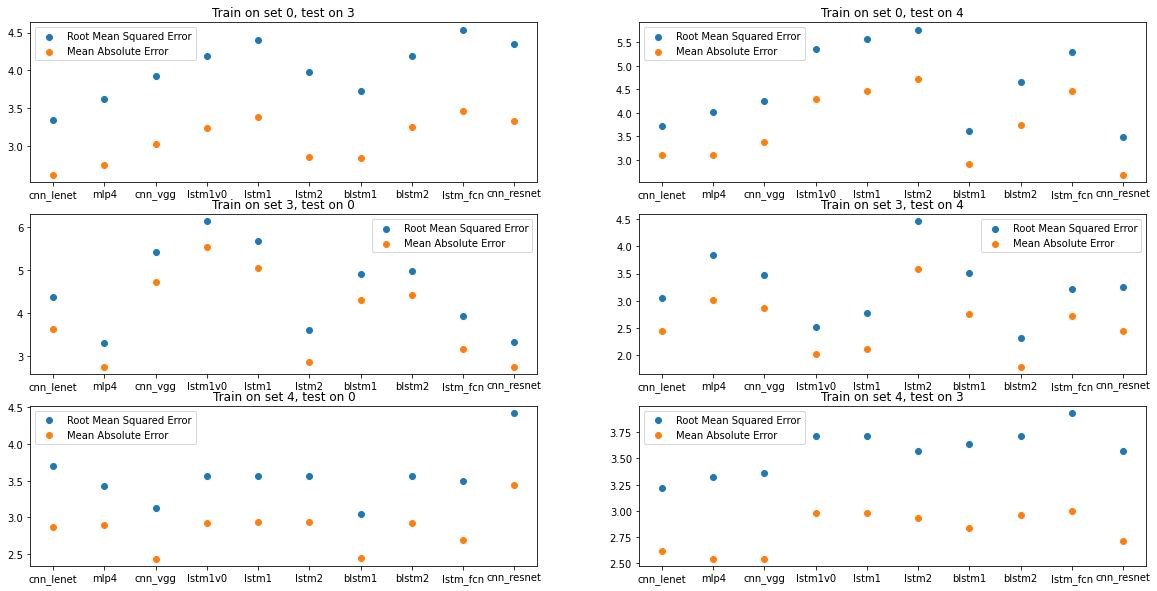

In [169]:
fig, ax = plt.subplots(3,2, figsize=[20,10])
# ax[0,0].scatter(x, to_arr(results_1_3)[:, 0], label='Mean Squared Error')
ax[0,0].scatter(x, to_arr(results_1_3)[:, 1], label='Root Mean Squared Error')
ax[0,0].scatter(x, to_arr(results_1_3)[:, 2], label='Mean Absolute Error')
ax[0,0].legend()
ax[0,0].set_title('Train on set 0, test on 3')
# ax[0,1].scatter(x, to_arr(results_1_4)[:, 0], label='Mean Squared Error')
ax[0,1].scatter(x, to_arr(results_1_4)[:, 1], label='Root Mean Squared Error')
ax[0,1].scatter(x, to_arr(results_1_4)[:, 2], label='Mean Absolute Error')
ax[0,1].legend()
ax[0,1].set_title('Train on set 0, test on 4')
# ax[1,0].scatter(x, to_arr(results_2_0)[:, 0], label='Mean Squared Error')
ax[1,0].scatter(x, to_arr(results_2_0)[:, 1], label='Root Mean Squared Error')
ax[1,0].scatter(x, to_arr(results_2_0)[:, 2], label='Mean Absolute Error')
ax[1,0].legend()
ax[1,0].set_title('Train on set 3, test on 0')
# ax[0,0].scatter(x, to_arr(results_2_4)[:, 0], label='Mean Squared Error')
ax[1,1].scatter(x, to_arr(results_2_4)[:, 1], label='Root Mean Squared Error')
ax[1,1].scatter(x, to_arr(results_2_4)[:, 2], label='Mean Absolute Error')
ax[1,1].legend()
ax[1,1].set_title('Train on set 3, test on 4')
# ax[2,0].scatter(x, to_arr(results_3_0)[:, 0], label='Mean Squared Error')
ax[2,0].scatter(x, to_arr(results_3_0)[:, 1], label='Root Mean Squared Error')
ax[2,0].scatter(x, to_arr(results_3_0)[:, 2], label='Mean Absolute Error')
ax[2,0].legend()
ax[2,0].set_title('Train on set 4, test on 0')
# ax[0,0].scatter(x, to_arr(results_3_3)[:, 0], label='Mean Squared Error')
ax[2,1].scatter(x, to_arr(results_3_3)[:, 1], label='Root Mean Squared Error')
ax[2,1].scatter(x, to_arr(results_3_3)[:, 2], label='Mean Absolute Error')
ax[2,1].legend()
ax[2,1].set_title('Train on set 4, test on 3')